# Vehicle Dectection

# Imports

In [237]:
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
import math
import os
from os.path import splitext, basename, join
from datetime import datetime

import pickle

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from scipy.ndimage.measurements import label as scipy_label

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

%matplotlib inline

# Helpers

In [24]:
def to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def to_bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def to_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def to_luv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def to_yuv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

def to_ycrcb(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

def read_image(path):
    return to_rgb(cv2.imread(path))

def plot_images(images, labels):
    rows = len(images)
    cols = len(images[0])
    cmap = None

    f, axes = plt.subplots(rows, cols, figsize=(12,20))
    
    for i, row in enumerate(images):
        for j, image in enumerate(row):
            label = labels[i][j]
            
            ax = axes[i, j] if rows > 1 else axes[j]
            
            if len(image.shape) < 3 or image.shape[-1] < 3:
                cmap = "gray"

            ax.imshow(image, cmap=cmap)
            ax.set_title(label, fontsize=20)

    plt.tight_layout()
    plt.show()
    
    return

def map_to_list(fn, args):
    return list(map(fn, args))

def zip_to_list(l1, l2):
    return list(zip(l1, l2))

def draw_boxes(image, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    new_image = np.copy(image)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(new_image, bbox[0], bbox[1], color, thick)
    
    # Return the image copy with boxes drawn
    return new_image

# Dataset summary

In [3]:
vehicle_images_pattern = 'training_data/vehicles/**/*.png'
non_vehicle_images_pattern = 'training_data/non-vehicles/**/*.png'

vehicle_images_paths = glob.glob(vehicle_images_pattern, recursive=True)
non_vehicle_images_paths = glob.glob(non_vehicle_images_pattern, recursive=True)

vehicle_images = map_to_list(lambda path: read_image(path), vehicle_images_paths)
non_vehicle_images = map_to_list(lambda path: read_image(path), non_vehicle_images_paths)

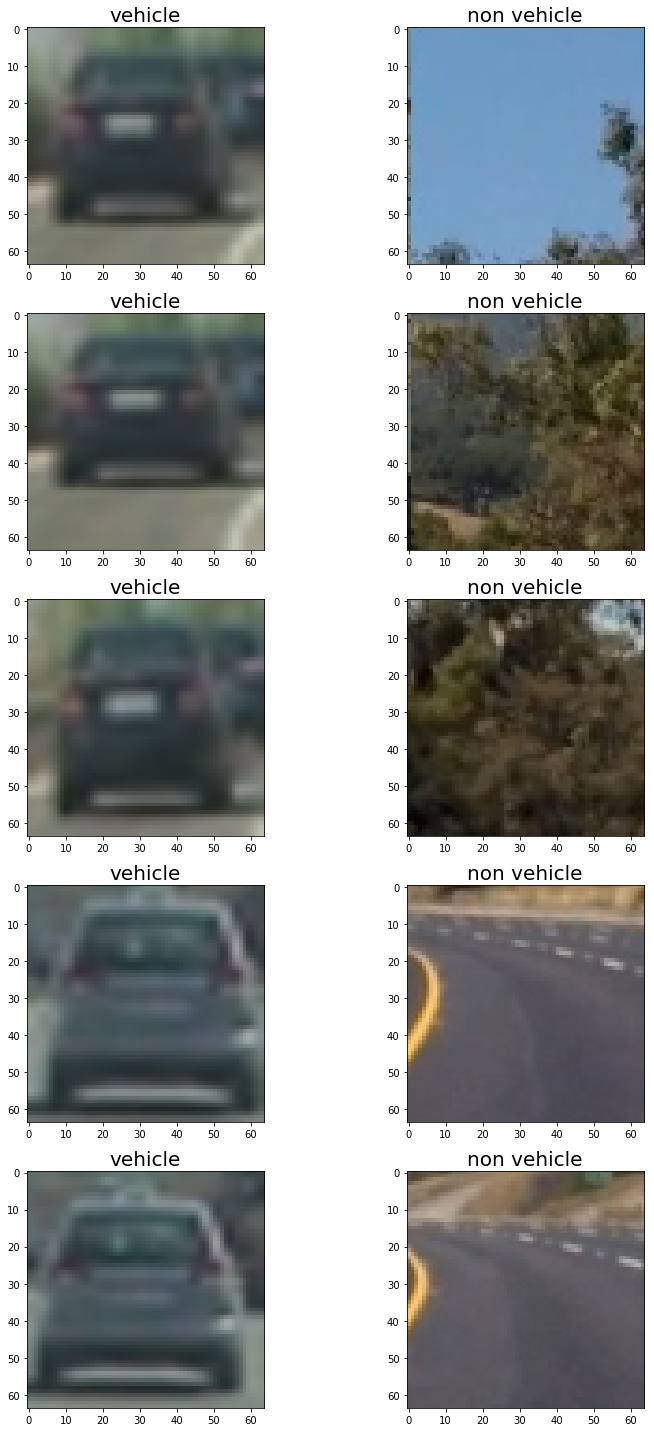

In [4]:
zipped_images = zip_to_list(vehicle_images[:5], non_vehicle_images[:5])
zipped_labels = zip_to_list(np.repeat("vehicle", 5), np.repeat("non vehicle", 5))

plot_images(zipped_images, zipped_labels)

# Features extraction

## Change color space

In [5]:
def change_color_space(image, color_space):
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            new_image = to_hsv(image)
        elif color_space == 'LUV':
            new_image = to_luv(image)
        elif color_space == 'HLS':
            new_image = to_hls(image)
        elif color_space == 'YUV':
            new_image = to_yuv(image)
        elif color_space == 'YCrCb':
            new_image = to_ycrcb(image)
    else: new_image = np.copy(image)
        
    return new_image

## Compute binned color features

In [6]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


## Compute color histogram features

In [7]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## Compute HOG features

In [8]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

## Viualize features

### Sample images

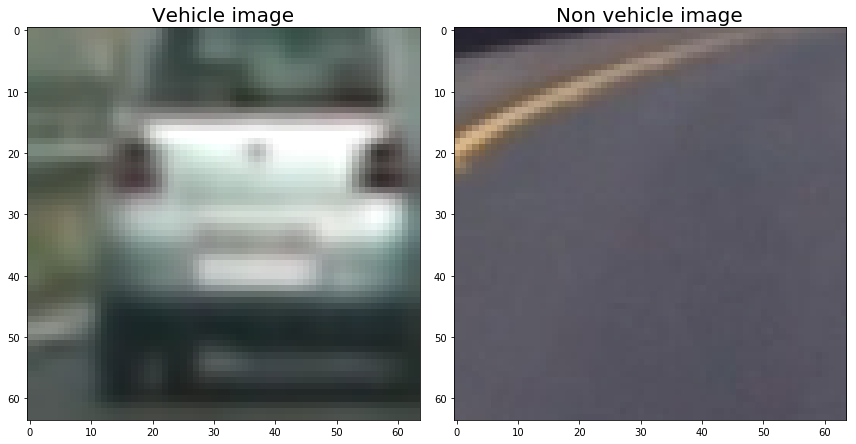

In [9]:
sample_vehicle_image = vehicle_images[100]
sample_non_vehicle_image = non_vehicle_images[100]

plot_images([[sample_vehicle_image, sample_non_vehicle_image]], [['Vehicle image', 'Non vehicle image']])

### Visualization

In [10]:
color_spaces = ['RGB', 'HLS', 'YUV', 'YCrCb']

hog_parameters = [
    #(9, 8, 2),
    #(10, 8, 2),
    #(11, 8, 2),

    #(9, 10, 2),
    #(10, 10, 2),
    #(11, 10, 2),
    
    #(9, 12, 2),
    #(10, 12, 2),
    (11, 12, 2),
    
    (9, 14, 2),
    (10, 14, 2),
    (11, 14, 2),
]

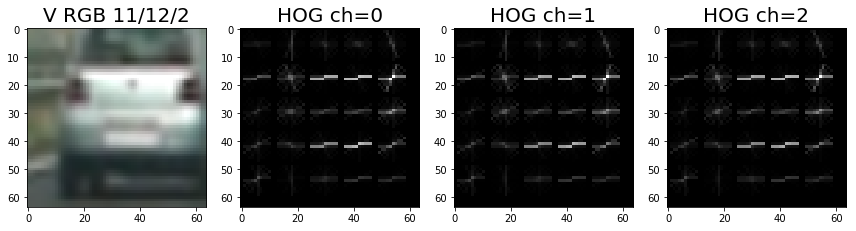

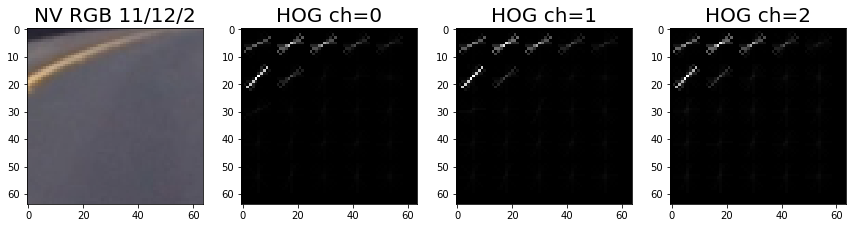

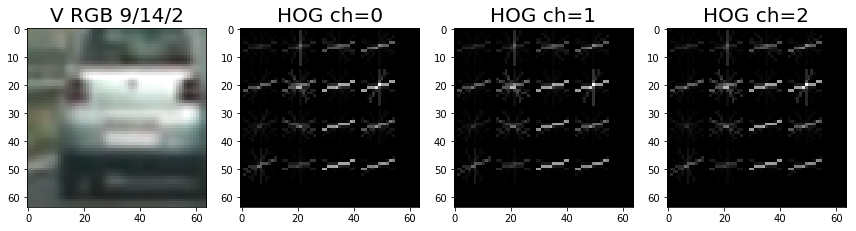

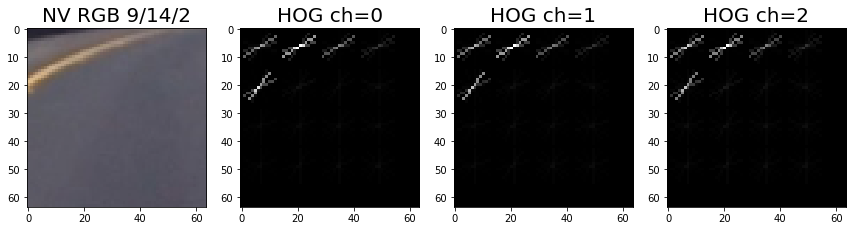

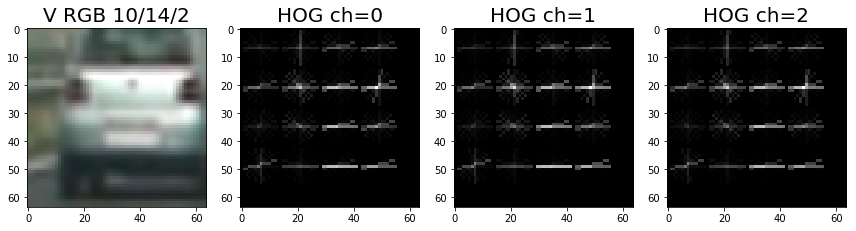

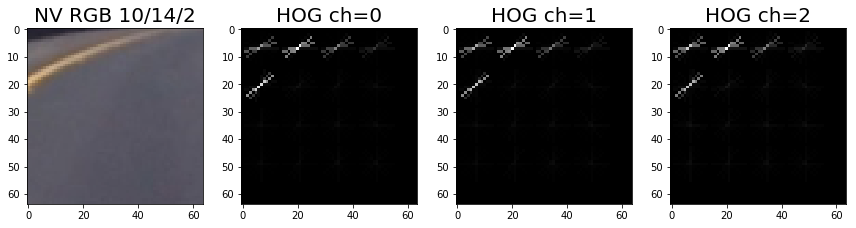

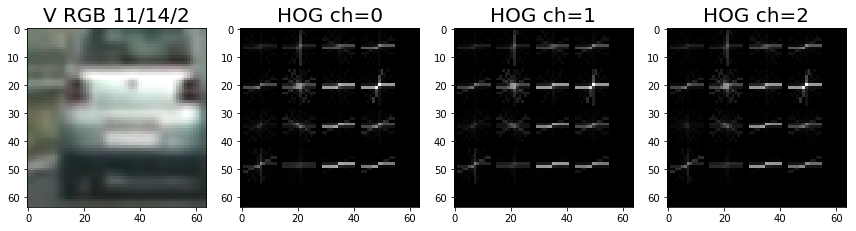

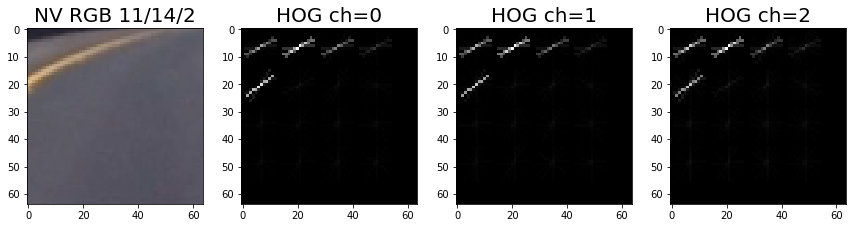

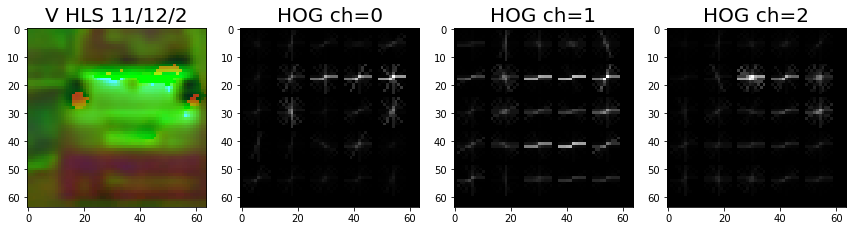

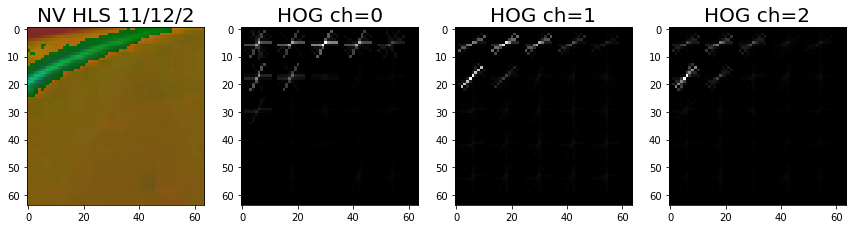

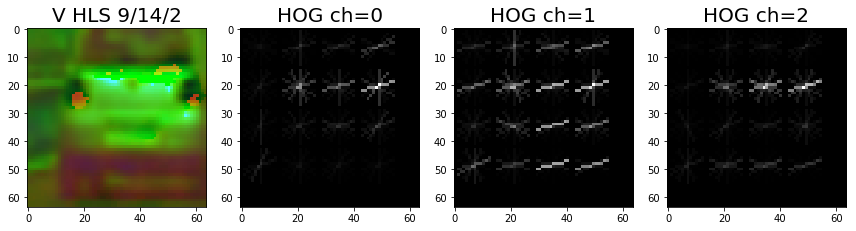

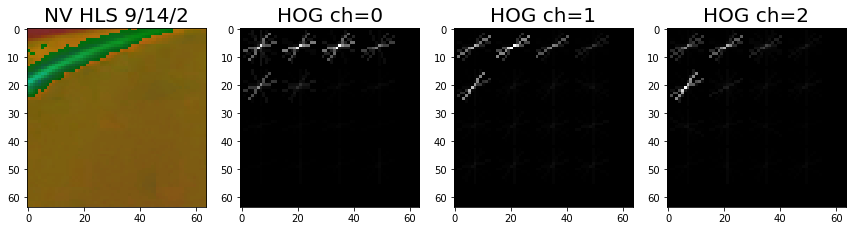

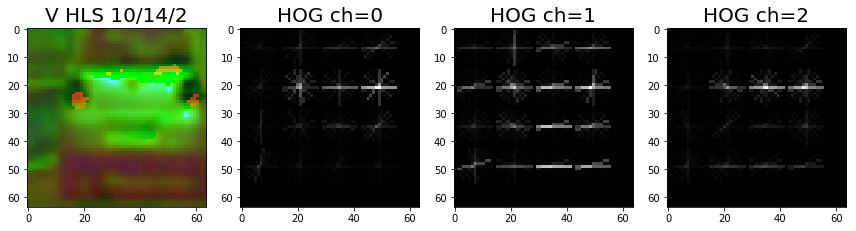

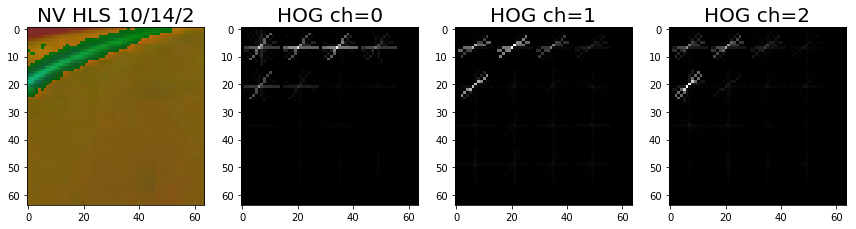

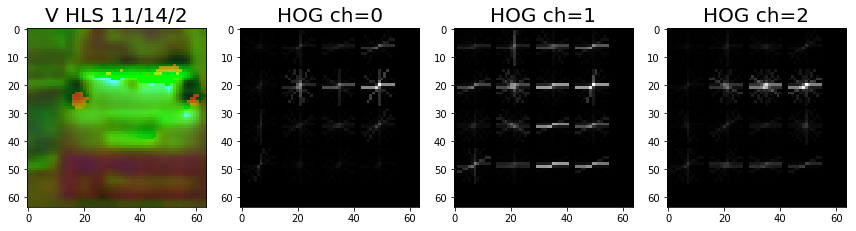

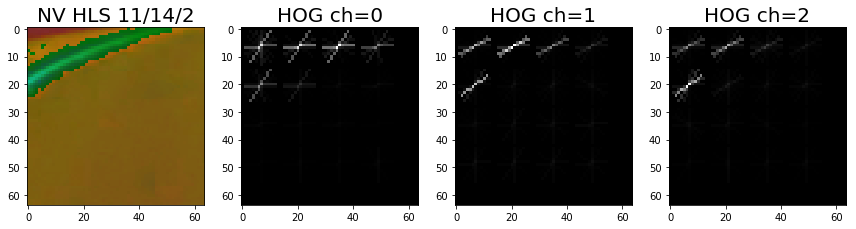

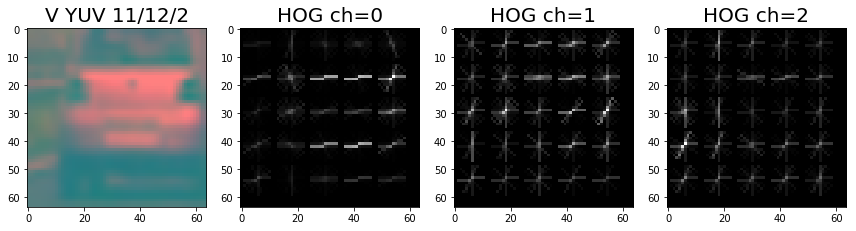

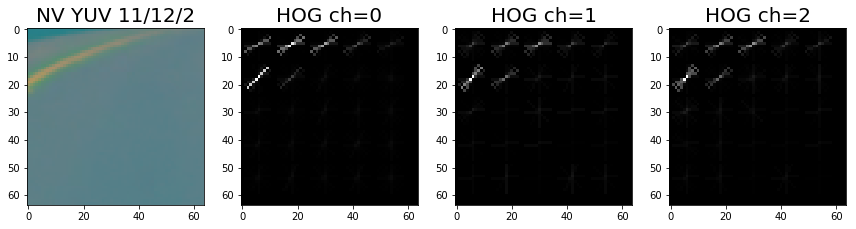

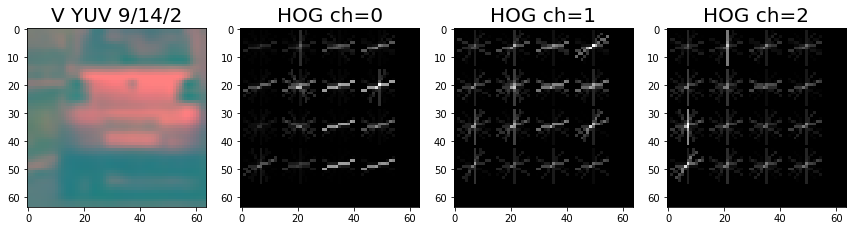

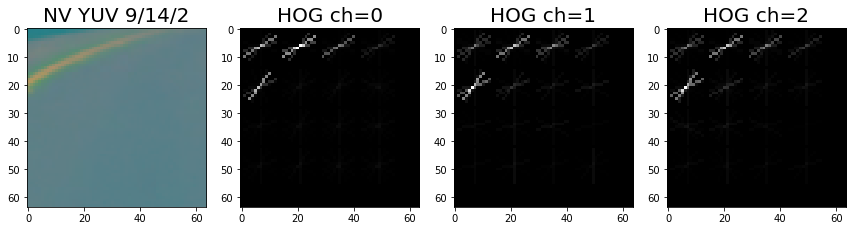

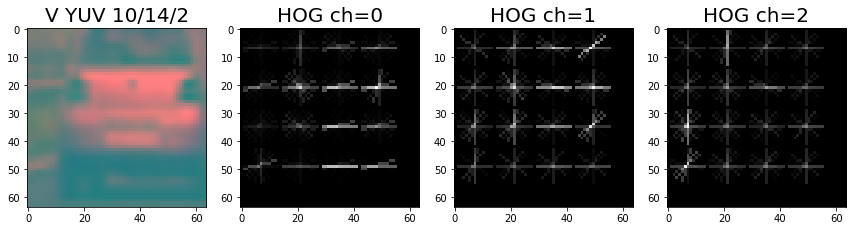

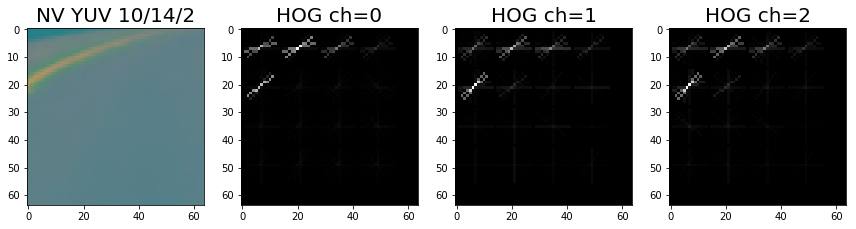

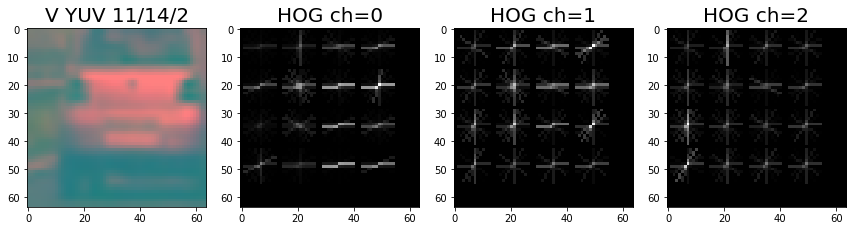

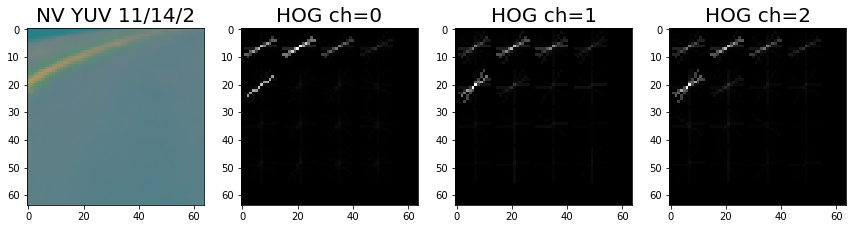

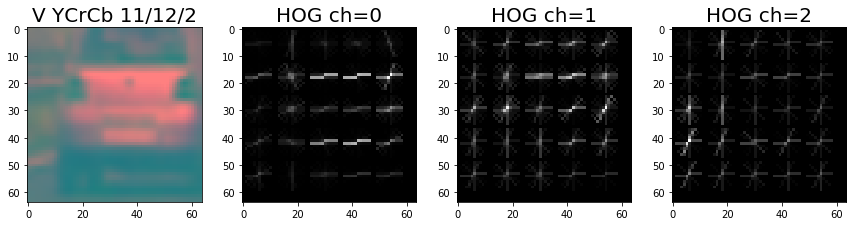

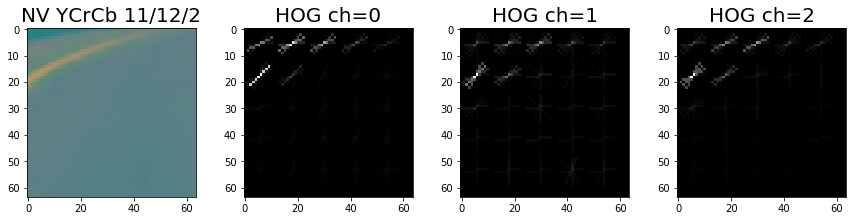

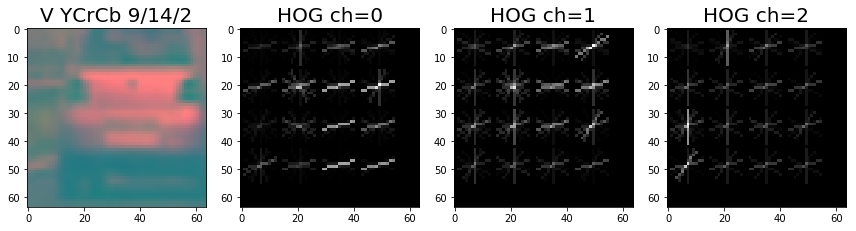

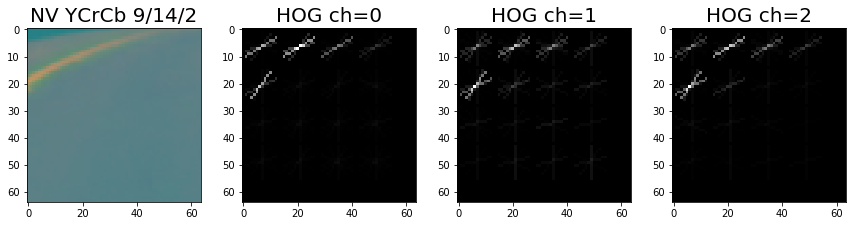

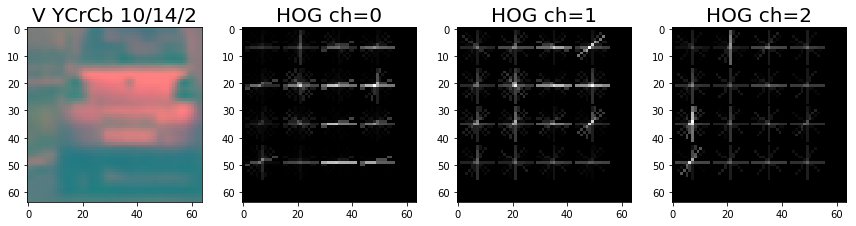

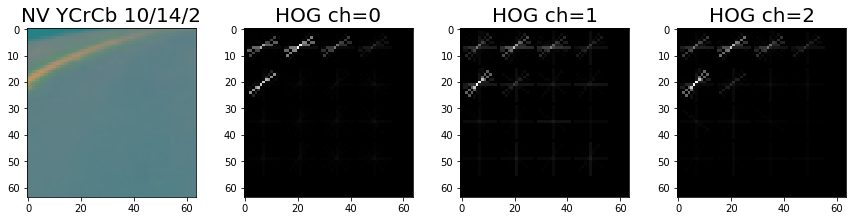

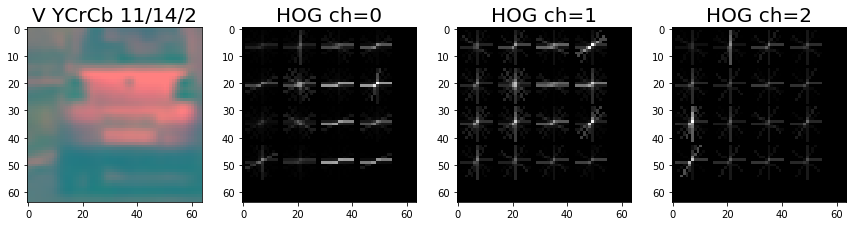

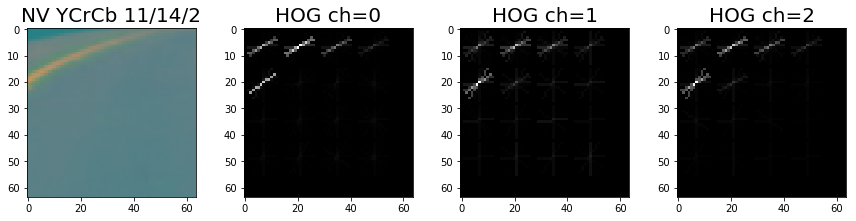

In [11]:
def visualize_hog(image, orient, pix_per_cell, cell_per_block):
    visualizations = [image]
    
    for channel in range(image.shape[2]):
        features, hog_image = get_hog_features(image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
        visualizations.append(hog_image)
        
    return visualizations

for color_space in color_spaces:
    new_vehicle_image = change_color_space(sample_vehicle_image, color_space)
    new_non_vehicle_image = change_color_space(sample_non_vehicle_image, color_space)
    
    for (orient, pix_per_cell, cell_per_block) in hog_parameters:
        vehicle_visualizations = visualize_hog(new_vehicle_image, orient, pix_per_cell, cell_per_block)
        non_vehicle_visualizations = visualize_hog(new_non_vehicle_image, orient, pix_per_cell, cell_per_block)
         
        plot_images([vehicle_visualizations], [["V {0} {1}/{2}/{3}".format(color_space, orient, pix_per_cell, cell_per_block), 'HOG ch=0', 'HOG ch=1', 'HOG ch=2']])
        plot_images([non_vehicle_visualizations], [["NV {0} {1}/{2}/{3}".format(color_space, orient, pix_per_cell, cell_per_block), 'HOG ch=0', 'HOG ch=1', 'HOG ch=2']])

## Extract features

In [12]:
def extract_features(image, cspace='RGB', spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256), orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0):
    feature_image = change_color_space(image, cspace)
    
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)

    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    # Return the feature vector
    return np.concatenate((spatial_features, hist_features, hog_features))

# Classification

## Normalization

In [13]:
def normalize(vehicle_features, non_vehicle_features):
    # Create an array stack of feature vectors
    stacked_features = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        
    # Fit a per-column scaler
    features_scaler = StandardScaler().fit(stacked_features)
    # Apply the scaler to X
    scaled_features = features_scaler.transform(stacked_features)
    
    return features_scaler, scaled_features

## Prepare dataset

In [14]:
def prepare_features(images):
    all_features = []

    for image in images:
        features = extract_features(image, cspace='YCrCb',
                                    spatial_size=(32, 32),
                                    hist_bins=32, hist_range=(0, 256),
                                    orient=10, pix_per_cell=14, cell_per_block=2, hog_channel='ALL')
        all_features.append(features)
    
    return all_features

normalized_features_file = 'normalized_features.p'
labels_file = 'labels.p'
scaler_file = 'scaler.p'

if True:
    vehicle_features = prepare_features(vehicle_images)
    non_vehicle_features = prepare_features(non_vehicle_images)

    scaler, X = normalize(vehicle_features, non_vehicle_features)
    y = np.hstack((np.ones(len(vehicle_images)), np.zeros(len(non_vehicle_images))))

    pickle.dump(X, open(normalized_features_file, 'wb'))
    pickle.dump(y, open(labels_file, 'wb'))
    pickle.dump(scaler, open(scaler_file, 'wb'))
else:
    X = pickle.load(open(normalized_features_file, 'rb'))
    y = pickle.load(open(labels_file, 'rb'))
    scaler = pickle.load(open(scaler_file, 'rb'))

In [15]:
print('Training set size =', len(y))
print('Training data shape = ', X.shape)

Training set size = 17760
Training data shape =  (17760, 4248)


## Split training data

In [16]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

## GridSearchCV

In [17]:
if False:
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 100, 1000, 10000], "gamma":["auto", 0.01, 0.1, 1, 10]}

    svr = SVC()
    classifier_gs = GridSearchCV(svr, parameters, n_jobs=4, verbose=5)
    classifier_gs.fit(X_train, y_train)

    classifier_gs.best_params_

## Classify

In [18]:
svc = SVC(C=100)
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
    
print(round(t2-t, 2), 'seconds to train SVC...')

124.55 seconds to train SVC...


In [19]:
accuracy = svc.score(X_test, y_test)

print('Accuracy = ', round(accuracy, 4))

Accuracy =  0.9941


# Sliding window search

In [23]:
def find_cars(image, ystart, ystop, scale, classifier, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, bins_range):
    draw_image = np.copy(image)
    #image = image.astype(np.float32) / 255
    
    image_tosearch = image[ystart:ystop,:,:]
    ctrans_tosearch = to_ycrcb(image_tosearch)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bounding_boxes = []
    windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=bins_range)

            # Scale features and make a prediction
            test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = classifier.predict(test_features)
            
            xbox_left = np.int(xleft * scale)
            ytop_draw = np.int(ytop * scale)
            win_draw = np.int(window * scale)
            
            top_left = (xbox_left, ytop_draw + ystart)
            bottom_right = (xbox_left + win_draw, ytop_draw + win_draw + ystart)
            
            windows.append((top_left, bottom_right))
            
            if test_prediction == 1:
                bounding_boxes.append((top_left, bottom_right))
    
    return windows, bounding_boxes

## Test images

In [105]:
test_images_pattern = 'test_images/*.jpg'
test_images_paths = glob.glob(test_images_pattern)

test_images = map_to_list(lambda path: read_image(path), test_images_paths)
test_images_labels = map_to_list(lambda path: splitext(basename(path))[0], test_images_paths)

## Test sliding window on still image

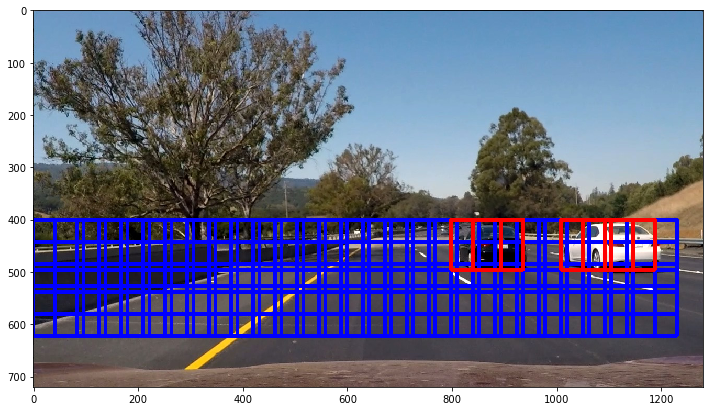

In [106]:
ystart = 400
ystop = 656
scale = 1.5

orient = 10
pix_per_cell = 14
cell_per_block = 2
spatial_size = (32, 32)
hist_bins = 32
bins_range = (0, 256)

windows, bounding_boxes = find_cars(test_images[5], ystart, ystop, scale, svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, bins_range)

image_with_windows = draw_boxes(test_images[5], windows)
image_with_windows_and_bounding_boxes = draw_boxes(image_with_windows, bounding_boxes, color=(255, 0, 0))
plt.figure(figsize=(12,20))
plt.imshow(image_with_windows_and_bounding_boxes)

In [208]:
def add_heat(heatmap, bboxes):
    # Iterate through list of bboxes
    for box in bboxes:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [209]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    # Return thresholded map
    return heatmap

In [210]:
def labeled_bounding_boxes(labels):
    bounding_boxes = []
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Define a bounding box based on min/max x and y
        top_left = (np.min(nonzerox), np.min(nonzeroy))
        bottom_right = (np.max(nonzerox), np.max(nonzeroy))
        
        # Ignore bounding box with area smaller than 32x32
        if (bottom_right[0] - top_left[0]) * (bottom_right[1] - top_left[1]) < 1024:
            continue

        bounding_boxes.append((top_left, bottom_right))
    
    # Return the image
    return bounding_boxes

In [211]:
def heatmap_bounding_boxes(image, bounding_boxes, threshold=1):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, bounding_boxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    heatmap_labels = scipy_label(heatmap)
    final_bounding_boxes = labeled_bounding_boxes(heatmap_labels)
    
    return final_bounding_boxes, heatmap

## Test heatmap on still image

[((840, 400), (893, 495)), ((1050, 400), (1145, 495))]


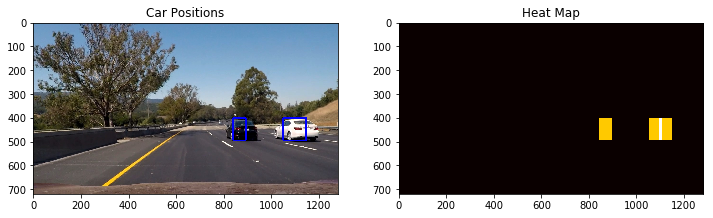

In [212]:
test_image_for_heatmap = test_images[5]

test_image_heated_bounding_boxes, test_image_heatmap = heatmap_bounding_boxes(test_image_for_heatmap, bounding_boxes)

print(test_image_heated_bounding_boxes)

draw_img = draw_boxes(np.copy(test_image_for_heatmap), test_image_heated_bounding_boxes)

fig = plt.figure(figsize=(12,20))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(test_image_heatmap, cmap='hot')
plt.title('Heat Map')

# Pipeline

In [271]:
def centroid(bounding_box):
    return (int((bounding_box[0][0] + bounding_box[1][0]) / 2), int((bounding_box[0][1] + bounding_box[1][1]) / 2))

class DetectedBoundingBox:
    def __init__(self, bounding_box, frame_index):
        self.bounding_box = bounding_box
        self.centroid = centroid(bounding_box)
        self.detection_count = 1
        self.last_seen_in_frame = frame_index
        
    def add_bounding_box(self, new_bounding_box, frame_index):
        new_bounding_box_centroid = centroid(new_bounding_box)
        
        print('old centroid =', self.centroid)
        self.centroid = centroid((new_bounding_box_centroid, self.centroid))
        print('new centroid =', self.centroid)
        
        # combine bounding boxes
        width = self.bounding_box[1][0] - self.bounding_box[0][0]
        height = self.bounding_box[1][1] - self.bounding_box[0][1]
        new_width = new_bounding_box[1][0] - new_bounding_box[0][0]
        new_height = new_bounding_box[1][1] - new_bounding_box[0][1]
        
        max_width = int((width + new_width) / 2)
        max_height = int((height + new_height) / 2)
        
        half_width = int(max_width / 2)
        half_height = int(max_height / 2)
        
        top_left = (self.centroid[0] - half_width, self.centroid[1] - half_height)
        bottom_right = (self.centroid[0] + half_width, self.centroid[1] + half_height)
        
        print('old bounding box =', self.bounding_box)
        self.bounding_box = (top_left, bottom_right)
        print('new bounding box =', self.bounding_box)
        
        self.detection_count += 1
        self.last_seen_in_frame = frame_index

class VehicleDetector:
    def __init__(self, classifier, scaler):
        self.classifier = classifier
        self.scaler = scaler
        
        self.orient = 10
        self.pix_per_cell = 14
        self.cell_per_block = 2
        self.spatial_size = (32, 32)
        self.hist_bins = 32
        self.bins_range = (0, 256)
        
        self.heatmap_threshold = 5
        
        self.sliding_windows = [
            # (ystart, ystop, scale)
            (400, 670, 1.8),
            (400, 670, 1.5),
            (400, 670, 1.3),
            (350, 550, 1)
        ]
        
        self.aggregated_bounding_boxes = []
        self.detected_bounding_boxes = []
        
        self.current_frame_index = 0
        self.aggregation_rate = 6
        
        self.debug_folder = join('./debug/', datetime.now().strftime('%Y%m%d%H%M%S'))
        os.mkdir(self.debug_folder)
    
    def process_image(self, image):
        self.debug_image(image, '0_original')
        
        bounding_boxes_to_draw = []
        
        image_windows, image_bounding_boxes = self.get_all_bounding_boxes_in_image(image)
        
        print(self.current_frame_index, 'bounding boxes detected =', len(image_bounding_boxes))
        
        image_with_windows = draw_boxes(np.copy(image), image_windows)
        image_with_windows_and_bounding_boxes = draw_boxes(image_with_windows, image_bounding_boxes, color=(255, 0, 0))
        
        self.debug_image(image_with_windows_and_bounding_boxes, '1_windows_bounding_boxes')
        
        # Add the bounding boxes for the image to our aggregated list
        self.aggregated_bounding_boxes.append(image_bounding_boxes)
        
        if self.current_frame_index > (self.aggregation_rate - 1):
            # We only keep the bounding boxes for the last n frames
            self.aggregated_bounding_boxes = self.aggregated_bounding_boxes[1:]

        print(self.current_frame_index, 'aggregated bounding boxes =', len(self.aggregated_bounding_boxes))
        
        flattened_bounding_boxes = self.flatten_aggregated_bounding_boxes()
        
        print(self.current_frame_index, 'flatten bounding boxes =', len(flattened_bounding_boxes))
        
        # Compute the heatmap for the last n frames
        heated_bounding_boxes, heatmap = heatmap_bounding_boxes(image, flattened_bounding_boxes, threshold=self.heatmap_threshold)
        
        self.debug_image(heatmap, '2_heatmap')
        
        print(self.current_frame_index, 'heated bounding boxes detected =', len(heated_bounding_boxes))
        
        # Iterate through all the heatmap bounding boxes
        for heated_bounding_box in heated_bounding_boxes:
            # Check if it matches a previously detected bounding box
            detected_bounding_box = self.match_previously_detected_bounding_box(heated_bounding_box)
            
            if detected_bounding_box != None:
                print('found matching bounding box for', heated_bounding_box)
                
                detected_bounding_box.add_bounding_box(heated_bounding_box, self.current_frame_index)
            else:
                # If not, create a DetectedBoundingBox
                detected_bounding_box = DetectedBoundingBox(heated_bounding_box, self.current_frame_index)
                
                print('detected new bounding box =', heated_bounding_box, 'centroid =', detected_bounding_box.centroid)
            
                self.detected_bounding_boxes.append(detected_bounding_box)
        
        print(self.current_frame_index, 'all bounding boxes detected =', len(self.detected_bounding_boxes))
        
        detected_bounding_box_to_keep = []
        
        for detected_bounding_box in self.detected_bounding_boxes:
            # Remove the box if we didn't detect in the last two frames
            if detected_bounding_box.last_seen_in_frame > (self.current_frame_index - 2) :
                detected_bounding_box_to_keep.append(detected_bounding_box)
            else:
                print('removing bounding box', detected_bounding_box.bounding_box)
        
        self.detected_bounding_boxes = detected_bounding_box_to_keep
        
        bounding_boxes_to_draw = []
        
        for detected_bounding_box in self.detected_bounding_boxes:                
            if detected_bounding_box.detection_count > 2:
                bounding_boxes_to_draw.append(detected_bounding_box.bounding_box)
        
        print(self.current_frame_index, 'bounding boxes to draw =', len(bounding_boxes_to_draw))
        
        final_image = draw_boxes(np.copy(image), bounding_boxes_to_draw)
        
        self.debug_image(final_image, '3_final_bounding_boxes')
        
        self.current_frame_index += 1
        
        return final_image
    
    def process_image_2(self, image):
        all_windows = []
        all_bounding_boxes = []
        
        for (ystart, ystop, scale) in sliding_windows:
                windows, bounding_boxes = find_cars(image, ystart, ystop, scale,
                                                    self.classifier, self.scaler,
                                                    self.orient, self.pix_per_cell, self.cell_per_block,
                                                    self.spatial_size, self.hist_bins, self.bins_range)
                
                [all_windows.append(window) for window in windows]
                [all_bounding_boxes.append(bounding_box) for bounding_box in bounding_boxes]
        
        heated_bounding_boxes, heatmap = heatmap_bounding_boxes(image, all_bounding_boxes)
        
        # Iterate through all the heatmap bounding boxes
        for heated_bounding_box in heatmap_bounding_boxes:
            # Check if it matches a previously detected bounding box
            detected_bounding_box = self.match_previously_detected_bounding_box(heated_bounding_box)
            
            if detected_bounding_box != None:
                print('found matching bounding box for', heated_bounding_box)
                
                detected_bounding_box.add_bounding_box(heated_bounding_box)
            else:
                # If not, create a DetectedBoundingBox
                detected_bounding_box = DetectedBoundingBox(heated_bounding_box)
                
                print('detected new bounding box =', heated_bounding_box, 'centroid =', detected_bounding_box.centroid)
            
                self.detected_bounding_boxes.append(detected_bounding_box)
        
        bounding_boxes_to_draw = []
        
        for detected_bounding_box in self.detected_bounding_boxes:
            if detected_bounding_box.detection_count > 1:
                bounding_boxes_to_draw.append(detected_bounding_box.bounding_box)
        
        self.current_frame += 1
        
        return draw_boxes(np.copy(image), bounding_boxes_to_draw)
    
    def get_all_bounding_boxes_in_image(self, image):
        all_windows = []
        all_bounding_boxes = []
        
        for (ystart, ystop, scale) in self.sliding_windows:
            windows, bounding_boxes = find_cars(image, ystart, ystop, scale,
                                                self.classifier, self.scaler,
                                                self.orient, self.pix_per_cell, self.cell_per_block,
                                                self.spatial_size, self.hist_bins, self.bins_range)

            [all_windows.append(window) for window in windows]
            [all_bounding_boxes.append(bounding_box) for bounding_box in bounding_boxes]
            
        return all_windows, all_bounding_boxes
    
    def flatten_aggregated_bounding_boxes(self):
        bounding_boxes = []
        for image_bounding_boxes in self.aggregated_bounding_boxes:
            for bounding_box in image_bounding_boxes:
                bounding_boxes.append(bounding_box)
                
        return bounding_boxes
    
    def match_previously_detected_bounding_box(self, new_bounding_box):
        new_bounding_box_centroid = centroid(new_bounding_box)
        
        for detected_bounding_box in self.detected_bounding_boxes:
            # If the distance between the bounding boxes centroids is close enough we consider it to be the same object
            dist = math.hypot(detected_bounding_box.centroid[0] - new_bounding_box_centroid[0],
                              detected_bounding_box.centroid[1] - new_bounding_box_centroid[1])

            if dist <= 50.0:
                return detected_bounding_box
        
        return None
    
    def debug_image(self, image, name):
        destination = join(self.debug_folder, "{0}_{1}.jpg".format(self.current_frame_index, name))
        
        if len(image.shape) < 3 or image.shape[-1] < 3:
            cv2.imwrite(destination, image)
        else:
            cv2.imwrite(destination, to_bgr(image))

## Testing the pipeline on test images

detected new bounding box = ((840, 400), (920, 482)) centroid = (880, 441)
detected new bounding box = ((1058, 400), (1103, 495)) centroid = (1080, 447)
found matching bounding box for ((1108, 434), (1127, 495))
old centroid = (1080, 447)
new centroid = (1098, 455)
old bounding box = ((1058, 400), (1103, 495))
new bounding box = ((1082, 416), (1114, 494))
detected new bounding box = ((806, 400), (955, 495)) centroid = (880, 447)
detected new bounding box = ((1019, 400), (1187, 514)) centroid = (1103, 457)


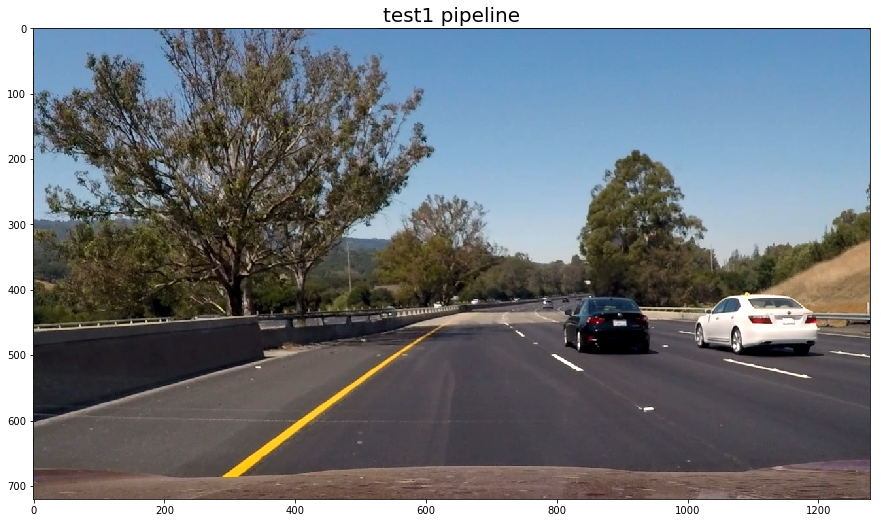

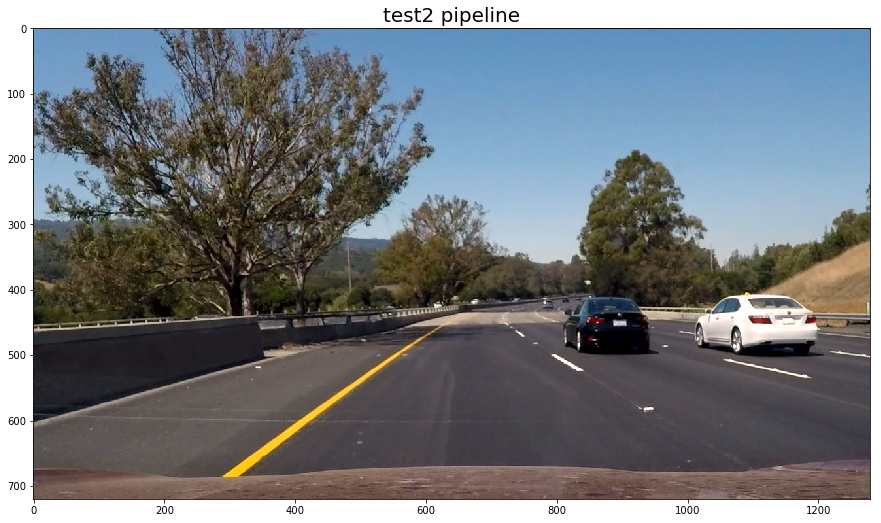

In [247]:
test_detector = VehicleDetector(svc, scaler)

temp_images = [test_images[5], test_images[5]]

pipeline_test_images = map_to_list(lambda img: test_detector.process_image(img), temp_images)
pipeline_test_images_labels = map_to_list(lambda label: label + ' pipeline', test_images_labels)

for i, image in enumerate(pipeline_test_images):
    label = pipeline_test_images_labels[i]
    plt.figure(figsize=(15,10))
    plt.imshow(image)
    plt.title(label, fontsize=20)
    plt.show()

# Testing on video

In [166]:
videos_path = 'test_videos'
videos_output_path = 'test_videos_output'

project_video_path = join(videos_path, 'project_video.mp4')
project_video_output_path = join(videos_output_path, 'project_video_output.mp4')

samples = [
    (join(videos_path, 'sample_project_video_1.mp4'), join(videos_output_path, 'sample_project_video_output_1.mp4')),
    (join(videos_path, 'sample_project_video_2.mp4'), join(videos_output_path, 'sample_project_video_output_2.mp4')),
    (join(videos_path, 'sample_project_video_3.mp4'), join(videos_output_path, 'sample_project_video_output_3.mp4')),
    (join(videos_path, 'sample_project_video_4.mp4'), join(videos_output_path, 'sample_project_video_output_4.mp4')),
]

## Create sample

In [227]:
if True:
    # 2
    ffmpeg_extract_subclip(project_video_path, 6, 9, targetname=samples[1][0])
    # 3
    ffmpeg_extract_subclip(project_video_path, 6, 12, targetname=samples[2][0])
    # 4
    ffmpeg_extract_subclip(project_video_path, 25, 40, targetname=samples[3][0])


[MoviePy] Running:
>>> ffmpeg -y -i test_videos/project_video.mp4 -ss 6.00 -t 3.00 -vcodec copy -acodec copy test_videos/sample_project_video_2.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i test_videos/project_video.mp4 -ss 6.00 -t 6.00 -vcodec copy -acodec copy test_videos/sample_project_video_3.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i test_videos/project_video.mp4 -ss 25.00 -t 15.00 -vcodec copy -acodec copy test_videos/sample_project_video_4.mp4
... command successful.


## Sample

In [270]:
sample_index = 1

sample_project_video_path = samples[sample_index][0]
sample_project_video_output_path = samples[sample_index][1]

sample_project_video_detector = VehicleDetector(svc, scaler)

sample_project_video_clip = VideoFileClip(sample_project_video_path)
sample_project_video_output_clip = sample_project_video_clip.fl_image(sample_project_video_detector.process_image)

%time sample_project_video_output_clip.write_videofile(sample_project_video_output_path, audio=False)

0 bounding boxes detected = 1
0 aggregated bounding boxes = 1
[[((1164, 436), (1247, 519))]]
0 flatten bounding boxes = 1
0 heated bounding boxes detected = 0
0 all bounding boxes detected = 0
0 bounding boxes to draw = 0
[MoviePy] >>>> Building video test_videos_output/sample_project_video_output_2.mp4
[MoviePy] Writing video test_videos_output/sample_project_video_output_2.mp4



  1%|▏         | 1/76 [00:05<06:25,  5.15s/it]

1 bounding boxes detected = 1
1 aggregated bounding boxes = 2
[[((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))]]
1 flatten bounding boxes = 2
1 heated bounding boxes detected = 0
1 all bounding boxes detected = 0
1 bounding boxes to draw = 0



  3%|▎         | 2/76 [00:10<06:25,  5.21s/it]

2 bounding boxes detected = 1
2 aggregated bounding boxes = 3
[[((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))]]
2 flatten bounding boxes = 3
2 heated bounding boxes detected = 0
2 all bounding boxes detected = 0
2 bounding boxes to draw = 0



  4%|▍         | 3/76 [00:15<06:25,  5.29s/it]

3 bounding boxes detected = 1
3 aggregated bounding boxes = 4
[[((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1176, 462), (1240, 526))]]
3 flatten bounding boxes = 4
3 heated bounding boxes detected = 0
3 all bounding boxes detected = 0
3 bounding boxes to draw = 0



  5%|▌         | 4/76 [00:21<06:24,  5.34s/it]

4 bounding boxes detected = 1
4 aggregated bounding boxes = 5
[[((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1176, 462), (1240, 526))], [((1164, 436), (1247, 519))]]
4 flatten bounding boxes = 5
4 heated bounding boxes detected = 0
4 all bounding boxes detected = 0
4 bounding boxes to draw = 0



  7%|▋         | 5/76 [00:26<06:21,  5.37s/it]

5 bounding boxes detected = 1
5 aggregated bounding boxes = 6
[[((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1176, 462), (1240, 526))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))]]
5 flatten bounding boxes = 6
5 heated bounding boxes detected = 1
detected new bounding box = ((1176, 462), (1239, 518)) centroid = (1207, 490)
5 all bounding boxes detected = 1
5 bounding boxes to draw = 0



  8%|▊         | 6/76 [00:32<06:14,  5.35s/it]

6 bounding boxes detected = 1
6 aggregated bounding boxes = 6
[[((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1176, 462), (1240, 526))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))]]
6 flatten bounding boxes = 6
6 heated bounding boxes detected = 1
found matching bounding box for ((1176, 462), (1239, 518))
old centroid = (1207, 490)
new centroid = (1207, 490)
old bounding box = ((1176, 462), (1239, 518))
new bounding box = ((1176, 462), (1238, 518))
6 all bounding boxes detected = 1
6 bounding boxes to draw = 0



  9%|▉         | 7/76 [00:37<06:08,  5.34s/it]

7 bounding boxes detected = 1
7 aggregated bounding boxes = 6
[[((1164, 436), (1247, 519))], [((1176, 462), (1240, 526))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))]]
7 flatten bounding boxes = 6
7 heated bounding boxes detected = 1
found matching bounding box for ((1176, 462), (1239, 518))
old centroid = (1207, 490)
new centroid = (1207, 490)
old bounding box = ((1176, 462), (1238, 518))
new bounding box = ((1176, 462), (1238, 518))
7 all bounding boxes detected = 1
7 bounding boxes to draw = 1



 11%|█         | 8/76 [00:43<06:07,  5.40s/it]

8 bounding boxes detected = 1
8 aggregated bounding boxes = 6
[[((1176, 462), (1240, 526))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))]]
8 flatten bounding boxes = 6
8 heated bounding boxes detected = 1
found matching bounding box for ((1176, 462), (1239, 518))
old centroid = (1207, 490)
new centroid = (1207, 490)
old bounding box = ((1176, 462), (1238, 518))
new bounding box = ((1176, 462), (1238, 518))
8 all bounding boxes detected = 1
8 bounding boxes to draw = 1



 12%|█▏        | 9/76 [00:48<06:03,  5.43s/it]

9 bounding boxes detected = 1
9 aggregated bounding boxes = 6
[[((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))]]
9 flatten bounding boxes = 6
9 heated bounding boxes detected = 1
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1207, 490)
new centroid = (1206, 483)
old bounding box = ((1176, 462), (1238, 518))
new bounding box = ((1170, 449), (1242, 517))
9 all bounding boxes detected = 1
9 bounding boxes to draw = 1



 13%|█▎        | 10/76 [00:53<05:55,  5.39s/it]

10 bounding boxes detected = 0
10 aggregated bounding boxes = 6
[[((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], []]
10 flatten bounding boxes = 5
10 heated bounding boxes detected = 0
10 all bounding boxes detected = 1
10 bounding boxes to draw = 1



 14%|█▍        | 11/76 [00:59<05:47,  5.35s/it]

11 bounding boxes detected = 0
11 aggregated bounding boxes = 6
[[((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [], []]
11 flatten bounding boxes = 4
11 heated bounding boxes detected = 0
11 all bounding boxes detected = 1
removing bounding box ((1170, 449), (1242, 517))
11 bounding boxes to draw = 0



 16%|█▌        | 12/76 [01:04<05:40,  5.32s/it]

12 bounding boxes detected = 0
12 aggregated bounding boxes = 6
[[((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [], [], []]
12 flatten bounding boxes = 3
12 heated bounding boxes detected = 0
12 all bounding boxes detected = 0
12 bounding boxes to draw = 0



 17%|█▋        | 13/76 [01:09<05:39,  5.39s/it]

13 bounding boxes detected = 0
13 aggregated bounding boxes = 6
[[((1164, 436), (1247, 519))], [((1164, 436), (1247, 519))], [], [], [], []]
13 flatten bounding boxes = 2
13 heated bounding boxes detected = 0
13 all bounding boxes detected = 0
13 bounding boxes to draw = 0



 18%|█▊        | 14/76 [01:15<05:34,  5.40s/it]

14 bounding boxes detected = 0
14 aggregated bounding boxes = 6
[[((1164, 436), (1247, 519))], [], [], [], [], []]
14 flatten bounding boxes = 1
14 heated bounding boxes detected = 0
14 all bounding boxes detected = 0
14 bounding boxes to draw = 0



 20%|█▉        | 15/76 [01:20<05:31,  5.43s/it]

15 bounding boxes detected = 1
15 aggregated bounding boxes = 6
[[], [], [], [], [], [((1128, 436), (1211, 519))]]
15 flatten bounding boxes = 1
15 heated bounding boxes detected = 0
15 all bounding boxes detected = 0
15 bounding boxes to draw = 0



 21%|██        | 16/76 [01:25<05:20,  5.34s/it]

16 bounding boxes detected = 2
16 aggregated bounding boxes = 6
[[], [], [], [], [((1128, 436), (1211, 519))], [((1128, 436), (1211, 519)), ((1164, 400), (1247, 483))]]
16 flatten bounding boxes = 3
16 heated bounding boxes detected = 0
16 all bounding boxes detected = 0
16 bounding boxes to draw = 0



 22%|██▏       | 17/76 [01:31<05:12,  5.29s/it]

17 bounding boxes detected = 3
17 aggregated bounding boxes = 6
[[], [], [], [((1128, 436), (1211, 519))], [((1128, 436), (1211, 519)), ((1164, 400), (1247, 483))], [((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1164, 436), (1247, 519))]]
17 flatten bounding boxes = 6
17 heated bounding boxes detected = 1
detected new bounding box = ((1164, 436), (1210, 482)) centroid = (1187, 459)
17 all bounding boxes detected = 1
17 bounding boxes to draw = 0



 24%|██▎       | 18/76 [01:36<05:07,  5.29s/it]

18 bounding boxes detected = 4
18 aggregated bounding boxes = 6
[[], [], [((1128, 436), (1211, 519))], [((1128, 436), (1211, 519)), ((1164, 400), (1247, 483))], [((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1164, 436), (1247, 519))], [((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1164, 436), (1247, 519)), ((1176, 406), (1240, 470))]]
18 flatten bounding boxes = 10
18 heated bounding boxes detected = 1
found matching bounding box for ((1164, 436), (1239, 518))
old centroid = (1187, 459)
new centroid = (1194, 468)
old bounding box = ((1164, 436), (1210, 482))
new bounding box = ((1164, 436), (1224, 500))
18 all bounding boxes detected = 1
18 bounding boxes to draw = 0



 25%|██▌       | 19/76 [01:41<05:04,  5.34s/it]

19 bounding boxes detected = 4
19 aggregated bounding boxes = 6
[[], [((1128, 436), (1211, 519))], [((1128, 436), (1211, 519)), ((1164, 400), (1247, 483))], [((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1164, 436), (1247, 519))], [((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1164, 436), (1247, 519)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1164, 436), (1247, 519))]]
19 flatten bounding boxes = 14
19 heated bounding boxes detected = 1
found matching bounding box for ((1128, 406), (1246, 518))
old centroid = (1194, 468)
new centroid = (1190, 465)
old bounding box = ((1164, 436), (1224, 500))
new bounding box = ((1146, 421), (1234, 509))
19 all bounding boxes detected = 1
19 bounding boxes to draw = 1



 26%|██▋       | 20/76 [01:47<04:56,  5.29s/it]

20 bounding boxes detected = 4
20 aggregated bounding boxes = 6
[[((1128, 436), (1211, 519))], [((1128, 436), (1211, 519)), ((1164, 400), (1247, 483))], [((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1164, 436), (1247, 519))], [((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1164, 436), (1247, 519)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1164, 436), (1247, 519))], [((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1176, 462), (1240, 526))]]
20 flatten bounding boxes = 18
20 heated bounding boxes detected = 1
found matching bounding box for ((1128, 400), (1246, 518))
old centroid = (1190, 465)
new centroid = (1188, 462)
old bounding box = ((1146, 421), (1234, 509))
new bounding box = ((1137, 411), (1239, 513))
20 all bounding boxes detected = 1
20 bounding boxes to draw = 1



 28%|██▊       | 21/76 [01:52<04:59,  5.45s/it]

21 bounding boxes detected = 4
21 aggregated bounding boxes = 6
[[((1128, 436), (1211, 519)), ((1164, 400), (1247, 483))], [((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1164, 436), (1247, 519))], [((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1164, 436), (1247, 519)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1164, 436), (1247, 519))], [((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1176, 462), (1240, 526))], [((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1176, 462), (1240, 526))]]
21 flatten bounding boxes = 21
21 heated bounding boxes detected = 1
found matching bounding box for ((1128, 400), (1246, 518))
old centroid = (1188, 462)
new centroid = (1187, 460)
old bounding box = ((1137, 411), (1239, 513))
new bounding box = ((1132, 405), (1242, 515))
21 all bounding boxes detected = 1
21 bounding boxes to draw 


 29%|██▉       | 22/76 [01:58<04:51,  5.40s/it]

22 bounding boxes detected = 3
22 aggregated bounding boxes = 6
[[((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1164, 436), (1247, 519))], [((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1164, 436), (1247, 519)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1164, 436), (1247, 519))], [((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1176, 462), (1240, 526))], [((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1176, 462), (1240, 526))], [((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483))]]
22 flatten bounding boxes = 22
22 heated bounding boxes detected = 1
found matching bounding box for ((1128, 400), (1246, 518))
old centroid = (1187, 460)
new centroid = (1187, 459)
old bounding box = ((1132, 405), (1242, 515))
new bounding box = ((1130, 402), (1244, 516))
22 all bounding boxes detected = 


 30%|███       | 23/76 [02:03<04:44,  5.36s/it]

23 bounding boxes detected = 5
23 aggregated bounding boxes = 6
[[((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1164, 436), (1247, 519)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1164, 436), (1247, 519))], [((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1176, 462), (1240, 526))], [((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1176, 462), (1240, 526))], [((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1176, 406), (1240, 470))]]
23 flatten bounding boxes = 24
23 heated bounding boxes detected = 1
found matching bounding box for ((1128, 400), (1246, 518))
old centroid = (1187, 459)
new centroid = (1187, 459)
old bounding box = ((1130, 402), (1244, 516))
new bounding box = ((11


 32%|███▏      | 24/76 [02:08<04:36,  5.32s/it]

24 bounding boxes detected = 6
24 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1164, 436), (1247, 519))], [((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1176, 462), (1240, 526))], [((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1176, 462), (1240, 526))], [((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))]]
24 flatten bounding boxes = 26
24 heated bounding boxes detected = 1
found matching bounding box for ((1108, 400), (1246, 518))
old centroid = (1187, 459)
new centroid = (1182, 459)
old bounding 


 33%|███▎      | 25/76 [02:13<04:29,  5.28s/it]

25 bounding boxes detected = 6
25 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1176, 462), (1240, 526))], [((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1176, 462), (1240, 526))], [((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))]]
25 flatten bounding boxes = 28
25 heated bounding boxes detected = 1
found matching bounding box for ((1108, 400), (1246, 518))
old centroi


 34%|███▍      | 26/76 [02:19<04:22,  5.24s/it]

26 bounding boxes detected = 6
26 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1176, 462), (1240, 526))], [((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))]]
26 flatten bounding boxes = 30
26 heated bounding boxes detected = 1
found matching


 36%|███▌      | 27/76 [02:24<04:16,  5.23s/it]

27 bounding boxes detected = 4
27 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1164, 400), (1247, 483)), ((1176, 406), (1240, 470))]]
27 flatten bounding boxes = 30
27 heated bounding boxes detected = 1
found matching


 37%|███▋      | 28/76 [02:29<04:13,  5.29s/it]

28 bounding boxes detected = 6
28 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1164, 400), (1247, 483)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1134, 442), (1230, 538)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))]]


 38%|███▊      | 29/76 [02:35<04:11,  5.34s/it]

29 bounding boxes detected = 7
29 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1164, 400), (1247, 483)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1134, 442), (1230, 538)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1134, 442), (1230, 538)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), 


 39%|███▉      | 30/76 [02:40<04:07,  5.39s/it]

30 bounding boxes detected = 6
30 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1164, 400), (1247, 483)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1134, 442), (1230, 538)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1134, 442), (1230, 538)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), 


 41%|████      | 31/76 [02:45<04:02,  5.39s/it]

31 bounding boxes detected = 7
31 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1164, 400), (1247, 483)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1134, 442), (1230, 538)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1134, 442), (1230, 538)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1176, 378), (1240, 442)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), 


 42%|████▏     | 32/76 [02:51<03:58,  5.41s/it]

32 bounding boxes detected = 6
32 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1164, 400), (1247, 483)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1134, 442), (1230, 538)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1134, 442), (1230, 538)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1176, 378), (1240, 442)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1176, 378), (1240, 442)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), 


 43%|████▎     | 33/76 [02:56<03:53,  5.43s/it]

33 bounding boxes detected = 8
33 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1134, 442), (1230, 538)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1134, 442), (1230, 538)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1176, 378), (1240, 442)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1176, 378), (1240, 442)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), 


 45%|████▍     | 34/76 [03:02<03:49,  5.46s/it]

34 bounding boxes detected = 8
34 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1134, 442), (1230, 538)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1120, 462), (1184, 526)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1176, 378), (1240, 442)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1176, 378), (1240, 442)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470)), ((


 46%|████▌     | 35/76 [03:07<03:41,  5.41s/it]

35 bounding boxes detected = 8
35 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1176, 378), (1240, 442)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1176, 378), (1240, 442)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((


 47%|████▋     | 36/76 [03:13<03:35,  5.39s/it]

36 bounding boxes detected = 7
36 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1176, 378), (1240, 442)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1134, 442), (1230, 538)), ((1092, 436), (1175, 519)), ((


 49%|████▊     | 37/76 [03:18<03:28,  5.35s/it]

37 bounding boxes detected = 8
37 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1134, 442), (1230, 538)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((


 50%|█████     | 38/76 [03:23<03:20,  5.27s/it]

38 bounding boxes detected = 7
38 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1134, 442), (1230, 538)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((


 51%|█████▏    | 39/76 [03:28<03:15,  5.27s/it]

39 bounding boxes detected = 6
39 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470)), ((1176, 406), (1240, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1134, 442), (1230, 538)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((560, 462), (624, 526)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((10


 53%|█████▎    | 40/76 [03:33<03:09,  5.27s/it]

40 bounding boxes detected = 6
40 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1134, 442), (1230, 538)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((560, 462), (624, 526)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((11


 54%|█████▍    | 41/76 [03:39<03:02,  5.20s/it]

41 bounding boxes detected = 7
41 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((560, 462), (624, 526)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((11


 55%|█████▌    | 42/76 [03:44<02:58,  5.24s/it]

42 bounding boxes detected = 6
42 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((560, 462), (624, 526)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1092, 434), (1156, 498)), ((11


 57%|█████▋    | 43/76 [03:49<02:55,  5.33s/it]

43 bounding boxes detected = 7
43 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1128, 436), (1211, 519)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1092, 434), (1156, 498)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), 


 58%|█████▊    | 44/76 [03:55<02:51,  5.36s/it]

44 bounding boxes detected = 8
44 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1092, 434), (1156, 498)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1092, 434), (1156, 498)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), 


 59%|█████▉    | 45/76 [04:00<02:47,  5.41s/it]

45 bounding boxes detected = 9
45 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1092, 434), (1156, 498)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1092, 434), (1156, 498)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1092, 434), (1156, 498)), ((1120, 406), (1184, 470)), ((


 61%|██████    | 46/76 [04:06<02:43,  5.45s/it]

46 bounding boxes detected = 7
46 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1092, 434), (1156, 498)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1092, 434), (1156, 498)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1092, 434), (1156, 498)), ((1120, 406), (1184, 470)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((


 62%|██████▏   | 47/76 [04:11<02:37,  5.44s/it]

47 bounding boxes detected = 9
47 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1092, 434), (1156, 498)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1092, 434), (1156, 498)), ((1120, 406), (1184, 470)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1092, 434), (1156, 498)), ((1120, 406), (1184, 470)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((


 63%|██████▎   | 48/76 [04:16<02:30,  5.37s/it]

48 bounding boxes detected = 7
48 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1092, 434), (1156, 498)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1092, 434), (1156, 498)), ((1120, 406), (1184, 470)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1092, 434), (1156, 498)), ((1120, 406), (1184, 470)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470)), ((1148, 378), (1212, 442)), ((1148, 406), (1212, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((


 64%|██████▍   | 49/76 [04:21<02:21,  5.24s/it]

49 bounding boxes detected = 7
49 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1092, 434), (1156, 498)), ((1120, 406), (1184, 470)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1092, 434), (1156, 498)), ((1120, 406), (1184, 470)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470)), ((1148, 378), (1212, 442)), ((1148, 406), (1212, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470)), ((1148, 378), (1212, 442)), ((1148, 406), (1212, 470))], [((


 66%|██████▌   | 50/76 [04:26<02:13,  5.14s/it]

50 bounding boxes detected = 6
50 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 400), (1247, 483)), ((1092, 434), (1156, 498)), ((1120, 406), (1184, 470)), ((1148, 406), (1212, 470))], [((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470)), ((1148, 378), (1212, 442)), ((1148, 406), (1212, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470)), ((1148, 378), (1212, 442)), ((1148, 406), (1212, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470)), ((1148, 406), (1212, 470))], [((1058, 400), (1173, 515)), ((


 67%|██████▋   | 51/76 [04:32<02:10,  5.22s/it]

51 bounding boxes detected = 9
51 aggregated bounding boxes = 6
[[((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470)), ((1148, 378), (1212, 442)), ((1148, 406), (1212, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470)), ((1148, 378), (1212, 442)), ((1148, 406), (1212, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470)), ((1148, 406), (1212, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470)), ((1148, 406), (1212, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((


 68%|██████▊   | 52/76 [04:37<02:06,  5.27s/it]

52 bounding boxes detected = 7
52 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470)), ((1148, 378), (1212, 442)), ((1148, 406), (1212, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470)), ((1148, 406), (1212, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470)), ((1148, 406), (1212, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((


 70%|██████▉   | 53/76 [04:42<02:01,  5.28s/it]

53 bounding boxes detected = 8
53 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470)), ((1148, 406), (1212, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470)), ((1148, 406), (1212, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470)), ((1148, 378), (1212, 442))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((


 71%|███████   | 54/76 [04:48<01:56,  5.30s/it]

54 bounding boxes detected = 7
54 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470)), ((1148, 406), (1212, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470)), ((1148, 378), (1212, 442))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((


 72%|███████▏  | 55/76 [04:54<01:56,  5.55s/it]

55 bounding boxes detected = 8
55 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470)), ((1148, 378), (1212, 442))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470)), ((1120, 462), (1184, 526))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((


 74%|███████▎  | 56/76 [05:00<01:53,  5.66s/it]

56 bounding boxes detected = 8
56 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470)), ((1148, 378), (1212, 442))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470)), ((1120, 462), (1184, 526))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((


 75%|███████▌  | 57/76 [05:05<01:44,  5.50s/it]

57 bounding boxes detected = 9
57 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470)), ((1120, 462), (1184, 526))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((


 76%|███████▋  | 58/76 [05:10<01:38,  5.46s/it]

58 bounding boxes detected = 9
58 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470)), ((1120, 462), (1184, 526))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((


 78%|███████▊  | 59/76 [05:16<01:33,  5.48s/it]

59 bounding boxes detected = 8
59 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((


 79%|███████▉  | 60/76 [05:22<01:29,  5.57s/it]

60 bounding boxes detected = 8
60 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((11


 80%|████████  | 61/76 [05:27<01:22,  5.51s/it]

61 bounding boxes detected = 8
61 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((11


 82%|████████▏ | 62/76 [05:34<01:21,  5.84s/it]

62 bounding boxes detected = 8
62 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((11


 83%|████████▎ | 63/76 [05:40<01:18,  6.01s/it]

63 bounding boxes detected = 8
63 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1134, 400), (1230, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470)), ((1176, 434), (1240, 498))], [((


 84%|████████▍ | 64/76 [05:45<01:08,  5.69s/it]

64 bounding boxes detected = 7
64 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470)), ((1176, 434), (1240, 498))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470)), ((1176, 434), (1240, 498))], [((1058, 400), (1173, 515)), ((


 86%|████████▌ | 65/76 [05:50<01:00,  5.46s/it]

65 bounding boxes detected = 8
65 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1128, 400), (1211, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470)), ((1176, 434), (1240, 498))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470)), ((1176, 434), (1240, 498))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470)), ((1176, 434), (1240, 498))], [((1058, 400), (1173, 515)), ((


 87%|████████▋ | 66/76 [05:55<00:53,  5.33s/it]

66 bounding boxes detected = 8
66 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 436), (1175, 519)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470)), ((1176, 434), (1240, 498))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470)), ((1176, 434), (1240, 498))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470)), ((1176, 434), (1240, 498))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((


 88%|████████▊ | 67/76 [06:00<00:46,  5.20s/it]

67 bounding boxes detected = 8
67 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470)), ((1176, 434), (1240, 498))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470)), ((1176, 434), (1240, 498))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((


 89%|████████▉ | 68/76 [06:05<00:40,  5.12s/it]

68 bounding boxes detected = 8
68 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470)), ((1176, 434), (1240, 498))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((


 91%|█████████ | 69/76 [06:10<00:35,  5.06s/it]

69 bounding boxes detected = 7
69 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((


 92%|█████████▏| 70/76 [06:15<00:30,  5.02s/it]

70 bounding boxes detected = 7
70 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((


 93%|█████████▎| 71/76 [06:20<00:24,  4.99s/it]

71 bounding boxes detected = 9
71 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((


 95%|█████████▍| 72/76 [06:24<00:19,  4.98s/it]

72 bounding boxes detected = 9
72 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((


 96%|█████████▌| 73/76 [06:29<00:14,  4.98s/it]

73 bounding boxes detected = 8
73 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1092, 406), (1156, 470)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((


 97%|█████████▋| 74/76 [06:35<00:10,  5.11s/it]

74 bounding boxes detected = 8
74 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1092, 406), (1156, 470)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1092, 406), (1156, 470)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((


 99%|█████████▊| 75/76 [06:40<00:05,  5.24s/it]

75 bounding boxes detected = 7
75 aggregated bounding boxes = 6
[[((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1092, 406), (1156, 470)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1164, 436), (1247, 519)), ((1092, 406), (1156, 470)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((1058, 400), (1173, 515)), ((1108, 400), (1223, 515)), ((1050, 400), (1146, 496)), ((1092, 400), (1188, 496)), ((1092, 400), (1175, 483)), ((1092, 406), (1156, 470)), ((1120, 378), (1184, 442)), ((1120, 406), (1184, 470))], [((

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/sample_project_video_output_2.mp4 

CPU times: user 6min 37s, sys: 4.88 s, total: 6min 42s
Wall time: 6min 41s


## Project video

In [272]:
project_video_detector = VehicleDetector(svc, scaler)

project_video_clip = VideoFileClip(project_video_path)
project_video_output_clip = project_video_clip.fl_image(project_video_detector.process_image)

%time project_video_output_clip.write_videofile(project_video_output_path, audio=False)

0 bounding boxes detected = 0
0 aggregated bounding boxes = 1
0 flatten bounding boxes = 0
0 heated bounding boxes detected = 0
0 all bounding boxes detected = 0
0 bounding boxes to draw = 0
[MoviePy] >>>> Building video test_videos_output/project_video_output.mp4
[MoviePy] Writing video test_videos_output/project_video_output.mp4



  0%|          | 1/1261 [00:06<2:12:28,  6.31s/it]

1 bounding boxes detected = 0
1 aggregated bounding boxes = 2
1 flatten bounding boxes = 0
1 heated bounding boxes detected = 0
1 all bounding boxes detected = 0
1 bounding boxes to draw = 0



  0%|          | 2/1261 [00:11<2:03:42,  5.90s/it]

2 bounding boxes detected = 0
2 aggregated bounding boxes = 3
2 flatten bounding boxes = 0
2 heated bounding boxes detected = 0
2 all bounding boxes detected = 0
2 bounding boxes to draw = 0



  0%|          | 3/1261 [00:16<1:59:13,  5.69s/it]

3 bounding boxes detected = 0
3 aggregated bounding boxes = 4
3 flatten bounding boxes = 0
3 heated bounding boxes detected = 0
3 all bounding boxes detected = 0
3 bounding boxes to draw = 0



  0%|          | 4/1261 [00:21<1:57:30,  5.61s/it]

4 bounding boxes detected = 0
4 aggregated bounding boxes = 5
4 flatten bounding boxes = 0
4 heated bounding boxes detected = 0
4 all bounding boxes detected = 0
4 bounding boxes to draw = 0



  0%|          | 5/1261 [00:27<1:54:26,  5.47s/it]

5 bounding boxes detected = 0
5 aggregated bounding boxes = 6
5 flatten bounding boxes = 0
5 heated bounding boxes detected = 0
5 all bounding boxes detected = 0
5 bounding boxes to draw = 0



  0%|          | 6/1261 [00:32<1:52:43,  5.39s/it]

6 bounding boxes detected = 0
6 aggregated bounding boxes = 6
6 flatten bounding boxes = 0
6 heated bounding boxes detected = 0
6 all bounding boxes detected = 0
6 bounding boxes to draw = 0



  1%|          | 7/1261 [00:37<1:51:18,  5.33s/it]

7 bounding boxes detected = 0
7 aggregated bounding boxes = 6
7 flatten bounding boxes = 0
7 heated bounding boxes detected = 0
7 all bounding boxes detected = 0
7 bounding boxes to draw = 0



  1%|          | 8/1261 [00:42<1:50:54,  5.31s/it]

8 bounding boxes detected = 0
8 aggregated bounding boxes = 6
8 flatten bounding boxes = 0
8 heated bounding boxes detected = 0
8 all bounding boxes detected = 0
8 bounding boxes to draw = 0



  1%|          | 9/1261 [00:48<1:52:11,  5.38s/it]

9 bounding boxes detected = 0
9 aggregated bounding boxes = 6
9 flatten bounding boxes = 0
9 heated bounding boxes detected = 0
9 all bounding boxes detected = 0
9 bounding boxes to draw = 0



  1%|          | 10/1261 [00:53<1:50:39,  5.31s/it]

10 bounding boxes detected = 0
10 aggregated bounding boxes = 6
10 flatten bounding boxes = 0
10 heated bounding boxes detected = 0
10 all bounding boxes detected = 0
10 bounding boxes to draw = 0



  1%|          | 11/1261 [00:58<1:49:39,  5.26s/it]

11 bounding boxes detected = 0
11 aggregated bounding boxes = 6
11 flatten bounding boxes = 0
11 heated bounding boxes detected = 0
11 all bounding boxes detected = 0
11 bounding boxes to draw = 0



  1%|          | 12/1261 [01:03<1:49:11,  5.25s/it]

12 bounding boxes detected = 0
12 aggregated bounding boxes = 6
12 flatten bounding boxes = 0
12 heated bounding boxes detected = 0
12 all bounding boxes detected = 0
12 bounding boxes to draw = 0



  1%|          | 13/1261 [01:09<1:49:30,  5.26s/it]

13 bounding boxes detected = 0
13 aggregated bounding boxes = 6
13 flatten bounding boxes = 0
13 heated bounding boxes detected = 0
13 all bounding boxes detected = 0
13 bounding boxes to draw = 0



  1%|          | 14/1261 [01:14<1:49:40,  5.28s/it]

14 bounding boxes detected = 0
14 aggregated bounding boxes = 6
14 flatten bounding boxes = 0
14 heated bounding boxes detected = 0
14 all bounding boxes detected = 0
14 bounding boxes to draw = 0



  1%|          | 15/1261 [01:19<1:49:47,  5.29s/it]

15 bounding boxes detected = 0
15 aggregated bounding boxes = 6
15 flatten bounding boxes = 0
15 heated bounding boxes detected = 0
15 all bounding boxes detected = 0
15 bounding boxes to draw = 0



  1%|▏         | 16/1261 [01:25<1:52:24,  5.42s/it]

16 bounding boxes detected = 0
16 aggregated bounding boxes = 6
16 flatten bounding boxes = 0
16 heated bounding boxes detected = 0
16 all bounding boxes detected = 0
16 bounding boxes to draw = 0



  1%|▏         | 17/1261 [01:30<1:53:31,  5.48s/it]

17 bounding boxes detected = 0
17 aggregated bounding boxes = 6
17 flatten bounding boxes = 0
17 heated bounding boxes detected = 0
17 all bounding boxes detected = 0
17 bounding boxes to draw = 0



  1%|▏         | 18/1261 [01:36<1:53:01,  5.46s/it]

18 bounding boxes detected = 0
18 aggregated bounding boxes = 6
18 flatten bounding boxes = 0
18 heated bounding boxes detected = 0
18 all bounding boxes detected = 0
18 bounding boxes to draw = 0



  2%|▏         | 19/1261 [01:41<1:53:59,  5.51s/it]

19 bounding boxes detected = 0
19 aggregated bounding boxes = 6
19 flatten bounding boxes = 0
19 heated bounding boxes detected = 0
19 all bounding boxes detected = 0
19 bounding boxes to draw = 0



  2%|▏         | 20/1261 [01:47<1:55:39,  5.59s/it]

20 bounding boxes detected = 0
20 aggregated bounding boxes = 6
20 flatten bounding boxes = 0
20 heated bounding boxes detected = 0
20 all bounding boxes detected = 0
20 bounding boxes to draw = 0



  2%|▏         | 21/1261 [01:53<1:56:22,  5.63s/it]

21 bounding boxes detected = 0
21 aggregated bounding boxes = 6
21 flatten bounding boxes = 0
21 heated bounding boxes detected = 0
21 all bounding boxes detected = 0
21 bounding boxes to draw = 0



  2%|▏         | 22/1261 [01:59<1:56:11,  5.63s/it]

22 bounding boxes detected = 0
22 aggregated bounding boxes = 6
22 flatten bounding boxes = 0
22 heated bounding boxes detected = 0
22 all bounding boxes detected = 0
22 bounding boxes to draw = 0



  2%|▏         | 23/1261 [02:04<1:56:00,  5.62s/it]

23 bounding boxes detected = 0
23 aggregated bounding boxes = 6
23 flatten bounding boxes = 0
23 heated bounding boxes detected = 0
23 all bounding boxes detected = 0
23 bounding boxes to draw = 0



  2%|▏         | 24/1261 [02:10<1:55:28,  5.60s/it]

24 bounding boxes detected = 0
24 aggregated bounding boxes = 6
24 flatten bounding boxes = 0
24 heated bounding boxes detected = 0
24 all bounding boxes detected = 0
24 bounding boxes to draw = 0



  2%|▏         | 25/1261 [02:15<1:55:45,  5.62s/it]

25 bounding boxes detected = 0
25 aggregated bounding boxes = 6
25 flatten bounding boxes = 0
25 heated bounding boxes detected = 0
25 all bounding boxes detected = 0
25 bounding boxes to draw = 0



  2%|▏         | 26/1261 [02:21<1:55:48,  5.63s/it]

26 bounding boxes detected = 0
26 aggregated bounding boxes = 6
26 flatten bounding boxes = 0
26 heated bounding boxes detected = 0
26 all bounding boxes detected = 0
26 bounding boxes to draw = 0



  2%|▏         | 27/1261 [02:27<1:55:01,  5.59s/it]

27 bounding boxes detected = 0
27 aggregated bounding boxes = 6
27 flatten bounding boxes = 0
27 heated bounding boxes detected = 0
27 all bounding boxes detected = 0
27 bounding boxes to draw = 0



  2%|▏         | 28/1261 [02:32<1:53:27,  5.52s/it]

28 bounding boxes detected = 0
28 aggregated bounding boxes = 6
28 flatten bounding boxes = 0
28 heated bounding boxes detected = 0
28 all bounding boxes detected = 0
28 bounding boxes to draw = 0



  2%|▏         | 29/1261 [02:38<1:54:21,  5.57s/it]

29 bounding boxes detected = 0
29 aggregated bounding boxes = 6
29 flatten bounding boxes = 0
29 heated bounding boxes detected = 0
29 all bounding boxes detected = 0
29 bounding boxes to draw = 0



  2%|▏         | 30/1261 [02:43<1:53:01,  5.51s/it]

30 bounding boxes detected = 0
30 aggregated bounding boxes = 6
30 flatten bounding boxes = 0
30 heated bounding boxes detected = 0
30 all bounding boxes detected = 0
30 bounding boxes to draw = 0



  2%|▏         | 31/1261 [02:49<1:53:05,  5.52s/it]

31 bounding boxes detected = 0
31 aggregated bounding boxes = 6
31 flatten bounding boxes = 0
31 heated bounding boxes detected = 0
31 all bounding boxes detected = 0
31 bounding boxes to draw = 0



  3%|▎         | 32/1261 [02:54<1:52:42,  5.50s/it]

32 bounding boxes detected = 0
32 aggregated bounding boxes = 6
32 flatten bounding boxes = 0
32 heated bounding boxes detected = 0
32 all bounding boxes detected = 0
32 bounding boxes to draw = 0



  3%|▎         | 33/1261 [03:00<1:54:00,  5.57s/it]

33 bounding boxes detected = 0
33 aggregated bounding boxes = 6
33 flatten bounding boxes = 0
33 heated bounding boxes detected = 0
33 all bounding boxes detected = 0
33 bounding boxes to draw = 0



  3%|▎         | 34/1261 [03:05<1:53:31,  5.55s/it]

34 bounding boxes detected = 0
34 aggregated bounding boxes = 6
34 flatten bounding boxes = 0
34 heated bounding boxes detected = 0
34 all bounding boxes detected = 0
34 bounding boxes to draw = 0



  3%|▎         | 35/1261 [03:11<1:54:26,  5.60s/it]

35 bounding boxes detected = 0
35 aggregated bounding boxes = 6
35 flatten bounding boxes = 0
35 heated bounding boxes detected = 0
35 all bounding boxes detected = 0
35 bounding boxes to draw = 0



  3%|▎         | 36/1261 [03:16<1:53:37,  5.57s/it]

36 bounding boxes detected = 0
36 aggregated bounding boxes = 6
36 flatten bounding boxes = 0
36 heated bounding boxes detected = 0
36 all bounding boxes detected = 0
36 bounding boxes to draw = 0



  3%|▎         | 37/1261 [03:22<1:54:15,  5.60s/it]

37 bounding boxes detected = 0
37 aggregated bounding boxes = 6
37 flatten bounding boxes = 0
37 heated bounding boxes detected = 0
37 all bounding boxes detected = 0
37 bounding boxes to draw = 0



  3%|▎         | 38/1261 [03:28<1:54:34,  5.62s/it]

38 bounding boxes detected = 0
38 aggregated bounding boxes = 6
38 flatten bounding boxes = 0
38 heated bounding boxes detected = 0
38 all bounding boxes detected = 0
38 bounding boxes to draw = 0



  3%|▎         | 39/1261 [03:33<1:54:16,  5.61s/it]

39 bounding boxes detected = 0
39 aggregated bounding boxes = 6
39 flatten bounding boxes = 0
39 heated bounding boxes detected = 0
39 all bounding boxes detected = 0
39 bounding boxes to draw = 0



  3%|▎         | 40/1261 [03:39<1:53:43,  5.59s/it]

40 bounding boxes detected = 0
40 aggregated bounding boxes = 6
40 flatten bounding boxes = 0
40 heated bounding boxes detected = 0
40 all bounding boxes detected = 0
40 bounding boxes to draw = 0



  3%|▎         | 41/1261 [03:44<1:53:03,  5.56s/it]

41 bounding boxes detected = 0
41 aggregated bounding boxes = 6
41 flatten bounding boxes = 0
41 heated bounding boxes detected = 0
41 all bounding boxes detected = 0
41 bounding boxes to draw = 0



  3%|▎         | 42/1261 [03:50<1:51:54,  5.51s/it]

42 bounding boxes detected = 0
42 aggregated bounding boxes = 6
42 flatten bounding boxes = 0
42 heated bounding boxes detected = 0
42 all bounding boxes detected = 0
42 bounding boxes to draw = 0



  3%|▎         | 43/1261 [03:55<1:51:57,  5.52s/it]

43 bounding boxes detected = 0
43 aggregated bounding boxes = 6
43 flatten bounding boxes = 0
43 heated bounding boxes detected = 0
43 all bounding boxes detected = 0
43 bounding boxes to draw = 0



  3%|▎         | 44/1261 [04:01<1:51:50,  5.51s/it]

44 bounding boxes detected = 0
44 aggregated bounding boxes = 6
44 flatten bounding boxes = 0
44 heated bounding boxes detected = 0
44 all bounding boxes detected = 0
44 bounding boxes to draw = 0



  4%|▎         | 45/1261 [04:06<1:50:44,  5.46s/it]

45 bounding boxes detected = 0
45 aggregated bounding boxes = 6
45 flatten bounding boxes = 0
45 heated bounding boxes detected = 0
45 all bounding boxes detected = 0
45 bounding boxes to draw = 0



  4%|▎         | 46/1261 [04:12<1:50:26,  5.45s/it]

46 bounding boxes detected = 0
46 aggregated bounding boxes = 6
46 flatten bounding boxes = 0
46 heated bounding boxes detected = 0
46 all bounding boxes detected = 0
46 bounding boxes to draw = 0



  4%|▎         | 47/1261 [04:17<1:50:57,  5.48s/it]

47 bounding boxes detected = 0
47 aggregated bounding boxes = 6
47 flatten bounding boxes = 0
47 heated bounding boxes detected = 0
47 all bounding boxes detected = 0
47 bounding boxes to draw = 0



  4%|▍         | 48/1261 [04:23<1:52:26,  5.56s/it]

48 bounding boxes detected = 0
48 aggregated bounding boxes = 6
48 flatten bounding boxes = 0
48 heated bounding boxes detected = 0
48 all bounding boxes detected = 0
48 bounding boxes to draw = 0



  4%|▍         | 49/1261 [04:29<1:52:40,  5.58s/it]

49 bounding boxes detected = 0
49 aggregated bounding boxes = 6
49 flatten bounding boxes = 0
49 heated bounding boxes detected = 0
49 all bounding boxes detected = 0
49 bounding boxes to draw = 0



  4%|▍         | 50/1261 [04:34<1:53:29,  5.62s/it]

50 bounding boxes detected = 0
50 aggregated bounding boxes = 6
50 flatten bounding boxes = 0
50 heated bounding boxes detected = 0
50 all bounding boxes detected = 0
50 bounding boxes to draw = 0



  4%|▍         | 51/1261 [04:40<1:55:32,  5.73s/it]

51 bounding boxes detected = 0
51 aggregated bounding boxes = 6
51 flatten bounding boxes = 0
51 heated bounding boxes detected = 0
51 all bounding boxes detected = 0
51 bounding boxes to draw = 0



  4%|▍         | 52/1261 [04:46<1:56:04,  5.76s/it]

52 bounding boxes detected = 0
52 aggregated bounding boxes = 6
52 flatten bounding boxes = 0
52 heated bounding boxes detected = 0
52 all bounding boxes detected = 0
52 bounding boxes to draw = 0



  4%|▍         | 53/1261 [04:52<1:54:19,  5.68s/it]

53 bounding boxes detected = 0
53 aggregated bounding boxes = 6
53 flatten bounding boxes = 0
53 heated bounding boxes detected = 0
53 all bounding boxes detected = 0
53 bounding boxes to draw = 0



  4%|▍         | 54/1261 [04:57<1:52:23,  5.59s/it]

54 bounding boxes detected = 0
54 aggregated bounding boxes = 6
54 flatten bounding boxes = 0
54 heated bounding boxes detected = 0
54 all bounding boxes detected = 0
54 bounding boxes to draw = 0



  4%|▍         | 55/1261 [05:02<1:51:10,  5.53s/it]

55 bounding boxes detected = 0
55 aggregated bounding boxes = 6
55 flatten bounding boxes = 0
55 heated bounding boxes detected = 0
55 all bounding boxes detected = 0
55 bounding boxes to draw = 0



  4%|▍         | 56/1261 [05:08<1:49:28,  5.45s/it]

56 bounding boxes detected = 0
56 aggregated bounding boxes = 6
56 flatten bounding boxes = 0
56 heated bounding boxes detected = 0
56 all bounding boxes detected = 0
56 bounding boxes to draw = 0



  5%|▍         | 57/1261 [05:13<1:48:47,  5.42s/it]

57 bounding boxes detected = 0
57 aggregated bounding boxes = 6
57 flatten bounding boxes = 0
57 heated bounding boxes detected = 0
57 all bounding boxes detected = 0
57 bounding boxes to draw = 0



  5%|▍         | 58/1261 [05:18<1:47:19,  5.35s/it]

58 bounding boxes detected = 0
58 aggregated bounding boxes = 6
58 flatten bounding boxes = 0
58 heated bounding boxes detected = 0
58 all bounding boxes detected = 0
58 bounding boxes to draw = 0



  5%|▍         | 59/1261 [05:23<1:44:51,  5.23s/it]

59 bounding boxes detected = 0
59 aggregated bounding boxes = 6
59 flatten bounding boxes = 0
59 heated bounding boxes detected = 0
59 all bounding boxes detected = 0
59 bounding boxes to draw = 0



  5%|▍         | 60/1261 [05:28<1:42:49,  5.14s/it]

60 bounding boxes detected = 0
60 aggregated bounding boxes = 6
60 flatten bounding boxes = 0
60 heated bounding boxes detected = 0
60 all bounding boxes detected = 0
60 bounding boxes to draw = 0



  5%|▍         | 61/1261 [05:33<1:41:32,  5.08s/it]

61 bounding boxes detected = 0
61 aggregated bounding boxes = 6
61 flatten bounding boxes = 0
61 heated bounding boxes detected = 0
61 all bounding boxes detected = 0
61 bounding boxes to draw = 0



  5%|▍         | 62/1261 [05:38<1:40:45,  5.04s/it]

62 bounding boxes detected = 0
62 aggregated bounding boxes = 6
62 flatten bounding boxes = 0
62 heated bounding boxes detected = 0
62 all bounding boxes detected = 0
62 bounding boxes to draw = 0



  5%|▍         | 63/1261 [05:43<1:39:48,  5.00s/it]

63 bounding boxes detected = 0
63 aggregated bounding boxes = 6
63 flatten bounding boxes = 0
63 heated bounding boxes detected = 0
63 all bounding boxes detected = 0
63 bounding boxes to draw = 0



  5%|▌         | 64/1261 [05:48<1:39:17,  4.98s/it]

64 bounding boxes detected = 0
64 aggregated bounding boxes = 6
64 flatten bounding boxes = 0
64 heated bounding boxes detected = 0
64 all bounding boxes detected = 0
64 bounding boxes to draw = 0



  5%|▌         | 65/1261 [05:53<1:38:31,  4.94s/it]

65 bounding boxes detected = 0
65 aggregated bounding boxes = 6
65 flatten bounding boxes = 0
65 heated bounding boxes detected = 0
65 all bounding boxes detected = 0
65 bounding boxes to draw = 0



  5%|▌         | 66/1261 [05:58<1:38:32,  4.95s/it]

66 bounding boxes detected = 0
66 aggregated bounding boxes = 6
66 flatten bounding boxes = 0
66 heated bounding boxes detected = 0
66 all bounding boxes detected = 0
66 bounding boxes to draw = 0



  5%|▌         | 67/1261 [06:03<1:38:35,  4.95s/it]

67 bounding boxes detected = 0
67 aggregated bounding boxes = 6
67 flatten bounding boxes = 0
67 heated bounding boxes detected = 0
67 all bounding boxes detected = 0
67 bounding boxes to draw = 0



  5%|▌         | 68/1261 [06:07<1:38:22,  4.95s/it]

68 bounding boxes detected = 0
68 aggregated bounding boxes = 6
68 flatten bounding boxes = 0
68 heated bounding boxes detected = 0
68 all bounding boxes detected = 0
68 bounding boxes to draw = 0



  5%|▌         | 69/1261 [06:12<1:38:23,  4.95s/it]

69 bounding boxes detected = 0
69 aggregated bounding boxes = 6
69 flatten bounding boxes = 0
69 heated bounding boxes detected = 0
69 all bounding boxes detected = 0
69 bounding boxes to draw = 0



  6%|▌         | 70/1261 [06:18<1:40:27,  5.06s/it]

70 bounding boxes detected = 0
70 aggregated bounding boxes = 6
70 flatten bounding boxes = 0
70 heated bounding boxes detected = 0
70 all bounding boxes detected = 0
70 bounding boxes to draw = 0



  6%|▌         | 71/1261 [06:23<1:42:35,  5.17s/it]

71 bounding boxes detected = 0
71 aggregated bounding boxes = 6
71 flatten bounding boxes = 0
71 heated bounding boxes detected = 0
71 all bounding boxes detected = 0
71 bounding boxes to draw = 0



  6%|▌         | 72/1261 [06:29<1:44:05,  5.25s/it]

72 bounding boxes detected = 0
72 aggregated bounding boxes = 6
72 flatten bounding boxes = 0
72 heated bounding boxes detected = 0
72 all bounding boxes detected = 0
72 bounding boxes to draw = 0



  6%|▌         | 73/1261 [06:34<1:46:12,  5.36s/it]

73 bounding boxes detected = 0
73 aggregated bounding boxes = 6
73 flatten bounding boxes = 0
73 heated bounding boxes detected = 0
73 all bounding boxes detected = 0
73 bounding boxes to draw = 0



  6%|▌         | 74/1261 [06:40<1:46:09,  5.37s/it]

74 bounding boxes detected = 0
74 aggregated bounding boxes = 6
74 flatten bounding boxes = 0
74 heated bounding boxes detected = 0
74 all bounding boxes detected = 0
74 bounding boxes to draw = 0



  6%|▌         | 75/1261 [06:45<1:48:26,  5.49s/it]

75 bounding boxes detected = 0
75 aggregated bounding boxes = 6
75 flatten bounding boxes = 0
75 heated bounding boxes detected = 0
75 all bounding boxes detected = 0
75 bounding boxes to draw = 0



  6%|▌         | 76/1261 [06:51<1:48:31,  5.49s/it]

76 bounding boxes detected = 0
76 aggregated bounding boxes = 6
76 flatten bounding boxes = 0
76 heated bounding boxes detected = 0
76 all bounding boxes detected = 0
76 bounding boxes to draw = 0



  6%|▌         | 77/1261 [06:56<1:47:25,  5.44s/it]

77 bounding boxes detected = 0
77 aggregated bounding boxes = 6
77 flatten bounding boxes = 0
77 heated bounding boxes detected = 0
77 all bounding boxes detected = 0
77 bounding boxes to draw = 0



  6%|▌         | 78/1261 [07:01<1:45:57,  5.37s/it]

78 bounding boxes detected = 0
78 aggregated bounding boxes = 6
78 flatten bounding boxes = 0
78 heated bounding boxes detected = 0
78 all bounding boxes detected = 0
78 bounding boxes to draw = 0



  6%|▋         | 79/1261 [07:07<1:44:54,  5.33s/it]

79 bounding boxes detected = 0
79 aggregated bounding boxes = 6
79 flatten bounding boxes = 0
79 heated bounding boxes detected = 0
79 all bounding boxes detected = 0
79 bounding boxes to draw = 0



  6%|▋         | 80/1261 [07:12<1:44:24,  5.30s/it]

80 bounding boxes detected = 0
80 aggregated bounding boxes = 6
80 flatten bounding boxes = 0
80 heated bounding boxes detected = 0
80 all bounding boxes detected = 0
80 bounding boxes to draw = 0



  6%|▋         | 81/1261 [07:17<1:44:13,  5.30s/it]

81 bounding boxes detected = 0
81 aggregated bounding boxes = 6
81 flatten bounding boxes = 0
81 heated bounding boxes detected = 0
81 all bounding boxes detected = 0
81 bounding boxes to draw = 0



  7%|▋         | 82/1261 [07:22<1:43:15,  5.25s/it]

82 bounding boxes detected = 0
82 aggregated bounding boxes = 6
82 flatten bounding boxes = 0
82 heated bounding boxes detected = 0
82 all bounding boxes detected = 0
82 bounding boxes to draw = 0



  7%|▋         | 83/1261 [07:28<1:44:38,  5.33s/it]

83 bounding boxes detected = 0
83 aggregated bounding boxes = 6
83 flatten bounding boxes = 0
83 heated bounding boxes detected = 0
83 all bounding boxes detected = 0
83 bounding boxes to draw = 0



  7%|▋         | 84/1261 [07:33<1:44:51,  5.35s/it]

84 bounding boxes detected = 0
84 aggregated bounding boxes = 6
84 flatten bounding boxes = 0
84 heated bounding boxes detected = 0
84 all bounding boxes detected = 0
84 bounding boxes to draw = 0



  7%|▋         | 85/1261 [07:38<1:43:00,  5.26s/it]

85 bounding boxes detected = 0
85 aggregated bounding boxes = 6
85 flatten bounding boxes = 0
85 heated bounding boxes detected = 0
85 all bounding boxes detected = 0
85 bounding boxes to draw = 0



  7%|▋         | 86/1261 [07:43<1:41:32,  5.19s/it]

86 bounding boxes detected = 0
86 aggregated bounding boxes = 6
86 flatten bounding boxes = 0
86 heated bounding boxes detected = 0
86 all bounding boxes detected = 0
86 bounding boxes to draw = 0



  7%|▋         | 87/1261 [07:48<1:40:07,  5.12s/it]

87 bounding boxes detected = 0
87 aggregated bounding boxes = 6
87 flatten bounding boxes = 0
87 heated bounding boxes detected = 0
87 all bounding boxes detected = 0
87 bounding boxes to draw = 0



  7%|▋         | 88/1261 [07:53<1:39:24,  5.08s/it]

88 bounding boxes detected = 0
88 aggregated bounding boxes = 6
88 flatten bounding boxes = 0
88 heated bounding boxes detected = 0
88 all bounding boxes detected = 0
88 bounding boxes to draw = 0



  7%|▋         | 89/1261 [07:59<1:45:07,  5.38s/it]

89 bounding boxes detected = 0
89 aggregated bounding boxes = 6
89 flatten bounding boxes = 0
89 heated bounding boxes detected = 0
89 all bounding boxes detected = 0
89 bounding boxes to draw = 0



  7%|▋         | 90/1261 [08:05<1:46:29,  5.46s/it]

90 bounding boxes detected = 0
90 aggregated bounding boxes = 6
90 flatten bounding boxes = 0
90 heated bounding boxes detected = 0
90 all bounding boxes detected = 0
90 bounding boxes to draw = 0



  7%|▋         | 91/1261 [08:10<1:45:29,  5.41s/it]

91 bounding boxes detected = 0
91 aggregated bounding boxes = 6
91 flatten bounding boxes = 0
91 heated bounding boxes detected = 0
91 all bounding boxes detected = 0
91 bounding boxes to draw = 0



  7%|▋         | 92/1261 [08:15<1:43:32,  5.31s/it]

92 bounding boxes detected = 0
92 aggregated bounding boxes = 6
92 flatten bounding boxes = 0
92 heated bounding boxes detected = 0
92 all bounding boxes detected = 0
92 bounding boxes to draw = 0



  7%|▋         | 93/1261 [08:20<1:41:46,  5.23s/it]

93 bounding boxes detected = 0
93 aggregated bounding boxes = 6
93 flatten bounding boxes = 0
93 heated bounding boxes detected = 0
93 all bounding boxes detected = 0
93 bounding boxes to draw = 0



  7%|▋         | 94/1261 [08:25<1:39:48,  5.13s/it]

94 bounding boxes detected = 0
94 aggregated bounding boxes = 6
94 flatten bounding boxes = 0
94 heated bounding boxes detected = 0
94 all bounding boxes detected = 0
94 bounding boxes to draw = 0



  8%|▊         | 95/1261 [08:30<1:38:44,  5.08s/it]

95 bounding boxes detected = 0
95 aggregated bounding boxes = 6
95 flatten bounding boxes = 0
95 heated bounding boxes detected = 0
95 all bounding boxes detected = 0
95 bounding boxes to draw = 0



  8%|▊         | 96/1261 [08:35<1:37:56,  5.04s/it]

96 bounding boxes detected = 0
96 aggregated bounding boxes = 6
96 flatten bounding boxes = 0
96 heated bounding boxes detected = 0
96 all bounding boxes detected = 0
96 bounding boxes to draw = 0



  8%|▊         | 97/1261 [08:40<1:37:22,  5.02s/it]

97 bounding boxes detected = 0
97 aggregated bounding boxes = 6
97 flatten bounding boxes = 0
97 heated bounding boxes detected = 0
97 all bounding boxes detected = 0
97 bounding boxes to draw = 0



  8%|▊         | 98/1261 [08:45<1:36:49,  5.00s/it]

98 bounding boxes detected = 0
98 aggregated bounding boxes = 6
98 flatten bounding boxes = 0
98 heated bounding boxes detected = 0
98 all bounding boxes detected = 0
98 bounding boxes to draw = 0



  8%|▊         | 99/1261 [08:50<1:36:19,  4.97s/it]

99 bounding boxes detected = 0
99 aggregated bounding boxes = 6
99 flatten bounding boxes = 0
99 heated bounding boxes detected = 0
99 all bounding boxes detected = 0
99 bounding boxes to draw = 0



  8%|▊         | 100/1261 [08:55<1:35:47,  4.95s/it]

100 bounding boxes detected = 0
100 aggregated bounding boxes = 6
100 flatten bounding boxes = 0
100 heated bounding boxes detected = 0
100 all bounding boxes detected = 0
100 bounding boxes to draw = 0



  8%|▊         | 101/1261 [09:00<1:35:30,  4.94s/it]

101 bounding boxes detected = 0
101 aggregated bounding boxes = 6
101 flatten bounding boxes = 0
101 heated bounding boxes detected = 0
101 all bounding boxes detected = 0
101 bounding boxes to draw = 0



  8%|▊         | 102/1261 [09:05<1:35:11,  4.93s/it]

102 bounding boxes detected = 0
102 aggregated bounding boxes = 6
102 flatten bounding boxes = 0
102 heated bounding boxes detected = 0
102 all bounding boxes detected = 0
102 bounding boxes to draw = 0



  8%|▊         | 103/1261 [09:10<1:34:49,  4.91s/it]

103 bounding boxes detected = 0
103 aggregated bounding boxes = 6
103 flatten bounding boxes = 0
103 heated bounding boxes detected = 0
103 all bounding boxes detected = 0
103 bounding boxes to draw = 0



  8%|▊         | 104/1261 [09:15<1:34:37,  4.91s/it]

104 bounding boxes detected = 0
104 aggregated bounding boxes = 6
104 flatten bounding boxes = 0
104 heated bounding boxes detected = 0
104 all bounding boxes detected = 0
104 bounding boxes to draw = 0



  8%|▊         | 105/1261 [09:19<1:34:49,  4.92s/it]

105 bounding boxes detected = 0
105 aggregated bounding boxes = 6
105 flatten bounding boxes = 0
105 heated bounding boxes detected = 0
105 all bounding boxes detected = 0
105 bounding boxes to draw = 0



  8%|▊         | 106/1261 [09:24<1:34:54,  4.93s/it]

106 bounding boxes detected = 0
106 aggregated bounding boxes = 6
106 flatten bounding boxes = 0
106 heated bounding boxes detected = 0
106 all bounding boxes detected = 0
106 bounding boxes to draw = 0



  8%|▊         | 107/1261 [09:29<1:35:00,  4.94s/it]

107 bounding boxes detected = 0
107 aggregated bounding boxes = 6
107 flatten bounding boxes = 0
107 heated bounding boxes detected = 0
107 all bounding boxes detected = 0
107 bounding boxes to draw = 0



  9%|▊         | 108/1261 [09:34<1:35:05,  4.95s/it]

108 bounding boxes detected = 0
108 aggregated bounding boxes = 6
108 flatten bounding boxes = 0
108 heated bounding boxes detected = 0
108 all bounding boxes detected = 0
108 bounding boxes to draw = 0



  9%|▊         | 109/1261 [09:39<1:34:57,  4.95s/it]

109 bounding boxes detected = 0
109 aggregated bounding boxes = 6
109 flatten bounding boxes = 0
109 heated bounding boxes detected = 0
109 all bounding boxes detected = 0
109 bounding boxes to draw = 0



  9%|▊         | 110/1261 [09:44<1:34:51,  4.94s/it]

110 bounding boxes detected = 0
110 aggregated bounding boxes = 6
110 flatten bounding boxes = 0
110 heated bounding boxes detected = 0
110 all bounding boxes detected = 0
110 bounding boxes to draw = 0



  9%|▉         | 111/1261 [09:49<1:34:30,  4.93s/it]

111 bounding boxes detected = 0
111 aggregated bounding boxes = 6
111 flatten bounding boxes = 0
111 heated bounding boxes detected = 0
111 all bounding boxes detected = 0
111 bounding boxes to draw = 0



  9%|▉         | 112/1261 [09:54<1:34:21,  4.93s/it]

112 bounding boxes detected = 0
112 aggregated bounding boxes = 6
112 flatten bounding boxes = 0
112 heated bounding boxes detected = 0
112 all bounding boxes detected = 0
112 bounding boxes to draw = 0



  9%|▉         | 113/1261 [09:59<1:34:26,  4.94s/it]

113 bounding boxes detected = 0
113 aggregated bounding boxes = 6
113 flatten bounding boxes = 0
113 heated bounding boxes detected = 0
113 all bounding boxes detected = 0
113 bounding boxes to draw = 0



  9%|▉         | 114/1261 [10:04<1:34:00,  4.92s/it]

114 bounding boxes detected = 0
114 aggregated bounding boxes = 6
114 flatten bounding boxes = 0
114 heated bounding boxes detected = 0
114 all bounding boxes detected = 0
114 bounding boxes to draw = 0



  9%|▉         | 115/1261 [10:09<1:34:12,  4.93s/it]

115 bounding boxes detected = 0
115 aggregated bounding boxes = 6
115 flatten bounding boxes = 0
115 heated bounding boxes detected = 0
115 all bounding boxes detected = 0
115 bounding boxes to draw = 0



  9%|▉         | 116/1261 [10:14<1:33:53,  4.92s/it]

116 bounding boxes detected = 0
116 aggregated bounding boxes = 6
116 flatten bounding boxes = 0
116 heated bounding boxes detected = 0
116 all bounding boxes detected = 0
116 bounding boxes to draw = 0



  9%|▉         | 117/1261 [10:19<1:34:08,  4.94s/it]

117 bounding boxes detected = 0
117 aggregated bounding boxes = 6
117 flatten bounding boxes = 0
117 heated bounding boxes detected = 0
117 all bounding boxes detected = 0
117 bounding boxes to draw = 0



  9%|▉         | 118/1261 [10:24<1:34:07,  4.94s/it]

118 bounding boxes detected = 0
118 aggregated bounding boxes = 6
118 flatten bounding boxes = 0
118 heated bounding boxes detected = 0
118 all bounding boxes detected = 0
118 bounding boxes to draw = 0



  9%|▉         | 119/1261 [10:29<1:34:05,  4.94s/it]

119 bounding boxes detected = 1
119 aggregated bounding boxes = 6
119 flatten bounding boxes = 1
119 heated bounding boxes detected = 0
119 all bounding boxes detected = 0
119 bounding boxes to draw = 0



 10%|▉         | 120/1261 [10:34<1:34:01,  4.94s/it]

120 bounding boxes detected = 0
120 aggregated bounding boxes = 6
120 flatten bounding boxes = 1
120 heated bounding boxes detected = 0
120 all bounding boxes detected = 0
120 bounding boxes to draw = 0



 10%|▉         | 121/1261 [10:39<1:35:11,  5.01s/it]

121 bounding boxes detected = 0
121 aggregated bounding boxes = 6
121 flatten bounding boxes = 1
121 heated bounding boxes detected = 0
121 all bounding boxes detected = 0
121 bounding boxes to draw = 0



 10%|▉         | 122/1261 [10:44<1:36:21,  5.08s/it]

122 bounding boxes detected = 0
122 aggregated bounding boxes = 6
122 flatten bounding boxes = 1
122 heated bounding boxes detected = 0
122 all bounding boxes detected = 0
122 bounding boxes to draw = 0



 10%|▉         | 123/1261 [10:49<1:37:22,  5.13s/it]

123 bounding boxes detected = 0
123 aggregated bounding boxes = 6
123 flatten bounding boxes = 1
123 heated bounding boxes detected = 0
123 all bounding boxes detected = 0
123 bounding boxes to draw = 0



 10%|▉         | 124/1261 [10:54<1:37:34,  5.15s/it]

124 bounding boxes detected = 0
124 aggregated bounding boxes = 6
124 flatten bounding boxes = 1
124 heated bounding boxes detected = 0
124 all bounding boxes detected = 0
124 bounding boxes to draw = 0



 10%|▉         | 125/1261 [11:00<1:38:37,  5.21s/it]

125 bounding boxes detected = 0
125 aggregated bounding boxes = 6
125 flatten bounding boxes = 0
125 heated bounding boxes detected = 0
125 all bounding boxes detected = 0
125 bounding boxes to draw = 0



 10%|▉         | 126/1261 [11:05<1:38:03,  5.18s/it]

126 bounding boxes detected = 0
126 aggregated bounding boxes = 6
126 flatten bounding boxes = 0
126 heated bounding boxes detected = 0
126 all bounding boxes detected = 0
126 bounding boxes to draw = 0



 10%|█         | 127/1261 [11:10<1:38:37,  5.22s/it]

127 bounding boxes detected = 0
127 aggregated bounding boxes = 6
127 flatten bounding boxes = 0
127 heated bounding boxes detected = 0
127 all bounding boxes detected = 0
127 bounding boxes to draw = 0



 10%|█         | 128/1261 [11:16<1:42:47,  5.44s/it]

128 bounding boxes detected = 0
128 aggregated bounding boxes = 6
128 flatten bounding boxes = 0
128 heated bounding boxes detected = 0
128 all bounding boxes detected = 0
128 bounding boxes to draw = 0



 10%|█         | 129/1261 [11:22<1:42:35,  5.44s/it]

129 bounding boxes detected = 0
129 aggregated bounding boxes = 6
129 flatten bounding boxes = 0
129 heated bounding boxes detected = 0
129 all bounding boxes detected = 0
129 bounding boxes to draw = 0



 10%|█         | 130/1261 [11:27<1:42:00,  5.41s/it]

130 bounding boxes detected = 0
130 aggregated bounding boxes = 6
130 flatten bounding boxes = 0
130 heated bounding boxes detected = 0
130 all bounding boxes detected = 0
130 bounding boxes to draw = 0



 10%|█         | 131/1261 [11:33<1:47:04,  5.69s/it]

131 bounding boxes detected = 1
131 aggregated bounding boxes = 6
131 flatten bounding boxes = 1
131 heated bounding boxes detected = 0
131 all bounding boxes detected = 0
131 bounding boxes to draw = 0



 10%|█         | 132/1261 [11:39<1:47:02,  5.69s/it]

132 bounding boxes detected = 1
132 aggregated bounding boxes = 6
132 flatten bounding boxes = 2
132 heated bounding boxes detected = 0
132 all bounding boxes detected = 0
132 bounding boxes to draw = 0



 11%|█         | 133/1261 [11:44<1:45:35,  5.62s/it]

133 bounding boxes detected = 1
133 aggregated bounding boxes = 6
133 flatten bounding boxes = 3
133 heated bounding boxes detected = 0
133 all bounding boxes detected = 0
133 bounding boxes to draw = 0



 11%|█         | 134/1261 [11:50<1:45:18,  5.61s/it]

134 bounding boxes detected = 1
134 aggregated bounding boxes = 6
134 flatten bounding boxes = 4
134 heated bounding boxes detected = 0
134 all bounding boxes detected = 0
134 bounding boxes to draw = 0



 11%|█         | 135/1261 [11:55<1:44:34,  5.57s/it]

135 bounding boxes detected = 1
135 aggregated bounding boxes = 6
135 flatten bounding boxes = 5
135 heated bounding boxes detected = 0
135 all bounding boxes detected = 0
135 bounding boxes to draw = 0



 11%|█         | 136/1261 [12:01<1:42:31,  5.47s/it]

136 bounding boxes detected = 3
136 aggregated bounding boxes = 6
136 flatten bounding boxes = 8
136 heated bounding boxes detected = 0
136 all bounding boxes detected = 0
136 bounding boxes to draw = 0



 11%|█         | 137/1261 [12:06<1:41:48,  5.43s/it]

137 bounding boxes detected = 3
137 aggregated bounding boxes = 6
137 flatten bounding boxes = 10
137 heated bounding boxes detected = 1
detected new bounding box = ((84, 406), (119, 469)) centroid = (101, 437)
137 all bounding boxes detected = 1
137 bounding boxes to draw = 0



 11%|█         | 138/1261 [12:11<1:40:52,  5.39s/it]

138 bounding boxes detected = 3
138 aggregated bounding boxes = 6
138 flatten bounding boxes = 12
138 heated bounding boxes detected = 1
found matching bounding box for ((56, 406), (119, 469))
old centroid = (101, 437)
new centroid = (94, 437)
old bounding box = ((84, 406), (119, 469))
new bounding box = ((70, 406), (118, 468))
138 all bounding boxes detected = 1
138 bounding boxes to draw = 0



 11%|█         | 139/1261 [12:17<1:40:33,  5.38s/it]

139 bounding boxes detected = 1
139 aggregated bounding boxes = 6
139 flatten bounding boxes = 12
139 heated bounding boxes detected = 1
found matching bounding box for ((36, 406), (119, 469))
old centroid = (94, 437)
new centroid = (85, 437)
old bounding box = ((70, 406), (118, 468))
new bounding box = ((53, 406), (117, 468))
139 all bounding boxes detected = 1
139 bounding boxes to draw = 1



 11%|█         | 140/1261 [12:22<1:40:04,  5.36s/it]

140 bounding boxes detected = 0
140 aggregated bounding boxes = 6
140 flatten bounding boxes = 11
140 heated bounding boxes detected = 1
found matching bounding box for ((36, 406), (118, 469))
old centroid = (85, 437)
new centroid = (81, 437)
old bounding box = ((53, 406), (117, 468))
new bounding box = ((45, 406), (117, 468))
140 all bounding boxes detected = 1
140 bounding boxes to draw = 1



 11%|█         | 141/1261 [12:27<1:39:04,  5.31s/it]

141 bounding boxes detected = 0
141 aggregated bounding boxes = 6
141 flatten bounding boxes = 10
141 heated bounding boxes detected = 1
found matching bounding box for ((36, 406), (91, 469))
old centroid = (81, 437)
new centroid = (72, 437)
old bounding box = ((45, 406), (117, 468))
new bounding box = ((41, 406), (103, 468))
141 all bounding boxes detected = 1
141 bounding boxes to draw = 1



 11%|█▏        | 142/1261 [12:33<1:40:46,  5.40s/it]

142 bounding boxes detected = 1
142 aggregated bounding boxes = 6
142 flatten bounding boxes = 8
142 heated bounding boxes detected = 1
found matching bounding box for ((36, 406), (82, 469))
old centroid = (72, 437)
new centroid = (65, 437)
old bounding box = ((41, 406), (103, 468))
new bounding box = ((38, 406), (92, 468))
142 all bounding boxes detected = 1
142 bounding boxes to draw = 1



 11%|█▏        | 143/1261 [12:38<1:40:52,  5.41s/it]

143 bounding boxes detected = 2
143 aggregated bounding boxes = 6
143 flatten bounding boxes = 7
143 heated bounding boxes detected = 0
143 all bounding boxes detected = 1
143 bounding boxes to draw = 1



 11%|█▏        | 144/1261 [12:44<1:40:46,  5.41s/it]

144 bounding boxes detected = 0
144 aggregated bounding boxes = 6
144 flatten bounding boxes = 4
144 heated bounding boxes detected = 0
144 all bounding boxes detected = 1
removing bounding box ((38, 406), (92, 468))
144 bounding boxes to draw = 0



 11%|█▏        | 145/1261 [12:49<1:40:59,  5.43s/it]

145 bounding boxes detected = 1
145 aggregated bounding boxes = 6
145 flatten bounding boxes = 4
145 heated bounding boxes detected = 0
145 all bounding boxes detected = 0
145 bounding boxes to draw = 0



 12%|█▏        | 146/1261 [12:54<1:39:29,  5.35s/it]

146 bounding boxes detected = 1
146 aggregated bounding boxes = 6
146 flatten bounding boxes = 5
146 heated bounding boxes detected = 0
146 all bounding boxes detected = 0
146 bounding boxes to draw = 0



 12%|█▏        | 147/1261 [13:00<1:43:16,  5.56s/it]

147 bounding boxes detected = 2
147 aggregated bounding boxes = 6
147 flatten bounding boxes = 7
147 heated bounding boxes detected = 0
147 all bounding boxes detected = 0
147 bounding boxes to draw = 0



 12%|█▏        | 148/1261 [13:06<1:44:29,  5.63s/it]

148 bounding boxes detected = 0
148 aggregated bounding boxes = 6
148 flatten bounding boxes = 6
148 heated bounding boxes detected = 0
148 all bounding boxes detected = 0
148 bounding boxes to draw = 0



 12%|█▏        | 149/1261 [13:12<1:43:29,  5.58s/it]

149 bounding boxes detected = 0
149 aggregated bounding boxes = 6
149 flatten bounding boxes = 4
149 heated bounding boxes detected = 0
149 all bounding boxes detected = 0
149 bounding boxes to draw = 0



 12%|█▏        | 150/1261 [13:17<1:44:08,  5.62s/it]

150 bounding boxes detected = 0
150 aggregated bounding boxes = 6
150 flatten bounding boxes = 4
150 heated bounding boxes detected = 0
150 all bounding boxes detected = 0
150 bounding boxes to draw = 0



 12%|█▏        | 151/1261 [13:23<1:44:56,  5.67s/it]

151 bounding boxes detected = 1
151 aggregated bounding boxes = 6
151 flatten bounding boxes = 4
151 heated bounding boxes detected = 0
151 all bounding boxes detected = 0
151 bounding boxes to draw = 0



 12%|█▏        | 152/1261 [13:29<1:43:32,  5.60s/it]

152 bounding boxes detected = 1
152 aggregated bounding boxes = 6
152 flatten bounding boxes = 4
152 heated bounding boxes detected = 0
152 all bounding boxes detected = 0
152 bounding boxes to draw = 0



 12%|█▏        | 153/1261 [13:34<1:40:09,  5.42s/it]

153 bounding boxes detected = 1
153 aggregated bounding boxes = 6
153 flatten bounding boxes = 3
153 heated bounding boxes detected = 0
153 all bounding boxes detected = 0
153 bounding boxes to draw = 0



 12%|█▏        | 154/1261 [13:39<1:39:15,  5.38s/it]

154 bounding boxes detected = 1
154 aggregated bounding boxes = 6
154 flatten bounding boxes = 4
154 heated bounding boxes detected = 0
154 all bounding boxes detected = 0
154 bounding boxes to draw = 0



 12%|█▏        | 155/1261 [13:45<1:41:55,  5.53s/it]

155 bounding boxes detected = 1
155 aggregated bounding boxes = 6
155 flatten bounding boxes = 5
155 heated bounding boxes detected = 0
155 all bounding boxes detected = 0
155 bounding boxes to draw = 0



 12%|█▏        | 156/1261 [13:50<1:42:45,  5.58s/it]

156 bounding boxes detected = 1
156 aggregated bounding boxes = 6
156 flatten bounding boxes = 6
156 heated bounding boxes detected = 1
detected new bounding box = ((1176, 462), (1239, 518)) centroid = (1207, 490)
156 all bounding boxes detected = 1
156 bounding boxes to draw = 0



 12%|█▏        | 157/1261 [13:56<1:42:14,  5.56s/it]

157 bounding boxes detected = 1
157 aggregated bounding boxes = 6
157 flatten bounding boxes = 6
157 heated bounding boxes detected = 1
found matching bounding box for ((1176, 462), (1239, 518))
old centroid = (1207, 490)
new centroid = (1207, 490)
old bounding box = ((1176, 462), (1239, 518))
new bounding box = ((1176, 462), (1238, 518))
157 all bounding boxes detected = 1
157 bounding boxes to draw = 0



 13%|█▎        | 158/1261 [14:01<1:40:59,  5.49s/it]

158 bounding boxes detected = 1
158 aggregated bounding boxes = 6
158 flatten bounding boxes = 6
158 heated bounding boxes detected = 1
found matching bounding box for ((1176, 462), (1239, 518))
old centroid = (1207, 490)
new centroid = (1207, 490)
old bounding box = ((1176, 462), (1238, 518))
new bounding box = ((1176, 462), (1238, 518))
158 all bounding boxes detected = 1
158 bounding boxes to draw = 1



 13%|█▎        | 159/1261 [14:07<1:40:12,  5.46s/it]

159 bounding boxes detected = 1
159 aggregated bounding boxes = 6
159 flatten bounding boxes = 6
159 heated bounding boxes detected = 1
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1207, 490)
new centroid = (1206, 483)
old bounding box = ((1176, 462), (1238, 518))
new bounding box = ((1170, 449), (1242, 517))
159 all bounding boxes detected = 1
159 bounding boxes to draw = 1



 13%|█▎        | 160/1261 [14:12<1:38:54,  5.39s/it]

160 bounding boxes detected = 0
160 aggregated bounding boxes = 6
160 flatten bounding boxes = 5
160 heated bounding boxes detected = 0
160 all bounding boxes detected = 1
160 bounding boxes to draw = 1



 13%|█▎        | 161/1261 [14:17<1:37:14,  5.30s/it]

161 bounding boxes detected = 0
161 aggregated bounding boxes = 6
161 flatten bounding boxes = 4
161 heated bounding boxes detected = 0
161 all bounding boxes detected = 1
removing bounding box ((1170, 449), (1242, 517))
161 bounding boxes to draw = 0



 13%|█▎        | 162/1261 [14:22<1:35:05,  5.19s/it]

162 bounding boxes detected = 0
162 aggregated bounding boxes = 6
162 flatten bounding boxes = 3
162 heated bounding boxes detected = 0
162 all bounding boxes detected = 0
162 bounding boxes to draw = 0



 13%|█▎        | 163/1261 [14:27<1:34:08,  5.14s/it]

163 bounding boxes detected = 0
163 aggregated bounding boxes = 6
163 flatten bounding boxes = 2
163 heated bounding boxes detected = 0
163 all bounding boxes detected = 0
163 bounding boxes to draw = 0



 13%|█▎        | 164/1261 [14:32<1:34:32,  5.17s/it]

164 bounding boxes detected = 0
164 aggregated bounding boxes = 6
164 flatten bounding boxes = 1
164 heated bounding boxes detected = 0
164 all bounding boxes detected = 0
164 bounding boxes to draw = 0



 13%|█▎        | 165/1261 [14:37<1:33:10,  5.10s/it]

165 bounding boxes detected = 1
165 aggregated bounding boxes = 6
165 flatten bounding boxes = 1
165 heated bounding boxes detected = 0
165 all bounding boxes detected = 0
165 bounding boxes to draw = 0



 13%|█▎        | 166/1261 [14:42<1:33:02,  5.10s/it]

166 bounding boxes detected = 2
166 aggregated bounding boxes = 6
166 flatten bounding boxes = 3
166 heated bounding boxes detected = 0
166 all bounding boxes detected = 0
166 bounding boxes to draw = 0



 13%|█▎        | 167/1261 [14:47<1:33:29,  5.13s/it]

167 bounding boxes detected = 3
167 aggregated bounding boxes = 6
167 flatten bounding boxes = 6
167 heated bounding boxes detected = 1
detected new bounding box = ((1164, 436), (1210, 482)) centroid = (1187, 459)
167 all bounding boxes detected = 1
167 bounding boxes to draw = 0



 13%|█▎        | 168/1261 [14:53<1:34:47,  5.20s/it]

168 bounding boxes detected = 4
168 aggregated bounding boxes = 6
168 flatten bounding boxes = 10
168 heated bounding boxes detected = 1
found matching bounding box for ((1164, 436), (1239, 518))
old centroid = (1187, 459)
new centroid = (1194, 468)
old bounding box = ((1164, 436), (1210, 482))
new bounding box = ((1164, 436), (1224, 500))
168 all bounding boxes detected = 1
168 bounding boxes to draw = 0



 13%|█▎        | 169/1261 [14:58<1:35:02,  5.22s/it]

169 bounding boxes detected = 4
169 aggregated bounding boxes = 6
169 flatten bounding boxes = 14
169 heated bounding boxes detected = 1
found matching bounding box for ((1128, 406), (1246, 518))
old centroid = (1194, 468)
new centroid = (1190, 465)
old bounding box = ((1164, 436), (1224, 500))
new bounding box = ((1146, 421), (1234, 509))
169 all bounding boxes detected = 1
169 bounding boxes to draw = 1



 13%|█▎        | 170/1261 [15:03<1:34:35,  5.20s/it]

170 bounding boxes detected = 4
170 aggregated bounding boxes = 6
170 flatten bounding boxes = 18
170 heated bounding boxes detected = 1
found matching bounding box for ((1128, 400), (1246, 518))
old centroid = (1190, 465)
new centroid = (1188, 462)
old bounding box = ((1146, 421), (1234, 509))
new bounding box = ((1137, 411), (1239, 513))
170 all bounding boxes detected = 1
170 bounding boxes to draw = 1



 14%|█▎        | 171/1261 [15:09<1:36:14,  5.30s/it]

171 bounding boxes detected = 4
171 aggregated bounding boxes = 6
171 flatten bounding boxes = 21
171 heated bounding boxes detected = 1
found matching bounding box for ((1128, 400), (1246, 518))
old centroid = (1188, 462)
new centroid = (1187, 460)
old bounding box = ((1137, 411), (1239, 513))
new bounding box = ((1132, 405), (1242, 515))
171 all bounding boxes detected = 1
171 bounding boxes to draw = 1



 14%|█▎        | 172/1261 [15:14<1:35:40,  5.27s/it]

172 bounding boxes detected = 3
172 aggregated bounding boxes = 6
172 flatten bounding boxes = 22
172 heated bounding boxes detected = 1
found matching bounding box for ((1128, 400), (1246, 518))
old centroid = (1187, 460)
new centroid = (1187, 459)
old bounding box = ((1132, 405), (1242, 515))
new bounding box = ((1130, 402), (1244, 516))
172 all bounding boxes detected = 1
172 bounding boxes to draw = 1



 14%|█▎        | 173/1261 [15:19<1:35:40,  5.28s/it]

173 bounding boxes detected = 5
173 aggregated bounding boxes = 6
173 flatten bounding boxes = 24
173 heated bounding boxes detected = 1
found matching bounding box for ((1128, 400), (1246, 518))
old centroid = (1187, 459)
new centroid = (1187, 459)
old bounding box = ((1130, 402), (1244, 516))
new bounding box = ((1129, 401), (1245, 517))
173 all bounding boxes detected = 1
173 bounding boxes to draw = 1



 14%|█▍        | 174/1261 [15:24<1:34:45,  5.23s/it]

174 bounding boxes detected = 6
174 aggregated bounding boxes = 6
174 flatten bounding boxes = 26
174 heated bounding boxes detected = 1
found matching bounding box for ((1108, 400), (1246, 518))
old centroid = (1187, 459)
new centroid = (1182, 459)
old bounding box = ((1129, 401), (1245, 517))
new bounding box = ((1119, 401), (1245, 517))
174 all bounding boxes detected = 1
174 bounding boxes to draw = 1



 14%|█▍        | 175/1261 [15:30<1:36:09,  5.31s/it]

175 bounding boxes detected = 6
175 aggregated bounding boxes = 6
175 flatten bounding boxes = 28
175 heated bounding boxes detected = 1
found matching bounding box for ((1108, 400), (1246, 518))
old centroid = (1182, 459)
new centroid = (1179, 459)
old bounding box = ((1119, 401), (1245, 517))
new bounding box = ((1113, 401), (1245, 517))
175 all bounding boxes detected = 1
175 bounding boxes to draw = 1



 14%|█▍        | 176/1261 [15:35<1:36:39,  5.35s/it]

176 bounding boxes detected = 6
176 aggregated bounding boxes = 6
176 flatten bounding boxes = 30
176 heated bounding boxes detected = 1
found matching bounding box for ((1108, 400), (1246, 518))
old centroid = (1179, 459)
new centroid = (1178, 459)
old bounding box = ((1113, 401), (1245, 517))
new bounding box = ((1111, 401), (1245, 517))
176 all bounding boxes detected = 1
176 bounding boxes to draw = 1



 14%|█▍        | 177/1261 [15:41<1:36:04,  5.32s/it]

177 bounding boxes detected = 4
177 aggregated bounding boxes = 6
177 flatten bounding boxes = 30
177 heated bounding boxes detected = 1
found matching bounding box for ((1108, 400), (1246, 518))
old centroid = (1178, 459)
new centroid = (1177, 459)
old bounding box = ((1111, 401), (1245, 517))
new bounding box = ((1109, 401), (1245, 517))
177 all bounding boxes detected = 1
177 bounding boxes to draw = 1



 14%|█▍        | 178/1261 [15:46<1:36:21,  5.34s/it]

178 bounding boxes detected = 6
178 aggregated bounding boxes = 6
178 flatten bounding boxes = 33
178 heated bounding boxes detected = 1
found matching bounding box for ((1108, 400), (1246, 518))
old centroid = (1177, 459)
new centroid = (1177, 459)
old bounding box = ((1109, 401), (1245, 517))
new bounding box = ((1109, 401), (1245, 517))
178 all bounding boxes detected = 1
178 bounding boxes to draw = 1



 14%|█▍        | 179/1261 [15:51<1:35:57,  5.32s/it]

179 bounding boxes detected = 7
179 aggregated bounding boxes = 6
179 flatten bounding boxes = 35
179 heated bounding boxes detected = 1
found matching bounding box for ((1108, 400), (1246, 525))
old centroid = (1177, 459)
new centroid = (1177, 460)
old bounding box = ((1109, 401), (1245, 517))
new bounding box = ((1109, 400), (1245, 520))
179 all bounding boxes detected = 1
179 bounding boxes to draw = 1



 14%|█▍        | 180/1261 [15:57<1:37:18,  5.40s/it]

180 bounding boxes detected = 6
180 aggregated bounding boxes = 6
180 flatten bounding boxes = 35
180 heated bounding boxes detected = 1
found matching bounding box for ((1108, 400), (1246, 525))
old centroid = (1177, 460)
new centroid = (1177, 461)
old bounding box = ((1109, 400), (1245, 520))
new bounding box = ((1109, 400), (1245, 522))
180 all bounding boxes detected = 1
180 bounding boxes to draw = 1



 14%|█▍        | 181/1261 [16:03<1:39:25,  5.52s/it]

181 bounding boxes detected = 7
181 aggregated bounding boxes = 6
181 flatten bounding boxes = 36
181 heated bounding boxes detected = 1
found matching bounding box for ((1108, 400), (1246, 518))
old centroid = (1177, 461)
new centroid = (1177, 460)
old bounding box = ((1109, 400), (1245, 522))
new bounding box = ((1109, 400), (1245, 520))
181 all bounding boxes detected = 1
181 bounding boxes to draw = 1



 14%|█▍        | 182/1261 [16:09<1:45:01,  5.84s/it]

182 bounding boxes detected = 6
182 aggregated bounding boxes = 6
182 flatten bounding boxes = 36
182 heated bounding boxes detected = 1
found matching bounding box for ((1108, 400), (1246, 518))
old centroid = (1177, 460)
new centroid = (1177, 459)
old bounding box = ((1109, 400), (1245, 520))
new bounding box = ((1109, 400), (1245, 518))
182 all bounding boxes detected = 1
182 bounding boxes to draw = 1



 15%|█▍        | 183/1261 [16:15<1:42:45,  5.72s/it]

183 bounding boxes detected = 8
183 aggregated bounding boxes = 6
183 flatten bounding boxes = 40
183 heated bounding boxes detected = 1
found matching bounding box for ((1108, 400), (1246, 518))
old centroid = (1177, 459)
new centroid = (1177, 459)
old bounding box = ((1109, 400), (1245, 518))
new bounding box = ((1109, 400), (1245, 518))
183 all bounding boxes detected = 1
183 bounding boxes to draw = 1



 15%|█▍        | 184/1261 [16:20<1:40:21,  5.59s/it]

184 bounding boxes detected = 8
184 aggregated bounding boxes = 6
184 flatten bounding boxes = 42
184 heated bounding boxes detected = 1
found matching bounding box for ((1108, 400), (1246, 518))
old centroid = (1177, 459)
new centroid = (1177, 459)
old bounding box = ((1109, 400), (1245, 518))
new bounding box = ((1109, 400), (1245, 518))
184 all bounding boxes detected = 1
184 bounding boxes to draw = 1



 15%|█▍        | 185/1261 [16:25<1:38:46,  5.51s/it]

185 bounding boxes detected = 8
185 aggregated bounding boxes = 6
185 flatten bounding boxes = 43
185 heated bounding boxes detected = 1
found matching bounding box for ((1108, 400), (1246, 518))
old centroid = (1177, 459)
new centroid = (1177, 459)
old bounding box = ((1109, 400), (1245, 518))
new bounding box = ((1109, 400), (1245, 518))
185 all bounding boxes detected = 1
185 bounding boxes to draw = 1



 15%|█▍        | 186/1261 [16:31<1:38:43,  5.51s/it]

186 bounding boxes detected = 7
186 aggregated bounding boxes = 6
186 flatten bounding boxes = 44
186 heated bounding boxes detected = 1
found matching bounding box for ((1092, 400), (1246, 518))
old centroid = (1177, 459)
new centroid = (1173, 459)
old bounding box = ((1109, 400), (1245, 518))
new bounding box = ((1101, 400), (1245, 518))
186 all bounding boxes detected = 1
186 bounding boxes to draw = 1



 15%|█▍        | 187/1261 [16:36<1:38:37,  5.51s/it]

187 bounding boxes detected = 8
187 aggregated bounding boxes = 6
187 flatten bounding boxes = 45
187 heated bounding boxes detected = 1
found matching bounding box for ((1092, 400), (1246, 518))
old centroid = (1173, 459)
new centroid = (1171, 459)
old bounding box = ((1101, 400), (1245, 518))
new bounding box = ((1097, 400), (1245, 518))
187 all bounding boxes detected = 1
187 bounding boxes to draw = 1



 15%|█▍        | 188/1261 [16:42<1:37:51,  5.47s/it]

188 bounding boxes detected = 7
188 aggregated bounding boxes = 6
188 flatten bounding boxes = 46
188 heated bounding boxes detected = 1
found matching bounding box for ((1092, 400), (1246, 518))
old centroid = (1171, 459)
new centroid = (1170, 459)
old bounding box = ((1097, 400), (1245, 518))
new bounding box = ((1095, 400), (1245, 518))
188 all bounding boxes detected = 1
188 bounding boxes to draw = 1



 15%|█▍        | 189/1261 [16:47<1:36:38,  5.41s/it]

189 bounding boxes detected = 6
189 aggregated bounding boxes = 6
189 flatten bounding boxes = 44
189 heated bounding boxes detected = 1
found matching bounding box for ((1092, 400), (1246, 518))
old centroid = (1170, 459)
new centroid = (1169, 459)
old bounding box = ((1095, 400), (1245, 518))
new bounding box = ((1093, 400), (1245, 518))
189 all bounding boxes detected = 1
189 bounding boxes to draw = 1



 15%|█▌        | 190/1261 [16:52<1:36:34,  5.41s/it]

190 bounding boxes detected = 6
190 aggregated bounding boxes = 6
190 flatten bounding boxes = 42
190 heated bounding boxes detected = 1
found matching bounding box for ((1092, 400), (1246, 518))
old centroid = (1169, 459)
new centroid = (1169, 459)
old bounding box = ((1093, 400), (1245, 518))
new bounding box = ((1093, 400), (1245, 518))
190 all bounding boxes detected = 1
190 bounding boxes to draw = 1



 15%|█▌        | 191/1261 [16:58<1:36:06,  5.39s/it]

191 bounding boxes detected = 7
191 aggregated bounding boxes = 6
191 flatten bounding boxes = 41
191 heated bounding boxes detected = 1
found matching bounding box for ((1092, 400), (1246, 518))
old centroid = (1169, 459)
new centroid = (1169, 459)
old bounding box = ((1093, 400), (1245, 518))
new bounding box = ((1093, 400), (1245, 518))
191 all bounding boxes detected = 1
191 bounding boxes to draw = 1



 15%|█▌        | 192/1261 [17:03<1:34:25,  5.30s/it]

192 bounding boxes detected = 6
192 aggregated bounding boxes = 6
192 flatten bounding boxes = 40
192 heated bounding boxes detected = 1
found matching bounding box for ((1092, 400), (1246, 518))
old centroid = (1169, 459)
new centroid = (1169, 459)
old bounding box = ((1093, 400), (1245, 518))
new bounding box = ((1093, 400), (1245, 518))
192 all bounding boxes detected = 1
192 bounding boxes to draw = 1



 15%|█▌        | 193/1261 [17:08<1:34:08,  5.29s/it]

193 bounding boxes detected = 7
193 aggregated bounding boxes = 6
193 flatten bounding boxes = 39
193 heated bounding boxes detected = 1
found matching bounding box for ((1092, 400), (1246, 518))
old centroid = (1169, 459)
new centroid = (1169, 459)
old bounding box = ((1093, 400), (1245, 518))
new bounding box = ((1093, 400), (1245, 518))
193 all bounding boxes detected = 1
193 bounding boxes to draw = 1



 15%|█▌        | 194/1261 [17:13<1:33:44,  5.27s/it]

194 bounding boxes detected = 8
194 aggregated bounding boxes = 6
194 flatten bounding boxes = 40
194 heated bounding boxes detected = 1
found matching bounding box for ((1092, 400), (1246, 518))
old centroid = (1169, 459)
new centroid = (1169, 459)
old bounding box = ((1093, 400), (1245, 518))
new bounding box = ((1093, 400), (1245, 518))
194 all bounding boxes detected = 1
194 bounding boxes to draw = 1



 15%|█▌        | 195/1261 [17:18<1:33:04,  5.24s/it]

195 bounding boxes detected = 9
195 aggregated bounding boxes = 6
195 flatten bounding boxes = 43
195 heated bounding boxes detected = 1
found matching bounding box for ((1092, 400), (1246, 518))
old centroid = (1169, 459)
new centroid = (1169, 459)
old bounding box = ((1093, 400), (1245, 518))
new bounding box = ((1093, 400), (1245, 518))
195 all bounding boxes detected = 1
195 bounding boxes to draw = 1



 16%|█▌        | 196/1261 [17:24<1:36:23,  5.43s/it]

196 bounding boxes detected = 7
196 aggregated bounding boxes = 6
196 flatten bounding boxes = 44
196 heated bounding boxes detected = 1
found matching bounding box for ((1092, 400), (1229, 514))
old centroid = (1169, 459)
new centroid = (1164, 458)
old bounding box = ((1093, 400), (1245, 518))
new bounding box = ((1092, 400), (1236, 516))
196 all bounding boxes detected = 1
196 bounding boxes to draw = 1



 16%|█▌        | 197/1261 [17:29<1:34:29,  5.33s/it]

197 bounding boxes detected = 9
197 aggregated bounding boxes = 6
197 flatten bounding boxes = 46
197 heated bounding boxes detected = 1
found matching bounding box for ((1092, 400), (1229, 514))
old centroid = (1164, 458)
new centroid = (1162, 457)
old bounding box = ((1092, 400), (1236, 516))
new bounding box = ((1092, 400), (1232, 514))
197 all bounding boxes detected = 1
197 bounding boxes to draw = 1



 16%|█▌        | 198/1261 [17:35<1:33:43,  5.29s/it]

198 bounding boxes detected = 7
198 aggregated bounding boxes = 6
198 flatten bounding boxes = 47
198 heated bounding boxes detected = 1
found matching bounding box for ((1092, 400), (1229, 514))
old centroid = (1162, 457)
new centroid = (1161, 457)
old bounding box = ((1092, 400), (1232, 514))
new bounding box = ((1092, 400), (1230, 514))
198 all bounding boxes detected = 1
198 bounding boxes to draw = 1



 16%|█▌        | 199/1261 [17:40<1:33:52,  5.30s/it]

199 bounding boxes detected = 7
199 aggregated bounding boxes = 6
199 flatten bounding boxes = 47
199 heated bounding boxes detected = 1
found matching bounding box for ((1092, 400), (1229, 514))
old centroid = (1161, 457)
new centroid = (1160, 457)
old bounding box = ((1092, 400), (1230, 514))
new bounding box = ((1092, 400), (1228, 514))
199 all bounding boxes detected = 1
199 bounding boxes to draw = 1



 16%|█▌        | 200/1261 [17:45<1:32:51,  5.25s/it]

200 bounding boxes detected = 6
200 aggregated bounding boxes = 6
200 flatten bounding boxes = 45
200 heated bounding boxes detected = 1
found matching bounding box for ((1092, 400), (1229, 514))
old centroid = (1160, 457)
new centroid = (1160, 457)
old bounding box = ((1092, 400), (1228, 514))
new bounding box = ((1092, 400), (1228, 514))
200 all bounding boxes detected = 1
200 bounding boxes to draw = 1



 16%|█▌        | 201/1261 [17:50<1:32:17,  5.22s/it]

201 bounding boxes detected = 9
201 aggregated bounding boxes = 6
201 flatten bounding boxes = 45
201 heated bounding boxes detected = 1
found matching bounding box for ((1092, 400), (1229, 518))
old centroid = (1160, 457)
new centroid = (1160, 458)
old bounding box = ((1092, 400), (1228, 514))
new bounding box = ((1092, 400), (1228, 516))
201 all bounding boxes detected = 1
201 bounding boxes to draw = 1



 16%|█▌        | 202/1261 [17:55<1:32:08,  5.22s/it]

202 bounding boxes detected = 7
202 aggregated bounding boxes = 6
202 flatten bounding boxes = 45
202 heated bounding boxes detected = 1
found matching bounding box for ((1058, 400), (1229, 518))
old centroid = (1160, 458)
new centroid = (1151, 458)
old bounding box = ((1092, 400), (1228, 516))
new bounding box = ((1075, 400), (1227, 516))
202 all bounding boxes detected = 1
202 bounding boxes to draw = 1



 16%|█▌        | 203/1261 [18:01<1:31:42,  5.20s/it]

203 bounding boxes detected = 8
203 aggregated bounding boxes = 6
203 flatten bounding boxes = 44
203 heated bounding boxes detected = 1
found matching bounding box for ((1058, 400), (1222, 518))
old centroid = (1151, 458)
new centroid = (1145, 458)
old bounding box = ((1075, 400), (1227, 516))
new bounding box = ((1066, 400), (1224, 516))
203 all bounding boxes detected = 1
203 bounding boxes to draw = 1



 16%|█▌        | 204/1261 [18:06<1:31:13,  5.18s/it]

204 bounding boxes detected = 7
204 aggregated bounding boxes = 6
204 flatten bounding boxes = 44
204 heated bounding boxes detected = 1
found matching bounding box for ((1058, 400), (1222, 518))
old centroid = (1145, 458)
new centroid = (1142, 458)
old bounding box = ((1066, 400), (1224, 516))
new bounding box = ((1062, 400), (1222, 516))
204 all bounding boxes detected = 1
204 bounding boxes to draw = 1



 16%|█▋        | 205/1261 [18:11<1:31:25,  5.19s/it]

205 bounding boxes detected = 8
205 aggregated bounding boxes = 6
205 flatten bounding boxes = 45
205 heated bounding boxes detected = 1
found matching bounding box for ((1058, 400), (1222, 518))
old centroid = (1142, 458)
new centroid = (1141, 458)
old bounding box = ((1062, 400), (1222, 516))
new bounding box = ((1060, 400), (1222, 516))
205 all bounding boxes detected = 1
205 bounding boxes to draw = 1



 16%|█▋        | 206/1261 [18:16<1:32:12,  5.24s/it]

206 bounding boxes detected = 8
206 aggregated bounding boxes = 6
206 flatten bounding boxes = 47
206 heated bounding boxes detected = 1
found matching bounding box for ((1058, 400), (1222, 518))
old centroid = (1141, 458)
new centroid = (1140, 458)
old bounding box = ((1060, 400), (1222, 516))
new bounding box = ((1059, 400), (1221, 516))
206 all bounding boxes detected = 1
206 bounding boxes to draw = 1



 16%|█▋        | 207/1261 [18:22<1:32:05,  5.24s/it]

207 bounding boxes detected = 9
207 aggregated bounding boxes = 6
207 flatten bounding boxes = 47
207 heated bounding boxes detected = 1
found matching bounding box for ((1058, 400), (1222, 518))
old centroid = (1140, 458)
new centroid = (1140, 458)
old bounding box = ((1059, 400), (1221, 516))
new bounding box = ((1059, 400), (1221, 516))
207 all bounding boxes detected = 1
207 bounding boxes to draw = 1



 16%|█▋        | 208/1261 [18:27<1:32:02,  5.24s/it]

208 bounding boxes detected = 9
208 aggregated bounding boxes = 6
208 flatten bounding boxes = 49
208 heated bounding boxes detected = 1
found matching bounding box for ((1058, 400), (1229, 518))
old centroid = (1140, 458)
new centroid = (1141, 458)
old bounding box = ((1059, 400), (1221, 516))
new bounding box = ((1058, 400), (1224, 516))
208 all bounding boxes detected = 1
208 bounding boxes to draw = 1



 17%|█▋        | 209/1261 [18:32<1:31:48,  5.24s/it]

209 bounding boxes detected = 8
209 aggregated bounding boxes = 6
209 flatten bounding boxes = 49
209 heated bounding boxes detected = 1
found matching bounding box for ((1058, 400), (1229, 518))
old centroid = (1141, 458)
new centroid = (1142, 458)
old bounding box = ((1058, 400), (1224, 516))
new bounding box = ((1058, 400), (1226, 516))
209 all bounding boxes detected = 1
209 bounding boxes to draw = 1



 17%|█▋        | 210/1261 [18:37<1:32:06,  5.26s/it]

210 bounding boxes detected = 8
210 aggregated bounding boxes = 6
210 flatten bounding boxes = 50
210 heated bounding boxes detected = 1
found matching bounding box for ((1058, 400), (1229, 518))
old centroid = (1142, 458)
new centroid = (1142, 458)
old bounding box = ((1058, 400), (1226, 516))
new bounding box = ((1058, 400), (1226, 516))
210 all bounding boxes detected = 1
210 bounding boxes to draw = 1



 17%|█▋        | 211/1261 [18:43<1:32:20,  5.28s/it]

211 bounding boxes detected = 8
211 aggregated bounding boxes = 6
211 flatten bounding boxes = 50
211 heated bounding boxes detected = 1
found matching bounding box for ((1058, 400), (1239, 518))
old centroid = (1142, 458)
new centroid = (1145, 458)
old bounding box = ((1058, 400), (1226, 516))
new bounding box = ((1058, 400), (1232, 516))
211 all bounding boxes detected = 1
211 bounding boxes to draw = 1



 17%|█▋        | 212/1261 [18:48<1:31:15,  5.22s/it]

212 bounding boxes detected = 8
212 aggregated bounding boxes = 6
212 flatten bounding boxes = 50
212 heated bounding boxes detected = 1
found matching bounding box for ((1058, 400), (1246, 518))
old centroid = (1145, 458)
new centroid = (1148, 458)
old bounding box = ((1058, 400), (1232, 516))
new bounding box = ((1058, 400), (1238, 516))
212 all bounding boxes detected = 1
212 bounding boxes to draw = 1



 17%|█▋        | 213/1261 [18:53<1:30:53,  5.20s/it]

213 bounding boxes detected = 8
213 aggregated bounding boxes = 6
213 flatten bounding boxes = 49
213 heated bounding boxes detected = 1
found matching bounding box for ((1058, 400), (1246, 518))
old centroid = (1148, 458)
new centroid = (1150, 458)
old bounding box = ((1058, 400), (1238, 516))
new bounding box = ((1058, 400), (1242, 516))
213 all bounding boxes detected = 1
213 bounding boxes to draw = 1



 17%|█▋        | 214/1261 [18:58<1:30:19,  5.18s/it]

214 bounding boxes detected = 7
214 aggregated bounding boxes = 6
214 flatten bounding boxes = 47
214 heated bounding boxes detected = 1
found matching bounding box for ((1058, 400), (1246, 518))
old centroid = (1150, 458)
new centroid = (1151, 458)
old bounding box = ((1058, 400), (1242, 516))
new bounding box = ((1058, 400), (1244, 516))
214 all bounding boxes detected = 1
214 bounding boxes to draw = 1



 17%|█▋        | 215/1261 [19:03<1:31:01,  5.22s/it]

215 bounding boxes detected = 8
215 aggregated bounding boxes = 6
215 flatten bounding boxes = 47
215 heated bounding boxes detected = 1
found matching bounding box for ((1058, 400), (1246, 518))
old centroid = (1151, 458)
new centroid = (1151, 458)
old bounding box = ((1058, 400), (1244, 516))
new bounding box = ((1058, 400), (1244, 516))
215 all bounding boxes detected = 1
215 bounding boxes to draw = 1



 17%|█▋        | 216/1261 [19:09<1:31:52,  5.27s/it]

216 bounding boxes detected = 8
216 aggregated bounding boxes = 6
216 flatten bounding boxes = 47
216 heated bounding boxes detected = 1
found matching bounding box for ((1058, 400), (1246, 518))
old centroid = (1151, 458)
new centroid = (1151, 458)
old bounding box = ((1058, 400), (1244, 516))
new bounding box = ((1058, 400), (1244, 516))
216 all bounding boxes detected = 1
216 bounding boxes to draw = 1



 17%|█▋        | 217/1261 [19:14<1:32:07,  5.29s/it]

217 bounding boxes detected = 8
217 aggregated bounding boxes = 6
217 flatten bounding boxes = 47
217 heated bounding boxes detected = 1
found matching bounding box for ((1058, 378), (1246, 518))
old centroid = (1151, 458)
new centroid = (1151, 453)
old bounding box = ((1058, 400), (1244, 516))
new bounding box = ((1058, 389), (1244, 517))
217 all bounding boxes detected = 1
217 bounding boxes to draw = 1



 17%|█▋        | 218/1261 [19:20<1:33:04,  5.35s/it]

218 bounding boxes detected = 8
218 aggregated bounding boxes = 6
218 flatten bounding boxes = 47
218 heated bounding boxes detected = 1
found matching bounding box for ((1058, 378), (1246, 518))
old centroid = (1151, 453)
new centroid = (1151, 450)
old bounding box = ((1058, 389), (1244, 517))
new bounding box = ((1058, 383), (1244, 517))
218 all bounding boxes detected = 1
218 bounding boxes to draw = 1



 17%|█▋        | 219/1261 [19:25<1:33:59,  5.41s/it]

219 bounding boxes detected = 7
219 aggregated bounding boxes = 6
219 flatten bounding boxes = 46
219 heated bounding boxes detected = 1
found matching bounding box for ((1058, 400), (1246, 518))
old centroid = (1151, 450)
new centroid = (1151, 454)
old bounding box = ((1058, 383), (1244, 517))
new bounding box = ((1058, 391), (1244, 517))
219 all bounding boxes detected = 1
219 bounding boxes to draw = 1



 17%|█▋        | 220/1261 [19:31<1:34:07,  5.42s/it]

220 bounding boxes detected = 7
220 aggregated bounding boxes = 6
220 flatten bounding boxes = 46
220 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1246, 518))
old centroid = (1151, 454)
new centroid = (1149, 456)
old bounding box = ((1058, 391), (1244, 517))
new bounding box = ((1054, 395), (1244, 517))
220 all bounding boxes detected = 1
220 bounding boxes to draw = 1



 18%|█▊        | 221/1261 [19:36<1:35:05,  5.49s/it]

221 bounding boxes detected = 9
221 aggregated bounding boxes = 6
221 flatten bounding boxes = 47
221 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1246, 518))
old centroid = (1149, 456)
new centroid = (1148, 457)
old bounding box = ((1054, 395), (1244, 517))
new bounding box = ((1052, 397), (1244, 517))
221 all bounding boxes detected = 1
221 bounding boxes to draw = 1



 18%|█▊        | 222/1261 [19:42<1:37:45,  5.65s/it]

222 bounding boxes detected = 9
222 aggregated bounding boxes = 6
222 flatten bounding boxes = 48
222 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1246, 518))
old centroid = (1148, 457)
new centroid = (1148, 458)
old bounding box = ((1052, 397), (1244, 517))
new bounding box = ((1051, 399), (1245, 517))
222 all bounding boxes detected = 1
222 bounding boxes to draw = 1



 18%|█▊        | 223/1261 [19:48<1:39:02,  5.73s/it]

223 bounding boxes detected = 8
223 aggregated bounding boxes = 6
223 flatten bounding boxes = 48
223 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1222, 514))
old centroid = (1148, 458)
new centroid = (1142, 457)
old bounding box = ((1051, 399), (1245, 517))
new bounding box = ((1051, 399), (1233, 515))
223 all bounding boxes detected = 1
223 bounding boxes to draw = 1



 18%|█▊        | 224/1261 [19:54<1:40:36,  5.82s/it]

224 bounding boxes detected = 8
224 aggregated bounding boxes = 6
224 flatten bounding boxes = 48
224 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1222, 514))
old centroid = (1142, 457)
new centroid = (1139, 457)
old bounding box = ((1051, 399), (1233, 515))
new bounding box = ((1051, 400), (1227, 514))
224 all bounding boxes detected = 1
224 bounding boxes to draw = 1



 18%|█▊        | 225/1261 [20:01<1:45:12,  6.09s/it]

225 bounding boxes detected = 7
225 aggregated bounding boxes = 6
225 flatten bounding boxes = 48
225 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1222, 514))
old centroid = (1139, 457)
new centroid = (1137, 457)
old bounding box = ((1051, 400), (1227, 514))
new bounding box = ((1050, 400), (1224, 514))
225 all bounding boxes detected = 1
225 bounding boxes to draw = 1



 18%|█▊        | 226/1261 [20:07<1:46:15,  6.16s/it]

226 bounding boxes detected = 7
226 aggregated bounding boxes = 6
226 flatten bounding boxes = 48
226 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1222, 514))
old centroid = (1137, 457)
new centroid = (1136, 457)
old bounding box = ((1050, 400), (1224, 514))
new bounding box = ((1050, 400), (1222, 514))
226 all bounding boxes detected = 1
226 bounding boxes to draw = 1



 18%|█▊        | 227/1261 [20:13<1:45:35,  6.13s/it]

227 bounding boxes detected = 8
227 aggregated bounding boxes = 6
227 flatten bounding boxes = 47
227 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1222, 514))
old centroid = (1136, 457)
new centroid = (1136, 457)
old bounding box = ((1050, 400), (1222, 514))
new bounding box = ((1050, 400), (1222, 514))
227 all bounding boxes detected = 1
227 bounding boxes to draw = 1



 18%|█▊        | 228/1261 [20:19<1:43:15,  6.00s/it]

228 bounding boxes detected = 8
228 aggregated bounding boxes = 6
228 flatten bounding boxes = 46
228 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1222, 518))
old centroid = (1136, 457)
new centroid = (1136, 458)
old bounding box = ((1050, 400), (1222, 514))
new bounding box = ((1050, 400), (1222, 516))
228 all bounding boxes detected = 1
228 bounding boxes to draw = 1



 18%|█▊        | 229/1261 [20:25<1:43:57,  6.04s/it]

229 bounding boxes detected = 7
229 aggregated bounding boxes = 6
229 flatten bounding boxes = 45
229 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1222, 518))
old centroid = (1136, 458)
new centroid = (1136, 458)
old bounding box = ((1050, 400), (1222, 516))
new bounding box = ((1050, 400), (1222, 516))
229 all bounding boxes detected = 1
229 bounding boxes to draw = 1



 18%|█▊        | 230/1261 [20:31<1:43:19,  6.01s/it]

230 bounding boxes detected = 7
230 aggregated bounding boxes = 6
230 flatten bounding boxes = 44
230 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1222, 518))
old centroid = (1136, 458)
new centroid = (1136, 458)
old bounding box = ((1050, 400), (1222, 516))
new bounding box = ((1050, 400), (1222, 516))
230 all bounding boxes detected = 1
230 bounding boxes to draw = 1



 18%|█▊        | 231/1261 [20:37<1:41:05,  5.89s/it]

231 bounding boxes detected = 6
231 aggregated bounding boxes = 6
231 flatten bounding boxes = 43
231 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1222, 518))
old centroid = (1136, 458)
new centroid = (1136, 458)
old bounding box = ((1050, 400), (1222, 516))
new bounding box = ((1050, 400), (1222, 516))
231 all bounding boxes detected = 1
231 bounding boxes to draw = 1



 18%|█▊        | 232/1261 [20:42<1:40:03,  5.83s/it]

232 bounding boxes detected = 7
232 aggregated bounding boxes = 6
232 flatten bounding boxes = 43
232 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1222, 518))
old centroid = (1136, 458)
new centroid = (1136, 458)
old bounding box = ((1050, 400), (1222, 516))
new bounding box = ((1050, 400), (1222, 516))
232 all bounding boxes detected = 1
232 bounding boxes to draw = 1



 18%|█▊        | 233/1261 [20:48<1:40:48,  5.88s/it]

233 bounding boxes detected = 9
233 aggregated bounding boxes = 6
233 flatten bounding boxes = 44
233 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1222, 518))
old centroid = (1136, 458)
new centroid = (1136, 458)
old bounding box = ((1050, 400), (1222, 516))
new bounding box = ((1050, 400), (1222, 516))
233 all bounding boxes detected = 1
233 bounding boxes to draw = 1



 19%|█▊        | 234/1261 [20:55<1:42:16,  5.98s/it]

234 bounding boxes detected = 9
234 aggregated bounding boxes = 6
234 flatten bounding boxes = 45
234 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1222, 518))
old centroid = (1136, 458)
new centroid = (1136, 458)
old bounding box = ((1050, 400), (1222, 516))
new bounding box = ((1050, 400), (1222, 516))
234 all bounding boxes detected = 1
234 bounding boxes to draw = 1



 19%|█▊        | 235/1261 [21:01<1:42:58,  6.02s/it]

235 bounding boxes detected = 9
235 aggregated bounding boxes = 6
235 flatten bounding boxes = 47
235 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1222, 518))
old centroid = (1136, 458)
new centroid = (1136, 458)
old bounding box = ((1050, 400), (1222, 516))
new bounding box = ((1050, 400), (1222, 516))
235 all bounding boxes detected = 1
235 bounding boxes to draw = 1



 19%|█▊        | 236/1261 [21:07<1:43:32,  6.06s/it]

236 bounding boxes detected = 8
236 aggregated bounding boxes = 6
236 flatten bounding boxes = 48
236 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1222, 518))
old centroid = (1136, 458)
new centroid = (1136, 458)
old bounding box = ((1050, 400), (1222, 516))
new bounding box = ((1050, 400), (1222, 516))
236 all bounding boxes detected = 1
236 bounding boxes to draw = 1



 19%|█▉        | 237/1261 [21:13<1:43:18,  6.05s/it]

237 bounding boxes detected = 8
237 aggregated bounding boxes = 6
237 flatten bounding boxes = 50
237 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1222, 518))
old centroid = (1136, 458)
new centroid = (1136, 458)
old bounding box = ((1050, 400), (1222, 516))
new bounding box = ((1050, 400), (1222, 516))
237 all bounding boxes detected = 1
237 bounding boxes to draw = 1



 19%|█▉        | 238/1261 [21:18<1:40:57,  5.92s/it]

238 bounding boxes detected = 8
238 aggregated bounding boxes = 6
238 flatten bounding boxes = 51
238 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1222, 518))
old centroid = (1136, 458)
new centroid = (1136, 458)
old bounding box = ((1050, 400), (1222, 516))
new bounding box = ((1050, 400), (1222, 516))
238 all bounding boxes detected = 1
238 bounding boxes to draw = 1



 19%|█▉        | 239/1261 [21:24<1:39:24,  5.84s/it]

239 bounding boxes detected = 8
239 aggregated bounding boxes = 6
239 flatten bounding boxes = 50
239 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1222, 518))
old centroid = (1136, 458)
new centroid = (1136, 458)
old bounding box = ((1050, 400), (1222, 516))
new bounding box = ((1050, 400), (1222, 516))
239 all bounding boxes detected = 1
239 bounding boxes to draw = 1



 19%|█▉        | 240/1261 [21:30<1:37:35,  5.73s/it]

240 bounding boxes detected = 8
240 aggregated bounding boxes = 6
240 flatten bounding boxes = 49
240 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1222, 518))
old centroid = (1136, 458)
new centroid = (1136, 458)
old bounding box = ((1050, 400), (1222, 516))
new bounding box = ((1050, 400), (1222, 516))
240 all bounding boxes detected = 1
240 bounding boxes to draw = 1



 19%|█▉        | 241/1261 [21:35<1:37:56,  5.76s/it]

241 bounding boxes detected = 9
241 aggregated bounding boxes = 6
241 flatten bounding boxes = 49
241 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1222, 518))
old centroid = (1136, 458)
new centroid = (1136, 458)
old bounding box = ((1050, 400), (1222, 516))
new bounding box = ((1050, 400), (1222, 516))
241 all bounding boxes detected = 1
241 bounding boxes to draw = 1



 19%|█▉        | 242/1261 [21:41<1:37:03,  5.71s/it]

242 bounding boxes detected = 9
242 aggregated bounding boxes = 6
242 flatten bounding boxes = 50
242 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1222, 518))
old centroid = (1136, 458)
new centroid = (1136, 458)
old bounding box = ((1050, 400), (1222, 516))
new bounding box = ((1050, 400), (1222, 516))
242 all bounding boxes detected = 1
242 bounding boxes to draw = 1



 19%|█▉        | 243/1261 [21:46<1:35:14,  5.61s/it]

243 bounding boxes detected = 10
243 aggregated bounding boxes = 6
243 flatten bounding boxes = 52
243 heated bounding boxes detected = 1
found matching bounding box for ((1050, 400), (1222, 518))
old centroid = (1136, 458)
new centroid = (1136, 458)
old bounding box = ((1050, 400), (1222, 516))
new bounding box = ((1050, 400), (1222, 516))
243 all bounding boxes detected = 1
243 bounding boxes to draw = 1



 19%|█▉        | 244/1261 [21:52<1:35:37,  5.64s/it]

244 bounding boxes detected = 10
244 aggregated bounding boxes = 6
244 flatten bounding boxes = 54
244 heated bounding boxes detected = 2
detected new bounding box = ((201, 400), (263, 495)) centroid = (232, 447)
found matching bounding box for ((1050, 400), (1222, 518))
old centroid = (1136, 458)
new centroid = (1136, 458)
old bounding box = ((1050, 400), (1222, 516))
new bounding box = ((1050, 400), (1222, 516))
244 all bounding boxes detected = 2
244 bounding boxes to draw = 1



 19%|█▉        | 245/1261 [21:58<1:35:02,  5.61s/it]

245 bounding boxes detected = 9
245 aggregated bounding boxes = 6
245 flatten bounding boxes = 55
245 heated bounding boxes detected = 2
found matching bounding box for ((201, 400), (263, 495))
old centroid = (232, 447)
new centroid = (232, 447)
old bounding box = ((201, 400), (263, 495))
new bounding box = ((201, 400), (263, 494))
found matching bounding box for ((1050, 400), (1222, 518))
old centroid = (1136, 458)
new centroid = (1136, 458)
old bounding box = ((1050, 400), (1222, 516))
new bounding box = ((1050, 400), (1222, 516))
245 all bounding boxes detected = 2
245 bounding boxes to draw = 1



 20%|█▉        | 246/1261 [22:03<1:33:34,  5.53s/it]

246 bounding boxes detected = 11
246 aggregated bounding boxes = 6
246 flatten bounding boxes = 58
246 heated bounding boxes detected = 3
detected new bounding box = ((151, 400), (164, 495)) centroid = (157, 447)
found matching bounding box for ((168, 400), (263, 514))
old centroid = (232, 447)
new centroid = (223, 452)
old bounding box = ((201, 400), (263, 494))
new bounding box = ((184, 400), (262, 504))
found matching bounding box for ((1050, 400), (1222, 518))
old centroid = (1136, 458)
new centroid = (1136, 458)
old bounding box = ((1050, 400), (1222, 516))
new bounding box = ((1050, 400), (1222, 516))
246 all bounding boxes detected = 3
246 bounding boxes to draw = 2



 20%|█▉        | 247/1261 [22:09<1:34:08,  5.57s/it]

247 bounding boxes detected = 12
247 aggregated bounding boxes = 6
247 flatten bounding boxes = 61
247 heated bounding boxes detected = 5
found matching bounding box for ((126, 400), (137, 495))
old centroid = (157, 447)
new centroid = (144, 447)
old bounding box = ((151, 400), (164, 495))
new bounding box = ((138, 400), (150, 494))
found matching bounding box for ((151, 400), (164, 514))
old centroid = (144, 447)
new centroid = (150, 452)
old bounding box = ((138, 400), (150, 494))
new bounding box = ((144, 400), (156, 504))
found matching bounding box for ((168, 400), (214, 495))
old centroid = (223, 452)
new centroid = (207, 449)
old bounding box = ((184, 400), (262, 504))
new bounding box = ((176, 400), (238, 498))
found matching bounding box for ((1036, 400), (1222, 518))
old centroid = (1136, 458)
new centroid = (1132, 458)
old bounding box = ((1050, 400), (1222, 516))
new bounding box = ((1043, 400), (1221, 516))
found matching bounding box for ((100, 434), (119, 495))
old centr


 20%|█▉        | 248/1261 [22:14<1:33:38,  5.55s/it]

248 bounding boxes detected = 9
248 aggregated bounding boxes = 6
248 flatten bounding boxes = 61
248 heated bounding boxes detected = 5
found matching bounding box for ((126, 400), (137, 495))
old centroid = (129, 458)
new centroid = (130, 452)
old bounding box = ((122, 417), (136, 499))
new bounding box = ((124, 408), (136, 496))
found matching bounding box for ((151, 400), (164, 514))
old centroid = (130, 452)
new centroid = (143, 454)
old bounding box = ((124, 408), (136, 496))
new bounding box = ((137, 404), (149, 504))
found matching bounding box for ((168, 400), (214, 495))
old centroid = (207, 449)
new centroid = (199, 448)
old bounding box = ((176, 400), (238, 498))
new bounding box = ((172, 400), (226, 496))
found matching bounding box for ((1036, 400), (1222, 518))
old centroid = (1132, 458)
new centroid = (1130, 458)
old bounding box = ((1043, 400), (1221, 516))
new bounding box = ((1039, 400), (1221, 516))
found matching bounding box for ((100, 434), (119, 495))
old centro


 20%|█▉        | 249/1261 [22:20<1:33:35,  5.55s/it]

249 bounding boxes detected = 9
249 aggregated bounding boxes = 6
249 flatten bounding boxes = 60
249 heated bounding boxes detected = 2
found matching bounding box for ((100, 400), (164, 514))
old centroid = (126, 459)
new centroid = (129, 458)
old bounding box = ((119, 419), (133, 499))
new bounding box = ((110, 410), (148, 506))
found matching bounding box for ((1036, 400), (1222, 518))
old centroid = (1130, 458)
new centroid = (1129, 458)
old bounding box = ((1039, 400), (1221, 516))
new bounding box = ((1037, 400), (1221, 516))
249 all bounding boxes detected = 3
249 bounding boxes to draw = 3



 20%|█▉        | 250/1261 [22:25<1:34:45,  5.62s/it]

250 bounding boxes detected = 7
250 aggregated bounding boxes = 6
250 flatten bounding boxes = 57
250 heated bounding boxes detected = 2
found matching bounding box for ((100, 400), (137, 497))
old centroid = (129, 458)
new centroid = (123, 453)
old bounding box = ((110, 410), (148, 506))
new bounding box = ((105, 405), (141, 501))
found matching bounding box for ((1036, 400), (1222, 514))
old centroid = (1129, 458)
new centroid = (1129, 457)
old bounding box = ((1037, 400), (1221, 516))
new bounding box = ((1037, 400), (1221, 514))
250 all bounding boxes detected = 3
removing bounding box ((172, 400), (226, 496))
250 bounding boxes to draw = 2



 20%|█▉        | 251/1261 [22:31<1:35:21,  5.66s/it]

251 bounding boxes detected = 9
251 aggregated bounding boxes = 6
251 flatten bounding boxes = 57
251 heated bounding boxes detected = 2
found matching bounding box for ((1008, 400), (1222, 514))
old centroid = (1129, 457)
new centroid = (1122, 457)
old bounding box = ((1037, 400), (1221, 514))
new bounding box = ((1023, 400), (1221, 514))
found matching bounding box for ((100, 434), (119, 495))
old centroid = (123, 453)
new centroid = (116, 458)
old bounding box = ((105, 405), (141, 501))
new bounding box = ((103, 419), (129, 497))
251 all bounding boxes detected = 2
251 bounding boxes to draw = 2



 20%|█▉        | 252/1261 [22:37<1:35:52,  5.70s/it]

252 bounding boxes detected = 8
252 aggregated bounding boxes = 6
252 flatten bounding boxes = 54
252 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 514))
old centroid = (1122, 457)
new centroid = (1118, 457)
old bounding box = ((1023, 400), (1221, 514))
new bounding box = ((1015, 400), (1221, 514))
252 all bounding boxes detected = 2
252 bounding boxes to draw = 2



 20%|██        | 253/1261 [22:43<1:36:00,  5.71s/it]

253 bounding boxes detected = 8
253 aggregated bounding boxes = 6
253 flatten bounding boxes = 50
253 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 514))
old centroid = (1118, 457)
new centroid = (1116, 457)
old bounding box = ((1015, 400), (1221, 514))
new bounding box = ((1011, 400), (1221, 514))
253 all bounding boxes detected = 2
removing bounding box ((103, 419), (129, 497))
253 bounding boxes to draw = 1



 20%|██        | 254/1261 [22:49<1:36:05,  5.73s/it]

254 bounding boxes detected = 8
254 aggregated bounding boxes = 6
254 flatten bounding boxes = 49
254 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 514))
old centroid = (1116, 457)
new centroid = (1115, 457)
old bounding box = ((1011, 400), (1221, 514))
new bounding box = ((1009, 400), (1221, 514))
254 all bounding boxes detected = 1
254 bounding boxes to draw = 1



 20%|██        | 255/1261 [22:54<1:36:32,  5.76s/it]

255 bounding boxes detected = 8
255 aggregated bounding boxes = 6
255 flatten bounding boxes = 48
255 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 514))
old centroid = (1115, 457)
new centroid = (1115, 457)
old bounding box = ((1009, 400), (1221, 514))
new bounding box = ((1009, 400), (1221, 514))
255 all bounding boxes detected = 1
255 bounding boxes to draw = 1



 20%|██        | 256/1261 [23:00<1:37:18,  5.81s/it]

256 bounding boxes detected = 9
256 aggregated bounding boxes = 6
256 flatten bounding boxes = 50
256 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 514))
old centroid = (1115, 457)
new centroid = (1115, 457)
old bounding box = ((1009, 400), (1221, 514))
new bounding box = ((1009, 400), (1221, 514))
256 all bounding boxes detected = 1
256 bounding boxes to draw = 1



 20%|██        | 257/1261 [23:06<1:36:30,  5.77s/it]

257 bounding boxes detected = 8
257 aggregated bounding boxes = 6
257 flatten bounding boxes = 49
257 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 514))
old centroid = (1115, 457)
new centroid = (1115, 457)
old bounding box = ((1009, 400), (1221, 514))
new bounding box = ((1009, 400), (1221, 514))
257 all bounding boxes detected = 1
257 bounding boxes to draw = 1



 20%|██        | 258/1261 [23:12<1:35:59,  5.74s/it]

258 bounding boxes detected = 9
258 aggregated bounding boxes = 6
258 flatten bounding boxes = 50
258 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 514))
old centroid = (1115, 457)
new centroid = (1115, 457)
old bounding box = ((1009, 400), (1221, 514))
new bounding box = ((1009, 400), (1221, 514))
258 all bounding boxes detected = 1
258 bounding boxes to draw = 1



 21%|██        | 259/1261 [23:17<1:35:57,  5.75s/it]

259 bounding boxes detected = 12
259 aggregated bounding boxes = 6
259 flatten bounding boxes = 54
259 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 514))
old centroid = (1115, 457)
new centroid = (1115, 457)
old bounding box = ((1009, 400), (1221, 514))
new bounding box = ((1009, 400), (1221, 514))
259 all bounding boxes detected = 1
259 bounding boxes to draw = 1



 21%|██        | 260/1261 [23:23<1:35:46,  5.74s/it]

260 bounding boxes detected = 12
260 aggregated bounding boxes = 6
260 flatten bounding boxes = 58
260 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 457)
new centroid = (1115, 458)
old bounding box = ((1009, 400), (1221, 514))
new bounding box = ((1009, 400), (1221, 516))
260 all bounding boxes detected = 1
260 bounding boxes to draw = 1



 21%|██        | 261/1261 [23:29<1:34:46,  5.69s/it]

261 bounding boxes detected = 11
261 aggregated bounding boxes = 6
261 flatten bounding boxes = 61
261 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 458)
new centroid = (1115, 458)
old bounding box = ((1009, 400), (1221, 516))
new bounding box = ((1009, 400), (1221, 516))
261 all bounding boxes detected = 1
261 bounding boxes to draw = 1



 21%|██        | 262/1261 [23:34<1:33:23,  5.61s/it]

262 bounding boxes detected = 11
262 aggregated bounding boxes = 6
262 flatten bounding boxes = 63
262 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 458)
new centroid = (1115, 458)
old bounding box = ((1009, 400), (1221, 516))
new bounding box = ((1009, 400), (1221, 516))
262 all bounding boxes detected = 1
262 bounding boxes to draw = 1



 21%|██        | 263/1261 [23:40<1:32:16,  5.55s/it]

263 bounding boxes detected = 11
263 aggregated bounding boxes = 6
263 flatten bounding boxes = 66
263 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 458)
new centroid = (1115, 458)
old bounding box = ((1009, 400), (1221, 516))
new bounding box = ((1009, 400), (1221, 516))
263 all bounding boxes detected = 1
263 bounding boxes to draw = 1



 21%|██        | 264/1261 [23:45<1:29:43,  5.40s/it]

264 bounding boxes detected = 10
264 aggregated bounding boxes = 6
264 flatten bounding boxes = 67
264 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1115, 458)
new centroid = (1119, 458)
old bounding box = ((1009, 400), (1221, 516))
new bounding box = ((1009, 400), (1229, 516))
264 all bounding boxes detected = 1
264 bounding boxes to draw = 1



 21%|██        | 265/1261 [23:50<1:28:51,  5.35s/it]

265 bounding boxes detected = 10
265 aggregated bounding boxes = 6
265 flatten bounding boxes = 65
265 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1119, 458)
new centroid = (1121, 458)
old bounding box = ((1009, 400), (1229, 516))
new bounding box = ((1009, 400), (1233, 516))
265 all bounding boxes detected = 1
265 bounding boxes to draw = 1



 21%|██        | 266/1261 [23:55<1:29:53,  5.42s/it]

266 bounding boxes detected = 9
266 aggregated bounding boxes = 6
266 flatten bounding boxes = 62
266 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 514))
old centroid = (1121, 458)
new centroid = (1122, 457)
old bounding box = ((1009, 400), (1233, 516))
new bounding box = ((1009, 400), (1235, 514))
266 all bounding boxes detected = 1
266 bounding boxes to draw = 1



 21%|██        | 267/1261 [24:01<1:30:47,  5.48s/it]

267 bounding boxes detected = 10
267 aggregated bounding boxes = 6
267 flatten bounding boxes = 61
267 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 514))
old centroid = (1122, 457)
new centroid = (1122, 457)
old bounding box = ((1009, 400), (1235, 514))
new bounding box = ((1008, 400), (1236, 514))
267 all bounding boxes detected = 1
267 bounding boxes to draw = 1



 21%|██▏       | 268/1261 [24:07<1:31:46,  5.55s/it]

268 bounding boxes detected = 9
268 aggregated bounding boxes = 6
268 flatten bounding boxes = 59
268 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 514))
old centroid = (1122, 457)
new centroid = (1122, 457)
old bounding box = ((1008, 400), (1236, 514))
new bounding box = ((1008, 400), (1236, 514))
268 all bounding boxes detected = 1
268 bounding boxes to draw = 1



 21%|██▏       | 269/1261 [24:12<1:31:41,  5.55s/it]

269 bounding boxes detected = 9
269 aggregated bounding boxes = 6
269 flatten bounding boxes = 57
269 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1229, 514))
old centroid = (1122, 457)
new centroid = (1120, 457)
old bounding box = ((1008, 400), (1236, 514))
new bounding box = ((1008, 400), (1232, 514))
269 all bounding boxes detected = 1
269 bounding boxes to draw = 1



 21%|██▏       | 270/1261 [24:18<1:30:36,  5.49s/it]

270 bounding boxes detected = 9
270 aggregated bounding boxes = 6
270 flatten bounding boxes = 56
270 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1229, 514))
old centroid = (1120, 457)
new centroid = (1119, 457)
old bounding box = ((1008, 400), (1232, 514))
new bounding box = ((1008, 400), (1230, 514))
270 all bounding boxes detected = 1
270 bounding boxes to draw = 1



 21%|██▏       | 271/1261 [24:24<1:33:37,  5.67s/it]

271 bounding boxes detected = 9
271 aggregated bounding boxes = 6
271 flatten bounding boxes = 55
271 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1229, 514))
old centroid = (1119, 457)
new centroid = (1118, 457)
old bounding box = ((1008, 400), (1230, 514))
new bounding box = ((1008, 400), (1228, 514))
271 all bounding boxes detected = 1
271 bounding boxes to draw = 1



 22%|██▏       | 272/1261 [24:29<1:33:07,  5.65s/it]

272 bounding boxes detected = 9
272 aggregated bounding boxes = 6
272 flatten bounding boxes = 55
272 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1229, 514))
old centroid = (1118, 457)
new centroid = (1118, 457)
old bounding box = ((1008, 400), (1228, 514))
new bounding box = ((1008, 400), (1228, 514))
272 all bounding boxes detected = 1
272 bounding boxes to draw = 1



 22%|██▏       | 273/1261 [24:35<1:32:29,  5.62s/it]

273 bounding boxes detected = 10
273 aggregated bounding boxes = 6
273 flatten bounding boxes = 55
273 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1229, 514))
old centroid = (1118, 457)
new centroid = (1118, 457)
old bounding box = ((1008, 400), (1228, 514))
new bounding box = ((1008, 400), (1228, 514))
273 all bounding boxes detected = 1
273 bounding boxes to draw = 1



 22%|██▏       | 274/1261 [24:40<1:32:12,  5.61s/it]

274 bounding boxes detected = 10
274 aggregated bounding boxes = 6
274 flatten bounding boxes = 56
274 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1229, 518))
old centroid = (1118, 457)
new centroid = (1118, 458)
old bounding box = ((1008, 400), (1228, 514))
new bounding box = ((1008, 400), (1228, 516))
274 all bounding boxes detected = 1
274 bounding boxes to draw = 1



 22%|██▏       | 275/1261 [24:46<1:32:00,  5.60s/it]

275 bounding boxes detected = 11
275 aggregated bounding boxes = 6
275 flatten bounding boxes = 58
275 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1229, 518))
old centroid = (1118, 458)
new centroid = (1118, 458)
old bounding box = ((1008, 400), (1228, 516))
new bounding box = ((1008, 400), (1228, 516))
275 all bounding boxes detected = 1
275 bounding boxes to draw = 1



 22%|██▏       | 276/1261 [24:52<1:32:00,  5.60s/it]

276 bounding boxes detected = 10
276 aggregated bounding boxes = 6
276 flatten bounding boxes = 59
276 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1118, 458)
new centroid = (1116, 458)
old bounding box = ((1008, 400), (1228, 516))
new bounding box = ((1008, 400), (1224, 516))
276 all bounding boxes detected = 1
276 bounding boxes to draw = 1



 22%|██▏       | 277/1261 [24:57<1:31:43,  5.59s/it]

277 bounding boxes detected = 11
277 aggregated bounding boxes = 6
277 flatten bounding boxes = 61
277 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1116, 458)
new centroid = (1115, 458)
old bounding box = ((1008, 400), (1224, 516))
new bounding box = ((1008, 400), (1222, 516))
277 all bounding boxes detected = 1
277 bounding boxes to draw = 1



 22%|██▏       | 278/1261 [25:03<1:32:35,  5.65s/it]

278 bounding boxes detected = 11
278 aggregated bounding boxes = 6
278 flatten bounding boxes = 63
278 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 458)
new centroid = (1115, 458)
old bounding box = ((1008, 400), (1222, 516))
new bounding box = ((1008, 400), (1222, 516))
278 all bounding boxes detected = 1
278 bounding boxes to draw = 1



 22%|██▏       | 279/1261 [25:09<1:32:43,  5.67s/it]

279 bounding boxes detected = 12
279 aggregated bounding boxes = 6
279 flatten bounding boxes = 65
279 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 458)
new centroid = (1115, 458)
old bounding box = ((1008, 400), (1222, 516))
new bounding box = ((1008, 400), (1222, 516))
279 all bounding boxes detected = 1
279 bounding boxes to draw = 1



 22%|██▏       | 280/1261 [25:14<1:32:28,  5.66s/it]

280 bounding boxes detected = 12
280 aggregated bounding boxes = 6
280 flatten bounding boxes = 67
280 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1115, 458)
new centroid = (1119, 458)
old bounding box = ((1008, 400), (1222, 516))
new bounding box = ((1008, 400), (1230, 516))
280 all bounding boxes detected = 1
280 bounding boxes to draw = 1



 22%|██▏       | 281/1261 [25:20<1:32:16,  5.65s/it]

281 bounding boxes detected = 14
281 aggregated bounding boxes = 6
281 flatten bounding boxes = 70
281 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1119, 458)
new centroid = (1121, 458)
old bounding box = ((1008, 400), (1230, 516))
new bounding box = ((1008, 400), (1234, 516))
281 all bounding boxes detected = 1
281 bounding boxes to draw = 1



 22%|██▏       | 282/1261 [25:26<1:32:02,  5.64s/it]

282 bounding boxes detected = 18
282 aggregated bounding boxes = 6
282 flatten bounding boxes = 78
282 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1121, 458)
new centroid = (1122, 458)
old bounding box = ((1008, 400), (1234, 516))
new bounding box = ((1008, 400), (1236, 516))
282 all bounding boxes detected = 1
282 bounding boxes to draw = 1



 22%|██▏       | 283/1261 [25:31<1:32:25,  5.67s/it]

283 bounding boxes detected = 17
283 aggregated bounding boxes = 6
283 flatten bounding boxes = 84
283 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1122, 458)
new centroid = (1122, 458)
old bounding box = ((1008, 400), (1236, 516))
new bounding box = ((1008, 400), (1236, 516))
283 all bounding boxes detected = 1
283 bounding boxes to draw = 1



 23%|██▎       | 284/1261 [25:37<1:32:19,  5.67s/it]

284 bounding boxes detected = 17
284 aggregated bounding boxes = 6
284 flatten bounding boxes = 90
284 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1246, 518))
old centroid = (1122, 458)
new centroid = (1124, 458)
old bounding box = ((1008, 400), (1236, 516))
new bounding box = ((1008, 400), (1240, 516))
284 all bounding boxes detected = 1
284 bounding boxes to draw = 1



 23%|██▎       | 285/1261 [25:43<1:32:02,  5.66s/it]

285 bounding boxes detected = 14
285 aggregated bounding boxes = 6
285 flatten bounding boxes = 92
285 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1246, 518))
old centroid = (1124, 458)
new centroid = (1125, 458)
old bounding box = ((1008, 400), (1240, 516))
new bounding box = ((1008, 400), (1242, 516))
285 all bounding boxes detected = 1
285 bounding boxes to draw = 1



 23%|██▎       | 286/1261 [25:48<1:31:52,  5.65s/it]

286 bounding boxes detected = 14
286 aggregated bounding boxes = 6
286 flatten bounding boxes = 94
286 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1246, 518))
old centroid = (1125, 458)
new centroid = (1126, 458)
old bounding box = ((1008, 400), (1242, 516))
new bounding box = ((1008, 400), (1244, 516))
286 all bounding boxes detected = 1
286 bounding boxes to draw = 1



 23%|██▎       | 287/1261 [25:54<1:31:27,  5.63s/it]

287 bounding boxes detected = 14
287 aggregated bounding boxes = 6
287 flatten bounding boxes = 94
287 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1246, 518))
old centroid = (1126, 458)
new centroid = (1126, 458)
old bounding box = ((1008, 400), (1244, 516))
new bounding box = ((1008, 400), (1244, 516))
287 all bounding boxes detected = 1
287 bounding boxes to draw = 1



 23%|██▎       | 288/1261 [25:59<1:31:21,  5.63s/it]

288 bounding boxes detected = 13
288 aggregated bounding boxes = 6
288 flatten bounding boxes = 89
288 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1126, 458)
new centroid = (1124, 458)
old bounding box = ((1008, 400), (1244, 516))
new bounding box = ((1008, 400), (1240, 516))
288 all bounding boxes detected = 1
288 bounding boxes to draw = 1



 23%|██▎       | 289/1261 [26:05<1:32:27,  5.71s/it]

289 bounding boxes detected = 15
289 aggregated bounding boxes = 6
289 flatten bounding boxes = 87
289 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1124, 458)
new centroid = (1123, 458)
old bounding box = ((1008, 400), (1240, 516))
new bounding box = ((1008, 400), (1238, 516))
289 all bounding boxes detected = 1
289 bounding boxes to draw = 1



 23%|██▎       | 290/1261 [26:11<1:32:11,  5.70s/it]

290 bounding boxes detected = 15
290 aggregated bounding boxes = 6
290 flatten bounding boxes = 85
290 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1123, 458)
new centroid = (1123, 458)
old bounding box = ((1008, 400), (1238, 516))
new bounding box = ((1008, 400), (1238, 516))
290 all bounding boxes detected = 1
290 bounding boxes to draw = 1



 23%|██▎       | 291/1261 [26:16<1:30:44,  5.61s/it]

291 bounding boxes detected = 16
291 aggregated bounding boxes = 6
291 flatten bounding boxes = 87
291 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1123, 458)
new centroid = (1123, 458)
old bounding box = ((1008, 400), (1238, 516))
new bounding box = ((1008, 400), (1238, 516))
291 all bounding boxes detected = 1
291 bounding boxes to draw = 1



 23%|██▎       | 292/1261 [26:22<1:29:44,  5.56s/it]

292 bounding boxes detected = 16
292 aggregated bounding boxes = 6
292 flatten bounding boxes = 89
292 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1123, 458)
new centroid = (1123, 458)
old bounding box = ((1008, 400), (1238, 516))
new bounding box = ((1008, 400), (1238, 516))
292 all bounding boxes detected = 1
292 bounding boxes to draw = 1



 23%|██▎       | 293/1261 [26:27<1:29:15,  5.53s/it]

293 bounding boxes detected = 15
293 aggregated bounding boxes = 6
293 flatten bounding boxes = 90
293 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1123, 458)
new centroid = (1123, 458)
old bounding box = ((1008, 400), (1238, 516))
new bounding box = ((1008, 400), (1238, 516))
293 all bounding boxes detected = 1
293 bounding boxes to draw = 1



 23%|██▎       | 294/1261 [26:33<1:28:37,  5.50s/it]

294 bounding boxes detected = 15
294 aggregated bounding boxes = 6
294 flatten bounding boxes = 92
294 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1123, 458)
new centroid = (1123, 458)
old bounding box = ((1008, 400), (1238, 516))
new bounding box = ((1008, 400), (1238, 516))
294 all bounding boxes detected = 1
294 bounding boxes to draw = 1



 23%|██▎       | 295/1261 [26:38<1:29:00,  5.53s/it]

295 bounding boxes detected = 15
295 aggregated bounding boxes = 6
295 flatten bounding boxes = 92
295 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1123, 458)
new centroid = (1123, 458)
old bounding box = ((1008, 400), (1238, 516))
new bounding box = ((1008, 400), (1238, 516))
295 all bounding boxes detected = 1
295 bounding boxes to draw = 1



 23%|██▎       | 296/1261 [26:44<1:28:06,  5.48s/it]

296 bounding boxes detected = 15
296 aggregated bounding boxes = 6
296 flatten bounding boxes = 92
296 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1123, 458)
new centroid = (1123, 458)
old bounding box = ((1008, 400), (1238, 516))
new bounding box = ((1008, 400), (1238, 516))
296 all bounding boxes detected = 1
296 bounding boxes to draw = 1



 24%|██▎       | 297/1261 [26:49<1:27:13,  5.43s/it]

297 bounding boxes detected = 13
297 aggregated bounding boxes = 6
297 flatten bounding boxes = 89
297 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1123, 458)
new centroid = (1123, 458)
old bounding box = ((1008, 400), (1238, 516))
new bounding box = ((1008, 400), (1238, 516))
297 all bounding boxes detected = 1
297 bounding boxes to draw = 1



 24%|██▎       | 298/1261 [26:54<1:26:45,  5.41s/it]

298 bounding boxes detected = 13
298 aggregated bounding boxes = 6
298 flatten bounding boxes = 86
298 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1123, 458)
new centroid = (1123, 458)
old bounding box = ((1008, 400), (1238, 516))
new bounding box = ((1008, 400), (1238, 516))
298 all bounding boxes detected = 1
298 bounding boxes to draw = 1



 24%|██▎       | 299/1261 [27:00<1:26:15,  5.38s/it]

299 bounding boxes detected = 14
299 aggregated bounding boxes = 6
299 flatten bounding boxes = 85
299 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1123, 458)
new centroid = (1123, 458)
old bounding box = ((1008, 400), (1238, 516))
new bounding box = ((1008, 400), (1238, 516))
299 all bounding boxes detected = 1
299 bounding boxes to draw = 1



 24%|██▍       | 300/1261 [27:05<1:25:27,  5.34s/it]

300 bounding boxes detected = 15
300 aggregated bounding boxes = 6
300 flatten bounding boxes = 85
300 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1123, 458)
new centroid = (1123, 458)
old bounding box = ((1008, 400), (1238, 516))
new bounding box = ((1008, 400), (1238, 516))
300 all bounding boxes detected = 1
300 bounding boxes to draw = 1



 24%|██▍       | 301/1261 [27:10<1:25:21,  5.34s/it]

301 bounding boxes detected = 14
301 aggregated bounding boxes = 6
301 flatten bounding boxes = 84
301 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1123, 458)
new centroid = (1123, 458)
old bounding box = ((1008, 400), (1238, 516))
new bounding box = ((1008, 400), (1238, 516))
301 all bounding boxes detected = 1
301 bounding boxes to draw = 1



 24%|██▍       | 302/1261 [27:16<1:25:00,  5.32s/it]

302 bounding boxes detected = 13
302 aggregated bounding boxes = 6
302 flatten bounding boxes = 82
302 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1123, 458)
new centroid = (1123, 458)
old bounding box = ((1008, 400), (1238, 516))
new bounding box = ((1008, 400), (1238, 516))
302 all bounding boxes detected = 1
302 bounding boxes to draw = 1



 24%|██▍       | 303/1261 [27:21<1:24:44,  5.31s/it]

303 bounding boxes detected = 12
303 aggregated bounding boxes = 6
303 flatten bounding boxes = 81
303 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1123, 458)
new centroid = (1123, 458)
old bounding box = ((1008, 400), (1238, 516))
new bounding box = ((1008, 400), (1238, 516))
303 all bounding boxes detected = 1
303 bounding boxes to draw = 1



 24%|██▍       | 304/1261 [27:26<1:23:57,  5.26s/it]

304 bounding boxes detected = 12
304 aggregated bounding boxes = 6
304 flatten bounding boxes = 80
304 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1239, 537))
old centroid = (1123, 458)
new centroid = (1123, 463)
old bounding box = ((1008, 400), (1238, 516))
new bounding box = ((1008, 400), (1238, 526))
304 all bounding boxes detected = 1
304 bounding boxes to draw = 1



 24%|██▍       | 305/1261 [27:31<1:23:01,  5.21s/it]

305 bounding boxes detected = 11
305 aggregated bounding boxes = 6
305 flatten bounding boxes = 77
305 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1229, 537))
old centroid = (1123, 463)
new centroid = (1120, 465)
old bounding box = ((1008, 400), (1238, 526))
new bounding box = ((1008, 400), (1232, 530))
305 all bounding boxes detected = 1
305 bounding boxes to draw = 1



 24%|██▍       | 306/1261 [27:36<1:23:04,  5.22s/it]

306 bounding boxes detected = 13
306 aggregated bounding boxes = 6
306 flatten bounding boxes = 75
306 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1229, 537))
old centroid = (1120, 465)
new centroid = (1119, 466)
old bounding box = ((1008, 400), (1232, 530))
new bounding box = ((1008, 400), (1230, 532))
306 all bounding boxes detected = 1
306 bounding boxes to draw = 1



 24%|██▍       | 307/1261 [27:42<1:23:21,  5.24s/it]

307 bounding boxes detected = 12
307 aggregated bounding boxes = 6
307 flatten bounding boxes = 73
307 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1229, 537))
old centroid = (1119, 466)
new centroid = (1118, 467)
old bounding box = ((1008, 400), (1230, 532))
new bounding box = ((1008, 400), (1228, 534))
307 all bounding boxes detected = 1
307 bounding boxes to draw = 1



 24%|██▍       | 308/1261 [27:47<1:24:09,  5.30s/it]

308 bounding boxes detected = 12
308 aggregated bounding boxes = 6
308 flatten bounding boxes = 72
308 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1118, 467)
new centroid = (1116, 463)
old bounding box = ((1008, 400), (1228, 534))
new bounding box = ((1008, 400), (1224, 526))
308 all bounding boxes detected = 1
308 bounding boxes to draw = 1



 25%|██▍       | 309/1261 [27:52<1:24:18,  5.31s/it]

309 bounding boxes detected = 13
309 aggregated bounding boxes = 6
309 flatten bounding boxes = 73
309 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1116, 463)
new centroid = (1115, 461)
old bounding box = ((1008, 400), (1224, 526))
new bounding box = ((1008, 400), (1222, 522))
309 all bounding boxes detected = 1
309 bounding boxes to draw = 1



 25%|██▍       | 310/1261 [27:58<1:24:09,  5.31s/it]

310 bounding boxes detected = 14
310 aggregated bounding boxes = 6
310 flatten bounding boxes = 75
310 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 461)
new centroid = (1115, 460)
old bounding box = ((1008, 400), (1222, 522))
new bounding box = ((1008, 400), (1222, 520))
310 all bounding boxes detected = 1
310 bounding boxes to draw = 1



 25%|██▍       | 311/1261 [28:03<1:25:06,  5.38s/it]

311 bounding boxes detected = 14
311 aggregated bounding boxes = 6
311 flatten bounding boxes = 78
311 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 460)
new centroid = (1115, 459)
old bounding box = ((1008, 400), (1222, 520))
new bounding box = ((1008, 400), (1222, 518))
311 all bounding boxes detected = 1
311 bounding boxes to draw = 1



 25%|██▍       | 312/1261 [28:09<1:25:35,  5.41s/it]

312 bounding boxes detected = 15
312 aggregated bounding boxes = 6
312 flatten bounding boxes = 80
312 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 459)
new centroid = (1115, 459)
old bounding box = ((1008, 400), (1222, 518))
new bounding box = ((1008, 400), (1222, 518))
312 all bounding boxes detected = 1
312 bounding boxes to draw = 1



 25%|██▍       | 313/1261 [28:14<1:25:39,  5.42s/it]

313 bounding boxes detected = 15
313 aggregated bounding boxes = 6
313 flatten bounding boxes = 83
313 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 459)
new centroid = (1115, 459)
old bounding box = ((1008, 400), (1222, 518))
new bounding box = ((1008, 400), (1222, 518))
313 all bounding boxes detected = 1
313 bounding boxes to draw = 1



 25%|██▍       | 314/1261 [28:20<1:25:23,  5.41s/it]

314 bounding boxes detected = 15
314 aggregated bounding boxes = 6
314 flatten bounding boxes = 86
314 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1229, 537))
old centroid = (1115, 459)
new centroid = (1116, 463)
old bounding box = ((1008, 400), (1222, 518))
new bounding box = ((1008, 400), (1224, 526))
314 all bounding boxes detected = 1
314 bounding boxes to draw = 1



 25%|██▍       | 315/1261 [28:25<1:24:50,  5.38s/it]

315 bounding boxes detected = 15
315 aggregated bounding boxes = 6
315 flatten bounding boxes = 88
315 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1229, 537))
old centroid = (1116, 463)
new centroid = (1117, 465)
old bounding box = ((1008, 400), (1224, 526))
new bounding box = ((1008, 400), (1226, 530))
315 all bounding boxes detected = 1
315 bounding boxes to draw = 1



 25%|██▌       | 316/1261 [28:30<1:24:35,  5.37s/it]

316 bounding boxes detected = 13
316 aggregated bounding boxes = 6
316 flatten bounding boxes = 87
316 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1117, 465)
new centroid = (1116, 462)
old bounding box = ((1008, 400), (1226, 530))
new bounding box = ((1008, 400), (1224, 524))
316 all bounding boxes detected = 1
316 bounding boxes to draw = 1



 25%|██▌       | 317/1261 [28:36<1:24:22,  5.36s/it]

317 bounding boxes detected = 12
317 aggregated bounding boxes = 6
317 flatten bounding boxes = 85
317 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1116, 462)
new centroid = (1115, 460)
old bounding box = ((1008, 400), (1224, 524))
new bounding box = ((1008, 400), (1222, 520))
317 all bounding boxes detected = 1
317 bounding boxes to draw = 1



 25%|██▌       | 318/1261 [28:41<1:24:12,  5.36s/it]

318 bounding boxes detected = 14
318 aggregated bounding boxes = 6
318 flatten bounding boxes = 84
318 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 460)
new centroid = (1115, 459)
old bounding box = ((1008, 400), (1222, 520))
new bounding box = ((1008, 400), (1222, 518))
318 all bounding boxes detected = 1
318 bounding boxes to draw = 1



 25%|██▌       | 319/1261 [28:46<1:24:09,  5.36s/it]

319 bounding boxes detected = 14
319 aggregated bounding boxes = 6
319 flatten bounding boxes = 83
319 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 459)
new centroid = (1115, 459)
old bounding box = ((1008, 400), (1222, 518))
new bounding box = ((1008, 400), (1222, 518))
319 all bounding boxes detected = 1
319 bounding boxes to draw = 1



 25%|██▌       | 320/1261 [28:52<1:24:06,  5.36s/it]

320 bounding boxes detected = 13
320 aggregated bounding boxes = 6
320 flatten bounding boxes = 81
320 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 459)
new centroid = (1115, 459)
old bounding box = ((1008, 400), (1222, 518))
new bounding box = ((1008, 400), (1222, 518))
320 all bounding boxes detected = 1
320 bounding boxes to draw = 1



 25%|██▌       | 321/1261 [28:57<1:24:32,  5.40s/it]

321 bounding boxes detected = 15
321 aggregated bounding boxes = 6
321 flatten bounding boxes = 81
321 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 459)
new centroid = (1115, 459)
old bounding box = ((1008, 400), (1222, 518))
new bounding box = ((1008, 400), (1222, 518))
321 all bounding boxes detected = 1
321 bounding boxes to draw = 1



 26%|██▌       | 322/1261 [29:03<1:24:59,  5.43s/it]

322 bounding boxes detected = 16
322 aggregated bounding boxes = 6
322 flatten bounding boxes = 84
322 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 459)
new centroid = (1115, 459)
old bounding box = ((1008, 400), (1222, 518))
new bounding box = ((1008, 400), (1222, 518))
322 all bounding boxes detected = 1
322 bounding boxes to draw = 1



 26%|██▌       | 323/1261 [29:08<1:26:40,  5.54s/it]

323 bounding boxes detected = 13
323 aggregated bounding boxes = 6
323 flatten bounding boxes = 85
323 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 459)
new centroid = (1115, 459)
old bounding box = ((1008, 400), (1222, 518))
new bounding box = ((1008, 400), (1222, 518))
323 all bounding boxes detected = 1
323 bounding boxes to draw = 1



 26%|██▌       | 324/1261 [29:14<1:27:02,  5.57s/it]

324 bounding boxes detected = 14
324 aggregated bounding boxes = 6
324 flatten bounding boxes = 85
324 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 459)
new centroid = (1115, 459)
old bounding box = ((1008, 400), (1222, 518))
new bounding box = ((1008, 400), (1222, 518))
324 all bounding boxes detected = 1
324 bounding boxes to draw = 1



 26%|██▌       | 325/1261 [29:20<1:27:16,  5.60s/it]

325 bounding boxes detected = 13
325 aggregated bounding boxes = 6
325 flatten bounding boxes = 84
325 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 459)
new centroid = (1115, 459)
old bounding box = ((1008, 400), (1222, 518))
new bounding box = ((1008, 400), (1222, 518))
325 all bounding boxes detected = 1
325 bounding boxes to draw = 1



 26%|██▌       | 326/1261 [29:25<1:26:50,  5.57s/it]

326 bounding boxes detected = 12
326 aggregated bounding boxes = 6
326 flatten bounding boxes = 83
326 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 459)
new centroid = (1115, 459)
old bounding box = ((1008, 400), (1222, 518))
new bounding box = ((1008, 400), (1222, 518))
326 all bounding boxes detected = 1
326 bounding boxes to draw = 1



 26%|██▌       | 327/1261 [29:31<1:26:12,  5.54s/it]

327 bounding boxes detected = 13
327 aggregated bounding boxes = 6
327 flatten bounding boxes = 81
327 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 459)
new centroid = (1115, 459)
old bounding box = ((1008, 400), (1222, 518))
new bounding box = ((1008, 400), (1222, 518))
327 all bounding boxes detected = 1
327 bounding boxes to draw = 1



 26%|██▌       | 328/1261 [29:36<1:25:35,  5.50s/it]

328 bounding boxes detected = 13
328 aggregated bounding boxes = 6
328 flatten bounding boxes = 78
328 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 459)
new centroid = (1115, 459)
old bounding box = ((1008, 400), (1222, 518))
new bounding box = ((1008, 400), (1222, 518))
328 all bounding boxes detected = 1
328 bounding boxes to draw = 1



 26%|██▌       | 329/1261 [29:42<1:25:20,  5.49s/it]

329 bounding boxes detected = 13
329 aggregated bounding boxes = 6
329 flatten bounding boxes = 78
329 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 459)
new centroid = (1115, 459)
old bounding box = ((1008, 400), (1222, 518))
new bounding box = ((1008, 400), (1222, 518))
329 all bounding boxes detected = 1
329 bounding boxes to draw = 1



 26%|██▌       | 330/1261 [29:47<1:25:17,  5.50s/it]

330 bounding boxes detected = 14
330 aggregated bounding boxes = 6
330 flatten bounding boxes = 78
330 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1222, 518))
old centroid = (1115, 459)
new centroid = (1115, 459)
old bounding box = ((1008, 400), (1222, 518))
new bounding box = ((1008, 400), (1222, 518))
330 all bounding boxes detected = 1
330 bounding boxes to draw = 1



 26%|██▌       | 331/1261 [29:53<1:25:41,  5.53s/it]

331 bounding boxes detected = 13
331 aggregated bounding boxes = 6
331 flatten bounding boxes = 78
331 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1211, 514))
old centroid = (1115, 459)
new centroid = (1112, 458)
old bounding box = ((1008, 400), (1222, 518))
new bounding box = ((1008, 400), (1216, 516))
331 all bounding boxes detected = 1
331 bounding boxes to draw = 1



 26%|██▋       | 332/1261 [29:58<1:26:08,  5.56s/it]

332 bounding boxes detected = 12
332 aggregated bounding boxes = 6
332 flatten bounding boxes = 78
332 heated bounding boxes detected = 1
found matching bounding box for ((1008, 400), (1211, 514))
old centroid = (1112, 458)
new centroid = (1110, 457)
old bounding box = ((1008, 400), (1216, 516))
new bounding box = ((1008, 400), (1212, 514))
332 all bounding boxes detected = 1
332 bounding boxes to draw = 1



 26%|██▋       | 333/1261 [30:04<1:26:01,  5.56s/it]

333 bounding boxes detected = 14
333 aggregated bounding boxes = 6
333 flatten bounding boxes = 79
333 heated bounding boxes detected = 2
found matching bounding box for ((1008, 400), (1210, 514))
old centroid = (1110, 457)
new centroid = (1109, 457)
old bounding box = ((1008, 400), (1212, 514))
new bounding box = ((1008, 400), (1210, 514))
detected new bounding box = ((140, 434), (203, 497)) centroid = (171, 465)
333 all bounding boxes detected = 2
333 bounding boxes to draw = 1



 26%|██▋       | 334/1261 [30:10<1:26:06,  5.57s/it]

334 bounding boxes detected = 15
334 aggregated bounding boxes = 6
334 flatten bounding boxes = 81
334 heated bounding boxes detected = 2
found matching bounding box for ((1008, 400), (1187, 514))
old centroid = (1109, 457)
new centroid = (1103, 457)
old bounding box = ((1008, 400), (1210, 514))
new bounding box = ((1008, 400), (1198, 514))
found matching bounding box for ((112, 434), (203, 497))
old centroid = (171, 465)
new centroid = (164, 465)
old bounding box = ((140, 434), (203, 497))
new bounding box = ((126, 434), (202, 496))
334 all bounding boxes detected = 2
334 bounding boxes to draw = 1



 27%|██▋       | 335/1261 [30:15<1:25:50,  5.56s/it]

335 bounding boxes detected = 18
335 aggregated bounding boxes = 6
335 flatten bounding boxes = 86
335 heated bounding boxes detected = 2
found matching bounding box for ((1008, 400), (1183, 514))
old centroid = (1103, 457)
new centroid = (1099, 457)
old bounding box = ((1008, 400), (1198, 514))
new bounding box = ((1008, 400), (1190, 514))
found matching bounding box for ((84, 434), (203, 514))
old centroid = (164, 465)
new centroid = (153, 469)
old bounding box = ((126, 434), (202, 496))
new bounding box = ((105, 434), (201, 504))
335 all bounding boxes detected = 2
335 bounding boxes to draw = 2



 27%|██▋       | 336/1261 [30:21<1:28:12,  5.72s/it]

336 bounding boxes detected = 19
336 aggregated bounding boxes = 6
336 flatten bounding boxes = 91
336 heated bounding boxes detected = 2
found matching bounding box for ((1008, 400), (1183, 514))
old centroid = (1099, 457)
new centroid = (1097, 457)
old bounding box = ((1008, 400), (1190, 514))
new bounding box = ((1008, 400), (1186, 514))
found matching bounding box for ((36, 434), (203, 518))
old centroid = (153, 469)
new centroid = (136, 472)
old bounding box = ((105, 434), (201, 504))
new bounding box = ((71, 434), (201, 510))
336 all bounding boxes detected = 2
336 bounding boxes to draw = 2



 27%|██▋       | 337/1261 [30:27<1:28:09,  5.72s/it]

337 bounding boxes detected = 15
337 aggregated bounding boxes = 6
337 flatten bounding boxes = 93
337 heated bounding boxes detected = 2
found matching bounding box for ((1008, 400), (1183, 514))
old centroid = (1097, 457)
new centroid = (1096, 457)
old bounding box = ((1008, 400), (1186, 514))
new bounding box = ((1008, 400), (1184, 514))
found matching bounding box for ((28, 434), (175, 518))
old centroid = (136, 472)
new centroid = (118, 474)
old bounding box = ((71, 434), (201, 510))
new bounding box = ((49, 434), (187, 514))
337 all bounding boxes detected = 2
337 bounding boxes to draw = 2



 27%|██▋       | 338/1261 [30:33<1:28:11,  5.73s/it]

338 bounding boxes detected = 10
338 aggregated bounding boxes = 6
338 flatten bounding boxes = 91
338 heated bounding boxes detected = 2
found matching bounding box for ((1008, 400), (1183, 514))
old centroid = (1096, 457)
new centroid = (1095, 457)
old bounding box = ((1008, 400), (1184, 514))
new bounding box = ((1008, 400), (1182, 514))
found matching bounding box for ((28, 434), (154, 518))
old centroid = (118, 474)
new centroid = (104, 475)
old bounding box = ((49, 434), (187, 514))
new bounding box = ((38, 434), (170, 516))
338 all bounding boxes detected = 2
338 bounding boxes to draw = 2



 27%|██▋       | 339/1261 [30:38<1:27:33,  5.70s/it]

339 bounding boxes detected = 12
339 aggregated bounding boxes = 6
339 flatten bounding boxes = 89
339 heated bounding boxes detected = 2
found matching bounding box for ((1008, 400), (1183, 514))
old centroid = (1095, 457)
new centroid = (1095, 457)
old bounding box = ((1008, 400), (1182, 514))
new bounding box = ((1008, 400), (1182, 514))
found matching bounding box for ((28, 434), (137, 518))
old centroid = (104, 475)
new centroid = (93, 475)
old bounding box = ((38, 434), (170, 516))
new bounding box = ((33, 434), (153, 516))
339 all bounding boxes detected = 2
339 bounding boxes to draw = 2



 27%|██▋       | 340/1261 [30:44<1:25:54,  5.60s/it]

340 bounding boxes detected = 13
340 aggregated bounding boxes = 6
340 flatten bounding boxes = 87
340 heated bounding boxes detected = 2
found matching bounding box for ((966, 400), (1183, 514))
old centroid = (1095, 457)
new centroid = (1084, 457)
old bounding box = ((1008, 400), (1182, 514))
new bounding box = ((987, 400), (1181, 514))
found matching bounding box for ((28, 434), (118, 518))
old centroid = (93, 475)
new centroid = (83, 475)
old bounding box = ((33, 434), (153, 516))
new bounding box = ((31, 434), (135, 516))
340 all bounding boxes detected = 2
340 bounding boxes to draw = 2



 27%|██▋       | 341/1261 [30:49<1:24:31,  5.51s/it]

341 bounding boxes detected = 15
341 aggregated bounding boxes = 6
341 flatten bounding boxes = 84
341 heated bounding boxes detected = 2
found matching bounding box for ((957, 400), (1187, 514))
old centroid = (1084, 457)
new centroid = (1078, 457)
old bounding box = ((987, 400), (1181, 514))
new bounding box = ((972, 400), (1184, 514))
found matching bounding box for ((28, 436), (91, 514))
old centroid = (83, 475)
new centroid = (71, 475)
old bounding box = ((31, 434), (135, 516))
new bounding box = ((30, 435), (112, 515))
341 all bounding boxes detected = 2
341 bounding boxes to draw = 2



 27%|██▋       | 342/1261 [30:54<1:23:20,  5.44s/it]

342 bounding boxes detected = 17
342 aggregated bounding boxes = 6
342 flatten bounding boxes = 82
342 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1187, 514))
old centroid = (1078, 457)
new centroid = (1075, 457)
old bounding box = ((972, 400), (1184, 514))
new bounding box = ((965, 400), (1185, 514))
342 all bounding boxes detected = 2
342 bounding boxes to draw = 2



 27%|██▋       | 343/1261 [30:59<1:22:20,  5.38s/it]

343 bounding boxes detected = 16
343 aggregated bounding boxes = 6
343 flatten bounding boxes = 83
343 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1183, 514))
old centroid = (1075, 457)
new centroid = (1072, 457)
old bounding box = ((965, 400), (1185, 514))
new bounding box = ((961, 400), (1183, 514))
343 all bounding boxes detected = 2
removing bounding box ((30, 435), (112, 515))
343 bounding boxes to draw = 1



 27%|██▋       | 344/1261 [31:05<1:21:28,  5.33s/it]

344 bounding boxes detected = 15
344 aggregated bounding boxes = 6
344 flatten bounding boxes = 88
344 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1183, 518))
old centroid = (1072, 457)
new centroid = (1071, 458)
old bounding box = ((961, 400), (1183, 514))
new bounding box = ((959, 400), (1183, 516))
344 all bounding boxes detected = 1
344 bounding boxes to draw = 1



 27%|██▋       | 345/1261 [31:10<1:21:11,  5.32s/it]

345 bounding boxes detected = 16
345 aggregated bounding boxes = 6
345 flatten bounding boxes = 92
345 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1183, 518))
old centroid = (1071, 458)
new centroid = (1070, 458)
old bounding box = ((959, 400), (1183, 516))
new bounding box = ((958, 400), (1182, 516))
345 all bounding boxes detected = 1
345 bounding boxes to draw = 1



 27%|██▋       | 346/1261 [31:15<1:21:46,  5.36s/it]

346 bounding boxes detected = 15
346 aggregated bounding boxes = 6
346 flatten bounding boxes = 94
346 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1183, 518))
old centroid = (1070, 458)
new centroid = (1070, 458)
old bounding box = ((958, 400), (1182, 516))
new bounding box = ((958, 400), (1182, 516))
346 all bounding boxes detected = 1
346 bounding boxes to draw = 1



 28%|██▊       | 347/1261 [31:21<1:22:23,  5.41s/it]

347 bounding boxes detected = 14
347 aggregated bounding boxes = 6
347 flatten bounding boxes = 93
347 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1183, 518))
old centroid = (1070, 458)
new centroid = (1070, 458)
old bounding box = ((958, 400), (1182, 516))
new bounding box = ((958, 400), (1182, 516))
347 all bounding boxes detected = 1
347 bounding boxes to draw = 1



 28%|██▊       | 348/1261 [31:26<1:22:58,  5.45s/it]

348 bounding boxes detected = 13
348 aggregated bounding boxes = 6
348 flatten bounding boxes = 89
348 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1174, 518))
old centroid = (1070, 458)
new centroid = (1067, 458)
old bounding box = ((958, 400), (1182, 516))
new bounding box = ((957, 400), (1177, 516))
348 all bounding boxes detected = 1
348 bounding boxes to draw = 1



 28%|██▊       | 349/1261 [31:32<1:22:34,  5.43s/it]

349 bounding boxes detected = 13
349 aggregated bounding boxes = 6
349 flatten bounding boxes = 86
349 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1174, 518))
old centroid = (1067, 458)
new centroid = (1066, 458)
old bounding box = ((957, 400), (1177, 516))
new bounding box = ((957, 400), (1175, 516))
349 all bounding boxes detected = 1
349 bounding boxes to draw = 1



 28%|██▊       | 350/1261 [31:38<1:23:31,  5.50s/it]

350 bounding boxes detected = 13
350 aggregated bounding boxes = 6
350 flatten bounding boxes = 84
350 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1174, 518))
old centroid = (1066, 458)
new centroid = (1065, 458)
old bounding box = ((957, 400), (1175, 516))
new bounding box = ((957, 400), (1173, 516))
350 all bounding boxes detected = 1
350 bounding boxes to draw = 1



 28%|██▊       | 351/1261 [31:43<1:23:35,  5.51s/it]

351 bounding boxes detected = 13
351 aggregated bounding boxes = 6
351 flatten bounding boxes = 81
351 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1174, 518))
old centroid = (1065, 458)
new centroid = (1065, 458)
old bounding box = ((957, 400), (1173, 516))
new bounding box = ((957, 400), (1173, 516))
351 all bounding boxes detected = 1
351 bounding boxes to draw = 1



 28%|██▊       | 352/1261 [31:49<1:24:10,  5.56s/it]

352 bounding boxes detected = 12
352 aggregated bounding boxes = 6
352 flatten bounding boxes = 78
352 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1172, 514))
old centroid = (1065, 458)
new centroid = (1064, 457)
old bounding box = ((957, 400), (1173, 516))
new bounding box = ((957, 400), (1171, 514))
352 all bounding boxes detected = 1
352 bounding boxes to draw = 1



 28%|██▊       | 353/1261 [31:54<1:24:53,  5.61s/it]

353 bounding boxes detected = 12
353 aggregated bounding boxes = 6
353 flatten bounding boxes = 76
353 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1172, 514))
old centroid = (1064, 457)
new centroid = (1064, 457)
old bounding box = ((957, 400), (1171, 514))
new bounding box = ((957, 400), (1171, 514))
353 all bounding boxes detected = 1
353 bounding boxes to draw = 1



 28%|██▊       | 354/1261 [32:00<1:24:42,  5.60s/it]

354 bounding boxes detected = 12
354 aggregated bounding boxes = 6
354 flatten bounding boxes = 75
354 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1172, 514))
old centroid = (1064, 457)
new centroid = (1064, 457)
old bounding box = ((957, 400), (1171, 514))
new bounding box = ((957, 400), (1171, 514))
354 all bounding boxes detected = 1
354 bounding boxes to draw = 1



 28%|██▊       | 355/1261 [32:05<1:23:39,  5.54s/it]

355 bounding boxes detected = 13
355 aggregated bounding boxes = 6
355 flatten bounding boxes = 75
355 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1172, 514))
old centroid = (1064, 457)
new centroid = (1064, 457)
old bounding box = ((957, 400), (1171, 514))
new bounding box = ((957, 400), (1171, 514))
355 all bounding boxes detected = 1
355 bounding boxes to draw = 1



 28%|██▊       | 356/1261 [32:11<1:23:21,  5.53s/it]

356 bounding boxes detected = 13
356 aggregated bounding boxes = 6
356 flatten bounding boxes = 75
356 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1172, 514))
old centroid = (1064, 457)
new centroid = (1064, 457)
old bounding box = ((957, 400), (1171, 514))
new bounding box = ((957, 400), (1171, 514))
356 all bounding boxes detected = 1
356 bounding boxes to draw = 1



 28%|██▊       | 357/1261 [32:16<1:22:54,  5.50s/it]

357 bounding boxes detected = 13
357 aggregated bounding boxes = 6
357 flatten bounding boxes = 75
357 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1172, 514))
old centroid = (1064, 457)
new centroid = (1064, 457)
old bounding box = ((957, 400), (1171, 514))
new bounding box = ((957, 400), (1171, 514))
357 all bounding boxes detected = 1
357 bounding boxes to draw = 1



 28%|██▊       | 358/1261 [32:22<1:22:19,  5.47s/it]

358 bounding boxes detected = 12
358 aggregated bounding boxes = 6
358 flatten bounding boxes = 75
358 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1172, 514))
old centroid = (1064, 457)
new centroid = (1064, 457)
old bounding box = ((957, 400), (1171, 514))
new bounding box = ((957, 400), (1171, 514))
358 all bounding boxes detected = 1
358 bounding boxes to draw = 1



 28%|██▊       | 359/1261 [32:27<1:22:01,  5.46s/it]

359 bounding boxes detected = 14
359 aggregated bounding boxes = 6
359 flatten bounding boxes = 77
359 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1172, 514))
old centroid = (1064, 457)
new centroid = (1064, 457)
old bounding box = ((957, 400), (1171, 514))
new bounding box = ((957, 400), (1171, 514))
359 all bounding boxes detected = 1
359 bounding boxes to draw = 1



 29%|██▊       | 360/1261 [32:32<1:21:11,  5.41s/it]

360 bounding boxes detected = 13
360 aggregated bounding boxes = 6
360 flatten bounding boxes = 78
360 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1172, 514))
old centroid = (1064, 457)
new centroid = (1064, 457)
old bounding box = ((957, 400), (1171, 514))
new bounding box = ((957, 400), (1171, 514))
360 all bounding boxes detected = 1
360 bounding boxes to draw = 1



 29%|██▊       | 361/1261 [32:37<1:19:21,  5.29s/it]

361 bounding boxes detected = 13
361 aggregated bounding boxes = 6
361 flatten bounding boxes = 78
361 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1172, 514))
old centroid = (1064, 457)
new centroid = (1064, 457)
old bounding box = ((957, 400), (1171, 514))
new bounding box = ((957, 400), (1171, 514))
361 all bounding boxes detected = 1
361 bounding boxes to draw = 1



 29%|██▊       | 362/1261 [32:43<1:18:17,  5.23s/it]

362 bounding boxes detected = 14
362 aggregated bounding boxes = 6
362 flatten bounding boxes = 79
362 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1172, 514))
old centroid = (1064, 457)
new centroid = (1064, 457)
old bounding box = ((957, 400), (1171, 514))
new bounding box = ((957, 400), (1171, 514))
362 all bounding boxes detected = 1
362 bounding boxes to draw = 1



 29%|██▉       | 363/1261 [32:48<1:16:55,  5.14s/it]

363 bounding boxes detected = 13
363 aggregated bounding boxes = 6
363 flatten bounding boxes = 79
363 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1172, 514))
old centroid = (1064, 457)
new centroid = (1064, 457)
old bounding box = ((957, 400), (1171, 514))
new bounding box = ((957, 400), (1171, 514))
363 all bounding boxes detected = 1
363 bounding boxes to draw = 1



 29%|██▉       | 364/1261 [32:52<1:15:44,  5.07s/it]

364 bounding boxes detected = 12
364 aggregated bounding boxes = 6
364 flatten bounding boxes = 79
364 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1172, 514))
old centroid = (1064, 457)
new centroid = (1064, 457)
old bounding box = ((957, 400), (1171, 514))
new bounding box = ((957, 400), (1171, 514))
364 all bounding boxes detected = 1
364 bounding boxes to draw = 1



 29%|██▉       | 365/1261 [32:57<1:15:20,  5.04s/it]

365 bounding boxes detected = 12
365 aggregated bounding boxes = 6
365 flatten bounding boxes = 77
365 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1172, 514))
old centroid = (1064, 457)
new centroid = (1064, 457)
old bounding box = ((957, 400), (1171, 514))
new bounding box = ((957, 400), (1171, 514))
365 all bounding boxes detected = 1
365 bounding boxes to draw = 1



 29%|██▉       | 366/1261 [33:02<1:14:57,  5.03s/it]

366 bounding boxes detected = 12
366 aggregated bounding boxes = 6
366 flatten bounding boxes = 76
366 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1172, 514))
old centroid = (1064, 457)
new centroid = (1064, 457)
old bounding box = ((957, 400), (1171, 514))
new bounding box = ((957, 400), (1171, 514))
366 all bounding boxes detected = 1
366 bounding boxes to draw = 1



 29%|██▉       | 367/1261 [33:07<1:14:24,  4.99s/it]

367 bounding boxes detected = 9
367 aggregated bounding boxes = 6
367 flatten bounding boxes = 72
367 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1155, 514))
old centroid = (1064, 457)
new centroid = (1060, 457)
old bounding box = ((957, 400), (1171, 514))
new bounding box = ((957, 400), (1163, 514))
367 all bounding boxes detected = 1
367 bounding boxes to draw = 1



 29%|██▉       | 368/1261 [33:12<1:13:56,  4.97s/it]

368 bounding boxes detected = 11
368 aggregated bounding boxes = 6
368 flatten bounding boxes = 69
368 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1155, 514))
old centroid = (1060, 457)
new centroid = (1058, 457)
old bounding box = ((957, 400), (1163, 514))
new bounding box = ((957, 400), (1159, 514))
368 all bounding boxes detected = 1
368 bounding boxes to draw = 1



 29%|██▉       | 369/1261 [33:17<1:13:41,  4.96s/it]

369 bounding boxes detected = 11
369 aggregated bounding boxes = 6
369 flatten bounding boxes = 67
369 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1155, 514))
old centroid = (1058, 457)
new centroid = (1057, 457)
old bounding box = ((957, 400), (1159, 514))
new bounding box = ((957, 400), (1157, 514))
369 all bounding boxes detected = 1
369 bounding boxes to draw = 1



 29%|██▉       | 370/1261 [33:22<1:13:33,  4.95s/it]

370 bounding boxes detected = 13
370 aggregated bounding boxes = 6
370 flatten bounding boxes = 68
370 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1155, 514))
old centroid = (1057, 457)
new centroid = (1056, 457)
old bounding box = ((957, 400), (1157, 514))
new bounding box = ((957, 400), (1155, 514))
370 all bounding boxes detected = 1
370 bounding boxes to draw = 1



 29%|██▉       | 371/1261 [33:27<1:13:15,  4.94s/it]

371 bounding boxes detected = 12
371 aggregated bounding boxes = 6
371 flatten bounding boxes = 68
371 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1145, 514))
old centroid = (1056, 457)
new centroid = (1053, 457)
old bounding box = ((957, 400), (1155, 514))
new bounding box = ((957, 400), (1149, 514))
371 all bounding boxes detected = 1
371 bounding boxes to draw = 1



 30%|██▉       | 372/1261 [33:32<1:12:53,  4.92s/it]

372 bounding boxes detected = 11
372 aggregated bounding boxes = 6
372 flatten bounding boxes = 67
372 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1145, 514))
old centroid = (1053, 457)
new centroid = (1052, 457)
old bounding box = ((957, 400), (1149, 514))
new bounding box = ((957, 400), (1147, 514))
372 all bounding boxes detected = 1
372 bounding boxes to draw = 1



 30%|██▉       | 373/1261 [33:37<1:12:42,  4.91s/it]

373 bounding boxes detected = 13
373 aggregated bounding boxes = 6
373 flatten bounding boxes = 71
373 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1145, 514))
old centroid = (1052, 457)
new centroid = (1051, 457)
old bounding box = ((957, 400), (1147, 514))
new bounding box = ((957, 400), (1145, 514))
373 all bounding boxes detected = 1
373 bounding boxes to draw = 1



 30%|██▉       | 374/1261 [33:42<1:13:10,  4.95s/it]

374 bounding boxes detected = 12
374 aggregated bounding boxes = 6
374 flatten bounding boxes = 72
374 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1137, 518))
old centroid = (1051, 457)
new centroid = (1049, 458)
old bounding box = ((957, 400), (1145, 514))
new bounding box = ((957, 400), (1141, 516))
374 all bounding boxes detected = 1
374 bounding boxes to draw = 1



 30%|██▉       | 375/1261 [33:47<1:13:09,  4.95s/it]

375 bounding boxes detected = 11
375 aggregated bounding boxes = 6
375 flatten bounding boxes = 72
375 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1137, 518))
old centroid = (1049, 458)
new centroid = (1048, 458)
old bounding box = ((957, 400), (1141, 516))
new bounding box = ((957, 400), (1139, 516))
375 all bounding boxes detected = 1
375 bounding boxes to draw = 1



 30%|██▉       | 376/1261 [33:52<1:12:50,  4.94s/it]

376 bounding boxes detected = 11
376 aggregated bounding boxes = 6
376 flatten bounding boxes = 70
376 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1137, 518))
old centroid = (1048, 458)
new centroid = (1047, 458)
old bounding box = ((957, 400), (1139, 516))
new bounding box = ((957, 400), (1137, 516))
376 all bounding boxes detected = 1
376 bounding boxes to draw = 1



 30%|██▉       | 377/1261 [33:57<1:12:32,  4.92s/it]

377 bounding boxes detected = 11
377 aggregated bounding boxes = 6
377 flatten bounding boxes = 69
377 heated bounding boxes detected = 1
found matching bounding box for ((957, 400), (1137, 518))
old centroid = (1047, 458)
new centroid = (1047, 458)
old bounding box = ((957, 400), (1137, 516))
new bounding box = ((957, 400), (1137, 516))
377 all bounding boxes detected = 1
377 bounding boxes to draw = 1



 30%|██▉       | 378/1261 [34:01<1:12:20,  4.92s/it]

378 bounding boxes detected = 10
378 aggregated bounding boxes = 6
378 flatten bounding boxes = 68
378 heated bounding boxes detected = 1
found matching bounding box for ((952, 400), (1127, 514))
old centroid = (1047, 458)
new centroid = (1043, 457)
old bounding box = ((957, 400), (1137, 516))
new bounding box = ((955, 400), (1131, 514))
378 all bounding boxes detected = 1
378 bounding boxes to draw = 1



 30%|███       | 379/1261 [34:06<1:12:19,  4.92s/it]

379 bounding boxes detected = 11
379 aggregated bounding boxes = 6
379 flatten bounding boxes = 66
379 heated bounding boxes detected = 1
found matching bounding box for ((952, 400), (1127, 514))
old centroid = (1043, 457)
new centroid = (1041, 457)
old bounding box = ((955, 400), (1131, 514))
new bounding box = ((954, 400), (1128, 514))
379 all bounding boxes detected = 1
379 bounding boxes to draw = 1



 30%|███       | 380/1261 [34:11<1:12:16,  4.92s/it]

380 bounding boxes detected = 11
380 aggregated bounding boxes = 6
380 flatten bounding boxes = 65
380 heated bounding boxes detected = 1
found matching bounding box for ((952, 400), (1127, 514))
old centroid = (1041, 457)
new centroid = (1040, 457)
old bounding box = ((954, 400), (1128, 514))
new bounding box = ((953, 400), (1127, 514))
380 all bounding boxes detected = 1
380 bounding boxes to draw = 1



 30%|███       | 381/1261 [34:16<1:11:56,  4.91s/it]

381 bounding boxes detected = 11
381 aggregated bounding boxes = 6
381 flatten bounding boxes = 65
381 heated bounding boxes detected = 1
found matching bounding box for ((952, 400), (1127, 514))
old centroid = (1040, 457)
new centroid = (1039, 457)
old bounding box = ((953, 400), (1127, 514))
new bounding box = ((952, 400), (1126, 514))
381 all bounding boxes detected = 1
381 bounding boxes to draw = 1



 30%|███       | 382/1261 [34:21<1:11:27,  4.88s/it]

382 bounding boxes detected = 12
382 aggregated bounding boxes = 6
382 flatten bounding boxes = 66
382 heated bounding boxes detected = 1
found matching bounding box for ((952, 400), (1127, 514))
old centroid = (1039, 457)
new centroid = (1039, 457)
old bounding box = ((952, 400), (1126, 514))
new bounding box = ((952, 400), (1126, 514))
382 all bounding boxes detected = 1
382 bounding boxes to draw = 1



 30%|███       | 383/1261 [34:26<1:11:31,  4.89s/it]

383 bounding boxes detected = 10
383 aggregated bounding boxes = 6
383 flatten bounding boxes = 65
383 heated bounding boxes detected = 1
found matching bounding box for ((946, 400), (1122, 514))
old centroid = (1039, 457)
new centroid = (1036, 457)
old bounding box = ((952, 400), (1126, 514))
new bounding box = ((949, 400), (1123, 514))
383 all bounding boxes detected = 1
383 bounding boxes to draw = 1



 30%|███       | 384/1261 [34:31<1:11:44,  4.91s/it]

384 bounding boxes detected = 10
384 aggregated bounding boxes = 6
384 flatten bounding boxes = 65
384 heated bounding boxes detected = 1
found matching bounding box for ((946, 400), (1122, 514))
old centroid = (1036, 457)
new centroid = (1035, 457)
old bounding box = ((949, 400), (1123, 514))
new bounding box = ((948, 400), (1122, 514))
384 all bounding boxes detected = 1
384 bounding boxes to draw = 1



 31%|███       | 385/1261 [34:36<1:11:48,  4.92s/it]

385 bounding boxes detected = 10
385 aggregated bounding boxes = 6
385 flatten bounding boxes = 64
385 heated bounding boxes detected = 1
found matching bounding box for ((946, 400), (1122, 514))
old centroid = (1035, 457)
new centroid = (1034, 457)
old bounding box = ((948, 400), (1122, 514))
new bounding box = ((947, 400), (1121, 514))
385 all bounding boxes detected = 1
385 bounding boxes to draw = 1



 31%|███       | 386/1261 [34:41<1:11:40,  4.92s/it]

386 bounding boxes detected = 12
386 aggregated bounding boxes = 6
386 flatten bounding boxes = 65
386 heated bounding boxes detected = 1
found matching bounding box for ((946, 400), (1122, 514))
old centroid = (1034, 457)
new centroid = (1034, 457)
old bounding box = ((947, 400), (1121, 514))
new bounding box = ((947, 400), (1121, 514))
386 all bounding boxes detected = 1
386 bounding boxes to draw = 1



 31%|███       | 387/1261 [34:46<1:11:27,  4.91s/it]

387 bounding boxes detected = 11
387 aggregated bounding boxes = 6
387 flatten bounding boxes = 65
387 heated bounding boxes detected = 1
found matching bounding box for ((924, 400), (1122, 514))
old centroid = (1034, 457)
new centroid = (1028, 457)
old bounding box = ((947, 400), (1121, 514))
new bounding box = ((935, 400), (1121, 514))
387 all bounding boxes detected = 1
387 bounding boxes to draw = 1



 31%|███       | 388/1261 [34:51<1:11:28,  4.91s/it]

388 bounding boxes detected = 10
388 aggregated bounding boxes = 6
388 flatten bounding boxes = 63
388 heated bounding boxes detected = 1
found matching bounding box for ((924, 400), (1122, 514))
old centroid = (1028, 457)
new centroid = (1025, 457)
old bounding box = ((935, 400), (1121, 514))
new bounding box = ((929, 400), (1121, 514))
388 all bounding boxes detected = 1
388 bounding boxes to draw = 1



 31%|███       | 389/1261 [34:56<1:14:15,  5.11s/it]

389 bounding boxes detected = 11
389 aggregated bounding boxes = 6
389 flatten bounding boxes = 64
389 heated bounding boxes detected = 1
found matching bounding box for ((924, 400), (1122, 514))
old centroid = (1025, 457)
new centroid = (1024, 457)
old bounding box = ((929, 400), (1121, 514))
new bounding box = ((927, 400), (1121, 514))
389 all bounding boxes detected = 1
389 bounding boxes to draw = 1



 31%|███       | 390/1261 [35:01<1:15:22,  5.19s/it]

390 bounding boxes detected = 12
390 aggregated bounding boxes = 6
390 flatten bounding boxes = 66
390 heated bounding boxes detected = 1
found matching bounding box for ((924, 400), (1122, 514))
old centroid = (1024, 457)
new centroid = (1023, 457)
old bounding box = ((927, 400), (1121, 514))
new bounding box = ((925, 400), (1121, 514))
390 all bounding boxes detected = 1
390 bounding boxes to draw = 1



 31%|███       | 391/1261 [35:06<1:14:15,  5.12s/it]

391 bounding boxes detected = 11
391 aggregated bounding boxes = 6
391 flatten bounding boxes = 67
391 heated bounding boxes detected = 1
found matching bounding box for ((924, 400), (1122, 514))
old centroid = (1023, 457)
new centroid = (1023, 457)
old bounding box = ((925, 400), (1121, 514))
new bounding box = ((925, 400), (1121, 514))
391 all bounding boxes detected = 1
391 bounding boxes to draw = 1



 31%|███       | 392/1261 [35:11<1:13:23,  5.07s/it]

392 bounding boxes detected = 11
392 aggregated bounding boxes = 6
392 flatten bounding boxes = 66
392 heated bounding boxes detected = 1
found matching bounding box for ((924, 400), (1122, 514))
old centroid = (1023, 457)
new centroid = (1023, 457)
old bounding box = ((925, 400), (1121, 514))
new bounding box = ((925, 400), (1121, 514))
392 all bounding boxes detected = 1
392 bounding boxes to draw = 1



 31%|███       | 393/1261 [35:16<1:12:35,  5.02s/it]

393 bounding boxes detected = 11
393 aggregated bounding boxes = 6
393 flatten bounding boxes = 66
393 heated bounding boxes detected = 1
found matching bounding box for ((924, 400), (1122, 514))
old centroid = (1023, 457)
new centroid = (1023, 457)
old bounding box = ((925, 400), (1121, 514))
new bounding box = ((925, 400), (1121, 514))
393 all bounding boxes detected = 1
393 bounding boxes to draw = 1



 31%|███       | 394/1261 [35:21<1:12:45,  5.03s/it]

394 bounding boxes detected = 11
394 aggregated bounding boxes = 6
394 flatten bounding boxes = 67
394 heated bounding boxes detected = 1
found matching bounding box for ((924, 400), (1122, 514))
old centroid = (1023, 457)
new centroid = (1023, 457)
old bounding box = ((925, 400), (1121, 514))
new bounding box = ((925, 400), (1121, 514))
394 all bounding boxes detected = 1
394 bounding boxes to draw = 1



 31%|███▏      | 395/1261 [35:26<1:12:06,  5.00s/it]

395 bounding boxes detected = 10
395 aggregated bounding boxes = 6
395 flatten bounding boxes = 66
395 heated bounding boxes detected = 1
found matching bounding box for ((924, 400), (1122, 514))
old centroid = (1023, 457)
new centroid = (1023, 457)
old bounding box = ((925, 400), (1121, 514))
new bounding box = ((925, 400), (1121, 514))
395 all bounding boxes detected = 1
395 bounding boxes to draw = 1



 31%|███▏      | 396/1261 [35:31<1:11:51,  4.98s/it]

396 bounding boxes detected = 10
396 aggregated bounding boxes = 6
396 flatten bounding boxes = 64
396 heated bounding boxes detected = 1
found matching bounding box for ((924, 400), (1122, 514))
old centroid = (1023, 457)
new centroid = (1023, 457)
old bounding box = ((925, 400), (1121, 514))
new bounding box = ((925, 400), (1121, 514))
396 all bounding boxes detected = 1
396 bounding boxes to draw = 1



 31%|███▏      | 397/1261 [35:36<1:11:25,  4.96s/it]

397 bounding boxes detected = 9
397 aggregated bounding boxes = 6
397 flatten bounding boxes = 62
397 heated bounding boxes detected = 1
found matching bounding box for ((924, 400), (1122, 514))
old centroid = (1023, 457)
new centroid = (1023, 457)
old bounding box = ((925, 400), (1121, 514))
new bounding box = ((925, 400), (1121, 514))
397 all bounding boxes detected = 1
397 bounding boxes to draw = 1



 32%|███▏      | 398/1261 [35:41<1:11:09,  4.95s/it]

398 bounding boxes detected = 8
398 aggregated bounding boxes = 6
398 flatten bounding boxes = 59
398 heated bounding boxes detected = 1
found matching bounding box for ((924, 400), (1122, 514))
old centroid = (1023, 457)
new centroid = (1023, 457)
old bounding box = ((925, 400), (1121, 514))
new bounding box = ((925, 400), (1121, 514))
398 all bounding boxes detected = 1
398 bounding boxes to draw = 1



 32%|███▏      | 399/1261 [35:46<1:11:08,  4.95s/it]

399 bounding boxes detected = 7
399 aggregated bounding boxes = 6
399 flatten bounding boxes = 55
399 heated bounding boxes detected = 1
found matching bounding box for ((924, 400), (1103, 514))
old centroid = (1023, 457)
new centroid = (1018, 457)
old bounding box = ((925, 400), (1121, 514))
new bounding box = ((925, 400), (1111, 514))
399 all bounding boxes detected = 1
399 bounding boxes to draw = 1



 32%|███▏      | 400/1261 [35:51<1:10:38,  4.92s/it]

400 bounding boxes detected = 7
400 aggregated bounding boxes = 6
400 flatten bounding boxes = 51
400 heated bounding boxes detected = 1
found matching bounding box for ((924, 400), (1103, 514))
old centroid = (1018, 457)
new centroid = (1015, 457)
old bounding box = ((925, 400), (1111, 514))
new bounding box = ((924, 400), (1106, 514))
400 all bounding boxes detected = 1
400 bounding boxes to draw = 1



 32%|███▏      | 401/1261 [35:56<1:10:39,  4.93s/it]

401 bounding boxes detected = 8
401 aggregated bounding boxes = 6
401 flatten bounding boxes = 49
401 heated bounding boxes detected = 1
found matching bounding box for ((924, 400), (1103, 514))
old centroid = (1015, 457)
new centroid = (1014, 457)
old bounding box = ((924, 400), (1106, 514))
new bounding box = ((924, 400), (1104, 514))
401 all bounding boxes detected = 1
401 bounding boxes to draw = 1



 32%|███▏      | 402/1261 [36:01<1:10:27,  4.92s/it]

402 bounding boxes detected = 6
402 aggregated bounding boxes = 6
402 flatten bounding boxes = 45
402 heated bounding boxes detected = 1
found matching bounding box for ((924, 400), (1103, 514))
old centroid = (1014, 457)
new centroid = (1013, 457)
old bounding box = ((924, 400), (1104, 514))
new bounding box = ((924, 400), (1102, 514))
402 all bounding boxes detected = 1
402 bounding boxes to draw = 1



 32%|███▏      | 403/1261 [36:06<1:10:10,  4.91s/it]

403 bounding boxes detected = 7
403 aggregated bounding boxes = 6
403 flatten bounding boxes = 43
403 heated bounding boxes detected = 1
found matching bounding box for ((924, 400), (1071, 514))
old centroid = (1013, 457)
new centroid = (1005, 457)
old bounding box = ((924, 400), (1102, 514))
new bounding box = ((924, 400), (1086, 514))
403 all bounding boxes detected = 1
403 bounding boxes to draw = 1



 32%|███▏      | 404/1261 [36:10<1:10:10,  4.91s/it]

404 bounding boxes detected = 7
404 aggregated bounding boxes = 6
404 flatten bounding boxes = 42
404 heated bounding boxes detected = 1
found matching bounding box for ((924, 400), (1071, 514))
old centroid = (1005, 457)
new centroid = (1001, 457)
old bounding box = ((924, 400), (1086, 514))
new bounding box = ((924, 400), (1078, 514))
404 all bounding boxes detected = 1
404 bounding boxes to draw = 1



 32%|███▏      | 405/1261 [36:15<1:10:01,  4.91s/it]

405 bounding boxes detected = 8
405 aggregated bounding boxes = 6
405 flatten bounding boxes = 43
405 heated bounding boxes detected = 1
found matching bounding box for ((910, 400), (1071, 514))
old centroid = (1001, 457)
new centroid = (995, 457)
old bounding box = ((924, 400), (1078, 514))
new bounding box = ((917, 400), (1073, 514))
405 all bounding boxes detected = 1
405 bounding boxes to draw = 1



 32%|███▏      | 406/1261 [36:20<1:10:08,  4.92s/it]

406 bounding boxes detected = 9
406 aggregated bounding boxes = 6
406 flatten bounding boxes = 45
406 heated bounding boxes detected = 1
found matching bounding box for ((910, 400), (1071, 514))
old centroid = (995, 457)
new centroid = (992, 457)
old bounding box = ((917, 400), (1073, 514))
new bounding box = ((913, 400), (1071, 514))
406 all bounding boxes detected = 1
406 bounding boxes to draw = 1



 32%|███▏      | 407/1261 [36:25<1:10:28,  4.95s/it]

407 bounding boxes detected = 8
407 aggregated bounding boxes = 6
407 flatten bounding boxes = 45
407 heated bounding boxes detected = 1
found matching bounding box for ((910, 400), (1071, 514))
old centroid = (992, 457)
new centroid = (991, 457)
old bounding box = ((913, 400), (1071, 514))
new bounding box = ((912, 400), (1070, 514))
407 all bounding boxes detected = 1
407 bounding boxes to draw = 1



 32%|███▏      | 408/1261 [36:30<1:10:23,  4.95s/it]

408 bounding boxes detected = 8
408 aggregated bounding boxes = 6
408 flatten bounding boxes = 47
408 heated bounding boxes detected = 1
found matching bounding box for ((910, 400), (1071, 514))
old centroid = (991, 457)
new centroid = (990, 457)
old bounding box = ((912, 400), (1070, 514))
new bounding box = ((911, 400), (1069, 514))
408 all bounding boxes detected = 1
408 bounding boxes to draw = 1



 32%|███▏      | 409/1261 [36:35<1:10:17,  4.95s/it]

409 bounding boxes detected = 7
409 aggregated bounding boxes = 6
409 flatten bounding boxes = 47
409 heated bounding boxes detected = 1
found matching bounding box for ((910, 400), (1071, 514))
old centroid = (990, 457)
new centroid = (990, 457)
old bounding box = ((911, 400), (1069, 514))
new bounding box = ((911, 400), (1069, 514))
409 all bounding boxes detected = 1
409 bounding boxes to draw = 1



 33%|███▎      | 410/1261 [36:40<1:09:56,  4.93s/it]

410 bounding boxes detected = 8
410 aggregated bounding boxes = 6
410 flatten bounding boxes = 48
410 heated bounding boxes detected = 1
found matching bounding box for ((910, 400), (1071, 514))
old centroid = (990, 457)
new centroid = (990, 457)
old bounding box = ((911, 400), (1069, 514))
new bounding box = ((911, 400), (1069, 514))
410 all bounding boxes detected = 1
410 bounding boxes to draw = 1



 33%|███▎      | 411/1261 [36:45<1:09:44,  4.92s/it]

411 bounding boxes detected = 9
411 aggregated bounding boxes = 6
411 flatten bounding boxes = 49
411 heated bounding boxes detected = 1
found matching bounding box for ((910, 400), (1071, 514))
old centroid = (990, 457)
new centroid = (990, 457)
old bounding box = ((911, 400), (1069, 514))
new bounding box = ((911, 400), (1069, 514))
411 all bounding boxes detected = 1
411 bounding boxes to draw = 1



 33%|███▎      | 412/1261 [36:50<1:09:32,  4.91s/it]

412 bounding boxes detected = 9
412 aggregated bounding boxes = 6
412 flatten bounding boxes = 49
412 heated bounding boxes detected = 1
found matching bounding box for ((910, 400), (1071, 514))
old centroid = (990, 457)
new centroid = (990, 457)
old bounding box = ((911, 400), (1069, 514))
new bounding box = ((911, 400), (1069, 514))
412 all bounding boxes detected = 1
412 bounding boxes to draw = 1



 33%|███▎      | 413/1261 [36:55<1:10:24,  4.98s/it]

413 bounding boxes detected = 9
413 aggregated bounding boxes = 6
413 flatten bounding boxes = 50
413 heated bounding boxes detected = 1
found matching bounding box for ((910, 400), (1071, 514))
old centroid = (990, 457)
new centroid = (990, 457)
old bounding box = ((911, 400), (1069, 514))
new bounding box = ((911, 400), (1069, 514))
413 all bounding boxes detected = 1
413 bounding boxes to draw = 1



 33%|███▎      | 414/1261 [37:00<1:10:07,  4.97s/it]

414 bounding boxes detected = 9
414 aggregated bounding boxes = 6
414 flatten bounding boxes = 51
414 heated bounding boxes detected = 1
found matching bounding box for ((910, 400), (1071, 514))
old centroid = (990, 457)
new centroid = (990, 457)
old bounding box = ((911, 400), (1069, 514))
new bounding box = ((911, 400), (1069, 514))
414 all bounding boxes detected = 1
414 bounding boxes to draw = 1



 33%|███▎      | 415/1261 [37:05<1:09:55,  4.96s/it]

415 bounding boxes detected = 9
415 aggregated bounding boxes = 6
415 flatten bounding boxes = 53
415 heated bounding boxes detected = 1
found matching bounding box for ((907, 400), (1071, 514))
old centroid = (990, 457)
new centroid = (989, 457)
old bounding box = ((911, 400), (1069, 514))
new bounding box = ((909, 400), (1069, 514))
415 all bounding boxes detected = 1
415 bounding boxes to draw = 1



 33%|███▎      | 416/1261 [37:10<1:09:44,  4.95s/it]

416 bounding boxes detected = 9
416 aggregated bounding boxes = 6
416 flatten bounding boxes = 54
416 heated bounding boxes detected = 1
found matching bounding box for ((907, 400), (1071, 514))
old centroid = (989, 457)
new centroid = (989, 457)
old bounding box = ((909, 400), (1069, 514))
new bounding box = ((908, 400), (1070, 514))
416 all bounding boxes detected = 1
416 bounding boxes to draw = 1



 33%|███▎      | 417/1261 [37:15<1:09:24,  4.93s/it]

417 bounding boxes detected = 9
417 aggregated bounding boxes = 6
417 flatten bounding boxes = 54
417 heated bounding boxes detected = 1
found matching bounding box for ((907, 400), (1071, 514))
old centroid = (989, 457)
new centroid = (989, 457)
old bounding box = ((908, 400), (1070, 514))
new bounding box = ((908, 400), (1070, 514))
417 all bounding boxes detected = 1
417 bounding boxes to draw = 1



 33%|███▎      | 418/1261 [37:20<1:09:13,  4.93s/it]

418 bounding boxes detected = 9
418 aggregated bounding boxes = 6
418 flatten bounding boxes = 54
418 heated bounding boxes detected = 1
found matching bounding box for ((907, 400), (1071, 514))
old centroid = (989, 457)
new centroid = (989, 457)
old bounding box = ((908, 400), (1070, 514))
new bounding box = ((908, 400), (1070, 514))
418 all bounding boxes detected = 1
418 bounding boxes to draw = 1



 33%|███▎      | 419/1261 [37:25<1:09:01,  4.92s/it]

419 bounding boxes detected = 8
419 aggregated bounding boxes = 6
419 flatten bounding boxes = 53
419 heated bounding boxes detected = 1
found matching bounding box for ((907, 400), (1071, 514))
old centroid = (989, 457)
new centroid = (989, 457)
old bounding box = ((908, 400), (1070, 514))
new bounding box = ((908, 400), (1070, 514))
419 all bounding boxes detected = 1
419 bounding boxes to draw = 1



 33%|███▎      | 420/1261 [37:30<1:09:11,  4.94s/it]

420 bounding boxes detected = 8
420 aggregated bounding boxes = 6
420 flatten bounding boxes = 52
420 heated bounding boxes detected = 1
found matching bounding box for ((907, 400), (1071, 514))
old centroid = (989, 457)
new centroid = (989, 457)
old bounding box = ((908, 400), (1070, 514))
new bounding box = ((908, 400), (1070, 514))
420 all bounding boxes detected = 1
420 bounding boxes to draw = 1



 33%|███▎      | 421/1261 [37:34<1:08:48,  4.91s/it]

421 bounding boxes detected = 7
421 aggregated bounding boxes = 6
421 flatten bounding boxes = 50
421 heated bounding boxes detected = 1
found matching bounding box for ((907, 400), (1071, 514))
old centroid = (989, 457)
new centroid = (989, 457)
old bounding box = ((908, 400), (1070, 514))
new bounding box = ((908, 400), (1070, 514))
421 all bounding boxes detected = 1
421 bounding boxes to draw = 1



 33%|███▎      | 422/1261 [37:39<1:08:43,  4.92s/it]

422 bounding boxes detected = 8
422 aggregated bounding boxes = 6
422 flatten bounding boxes = 49
422 heated bounding boxes detected = 1
found matching bounding box for ((907, 400), (1071, 514))
old centroid = (989, 457)
new centroid = (989, 457)
old bounding box = ((908, 400), (1070, 514))
new bounding box = ((908, 400), (1070, 514))
422 all bounding boxes detected = 1
422 bounding boxes to draw = 1



 34%|███▎      | 423/1261 [37:44<1:08:23,  4.90s/it]

423 bounding boxes detected = 8
423 aggregated bounding boxes = 6
423 flatten bounding boxes = 48
423 heated bounding boxes detected = 1
found matching bounding box for ((907, 400), (1071, 514))
old centroid = (989, 457)
new centroid = (989, 457)
old bounding box = ((908, 400), (1070, 514))
new bounding box = ((908, 400), (1070, 514))
423 all bounding boxes detected = 1
423 bounding boxes to draw = 1



 34%|███▎      | 424/1261 [37:49<1:08:37,  4.92s/it]

424 bounding boxes detected = 7
424 aggregated bounding boxes = 6
424 flatten bounding boxes = 46
424 heated bounding boxes detected = 1
found matching bounding box for ((907, 400), (1071, 514))
old centroid = (989, 457)
new centroid = (989, 457)
old bounding box = ((908, 400), (1070, 514))
new bounding box = ((908, 400), (1070, 514))
424 all bounding boxes detected = 1
424 bounding boxes to draw = 1



 34%|███▎      | 425/1261 [37:54<1:09:55,  5.02s/it]

425 bounding boxes detected = 7
425 aggregated bounding boxes = 6
425 flatten bounding boxes = 45
425 heated bounding boxes detected = 1
found matching bounding box for ((907, 400), (1071, 514))
old centroid = (989, 457)
new centroid = (989, 457)
old bounding box = ((908, 400), (1070, 514))
new bounding box = ((908, 400), (1070, 514))
425 all bounding boxes detected = 1
425 bounding boxes to draw = 1



 34%|███▍      | 426/1261 [38:00<1:10:44,  5.08s/it]

426 bounding boxes detected = 7
426 aggregated bounding boxes = 6
426 flatten bounding boxes = 44
426 heated bounding boxes detected = 1
found matching bounding box for ((907, 400), (1071, 514))
old centroid = (989, 457)
new centroid = (989, 457)
old bounding box = ((908, 400), (1070, 514))
new bounding box = ((908, 400), (1070, 514))
426 all bounding boxes detected = 1
426 bounding boxes to draw = 1



 34%|███▍      | 427/1261 [38:05<1:12:38,  5.23s/it]

427 bounding boxes detected = 7
427 aggregated bounding boxes = 6
427 flatten bounding boxes = 44
427 heated bounding boxes detected = 1
found matching bounding box for ((907, 400), (1071, 514))
old centroid = (989, 457)
new centroid = (989, 457)
old bounding box = ((908, 400), (1070, 514))
new bounding box = ((908, 400), (1070, 514))
427 all bounding boxes detected = 1
427 bounding boxes to draw = 1



 34%|███▍      | 428/1261 [38:11<1:14:29,  5.37s/it]

428 bounding boxes detected = 8
428 aggregated bounding boxes = 6
428 flatten bounding boxes = 44
428 heated bounding boxes detected = 1
found matching bounding box for ((907, 400), (1071, 514))
old centroid = (989, 457)
new centroid = (989, 457)
old bounding box = ((908, 400), (1070, 514))
new bounding box = ((908, 400), (1070, 514))
428 all bounding boxes detected = 1
428 bounding boxes to draw = 1



 34%|███▍      | 429/1261 [38:16<1:14:26,  5.37s/it]

429 bounding boxes detected = 8
429 aggregated bounding boxes = 6
429 flatten bounding boxes = 44
429 heated bounding boxes detected = 1
found matching bounding box for ((907, 400), (1071, 514))
old centroid = (989, 457)
new centroid = (989, 457)
old bounding box = ((908, 400), (1070, 514))
new bounding box = ((908, 400), (1070, 514))
429 all bounding boxes detected = 1
429 bounding boxes to draw = 1



 34%|███▍      | 430/1261 [38:21<1:12:53,  5.26s/it]

430 bounding boxes detected = 8
430 aggregated bounding boxes = 6
430 flatten bounding boxes = 45
430 heated bounding boxes detected = 1
found matching bounding box for ((907, 400), (1071, 514))
old centroid = (989, 457)
new centroid = (989, 457)
old bounding box = ((908, 400), (1070, 514))
new bounding box = ((908, 400), (1070, 514))
430 all bounding boxes detected = 1
430 bounding boxes to draw = 1



 34%|███▍      | 431/1261 [38:26<1:11:27,  5.17s/it]

431 bounding boxes detected = 8
431 aggregated bounding boxes = 6
431 flatten bounding boxes = 46
431 heated bounding boxes detected = 1
found matching bounding box for ((907, 400), (1071, 514))
old centroid = (989, 457)
new centroid = (989, 457)
old bounding box = ((908, 400), (1070, 514))
new bounding box = ((908, 400), (1070, 514))
431 all bounding boxes detected = 1
431 bounding boxes to draw = 1



 34%|███▍      | 432/1261 [38:31<1:10:38,  5.11s/it]

432 bounding boxes detected = 8
432 aggregated bounding boxes = 6
432 flatten bounding boxes = 47
432 heated bounding boxes detected = 1
found matching bounding box for ((907, 400), (1071, 514))
old centroid = (989, 457)
new centroid = (989, 457)
old bounding box = ((908, 400), (1070, 514))
new bounding box = ((908, 400), (1070, 514))
432 all bounding boxes detected = 1
432 bounding boxes to draw = 1



 34%|███▍      | 433/1261 [38:36<1:09:48,  5.06s/it]

433 bounding boxes detected = 8
433 aggregated bounding boxes = 6
433 flatten bounding boxes = 48
433 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1071, 514))
old centroid = (989, 457)
new centroid = (982, 457)
old bounding box = ((908, 400), (1070, 514))
new bounding box = ((895, 400), (1069, 514))
433 all bounding boxes detected = 1
433 bounding boxes to draw = 1



 34%|███▍      | 434/1261 [38:41<1:09:04,  5.01s/it]

434 bounding boxes detected = 8
434 aggregated bounding boxes = 6
434 flatten bounding boxes = 48
434 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1071, 514))
old centroid = (982, 457)
new centroid = (979, 457)
old bounding box = ((895, 400), (1069, 514))
new bounding box = ((889, 400), (1069, 514))
434 all bounding boxes detected = 1
434 bounding boxes to draw = 1



 34%|███▍      | 435/1261 [38:46<1:08:35,  4.98s/it]

435 bounding boxes detected = 8
435 aggregated bounding boxes = 6
435 flatten bounding boxes = 48
435 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1071, 514))
old centroid = (979, 457)
new centroid = (977, 457)
old bounding box = ((889, 400), (1069, 514))
new bounding box = ((885, 400), (1069, 514))
435 all bounding boxes detected = 1
435 bounding boxes to draw = 1



 35%|███▍      | 436/1261 [38:51<1:08:10,  4.96s/it]

436 bounding boxes detected = 9
436 aggregated bounding boxes = 6
436 flatten bounding boxes = 49
436 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1071, 514))
old centroid = (977, 457)
new centroid = (976, 457)
old bounding box = ((885, 400), (1069, 514))
new bounding box = ((883, 400), (1069, 514))
436 all bounding boxes detected = 1
436 bounding boxes to draw = 1



 35%|███▍      | 437/1261 [38:56<1:09:47,  5.08s/it]

437 bounding boxes detected = 9
437 aggregated bounding boxes = 6
437 flatten bounding boxes = 50
437 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1071, 514))
old centroid = (976, 457)
new centroid = (976, 457)
old bounding box = ((883, 400), (1069, 514))
new bounding box = ((883, 400), (1069, 514))
437 all bounding boxes detected = 1
437 bounding boxes to draw = 1



 35%|███▍      | 438/1261 [39:02<1:11:13,  5.19s/it]

438 bounding boxes detected = 8
438 aggregated bounding boxes = 6
438 flatten bounding boxes = 50
438 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1061, 514))
old centroid = (976, 457)
new centroid = (973, 457)
old bounding box = ((883, 400), (1069, 514))
new bounding box = ((882, 400), (1064, 514))
438 all bounding boxes detected = 1
438 bounding boxes to draw = 1



 35%|███▍      | 439/1261 [39:07<1:10:52,  5.17s/it]

439 bounding boxes detected = 9
439 aggregated bounding boxes = 6
439 flatten bounding boxes = 51
439 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1061, 514))
old centroid = (973, 457)
new centroid = (972, 457)
old bounding box = ((882, 400), (1064, 514))
new bounding box = ((882, 400), (1062, 514))
439 all bounding boxes detected = 1
439 bounding boxes to draw = 1



 35%|███▍      | 440/1261 [39:12<1:09:51,  5.11s/it]

440 bounding boxes detected = 9
440 aggregated bounding boxes = 6
440 flatten bounding boxes = 52
440 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1061, 514))
old centroid = (972, 457)
new centroid = (971, 457)
old bounding box = ((882, 400), (1062, 514))
new bounding box = ((882, 400), (1060, 514))
440 all bounding boxes detected = 1
440 bounding boxes to draw = 1



 35%|███▍      | 441/1261 [39:17<1:08:56,  5.04s/it]

441 bounding boxes detected = 9
441 aggregated bounding boxes = 6
441 flatten bounding boxes = 53
441 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1061, 514))
old centroid = (971, 457)
new centroid = (971, 457)
old bounding box = ((882, 400), (1060, 514))
new bounding box = ((882, 400), (1060, 514))
441 all bounding boxes detected = 1
441 bounding boxes to draw = 1



 35%|███▌      | 442/1261 [39:22<1:08:07,  4.99s/it]

442 bounding boxes detected = 9
442 aggregated bounding boxes = 6
442 flatten bounding boxes = 53
442 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1061, 514))
old centroid = (971, 457)
new centroid = (971, 457)
old bounding box = ((882, 400), (1060, 514))
new bounding box = ((882, 400), (1060, 514))
442 all bounding boxes detected = 1
442 bounding boxes to draw = 1



 35%|███▌      | 443/1261 [39:26<1:07:33,  4.96s/it]

443 bounding boxes detected = 9
443 aggregated bounding boxes = 6
443 flatten bounding boxes = 53
443 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1061, 514))
old centroid = (971, 457)
new centroid = (971, 457)
old bounding box = ((882, 400), (1060, 514))
new bounding box = ((882, 400), (1060, 514))
443 all bounding boxes detected = 1
443 bounding boxes to draw = 1



 35%|███▌      | 444/1261 [39:31<1:07:22,  4.95s/it]

444 bounding boxes detected = 10
444 aggregated bounding boxes = 6
444 flatten bounding boxes = 55
444 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1071, 514))
old centroid = (971, 457)
new centroid = (973, 457)
old bounding box = ((882, 400), (1060, 514))
new bounding box = ((882, 400), (1064, 514))
444 all bounding boxes detected = 1
444 bounding boxes to draw = 1



 35%|███▌      | 445/1261 [39:36<1:07:20,  4.95s/it]

445 bounding boxes detected = 10
445 aggregated bounding boxes = 6
445 flatten bounding boxes = 56
445 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1071, 514))
old centroid = (973, 457)
new centroid = (974, 457)
old bounding box = ((882, 400), (1064, 514))
new bounding box = ((882, 400), (1066, 514))
445 all bounding boxes detected = 1
445 bounding boxes to draw = 1



 35%|███▌      | 446/1261 [39:41<1:07:07,  4.94s/it]

446 bounding boxes detected = 10
446 aggregated bounding boxes = 6
446 flatten bounding boxes = 57
446 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1071, 514))
old centroid = (974, 457)
new centroid = (975, 457)
old bounding box = ((882, 400), (1066, 514))
new bounding box = ((882, 400), (1068, 514))
446 all bounding boxes detected = 1
446 bounding boxes to draw = 1



 35%|███▌      | 447/1261 [39:46<1:06:43,  4.92s/it]

447 bounding boxes detected = 8
447 aggregated bounding boxes = 6
447 flatten bounding boxes = 56
447 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1071, 514))
old centroid = (975, 457)
new centroid = (975, 457)
old bounding box = ((882, 400), (1068, 514))
new bounding box = ((882, 400), (1068, 514))
447 all bounding boxes detected = 1
447 bounding boxes to draw = 1



 36%|███▌      | 448/1261 [39:51<1:07:01,  4.95s/it]

448 bounding boxes detected = 9
448 aggregated bounding boxes = 6
448 flatten bounding boxes = 56
448 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1071, 514))
old centroid = (975, 457)
new centroid = (975, 457)
old bounding box = ((882, 400), (1068, 514))
new bounding box = ((882, 400), (1068, 514))
448 all bounding boxes detected = 1
448 bounding boxes to draw = 1



 36%|███▌      | 449/1261 [39:56<1:07:55,  5.02s/it]

449 bounding boxes detected = 9
449 aggregated bounding boxes = 6
449 flatten bounding boxes = 56
449 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1071, 514))
old centroid = (975, 457)
new centroid = (975, 457)
old bounding box = ((882, 400), (1068, 514))
new bounding box = ((882, 400), (1068, 514))
449 all bounding boxes detected = 1
449 bounding boxes to draw = 1



 36%|███▌      | 450/1261 [40:02<1:09:12,  5.12s/it]

450 bounding boxes detected = 10
450 aggregated bounding boxes = 6
450 flatten bounding boxes = 56
450 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1071, 514))
old centroid = (975, 457)
new centroid = (975, 457)
old bounding box = ((882, 400), (1068, 514))
new bounding box = ((882, 400), (1068, 514))
450 all bounding boxes detected = 1
450 bounding boxes to draw = 1



 36%|███▌      | 451/1261 [40:07<1:10:45,  5.24s/it]

451 bounding boxes detected = 10
451 aggregated bounding boxes = 6
451 flatten bounding boxes = 56
451 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1071, 514))
old centroid = (975, 457)
new centroid = (975, 457)
old bounding box = ((882, 400), (1068, 514))
new bounding box = ((882, 400), (1068, 514))
451 all bounding boxes detected = 1
451 bounding boxes to draw = 1



 36%|███▌      | 452/1261 [40:13<1:11:01,  5.27s/it]

452 bounding boxes detected = 10
452 aggregated bounding boxes = 6
452 flatten bounding boxes = 56
452 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1071, 514))
old centroid = (975, 457)
new centroid = (975, 457)
old bounding box = ((882, 400), (1068, 514))
new bounding box = ((882, 400), (1068, 514))
452 all bounding boxes detected = 1
452 bounding boxes to draw = 1



 36%|███▌      | 453/1261 [40:18<1:11:24,  5.30s/it]

453 bounding boxes detected = 10
453 aggregated bounding boxes = 6
453 flatten bounding boxes = 58
453 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1071, 514))
old centroid = (975, 457)
new centroid = (975, 457)
old bounding box = ((882, 400), (1068, 514))
new bounding box = ((882, 400), (1068, 514))
453 all bounding boxes detected = 1
453 bounding boxes to draw = 1



 36%|███▌      | 454/1261 [40:23<1:12:29,  5.39s/it]

454 bounding boxes detected = 11
454 aggregated bounding boxes = 6
454 flatten bounding boxes = 60
454 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1071, 514))
old centroid = (975, 457)
new centroid = (975, 457)
old bounding box = ((882, 400), (1068, 514))
new bounding box = ((882, 400), (1068, 514))
454 all bounding boxes detected = 1
454 bounding boxes to draw = 1



 36%|███▌      | 455/1261 [40:29<1:13:33,  5.48s/it]

455 bounding boxes detected = 11
455 aggregated bounding boxes = 6
455 flatten bounding boxes = 62
455 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1071, 514))
old centroid = (975, 457)
new centroid = (975, 457)
old bounding box = ((882, 400), (1068, 514))
new bounding box = ((882, 400), (1068, 514))
455 all bounding boxes detected = 1
455 bounding boxes to draw = 1



 36%|███▌      | 456/1261 [40:35<1:13:46,  5.50s/it]

456 bounding boxes detected = 11
456 aggregated bounding boxes = 6
456 flatten bounding boxes = 63
456 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1071, 514))
old centroid = (975, 457)
new centroid = (973, 457)
old bounding box = ((882, 400), (1068, 514))
new bounding box = ((877, 400), (1069, 514))
456 all bounding boxes detected = 1
456 bounding boxes to draw = 1



 36%|███▌      | 457/1261 [40:40<1:13:45,  5.50s/it]

457 bounding boxes detected = 11
457 aggregated bounding boxes = 6
457 flatten bounding boxes = 64
457 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1071, 514))
old centroid = (973, 457)
new centroid = (972, 457)
old bounding box = ((877, 400), (1069, 514))
new bounding box = ((875, 400), (1069, 514))
457 all bounding boxes detected = 1
457 bounding boxes to draw = 1



 36%|███▋      | 458/1261 [40:47<1:20:01,  5.98s/it]

458 bounding boxes detected = 11
458 aggregated bounding boxes = 6
458 flatten bounding boxes = 65
458 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1071, 514))
old centroid = (972, 457)
new centroid = (972, 457)
old bounding box = ((875, 400), (1069, 514))
new bounding box = ((874, 400), (1070, 514))
458 all bounding boxes detected = 1
458 bounding boxes to draw = 1



 36%|███▋      | 459/1261 [40:54<1:22:35,  6.18s/it]

459 bounding boxes detected = 9
459 aggregated bounding boxes = 6
459 flatten bounding boxes = 64
459 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1071, 514))
old centroid = (972, 457)
new centroid = (972, 457)
old bounding box = ((874, 400), (1070, 514))
new bounding box = ((874, 400), (1070, 514))
459 all bounding boxes detected = 1
459 bounding boxes to draw = 1



 36%|███▋      | 460/1261 [41:00<1:20:06,  6.00s/it]

460 bounding boxes detected = 8
460 aggregated bounding boxes = 6
460 flatten bounding boxes = 61
460 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1061, 514))
old centroid = (972, 457)
new centroid = (969, 457)
old bounding box = ((874, 400), (1070, 514))
new bounding box = ((873, 400), (1065, 514))
460 all bounding boxes detected = 1
460 bounding boxes to draw = 1



 37%|███▋      | 461/1261 [41:05<1:18:01,  5.85s/it]

461 bounding boxes detected = 8
461 aggregated bounding boxes = 6
461 flatten bounding boxes = 58
461 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1061, 514))
old centroid = (969, 457)
new centroid = (968, 457)
old bounding box = ((873, 400), (1065, 514))
new bounding box = ((873, 400), (1063, 514))
461 all bounding boxes detected = 1
461 bounding boxes to draw = 1



 37%|███▋      | 462/1261 [41:10<1:15:24,  5.66s/it]

462 bounding boxes detected = 10
462 aggregated bounding boxes = 6
462 flatten bounding boxes = 57
462 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1061, 514))
old centroid = (968, 457)
new centroid = (967, 457)
old bounding box = ((873, 400), (1063, 514))
new bounding box = ((873, 400), (1061, 514))
462 all bounding boxes detected = 1
462 bounding boxes to draw = 1



 37%|███▋      | 463/1261 [41:16<1:13:51,  5.55s/it]

463 bounding boxes detected = 10
463 aggregated bounding boxes = 6
463 flatten bounding boxes = 56
463 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1043, 514))
old centroid = (967, 457)
new centroid = (962, 457)
old bounding box = ((873, 400), (1061, 514))
new bounding box = ((873, 400), (1051, 514))
463 all bounding boxes detected = 1
463 bounding boxes to draw = 1



 37%|███▋      | 464/1261 [41:21<1:11:38,  5.39s/it]

464 bounding boxes detected = 9
464 aggregated bounding boxes = 6
464 flatten bounding boxes = 54
464 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1043, 514))
old centroid = (962, 457)
new centroid = (960, 457)
old bounding box = ((873, 400), (1051, 514))
new bounding box = ((873, 400), (1047, 514))
464 all bounding boxes detected = 1
464 bounding boxes to draw = 1



 37%|███▋      | 465/1261 [41:26<1:12:54,  5.50s/it]

465 bounding boxes detected = 8
465 aggregated bounding boxes = 6
465 flatten bounding boxes = 53
465 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1043, 514))
old centroid = (960, 457)
new centroid = (961, 457)
old bounding box = ((873, 400), (1047, 514))
new bounding box = ((878, 400), (1044, 514))
465 all bounding boxes detected = 1
465 bounding boxes to draw = 1



 37%|███▋      | 466/1261 [41:32<1:14:02,  5.59s/it]

466 bounding boxes detected = 7
466 aggregated bounding boxes = 6
466 flatten bounding boxes = 52
466 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1043, 514))
old centroid = (961, 457)
new centroid = (961, 457)
old bounding box = ((878, 400), (1044, 514))
new bounding box = ((880, 400), (1042, 514))
466 all bounding boxes detected = 1
466 bounding boxes to draw = 1



 37%|███▋      | 467/1261 [41:37<1:13:04,  5.52s/it]

467 bounding boxes detected = 8
467 aggregated bounding boxes = 6
467 flatten bounding boxes = 52
467 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1043, 514))
old centroid = (961, 457)
new centroid = (961, 457)
old bounding box = ((880, 400), (1042, 514))
new bounding box = ((881, 400), (1041, 514))
467 all bounding boxes detected = 1
467 bounding boxes to draw = 1



 37%|███▋      | 468/1261 [41:43<1:11:57,  5.44s/it]

468 bounding boxes detected = 9
468 aggregated bounding boxes = 6
468 flatten bounding boxes = 51
468 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1043, 514))
old centroid = (961, 457)
new centroid = (961, 457)
old bounding box = ((881, 400), (1041, 514))
new bounding box = ((881, 400), (1041, 514))
468 all bounding boxes detected = 1
468 bounding boxes to draw = 1



 37%|███▋      | 469/1261 [41:48<1:11:14,  5.40s/it]

469 bounding boxes detected = 10
469 aggregated bounding boxes = 6
469 flatten bounding boxes = 51
469 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1043, 514))
old centroid = (961, 457)
new centroid = (961, 457)
old bounding box = ((881, 400), (1041, 514))
new bounding box = ((881, 400), (1041, 514))
469 all bounding boxes detected = 1
469 bounding boxes to draw = 1



 37%|███▋      | 470/1261 [41:54<1:13:17,  5.56s/it]

470 bounding boxes detected = 8
470 aggregated bounding boxes = 6
470 flatten bounding boxes = 50
470 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1043, 514))
old centroid = (961, 457)
new centroid = (961, 457)
old bounding box = ((881, 400), (1041, 514))
new bounding box = ((881, 400), (1041, 514))
470 all bounding boxes detected = 1
470 bounding boxes to draw = 1



 37%|███▋      | 471/1261 [41:59<1:12:21,  5.50s/it]

471 bounding boxes detected = 7
471 aggregated bounding boxes = 6
471 flatten bounding boxes = 49
471 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1043, 514))
old centroid = (961, 457)
new centroid = (961, 457)
old bounding box = ((881, 400), (1041, 514))
new bounding box = ((881, 400), (1041, 514))
471 all bounding boxes detected = 1
471 bounding boxes to draw = 1



 37%|███▋      | 472/1261 [42:04<1:10:11,  5.34s/it]

472 bounding boxes detected = 8
472 aggregated bounding boxes = 6
472 flatten bounding boxes = 50
472 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 514))
old centroid = (961, 457)
new centroid = (955, 457)
old bounding box = ((881, 400), (1041, 514))
new bounding box = ((877, 400), (1033, 514))
472 all bounding boxes detected = 1
472 bounding boxes to draw = 1



 38%|███▊      | 473/1261 [42:09<1:08:52,  5.24s/it]

473 bounding boxes detected = 7
473 aggregated bounding boxes = 6
473 flatten bounding boxes = 49
473 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 514))
old centroid = (955, 457)
new centroid = (952, 457)
old bounding box = ((877, 400), (1033, 514))
new bounding box = ((875, 400), (1029, 514))
473 all bounding boxes detected = 1
473 bounding boxes to draw = 1



 38%|███▊      | 474/1261 [42:14<1:07:46,  5.17s/it]

474 bounding boxes detected = 8
474 aggregated bounding boxes = 6
474 flatten bounding boxes = 48
474 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 514))
old centroid = (952, 457)
new centroid = (951, 457)
old bounding box = ((875, 400), (1029, 514))
new bounding box = ((874, 400), (1028, 514))
474 all bounding boxes detected = 1
474 bounding boxes to draw = 1



 38%|███▊      | 475/1261 [42:19<1:06:49,  5.10s/it]

475 bounding boxes detected = 8
475 aggregated bounding boxes = 6
475 flatten bounding boxes = 46
475 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 514))
old centroid = (951, 457)
new centroid = (950, 457)
old bounding box = ((874, 400), (1028, 514))
new bounding box = ((873, 400), (1027, 514))
475 all bounding boxes detected = 1
475 bounding boxes to draw = 1



 38%|███▊      | 476/1261 [42:24<1:05:59,  5.04s/it]

476 bounding boxes detected = 8
476 aggregated bounding boxes = 6
476 flatten bounding boxes = 46
476 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 514))
old centroid = (950, 457)
new centroid = (950, 457)
old bounding box = ((873, 400), (1027, 514))
new bounding box = ((873, 400), (1027, 514))
476 all bounding boxes detected = 1
476 bounding boxes to draw = 1



 38%|███▊      | 477/1261 [42:29<1:05:35,  5.02s/it]

477 bounding boxes detected = 9
477 aggregated bounding boxes = 6
477 flatten bounding boxes = 48
477 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 514))
old centroid = (950, 457)
new centroid = (950, 457)
old bounding box = ((873, 400), (1027, 514))
new bounding box = ((873, 400), (1027, 514))
477 all bounding boxes detected = 1
477 bounding boxes to draw = 1



 38%|███▊      | 478/1261 [42:34<1:05:11,  4.99s/it]

478 bounding boxes detected = 9
478 aggregated bounding boxes = 6
478 flatten bounding boxes = 49
478 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 514))
old centroid = (950, 457)
new centroid = (950, 457)
old bounding box = ((873, 400), (1027, 514))
new bounding box = ((873, 400), (1027, 514))
478 all bounding boxes detected = 1
478 bounding boxes to draw = 1



 38%|███▊      | 479/1261 [42:39<1:05:16,  5.01s/it]

479 bounding boxes detected = 9
479 aggregated bounding boxes = 6
479 flatten bounding boxes = 51
479 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 514))
old centroid = (950, 457)
new centroid = (950, 457)
old bounding box = ((873, 400), (1027, 514))
new bounding box = ((873, 400), (1027, 514))
479 all bounding boxes detected = 1
479 bounding boxes to draw = 1



 38%|███▊      | 480/1261 [42:44<1:05:04,  5.00s/it]

480 bounding boxes detected = 9
480 aggregated bounding boxes = 6
480 flatten bounding boxes = 52
480 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 514))
old centroid = (950, 457)
new centroid = (950, 457)
old bounding box = ((873, 400), (1027, 514))
new bounding box = ((873, 400), (1027, 514))
480 all bounding boxes detected = 1
480 bounding boxes to draw = 1



 38%|███▊      | 481/1261 [42:49<1:04:43,  4.98s/it]

481 bounding boxes detected = 8
481 aggregated bounding boxes = 6
481 flatten bounding boxes = 52
481 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 495))
old centroid = (950, 457)
new centroid = (950, 452)
old bounding box = ((873, 400), (1027, 514))
new bounding box = ((873, 400), (1027, 504))
481 all bounding boxes detected = 1
481 bounding boxes to draw = 1



 38%|███▊      | 482/1261 [42:54<1:04:36,  4.98s/it]

482 bounding boxes detected = 8
482 aggregated bounding boxes = 6
482 flatten bounding boxes = 52
482 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 495))
old centroid = (950, 452)
new centroid = (950, 449)
old bounding box = ((873, 400), (1027, 504))
new bounding box = ((873, 400), (1027, 498))
482 all bounding boxes detected = 1
482 bounding boxes to draw = 1



 38%|███▊      | 483/1261 [42:59<1:04:21,  4.96s/it]

483 bounding boxes detected = 8
483 aggregated bounding boxes = 6
483 flatten bounding boxes = 51
483 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 495))
old centroid = (950, 449)
new centroid = (950, 448)
old bounding box = ((873, 400), (1027, 498))
new bounding box = ((873, 400), (1027, 496))
483 all bounding boxes detected = 1
483 bounding boxes to draw = 1



 38%|███▊      | 484/1261 [43:04<1:04:40,  4.99s/it]

484 bounding boxes detected = 8
484 aggregated bounding boxes = 6
484 flatten bounding boxes = 50
484 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 495))
old centroid = (950, 448)
new centroid = (950, 447)
old bounding box = ((873, 400), (1027, 496))
new bounding box = ((873, 400), (1027, 494))
484 all bounding boxes detected = 1
484 bounding boxes to draw = 1



 38%|███▊      | 485/1261 [43:09<1:04:24,  4.98s/it]

485 bounding boxes detected = 8
485 aggregated bounding boxes = 6
485 flatten bounding boxes = 49
485 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 495))
old centroid = (950, 447)
new centroid = (950, 447)
old bounding box = ((873, 400), (1027, 494))
new bounding box = ((873, 400), (1027, 494))
485 all bounding boxes detected = 1
485 bounding boxes to draw = 1



 39%|███▊      | 486/1261 [43:14<1:05:18,  5.06s/it]

486 bounding boxes detected = 8
486 aggregated bounding boxes = 6
486 flatten bounding boxes = 48
486 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 495))
old centroid = (950, 447)
new centroid = (950, 447)
old bounding box = ((873, 400), (1027, 494))
new bounding box = ((873, 400), (1027, 494))
486 all bounding boxes detected = 1
486 bounding boxes to draw = 1



 39%|███▊      | 487/1261 [43:19<1:04:40,  5.01s/it]

487 bounding boxes detected = 9
487 aggregated bounding boxes = 6
487 flatten bounding boxes = 49
487 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 495))
old centroid = (950, 447)
new centroid = (950, 447)
old bounding box = ((873, 400), (1027, 494))
new bounding box = ((873, 400), (1027, 494))
487 all bounding boxes detected = 1
487 bounding boxes to draw = 1



 39%|███▊      | 488/1261 [43:24<1:04:03,  4.97s/it]

488 bounding boxes detected = 7
488 aggregated bounding boxes = 6
488 flatten bounding boxes = 48
488 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 495))
old centroid = (950, 447)
new centroid = (952, 447)
old bounding box = ((873, 400), (1027, 494))
new bounding box = ((877, 400), (1027, 494))
488 all bounding boxes detected = 1
488 bounding boxes to draw = 1



 39%|███▉      | 489/1261 [43:29<1:03:55,  4.97s/it]

489 bounding boxes detected = 7
489 aggregated bounding boxes = 6
489 flatten bounding boxes = 47
489 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 495))
old centroid = (952, 447)
new centroid = (953, 447)
old bounding box = ((877, 400), (1027, 494))
new bounding box = ((879, 400), (1027, 494))
489 all bounding boxes detected = 1
489 bounding boxes to draw = 1



 39%|███▉      | 490/1261 [43:34<1:03:42,  4.96s/it]

490 bounding boxes detected = 8
490 aggregated bounding boxes = 6
490 flatten bounding boxes = 47
490 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 495))
old centroid = (953, 447)
new centroid = (954, 447)
old bounding box = ((879, 400), (1027, 494))
new bounding box = ((881, 400), (1027, 494))
490 all bounding boxes detected = 1
490 bounding boxes to draw = 1



 39%|███▉      | 491/1261 [43:39<1:03:39,  4.96s/it]

491 bounding boxes detected = 7
491 aggregated bounding boxes = 6
491 flatten bounding boxes = 46
491 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 514))
old centroid = (954, 447)
new centroid = (954, 452)
old bounding box = ((881, 400), (1027, 494))
new bounding box = ((881, 400), (1027, 504))
491 all bounding boxes detected = 1
491 bounding boxes to draw = 1



 39%|███▉      | 492/1261 [43:44<1:03:29,  4.95s/it]

492 bounding boxes detected = 7
492 aggregated bounding boxes = 6
492 flatten bounding boxes = 45
492 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 514))
old centroid = (954, 452)
new centroid = (954, 454)
old bounding box = ((881, 400), (1027, 504))
new bounding box = ((881, 400), (1027, 508))
492 all bounding boxes detected = 1
492 bounding boxes to draw = 1



 39%|███▉      | 493/1261 [43:49<1:03:11,  4.94s/it]

493 bounding boxes detected = 8
493 aggregated bounding boxes = 6
493 flatten bounding boxes = 44
493 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 514))
old centroid = (954, 454)
new centroid = (954, 455)
old bounding box = ((881, 400), (1027, 508))
new bounding box = ((881, 400), (1027, 510))
493 all bounding boxes detected = 1
493 bounding boxes to draw = 1



 39%|███▉      | 494/1261 [43:54<1:02:45,  4.91s/it]

494 bounding boxes detected = 8
494 aggregated bounding boxes = 6
494 flatten bounding boxes = 45
494 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 514))
old centroid = (954, 455)
new centroid = (954, 456)
old bounding box = ((881, 400), (1027, 510))
new bounding box = ((881, 400), (1027, 512))
494 all bounding boxes detected = 1
494 bounding boxes to draw = 1



 39%|███▉      | 495/1261 [43:59<1:03:04,  4.94s/it]

495 bounding boxes detected = 9
495 aggregated bounding boxes = 6
495 flatten bounding boxes = 47
495 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 514))
old centroid = (954, 456)
new centroid = (954, 456)
old bounding box = ((881, 400), (1027, 512))
new bounding box = ((881, 400), (1027, 512))
495 all bounding boxes detected = 1
495 bounding boxes to draw = 1



 39%|███▉      | 496/1261 [44:04<1:03:14,  4.96s/it]

496 bounding boxes detected = 9
496 aggregated bounding boxes = 6
496 flatten bounding boxes = 48
496 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 514))
old centroid = (954, 456)
new centroid = (954, 456)
old bounding box = ((881, 400), (1027, 512))
new bounding box = ((881, 400), (1027, 512))
496 all bounding boxes detected = 1
496 bounding boxes to draw = 1



 39%|███▉      | 497/1261 [44:09<1:03:22,  4.98s/it]

497 bounding boxes detected = 8
497 aggregated bounding boxes = 6
497 flatten bounding boxes = 49
497 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 514))
old centroid = (954, 456)
new centroid = (954, 456)
old bounding box = ((881, 400), (1027, 512))
new bounding box = ((881, 400), (1027, 512))
497 all bounding boxes detected = 1
497 bounding boxes to draw = 1



 39%|███▉      | 498/1261 [44:14<1:03:33,  5.00s/it]

498 bounding boxes detected = 6
498 aggregated bounding boxes = 6
498 flatten bounding boxes = 48
498 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 514))
old centroid = (954, 456)
new centroid = (954, 456)
old bounding box = ((881, 400), (1027, 512))
new bounding box = ((881, 400), (1027, 512))
498 all bounding boxes detected = 1
498 bounding boxes to draw = 1



 40%|███▉      | 499/1261 [44:19<1:03:24,  4.99s/it]

499 bounding boxes detected = 7
499 aggregated bounding boxes = 6
499 flatten bounding boxes = 47
499 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 514))
old centroid = (954, 456)
new centroid = (954, 456)
old bounding box = ((881, 400), (1027, 512))
new bounding box = ((881, 400), (1027, 512))
499 all bounding boxes detected = 1
499 bounding boxes to draw = 1



 40%|███▉      | 500/1261 [44:24<1:03:23,  5.00s/it]

500 bounding boxes detected = 9
500 aggregated bounding boxes = 6
500 flatten bounding boxes = 48
500 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 514))
old centroid = (954, 456)
new centroid = (954, 456)
old bounding box = ((881, 400), (1027, 512))
new bounding box = ((881, 400), (1027, 512))
500 all bounding boxes detected = 1
500 bounding boxes to draw = 1



 40%|███▉      | 501/1261 [44:29<1:03:14,  4.99s/it]

501 bounding boxes detected = 8
501 aggregated bounding boxes = 6
501 flatten bounding boxes = 47
501 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 514))
old centroid = (954, 456)
new centroid = (954, 456)
old bounding box = ((881, 400), (1027, 512))
new bounding box = ((881, 400), (1027, 512))
501 all bounding boxes detected = 1
501 bounding boxes to draw = 1



 40%|███▉      | 502/1261 [44:34<1:03:12,  5.00s/it]

502 bounding boxes detected = 8
502 aggregated bounding boxes = 6
502 flatten bounding boxes = 46
502 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 514))
old centroid = (954, 456)
new centroid = (954, 456)
old bounding box = ((881, 400), (1027, 512))
new bounding box = ((881, 400), (1027, 512))
502 all bounding boxes detected = 1
502 bounding boxes to draw = 1



 40%|███▉      | 503/1261 [44:39<1:03:05,  4.99s/it]

503 bounding boxes detected = 8
503 aggregated bounding boxes = 6
503 flatten bounding boxes = 46
503 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 514))
old centroid = (954, 456)
new centroid = (954, 456)
old bounding box = ((881, 400), (1027, 512))
new bounding box = ((881, 400), (1027, 512))
503 all bounding boxes detected = 1
503 bounding boxes to draw = 1



 40%|███▉      | 504/1261 [44:44<1:02:54,  4.99s/it]

504 bounding boxes detected = 8
504 aggregated bounding boxes = 6
504 flatten bounding boxes = 48
504 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 514))
old centroid = (954, 456)
new centroid = (954, 456)
old bounding box = ((881, 400), (1027, 512))
new bounding box = ((881, 400), (1027, 512))
504 all bounding boxes detected = 1
504 bounding boxes to draw = 1



 40%|████      | 505/1261 [44:48<1:02:45,  4.98s/it]

505 bounding boxes detected = 8
505 aggregated bounding boxes = 6
505 flatten bounding boxes = 49
505 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 495))
old centroid = (954, 456)
new centroid = (954, 451)
old bounding box = ((881, 400), (1027, 512))
new bounding box = ((881, 400), (1027, 502))
505 all bounding boxes detected = 1
505 bounding boxes to draw = 1



 40%|████      | 506/1261 [44:53<1:02:32,  4.97s/it]

506 bounding boxes detected = 8
506 aggregated bounding boxes = 6
506 flatten bounding boxes = 48
506 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 495))
old centroid = (954, 451)
new centroid = (954, 449)
old bounding box = ((881, 400), (1027, 502))
new bounding box = ((881, 400), (1027, 498))
506 all bounding boxes detected = 1
506 bounding boxes to draw = 1



 40%|████      | 507/1261 [44:58<1:02:38,  4.98s/it]

507 bounding boxes detected = 7
507 aggregated bounding boxes = 6
507 flatten bounding boxes = 47
507 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 495))
old centroid = (954, 449)
new centroid = (954, 448)
old bounding box = ((881, 400), (1027, 498))
new bounding box = ((881, 400), (1027, 496))
507 all bounding boxes detected = 1
507 bounding boxes to draw = 1



 40%|████      | 508/1261 [45:04<1:02:50,  5.01s/it]

508 bounding boxes detected = 8
508 aggregated bounding boxes = 6
508 flatten bounding boxes = 47
508 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 495))
old centroid = (954, 448)
new centroid = (954, 447)
old bounding box = ((881, 400), (1027, 496))
new bounding box = ((881, 400), (1027, 494))
508 all bounding boxes detected = 1
508 bounding boxes to draw = 1



 40%|████      | 509/1261 [45:08<1:02:38,  5.00s/it]

509 bounding boxes detected = 9
509 aggregated bounding boxes = 6
509 flatten bounding boxes = 48
509 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 495))
old centroid = (954, 447)
new centroid = (954, 447)
old bounding box = ((881, 400), (1027, 494))
new bounding box = ((881, 400), (1027, 494))
509 all bounding boxes detected = 1
509 bounding boxes to draw = 1



 40%|████      | 510/1261 [45:13<1:02:23,  4.98s/it]

510 bounding boxes detected = 8
510 aggregated bounding boxes = 6
510 flatten bounding boxes = 48
510 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 495))
old centroid = (954, 447)
new centroid = (954, 447)
old bounding box = ((881, 400), (1027, 494))
new bounding box = ((881, 400), (1027, 494))
510 all bounding boxes detected = 1
510 bounding boxes to draw = 1



 41%|████      | 511/1261 [45:18<1:02:19,  4.99s/it]

511 bounding boxes detected = 9
511 aggregated bounding boxes = 6
511 flatten bounding boxes = 49
511 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 495))
old centroid = (954, 447)
new centroid = (954, 447)
old bounding box = ((881, 400), (1027, 494))
new bounding box = ((881, 400), (1027, 494))
511 all bounding boxes detected = 1
511 bounding boxes to draw = 1



 41%|████      | 512/1261 [45:23<1:02:06,  4.98s/it]

512 bounding boxes detected = 9
512 aggregated bounding boxes = 6
512 flatten bounding boxes = 50
512 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 495))
old centroid = (954, 447)
new centroid = (954, 447)
old bounding box = ((881, 400), (1027, 494))
new bounding box = ((881, 400), (1027, 494))
512 all bounding boxes detected = 1
512 bounding boxes to draw = 1



 41%|████      | 513/1261 [45:28<1:02:11,  4.99s/it]

513 bounding boxes detected = 9
513 aggregated bounding boxes = 6
513 flatten bounding boxes = 52
513 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 495))
old centroid = (954, 447)
new centroid = (952, 447)
old bounding box = ((881, 400), (1027, 494))
new bounding box = ((877, 400), (1027, 494))
513 all bounding boxes detected = 1
513 bounding boxes to draw = 1



 41%|████      | 514/1261 [45:33<1:02:08,  4.99s/it]

514 bounding boxes detected = 8
514 aggregated bounding boxes = 6
514 flatten bounding boxes = 52
514 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 495))
old centroid = (952, 447)
new centroid = (951, 447)
old bounding box = ((877, 400), (1027, 494))
new bounding box = ((875, 400), (1027, 494))
514 all bounding boxes detected = 1
514 bounding boxes to draw = 1



 41%|████      | 515/1261 [45:38<1:02:05,  4.99s/it]

515 bounding boxes detected = 8
515 aggregated bounding boxes = 6
515 flatten bounding boxes = 51
515 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 495))
old centroid = (951, 447)
new centroid = (950, 447)
old bounding box = ((875, 400), (1027, 494))
new bounding box = ((874, 400), (1026, 494))
515 all bounding boxes detected = 1
515 bounding boxes to draw = 1



 41%|████      | 516/1261 [45:43<1:02:13,  5.01s/it]

516 bounding boxes detected = 9
516 aggregated bounding boxes = 6
516 flatten bounding boxes = 52
516 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 514))
old centroid = (950, 447)
new centroid = (950, 452)
old bounding box = ((874, 400), (1026, 494))
new bounding box = ((874, 400), (1026, 504))
516 all bounding boxes detected = 1
516 bounding boxes to draw = 1



 41%|████      | 517/1261 [45:48<1:02:09,  5.01s/it]

517 bounding boxes detected = 9
517 aggregated bounding boxes = 6
517 flatten bounding boxes = 52
517 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 514))
old centroid = (950, 452)
new centroid = (950, 454)
old bounding box = ((874, 400), (1026, 504))
new bounding box = ((874, 400), (1026, 508))
517 all bounding boxes detected = 1
517 bounding boxes to draw = 1



 41%|████      | 518/1261 [45:53<1:01:50,  4.99s/it]

518 bounding boxes detected = 9
518 aggregated bounding boxes = 6
518 flatten bounding boxes = 52
518 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 514))
old centroid = (950, 454)
new centroid = (950, 455)
old bounding box = ((874, 400), (1026, 508))
new bounding box = ((874, 400), (1026, 510))
518 all bounding boxes detected = 1
518 bounding boxes to draw = 1



 41%|████      | 519/1261 [45:58<1:01:36,  4.98s/it]

519 bounding boxes detected = 9
519 aggregated bounding boxes = 6
519 flatten bounding boxes = 52
519 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 514))
old centroid = (950, 455)
new centroid = (950, 456)
old bounding box = ((874, 400), (1026, 510))
new bounding box = ((874, 400), (1026, 512))
519 all bounding boxes detected = 1
519 bounding boxes to draw = 1



 41%|████      | 520/1261 [46:04<1:02:06,  5.03s/it]

520 bounding boxes detected = 8
520 aggregated bounding boxes = 6
520 flatten bounding boxes = 52
520 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 495))
old centroid = (950, 456)
new centroid = (950, 451)
old bounding box = ((874, 400), (1026, 512))
new bounding box = ((874, 400), (1026, 502))
520 all bounding boxes detected = 1
520 bounding boxes to draw = 1



 41%|████▏     | 521/1261 [46:08<1:01:34,  4.99s/it]

521 bounding boxes detected = 9
521 aggregated bounding boxes = 6
521 flatten bounding boxes = 53
521 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 495))
old centroid = (950, 451)
new centroid = (950, 449)
old bounding box = ((874, 400), (1026, 502))
new bounding box = ((874, 400), (1026, 498))
521 all bounding boxes detected = 1
521 bounding boxes to draw = 1



 41%|████▏     | 522/1261 [46:14<1:02:53,  5.11s/it]

522 bounding boxes detected = 9
522 aggregated bounding boxes = 6
522 flatten bounding boxes = 53
522 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 495))
old centroid = (950, 449)
new centroid = (950, 448)
old bounding box = ((874, 400), (1026, 498))
new bounding box = ((874, 400), (1026, 496))
522 all bounding boxes detected = 1
522 bounding boxes to draw = 1



 41%|████▏     | 523/1261 [46:19<1:03:55,  5.20s/it]

523 bounding boxes detected = 9
523 aggregated bounding boxes = 6
523 flatten bounding boxes = 53
523 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 495))
old centroid = (950, 448)
new centroid = (950, 447)
old bounding box = ((874, 400), (1026, 496))
new bounding box = ((874, 400), (1026, 494))
523 all bounding boxes detected = 1
523 bounding boxes to draw = 1



 42%|████▏     | 524/1261 [46:24<1:03:54,  5.20s/it]

524 bounding boxes detected = 9
524 aggregated bounding boxes = 6
524 flatten bounding boxes = 53
524 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 495))
old centroid = (950, 447)
new centroid = (950, 447)
old bounding box = ((874, 400), (1026, 494))
new bounding box = ((874, 400), (1026, 494))
524 all bounding boxes detected = 1
524 bounding boxes to draw = 1



 42%|████▏     | 525/1261 [46:30<1:04:17,  5.24s/it]

525 bounding boxes detected = 9
525 aggregated bounding boxes = 6
525 flatten bounding boxes = 53
525 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 495))
old centroid = (950, 447)
new centroid = (950, 447)
old bounding box = ((874, 400), (1026, 494))
new bounding box = ((874, 400), (1026, 494))
525 all bounding boxes detected = 1
525 bounding boxes to draw = 1



 42%|████▏     | 526/1261 [46:35<1:05:03,  5.31s/it]

526 bounding boxes detected = 9
526 aggregated bounding boxes = 6
526 flatten bounding boxes = 54
526 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 514))
old centroid = (950, 447)
new centroid = (950, 452)
old bounding box = ((874, 400), (1026, 494))
new bounding box = ((874, 400), (1026, 504))
526 all bounding boxes detected = 1
526 bounding boxes to draw = 1



 42%|████▏     | 527/1261 [46:40<1:04:19,  5.26s/it]

527 bounding boxes detected = 9
527 aggregated bounding boxes = 6
527 flatten bounding boxes = 54
527 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 514))
old centroid = (950, 452)
new centroid = (950, 454)
old bounding box = ((874, 400), (1026, 504))
new bounding box = ((874, 400), (1026, 508))
527 all bounding boxes detected = 1
527 bounding boxes to draw = 1



 42%|████▏     | 528/1261 [46:46<1:04:29,  5.28s/it]

528 bounding boxes detected = 9
528 aggregated bounding boxes = 6
528 flatten bounding boxes = 54
528 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 514))
old centroid = (950, 454)
new centroid = (950, 455)
old bounding box = ((874, 400), (1026, 508))
new bounding box = ((874, 400), (1026, 510))
528 all bounding boxes detected = 1
528 bounding boxes to draw = 1



 42%|████▏     | 529/1261 [46:52<1:07:15,  5.51s/it]

529 bounding boxes detected = 9
529 aggregated bounding boxes = 6
529 flatten bounding boxes = 54
529 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1028, 514))
old centroid = (950, 455)
new centroid = (950, 456)
old bounding box = ((874, 400), (1026, 510))
new bounding box = ((874, 400), (1026, 512))
529 all bounding boxes detected = 1
529 bounding boxes to draw = 1



 42%|████▏     | 530/1261 [46:57<1:07:10,  5.51s/it]

530 bounding boxes detected = 7
530 aggregated bounding boxes = 6
530 flatten bounding boxes = 52
530 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 514))
old centroid = (950, 456)
new centroid = (952, 456)
old bounding box = ((874, 400), (1026, 512))
new bounding box = ((878, 400), (1026, 512))
530 all bounding boxes detected = 1
530 bounding boxes to draw = 1



 42%|████▏     | 531/1261 [47:03<1:06:14,  5.44s/it]

531 bounding boxes detected = 8
531 aggregated bounding boxes = 6
531 flatten bounding boxes = 51
531 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 514))
old centroid = (952, 456)
new centroid = (953, 456)
old bounding box = ((878, 400), (1026, 512))
new bounding box = ((880, 400), (1026, 512))
531 all bounding boxes detected = 1
531 bounding boxes to draw = 1



 42%|████▏     | 532/1261 [47:08<1:06:08,  5.44s/it]

532 bounding boxes detected = 6
532 aggregated bounding boxes = 6
532 flatten bounding boxes = 48
532 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 514))
old centroid = (953, 456)
new centroid = (954, 456)
old bounding box = ((880, 400), (1026, 512))
new bounding box = ((881, 400), (1027, 512))
532 all bounding boxes detected = 1
532 bounding boxes to draw = 1



 42%|████▏     | 533/1261 [47:13<1:06:12,  5.46s/it]

533 bounding boxes detected = 6
533 aggregated bounding boxes = 6
533 flatten bounding boxes = 45
533 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1028, 514))
old centroid = (954, 456)
new centroid = (954, 456)
old bounding box = ((881, 400), (1027, 512))
new bounding box = ((881, 400), (1027, 512))
533 all bounding boxes detected = 1
533 bounding boxes to draw = 1



 42%|████▏     | 534/1261 [47:19<1:06:20,  5.48s/it]

534 bounding boxes detected = 5
534 aggregated bounding boxes = 6
534 flatten bounding boxes = 41
534 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1021, 514))
old centroid = (954, 456)
new centroid = (952, 456)
old bounding box = ((881, 400), (1027, 512))
new bounding box = ((881, 400), (1023, 512))
534 all bounding boxes detected = 1
534 bounding boxes to draw = 1



 42%|████▏     | 535/1261 [47:24<1:05:38,  5.43s/it]

535 bounding boxes detected = 6
535 aggregated bounding boxes = 6
535 flatten bounding boxes = 38
535 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1021, 514))
old centroid = (952, 456)
new centroid = (951, 456)
old bounding box = ((881, 400), (1023, 512))
new bounding box = ((881, 400), (1021, 512))
535 all bounding boxes detected = 1
535 bounding boxes to draw = 1



 43%|████▎     | 536/1261 [47:30<1:06:15,  5.48s/it]

536 bounding boxes detected = 7
536 aggregated bounding boxes = 6
536 flatten bounding boxes = 38
536 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1021, 497))
old centroid = (951, 456)
new centroid = (951, 452)
old bounding box = ((881, 400), (1021, 512))
new bounding box = ((882, 400), (1020, 504))
536 all bounding boxes detected = 1
536 bounding boxes to draw = 1



 43%|████▎     | 537/1261 [47:35<1:06:28,  5.51s/it]

537 bounding boxes detected = 6
537 aggregated bounding boxes = 6
537 flatten bounding boxes = 36
537 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1021, 495))
old centroid = (951, 452)
new centroid = (951, 449)
old bounding box = ((882, 400), (1020, 504))
new bounding box = ((882, 400), (1020, 498))
537 all bounding boxes detected = 1
537 bounding boxes to draw = 1



 43%|████▎     | 538/1261 [47:41<1:05:53,  5.47s/it]

538 bounding boxes detected = 5
538 aggregated bounding boxes = 6
538 flatten bounding boxes = 35
538 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1021, 495))
old centroid = (951, 449)
new centroid = (954, 448)
old bounding box = ((882, 400), (1020, 498))
new bounding box = ((889, 400), (1019, 496))
538 all bounding boxes detected = 1
538 bounding boxes to draw = 1



 43%|████▎     | 539/1261 [47:46<1:05:16,  5.42s/it]

539 bounding boxes detected = 5
539 aggregated bounding boxes = 6
539 flatten bounding boxes = 34
539 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1021, 495))
old centroid = (954, 448)
new centroid = (956, 447)
old bounding box = ((889, 400), (1019, 496))
new bounding box = ((893, 400), (1019, 494))
539 all bounding boxes detected = 1
539 bounding boxes to draw = 1



 43%|████▎     | 540/1261 [47:51<1:04:45,  5.39s/it]

540 bounding boxes detected = 5
540 aggregated bounding boxes = 6
540 flatten bounding boxes = 34
540 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1028, 495))
old centroid = (956, 447)
new centroid = (959, 447)
old bounding box = ((893, 400), (1019, 494))
new bounding box = ((895, 400), (1023, 494))
540 all bounding boxes detected = 1
540 bounding boxes to draw = 1



 43%|████▎     | 541/1261 [47:57<1:04:57,  5.41s/it]

541 bounding boxes detected = 4
541 aggregated bounding boxes = 6
541 flatten bounding boxes = 32
541 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (959, 447)
new centroid = (958, 447)
old bounding box = ((895, 400), (1023, 494))
new bounding box = ((896, 400), (1020, 494))
541 all bounding boxes detected = 1
541 bounding boxes to draw = 1



 43%|████▎     | 542/1261 [48:02<1:04:59,  5.42s/it]

542 bounding boxes detected = 5
542 aggregated bounding boxes = 6
542 flatten bounding boxes = 30
542 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (958, 447)
new centroid = (957, 447)
old bounding box = ((896, 400), (1020, 494))
new bounding box = ((896, 400), (1018, 494))
542 all bounding boxes detected = 1
542 bounding boxes to draw = 1



 43%|████▎     | 543/1261 [48:08<1:05:47,  5.50s/it]

543 bounding boxes detected = 4
543 aggregated bounding boxes = 6
543 flatten bounding boxes = 28
543 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (957, 447)
new centroid = (957, 447)
old bounding box = ((896, 400), (1018, 494))
new bounding box = ((896, 400), (1018, 494))
543 all bounding boxes detected = 1
543 bounding boxes to draw = 1



 43%|████▎     | 544/1261 [48:14<1:05:56,  5.52s/it]

544 bounding boxes detected = 5
544 aggregated bounding boxes = 6
544 flatten bounding boxes = 28
544 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (957, 447)
new centroid = (957, 447)
old bounding box = ((896, 400), (1018, 494))
new bounding box = ((896, 400), (1018, 494))
544 all bounding boxes detected = 1
544 bounding boxes to draw = 1



 43%|████▎     | 545/1261 [48:19<1:05:06,  5.46s/it]

545 bounding boxes detected = 4
545 aggregated bounding boxes = 6
545 flatten bounding boxes = 27
545 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (957, 447)
new centroid = (957, 447)
old bounding box = ((896, 400), (1018, 494))
new bounding box = ((896, 400), (1018, 494))
545 all bounding boxes detected = 1
545 bounding boxes to draw = 1



 43%|████▎     | 546/1261 [48:24<1:04:14,  5.39s/it]

546 bounding boxes detected = 5
546 aggregated bounding boxes = 6
546 flatten bounding boxes = 27
546 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (957, 447)
new centroid = (957, 447)
old bounding box = ((896, 400), (1018, 494))
new bounding box = ((896, 400), (1018, 494))
546 all bounding boxes detected = 1
546 bounding boxes to draw = 1



 43%|████▎     | 547/1261 [48:30<1:04:01,  5.38s/it]

547 bounding boxes detected = 5
547 aggregated bounding boxes = 6
547 flatten bounding boxes = 28
547 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (957, 447)
new centroid = (957, 447)
old bounding box = ((896, 400), (1018, 494))
new bounding box = ((896, 400), (1018, 494))
547 all bounding boxes detected = 1
547 bounding boxes to draw = 1



 43%|████▎     | 548/1261 [48:35<1:04:59,  5.47s/it]

548 bounding boxes detected = 6
548 aggregated bounding boxes = 6
548 flatten bounding boxes = 29
548 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (957, 447)
new centroid = (957, 447)
old bounding box = ((896, 400), (1018, 494))
new bounding box = ((896, 400), (1018, 494))
548 all bounding boxes detected = 1
548 bounding boxes to draw = 1



 44%|████▎     | 549/1261 [48:40<1:03:58,  5.39s/it]

549 bounding boxes detected = 4
549 aggregated bounding boxes = 6
549 flatten bounding boxes = 29
549 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (957, 447)
new centroid = (957, 447)
old bounding box = ((896, 400), (1018, 494))
new bounding box = ((896, 400), (1018, 494))
549 all bounding boxes detected = 1
549 bounding boxes to draw = 1



 44%|████▎     | 550/1261 [48:46<1:05:57,  5.57s/it]

550 bounding boxes detected = 6
550 aggregated bounding boxes = 6
550 flatten bounding boxes = 30
550 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (957, 447)
new centroid = (957, 447)
old bounding box = ((896, 400), (1018, 494))
new bounding box = ((896, 400), (1018, 494))
550 all bounding boxes detected = 1
550 bounding boxes to draw = 1



 44%|████▎     | 551/1261 [48:51<1:04:11,  5.42s/it]

551 bounding boxes detected = 6
551 aggregated bounding boxes = 6
551 flatten bounding boxes = 32
551 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (957, 447)
new centroid = (957, 447)
old bounding box = ((896, 400), (1018, 494))
new bounding box = ((896, 400), (1018, 494))
551 all bounding boxes detected = 1
551 bounding boxes to draw = 1



 44%|████▍     | 552/1261 [48:57<1:02:48,  5.31s/it]

552 bounding boxes detected = 6
552 aggregated bounding boxes = 6
552 flatten bounding boxes = 33
552 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (957, 447)
new centroid = (957, 447)
old bounding box = ((896, 400), (1018, 494))
new bounding box = ((896, 400), (1018, 494))
552 all bounding boxes detected = 1
552 bounding boxes to draw = 1



 44%|████▍     | 553/1261 [49:02<1:01:48,  5.24s/it]

553 bounding boxes detected = 5
553 aggregated bounding boxes = 6
553 flatten bounding boxes = 33
553 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (957, 447)
new centroid = (957, 447)
old bounding box = ((896, 400), (1018, 494))
new bounding box = ((896, 400), (1018, 494))
553 all bounding boxes detected = 1
553 bounding boxes to draw = 1



 44%|████▍     | 554/1261 [49:07<1:00:58,  5.18s/it]

554 bounding boxes detected = 5
554 aggregated bounding boxes = 6
554 flatten bounding boxes = 32
554 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (957, 447)
new centroid = (957, 447)
old bounding box = ((896, 400), (1018, 494))
new bounding box = ((896, 400), (1018, 494))
554 all bounding boxes detected = 1
554 bounding boxes to draw = 1



 44%|████▍     | 555/1261 [49:12<1:00:24,  5.13s/it]

555 bounding boxes detected = 6
555 aggregated bounding boxes = 6
555 flatten bounding boxes = 34
555 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (957, 447)
new centroid = (957, 447)
old bounding box = ((896, 400), (1018, 494))
new bounding box = ((896, 400), (1018, 494))
555 all bounding boxes detected = 1
555 bounding boxes to draw = 1



 44%|████▍     | 556/1261 [49:17<1:00:05,  5.11s/it]

556 bounding boxes detected = 6
556 aggregated bounding boxes = 6
556 flatten bounding boxes = 34
556 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (957, 447)
new centroid = (957, 447)
old bounding box = ((896, 400), (1018, 494))
new bounding box = ((896, 400), (1018, 494))
556 all bounding boxes detected = 1
556 bounding boxes to draw = 1



 44%|████▍     | 557/1261 [49:22<59:44,  5.09s/it]  

557 bounding boxes detected = 5
557 aggregated bounding boxes = 6
557 flatten bounding boxes = 33
557 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (957, 447)
new centroid = (957, 447)
old bounding box = ((896, 400), (1018, 494))
new bounding box = ((896, 400), (1018, 494))
557 all bounding boxes detected = 1
557 bounding boxes to draw = 1



 44%|████▍     | 558/1261 [49:27<59:40,  5.09s/it]

558 bounding boxes detected = 5
558 aggregated bounding boxes = 6
558 flatten bounding boxes = 32
558 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (957, 447)
new centroid = (957, 447)
old bounding box = ((896, 400), (1018, 494))
new bounding box = ((896, 400), (1018, 494))
558 all bounding boxes detected = 1
558 bounding boxes to draw = 1



 44%|████▍     | 559/1261 [49:33<1:01:35,  5.26s/it]

559 bounding boxes detected = 4
559 aggregated bounding boxes = 6
559 flatten bounding boxes = 31
559 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1015, 482))
old centroid = (957, 447)
new centroid = (956, 444)
old bounding box = ((896, 400), (1018, 494))
new bounding box = ((896, 400), (1016, 488))
559 all bounding boxes detected = 1
559 bounding boxes to draw = 1



 44%|████▍     | 560/1261 [49:38<1:02:08,  5.32s/it]

560 bounding boxes detected = 1
560 aggregated bounding boxes = 6
560 flatten bounding boxes = 27
560 heated bounding boxes detected = 1
found matching bounding box for ((910, 400), (1015, 482))
old centroid = (956, 444)
new centroid = (959, 442)
old bounding box = ((896, 400), (1016, 488))
new bounding box = ((903, 400), (1015, 484))
560 all bounding boxes detected = 1
560 bounding boxes to draw = 1



 44%|████▍     | 561/1261 [49:43<1:01:30,  5.27s/it]

561 bounding boxes detected = 1
561 aggregated bounding boxes = 6
561 flatten bounding boxes = 22
561 heated bounding boxes detected = 1
found matching bounding box for ((910, 400), (1015, 482))
old centroid = (959, 442)
new centroid = (960, 441)
old bounding box = ((903, 400), (1015, 484))
new bounding box = ((906, 400), (1014, 482))
561 all bounding boxes detected = 1
561 bounding boxes to draw = 1



 45%|████▍     | 562/1261 [49:49<1:01:59,  5.32s/it]

562 bounding boxes detected = 1
562 aggregated bounding boxes = 6
562 flatten bounding boxes = 17
562 heated bounding boxes detected = 1
found matching bounding box for ((910, 406), (992, 469))
old centroid = (960, 441)
new centroid = (955, 439)
old bounding box = ((906, 400), (1014, 482))
new bounding box = ((908, 403), (1002, 475))
562 all bounding boxes detected = 1
562 bounding boxes to draw = 1



 45%|████▍     | 563/1261 [49:54<1:03:26,  5.45s/it]

563 bounding boxes detected = 4
563 aggregated bounding boxes = 6
563 flatten bounding boxes = 16
563 heated bounding boxes detected = 1
found matching bounding box for ((910, 406), (992, 469))
old centroid = (955, 439)
new centroid = (953, 438)
old bounding box = ((908, 403), (1002, 475))
new bounding box = ((909, 405), (997, 471))
563 all bounding boxes detected = 1
563 bounding boxes to draw = 1



 45%|████▍     | 564/1261 [50:00<1:03:33,  5.47s/it]

564 bounding boxes detected = 4
564 aggregated bounding boxes = 6
564 flatten bounding boxes = 15
564 heated bounding boxes detected = 1
found matching bounding box for ((910, 406), (992, 469))
old centroid = (953, 438)
new centroid = (952, 437)
old bounding box = ((909, 405), (997, 471))
new bounding box = ((910, 405), (994, 469))
564 all bounding boxes detected = 1
564 bounding boxes to draw = 1



 45%|████▍     | 565/1261 [50:05<1:03:21,  5.46s/it]

565 bounding boxes detected = 6
565 aggregated bounding boxes = 6
565 flatten bounding boxes = 17
565 heated bounding boxes detected = 1
found matching bounding box for ((910, 400), (992, 482))
old centroid = (952, 437)
new centroid = (951, 439)
old bounding box = ((910, 405), (994, 469))
new bounding box = ((910, 403), (992, 475))
565 all bounding boxes detected = 1
565 bounding boxes to draw = 1



 45%|████▍     | 566/1261 [50:11<1:02:31,  5.40s/it]

566 bounding boxes detected = 7
566 aggregated bounding boxes = 6
566 flatten bounding boxes = 23
566 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (992, 482))
old centroid = (951, 439)
new centroid = (947, 440)
old bounding box = ((910, 403), (992, 475))
new bounding box = ((903, 402), (991, 478))
566 all bounding boxes detected = 1
566 bounding boxes to draw = 1



 45%|████▍     | 567/1261 [50:16<1:02:51,  5.43s/it]

567 bounding boxes detected = 7
567 aggregated bounding boxes = 6
567 flatten bounding boxes = 29
567 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (992, 495))
old centroid = (947, 440)
new centroid = (945, 443)
old bounding box = ((903, 402), (991, 478))
new bounding box = ((899, 401), (991, 485))
567 all bounding boxes detected = 1
567 bounding boxes to draw = 1



 45%|████▌     | 568/1261 [50:22<1:02:58,  5.45s/it]

568 bounding boxes detected = 7
568 aggregated bounding boxes = 6
568 flatten bounding boxes = 35
568 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1015, 495))
old centroid = (945, 443)
new centroid = (950, 445)
old bounding box = ((899, 401), (991, 485))
new bounding box = ((898, 401), (1002, 489))
568 all bounding boxes detected = 1
568 bounding boxes to draw = 1



 45%|████▌     | 569/1261 [50:27<1:01:23,  5.32s/it]

569 bounding boxes detected = 6
569 aggregated bounding boxes = 6
569 flatten bounding boxes = 37
569 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (950, 445)
new centroid = (953, 446)
old bounding box = ((898, 401), (1002, 489))
new bounding box = ((897, 401), (1009, 491))
569 all bounding boxes detected = 1
569 bounding boxes to draw = 1



 45%|████▌     | 570/1261 [50:32<1:01:30,  5.34s/it]

570 bounding boxes detected = 6
570 aggregated bounding boxes = 6
570 flatten bounding boxes = 39
570 heated bounding boxes detected = 2
detected new bounding box = ((308, 350), (371, 413)) centroid = (339, 381)
found matching bounding box for ((882, 400), (1019, 495))
old centroid = (953, 446)
new centroid = (951, 446)
old bounding box = ((897, 401), (1009, 491))
new bounding box = ((889, 400), (1013, 492))
570 all bounding boxes detected = 2
570 bounding boxes to draw = 1



 45%|████▌     | 571/1261 [50:38<1:02:05,  5.40s/it]

571 bounding boxes detected = 5
571 aggregated bounding boxes = 6
571 flatten bounding boxes = 38
571 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1019, 495))
old centroid = (951, 446)
new centroid = (950, 446)
old bounding box = ((889, 400), (1013, 492))
new bounding box = ((885, 400), (1015, 492))
571 all bounding boxes detected = 2
571 bounding boxes to draw = 1



 45%|████▌     | 572/1261 [50:43<1:01:52,  5.39s/it]

572 bounding boxes detected = 6
572 aggregated bounding boxes = 6
572 flatten bounding boxes = 37
572 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1019, 495))
old centroid = (950, 446)
new centroid = (950, 446)
old bounding box = ((885, 400), (1015, 492))
new bounding box = ((884, 400), (1016, 492))
572 all bounding boxes detected = 2
removing bounding box ((308, 350), (371, 413))
572 bounding boxes to draw = 1



 45%|████▌     | 573/1261 [50:48<1:01:27,  5.36s/it]

573 bounding boxes detected = 5
573 aggregated bounding boxes = 6
573 flatten bounding boxes = 35
573 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1019, 495))
old centroid = (950, 446)
new centroid = (950, 446)
old bounding box = ((884, 400), (1016, 492))
new bounding box = ((883, 400), (1017, 492))
573 all bounding boxes detected = 1
573 bounding boxes to draw = 1



 46%|████▌     | 574/1261 [50:53<1:01:00,  5.33s/it]

574 bounding boxes detected = 4
574 aggregated bounding boxes = 6
574 flatten bounding boxes = 32
574 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (950, 446)
new centroid = (953, 446)
old bounding box = ((883, 400), (1017, 492))
new bounding box = ((889, 400), (1017, 492))
574 all bounding boxes detected = 1
574 bounding boxes to draw = 1



 46%|████▌     | 575/1261 [50:59<1:00:40,  5.31s/it]

575 bounding boxes detected = 4
575 aggregated bounding boxes = 6
575 flatten bounding boxes = 30
575 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (953, 446)
new centroid = (955, 446)
old bounding box = ((889, 400), (1017, 492))
new bounding box = ((893, 400), (1017, 492))
575 all bounding boxes detected = 1
575 bounding boxes to draw = 1



 46%|████▌     | 576/1261 [51:04<1:00:56,  5.34s/it]

576 bounding boxes detected = 4
576 aggregated bounding boxes = 6
576 flatten bounding boxes = 28
576 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (955, 446)
new centroid = (956, 446)
old bounding box = ((893, 400), (1017, 492))
new bounding box = ((895, 400), (1017, 492))
576 all bounding boxes detected = 1
576 bounding boxes to draw = 1



 46%|████▌     | 577/1261 [51:09<1:00:15,  5.29s/it]

577 bounding boxes detected = 4
577 aggregated bounding boxes = 6
577 flatten bounding boxes = 27
577 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (956, 446)
new centroid = (956, 446)
old bounding box = ((895, 400), (1017, 492))
new bounding box = ((895, 400), (1017, 492))
577 all bounding boxes detected = 1
577 bounding boxes to draw = 1



 46%|████▌     | 578/1261 [51:15<1:00:04,  5.28s/it]

578 bounding boxes detected = 6
578 aggregated bounding boxes = 6
578 flatten bounding boxes = 27
578 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (956, 446)
new centroid = (956, 446)
old bounding box = ((895, 400), (1017, 492))
new bounding box = ((895, 400), (1017, 492))
578 all bounding boxes detected = 1
578 bounding boxes to draw = 1



 46%|████▌     | 579/1261 [51:20<1:00:05,  5.29s/it]

579 bounding boxes detected = 6
579 aggregated bounding boxes = 6
579 flatten bounding boxes = 28
579 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (956, 446)
new centroid = (956, 446)
old bounding box = ((895, 400), (1017, 492))
new bounding box = ((895, 400), (1017, 492))
579 all bounding boxes detected = 1
579 bounding boxes to draw = 1



 46%|████▌     | 580/1261 [51:25<59:50,  5.27s/it]  

580 bounding boxes detected = 6
580 aggregated bounding boxes = 6
580 flatten bounding boxes = 30
580 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1019, 495))
old centroid = (956, 446)
new centroid = (956, 446)
old bounding box = ((895, 400), (1017, 492))
new bounding box = ((895, 400), (1017, 492))
580 all bounding boxes detected = 1
580 bounding boxes to draw = 1



 46%|████▌     | 581/1261 [51:30<59:57,  5.29s/it]

581 bounding boxes detected = 5
581 aggregated bounding boxes = 6
581 flatten bounding boxes = 31
581 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (992, 495))
old centroid = (956, 446)
new centroid = (950, 446)
old bounding box = ((895, 400), (1017, 492))
new bounding box = ((896, 400), (1004, 492))
581 all bounding boxes detected = 1
581 bounding boxes to draw = 1



 46%|████▌     | 582/1261 [51:36<1:01:00,  5.39s/it]

582 bounding boxes detected = 4
582 aggregated bounding boxes = 6
582 flatten bounding boxes = 31
582 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (992, 495))
old centroid = (950, 446)
new centroid = (943, 446)
old bounding box = ((896, 400), (1004, 492))
new bounding box = ((889, 400), (997, 492))
582 all bounding boxes detected = 1
582 bounding boxes to draw = 1



 46%|████▌     | 583/1261 [51:41<1:00:21,  5.34s/it]

583 bounding boxes detected = 4
583 aggregated bounding boxes = 6
583 flatten bounding boxes = 31
583 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (992, 495))
old centroid = (943, 446)
new centroid = (940, 446)
old bounding box = ((889, 400), (997, 492))
new bounding box = ((886, 400), (994, 492))
583 all bounding boxes detected = 1
583 bounding boxes to draw = 1



 46%|████▋     | 584/1261 [51:47<1:01:35,  5.46s/it]

584 bounding boxes detected = 4
584 aggregated bounding boxes = 6
584 flatten bounding boxes = 29
584 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (992, 495))
old centroid = (940, 446)
new centroid = (938, 446)
old bounding box = ((886, 400), (994, 492))
new bounding box = ((884, 400), (992, 492))
584 all bounding boxes detected = 1
584 bounding boxes to draw = 1



 46%|████▋     | 585/1261 [51:52<1:01:41,  5.48s/it]

585 bounding boxes detected = 5
585 aggregated bounding boxes = 6
585 flatten bounding boxes = 28
585 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (992, 495))
old centroid = (938, 446)
new centroid = (937, 446)
old bounding box = ((884, 400), (992, 492))
new bounding box = ((883, 400), (991, 492))
585 all bounding boxes detected = 1
585 bounding boxes to draw = 1



 46%|████▋     | 586/1261 [51:58<1:00:53,  5.41s/it]

586 bounding boxes detected = 6
586 aggregated bounding boxes = 6
586 flatten bounding boxes = 28
586 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (992, 482))
old centroid = (937, 446)
new centroid = (937, 443)
old bounding box = ((883, 400), (991, 492))
new bounding box = ((883, 400), (991, 486))
586 all bounding boxes detected = 1
586 bounding boxes to draw = 1



 47%|████▋     | 587/1261 [52:03<1:00:26,  5.38s/it]

587 bounding boxes detected = 4
587 aggregated bounding boxes = 6
587 flatten bounding boxes = 27
587 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (992, 482))
old centroid = (937, 443)
new centroid = (937, 442)
old bounding box = ((883, 400), (991, 486))
new bounding box = ((883, 400), (991, 484))
587 all bounding boxes detected = 1
587 bounding boxes to draw = 1



 47%|████▋     | 588/1261 [52:08<1:00:10,  5.36s/it]

588 bounding boxes detected = 6
588 aggregated bounding boxes = 6
588 flatten bounding boxes = 29
588 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (992, 495))
old centroid = (937, 442)
new centroid = (937, 444)
old bounding box = ((883, 400), (991, 484))
new bounding box = ((883, 400), (991, 488))
588 all bounding boxes detected = 1
588 bounding boxes to draw = 1



 47%|████▋     | 589/1261 [52:14<59:44,  5.33s/it]  

589 bounding boxes detected = 6
589 aggregated bounding boxes = 6
589 flatten bounding boxes = 31
589 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (992, 495))
old centroid = (937, 444)
new centroid = (937, 445)
old bounding box = ((883, 400), (991, 488))
new bounding box = ((883, 400), (991, 490))
589 all bounding boxes detected = 1
589 bounding boxes to draw = 1



 47%|████▋     | 590/1261 [52:19<59:07,  5.29s/it]

590 bounding boxes detected = 5
590 aggregated bounding boxes = 6
590 flatten bounding boxes = 32
590 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (992, 482))
old centroid = (937, 445)
new centroid = (934, 443)
old bounding box = ((883, 400), (991, 490))
new bounding box = ((878, 400), (990, 486))
590 all bounding boxes detected = 1
590 bounding boxes to draw = 1



 47%|████▋     | 591/1261 [52:24<59:16,  5.31s/it]

591 bounding boxes detected = 5
591 aggregated bounding boxes = 6
591 flatten bounding boxes = 32
591 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (992, 482))
old centroid = (934, 443)
new centroid = (933, 442)
old bounding box = ((878, 400), (990, 486))
new bounding box = ((876, 400), (990, 484))
591 all bounding boxes detected = 1
591 bounding boxes to draw = 1



 47%|████▋     | 592/1261 [52:30<59:23,  5.33s/it]

592 bounding boxes detected = 9
592 aggregated bounding boxes = 6
592 flatten bounding boxes = 35
592 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (992, 482))
old centroid = (933, 442)
new centroid = (932, 441)
old bounding box = ((876, 400), (990, 484))
new bounding box = ((874, 400), (990, 482))
592 all bounding boxes detected = 1
592 bounding boxes to draw = 1



 47%|████▋     | 593/1261 [52:35<59:39,  5.36s/it]

593 bounding boxes detected = 7
593 aggregated bounding boxes = 6
593 flatten bounding boxes = 38
593 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (992, 495))
old centroid = (932, 441)
new centroid = (931, 444)
old bounding box = ((874, 400), (990, 482))
new bounding box = ((871, 400), (991, 488))
593 all bounding boxes detected = 1
593 bounding boxes to draw = 1



 47%|████▋     | 594/1261 [52:40<59:30,  5.35s/it]

594 bounding boxes detected = 8
594 aggregated bounding boxes = 6
594 flatten bounding boxes = 40
594 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (992, 495))
old centroid = (931, 444)
new centroid = (930, 445)
old bounding box = ((871, 400), (991, 488))
new bounding box = ((869, 400), (991, 490))
594 all bounding boxes detected = 1
594 bounding boxes to draw = 1



 47%|████▋     | 595/1261 [52:46<1:00:13,  5.43s/it]

595 bounding boxes detected = 8
595 aggregated bounding boxes = 6
595 flatten bounding boxes = 42
595 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (992, 495))
old centroid = (930, 445)
new centroid = (930, 446)
old bounding box = ((869, 400), (991, 490))
new bounding box = ((869, 400), (991, 492))
595 all bounding boxes detected = 1
595 bounding boxes to draw = 1



 47%|████▋     | 596/1261 [52:51<59:22,  5.36s/it]  

596 bounding boxes detected = 8
596 aggregated bounding boxes = 6
596 flatten bounding boxes = 45
596 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (992, 495))
old centroid = (930, 446)
new centroid = (930, 446)
old bounding box = ((869, 400), (991, 492))
new bounding box = ((869, 400), (991, 492))
596 all bounding boxes detected = 1
596 bounding boxes to draw = 1



 47%|████▋     | 597/1261 [52:56<58:54,  5.32s/it]

597 bounding boxes detected = 9
597 aggregated bounding boxes = 6
597 flatten bounding boxes = 49
597 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1019, 495))
old centroid = (930, 446)
new centroid = (936, 446)
old bounding box = ((869, 400), (991, 492))
new bounding box = ((868, 400), (1004, 492))
597 all bounding boxes detected = 1
597 bounding boxes to draw = 1



 47%|████▋     | 598/1261 [53:02<58:17,  5.28s/it]

598 bounding boxes detected = 10
598 aggregated bounding boxes = 6
598 flatten bounding boxes = 50
598 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1019, 495))
old centroid = (936, 446)
new centroid = (939, 446)
old bounding box = ((868, 400), (1004, 492))
new bounding box = ((868, 400), (1010, 492))
598 all bounding boxes detected = 1
598 bounding boxes to draw = 1



 48%|████▊     | 599/1261 [53:07<58:28,  5.30s/it]

599 bounding boxes detected = 8
599 aggregated bounding boxes = 6
599 flatten bounding boxes = 51
599 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1019, 495))
old centroid = (939, 446)
new centroid = (941, 446)
old bounding box = ((868, 400), (1010, 492))
new bounding box = ((868, 400), (1014, 492))
599 all bounding boxes detected = 1
599 bounding boxes to draw = 1



 48%|████▊     | 600/1261 [53:12<59:02,  5.36s/it]

600 bounding boxes detected = 9
600 aggregated bounding boxes = 6
600 flatten bounding boxes = 52
600 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (1019, 495))
old centroid = (941, 446)
new centroid = (942, 446)
old bounding box = ((868, 400), (1014, 492))
new bounding box = ((868, 400), (1016, 492))
detected new bounding box = ((84, 434), (119, 497)) centroid = (101, 465)
600 all bounding boxes detected = 2
600 bounding boxes to draw = 1



 48%|████▊     | 601/1261 [53:18<1:00:47,  5.53s/it]

601 bounding boxes detected = 6
601 aggregated bounding boxes = 6
601 flatten bounding boxes = 50
601 heated bounding boxes detected = 2
found matching bounding box for ((873, 400), (1019, 495))
old centroid = (942, 446)
new centroid = (944, 446)
old bounding box = ((868, 400), (1016, 492))
new bounding box = ((871, 400), (1017, 492))
found matching bounding box for ((84, 434), (119, 497))
old centroid = (101, 465)
new centroid = (101, 465)
old bounding box = ((84, 434), (119, 497))
new bounding box = ((84, 434), (118, 496))
601 all bounding boxes detected = 2
601 bounding boxes to draw = 1



 48%|████▊     | 602/1261 [53:24<1:00:55,  5.55s/it]

602 bounding boxes detected = 8
602 aggregated bounding boxes = 6
602 flatten bounding boxes = 50
602 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1019, 495))
old centroid = (944, 446)
new centroid = (945, 446)
old bounding box = ((871, 400), (1017, 492))
new bounding box = ((872, 400), (1018, 492))
602 all bounding boxes detected = 2
602 bounding boxes to draw = 1



 48%|████▊     | 603/1261 [53:30<1:01:34,  5.61s/it]

603 bounding boxes detected = 6
603 aggregated bounding boxes = 6
603 flatten bounding boxes = 47
603 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1019, 495))
old centroid = (945, 446)
new centroid = (945, 446)
old bounding box = ((872, 400), (1018, 492))
new bounding box = ((872, 400), (1018, 492))
603 all bounding boxes detected = 2
removing bounding box ((84, 434), (118, 496))
603 bounding boxes to draw = 1



 48%|████▊     | 604/1261 [53:35<1:00:31,  5.53s/it]

604 bounding boxes detected = 5
604 aggregated bounding boxes = 6
604 flatten bounding boxes = 42
604 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1019, 495))
old centroid = (945, 446)
new centroid = (945, 446)
old bounding box = ((872, 400), (1018, 492))
new bounding box = ((872, 400), (1018, 492))
604 all bounding boxes detected = 1
604 bounding boxes to draw = 1



 48%|████▊     | 605/1261 [53:41<1:00:44,  5.56s/it]

605 bounding boxes detected = 6
605 aggregated bounding boxes = 6
605 flatten bounding boxes = 40
605 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1019, 495))
old centroid = (945, 446)
new centroid = (945, 446)
old bounding box = ((872, 400), (1018, 492))
new bounding box = ((872, 400), (1018, 492))
605 all bounding boxes detected = 1
605 bounding boxes to draw = 1



 48%|████▊     | 606/1261 [53:46<1:00:28,  5.54s/it]

606 bounding boxes detected = 7
606 aggregated bounding boxes = 6
606 flatten bounding boxes = 38
606 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1019, 495))
old centroid = (945, 446)
new centroid = (945, 446)
old bounding box = ((872, 400), (1018, 492))
new bounding box = ((872, 400), (1018, 492))
606 all bounding boxes detected = 1
606 bounding boxes to draw = 1



 48%|████▊     | 607/1261 [53:51<59:24,  5.45s/it]  

607 bounding boxes detected = 5
607 aggregated bounding boxes = 6
607 flatten bounding boxes = 37
607 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1019, 495))
old centroid = (945, 446)
new centroid = (945, 446)
old bounding box = ((872, 400), (1018, 492))
new bounding box = ((872, 400), (1018, 492))
607 all bounding boxes detected = 1
607 bounding boxes to draw = 1



 48%|████▊     | 608/1261 [53:57<59:51,  5.50s/it]

608 bounding boxes detected = 5
608 aggregated bounding boxes = 6
608 flatten bounding boxes = 34
608 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1019, 495))
old centroid = (945, 446)
new centroid = (947, 446)
old bounding box = ((872, 400), (1018, 492))
new bounding box = ((877, 400), (1017, 492))
608 all bounding boxes detected = 1
608 bounding boxes to draw = 1



 48%|████▊     | 609/1261 [54:02<59:19,  5.46s/it]

609 bounding boxes detected = 5
609 aggregated bounding boxes = 6
609 flatten bounding boxes = 33
609 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1019, 495))
old centroid = (947, 446)
new centroid = (948, 446)
old bounding box = ((877, 400), (1017, 492))
new bounding box = ((879, 400), (1017, 492))
609 all bounding boxes detected = 1
609 bounding boxes to draw = 1



 48%|████▊     | 610/1261 [54:08<59:14,  5.46s/it]

610 bounding boxes detected = 5
610 aggregated bounding boxes = 6
610 flatten bounding boxes = 33
610 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (992, 495))
old centroid = (948, 446)
new centroid = (942, 446)
old bounding box = ((879, 400), (1017, 492))
new bounding box = ((880, 400), (1004, 492))
610 all bounding boxes detected = 1
610 bounding boxes to draw = 1



 48%|████▊     | 611/1261 [54:13<59:28,  5.49s/it]

611 bounding boxes detected = 5
611 aggregated bounding boxes = 6
611 flatten bounding boxes = 32
611 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (992, 495))
old centroid = (942, 446)
new centroid = (939, 446)
old bounding box = ((880, 400), (1004, 492))
new bounding box = ((881, 400), (997, 492))
611 all bounding boxes detected = 1
611 bounding boxes to draw = 1



 49%|████▊     | 612/1261 [54:19<58:43,  5.43s/it]

612 bounding boxes detected = 5
612 aggregated bounding boxes = 6
612 flatten bounding boxes = 30
612 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (992, 495))
old centroid = (939, 446)
new centroid = (938, 446)
old bounding box = ((881, 400), (997, 492))
new bounding box = ((882, 400), (994, 492))
612 all bounding boxes detected = 1
612 bounding boxes to draw = 1



 49%|████▊     | 613/1261 [54:24<58:00,  5.37s/it]

613 bounding boxes detected = 5
613 aggregated bounding boxes = 6
613 flatten bounding boxes = 30
613 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (992, 495))
old centroid = (938, 446)
new centroid = (935, 446)
old bounding box = ((882, 400), (994, 492))
new bounding box = ((878, 400), (992, 492))
613 all bounding boxes detected = 1
613 bounding boxes to draw = 1



 49%|████▊     | 614/1261 [54:29<57:30,  5.33s/it]

614 bounding boxes detected = 5
614 aggregated bounding boxes = 6
614 flatten bounding boxes = 30
614 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (992, 495))
old centroid = (935, 446)
new centroid = (933, 446)
old bounding box = ((878, 400), (992, 492))
new bounding box = ((875, 400), (991, 492))
614 all bounding boxes detected = 1
614 bounding boxes to draw = 1



 49%|████▉     | 615/1261 [54:34<57:16,  5.32s/it]

615 bounding boxes detected = 5
615 aggregated bounding boxes = 6
615 flatten bounding boxes = 30
615 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (992, 495))
old centroid = (933, 446)
new centroid = (932, 446)
old bounding box = ((875, 400), (991, 492))
new bounding box = ((874, 400), (990, 492))
615 all bounding boxes detected = 1
615 bounding boxes to draw = 1



 49%|████▉     | 616/1261 [54:40<57:26,  5.34s/it]

616 bounding boxes detected = 5
616 aggregated bounding boxes = 6
616 flatten bounding boxes = 30
616 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (992, 495))
old centroid = (932, 446)
new centroid = (932, 446)
old bounding box = ((874, 400), (990, 492))
new bounding box = ((874, 400), (990, 492))
616 all bounding boxes detected = 1
616 bounding boxes to draw = 1



 49%|████▉     | 617/1261 [54:45<57:17,  5.34s/it]

617 bounding boxes detected = 4
617 aggregated bounding boxes = 6
617 flatten bounding boxes = 29
617 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (992, 495))
old centroid = (932, 446)
new centroid = (932, 446)
old bounding box = ((874, 400), (990, 492))
new bounding box = ((874, 400), (990, 492))
617 all bounding boxes detected = 1
617 bounding boxes to draw = 1



 49%|████▉     | 618/1261 [54:50<56:15,  5.25s/it]

618 bounding boxes detected = 3
618 aggregated bounding boxes = 6
618 flatten bounding boxes = 27
618 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (992, 495))
old centroid = (932, 446)
new centroid = (932, 446)
old bounding box = ((874, 400), (990, 492))
new bounding box = ((874, 400), (990, 492))
618 all bounding boxes detected = 1
618 bounding boxes to draw = 1



 49%|████▉     | 619/1261 [54:55<55:07,  5.15s/it]

619 bounding boxes detected = 4
619 aggregated bounding boxes = 6
619 flatten bounding boxes = 26
619 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (992, 495))
old centroid = (932, 446)
new centroid = (932, 446)
old bounding box = ((874, 400), (990, 492))
new bounding box = ((874, 400), (990, 492))
619 all bounding boxes detected = 1
619 bounding boxes to draw = 1



 49%|████▉     | 620/1261 [55:00<54:28,  5.10s/it]

620 bounding boxes detected = 3
620 aggregated bounding boxes = 6
620 flatten bounding boxes = 24
620 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (992, 495))
old centroid = (932, 446)
new centroid = (932, 446)
old bounding box = ((874, 400), (990, 492))
new bounding box = ((874, 400), (990, 492))
620 all bounding boxes detected = 1
620 bounding boxes to draw = 1



 49%|████▉     | 621/1261 [55:05<54:02,  5.07s/it]

621 bounding boxes detected = 3
621 aggregated bounding boxes = 6
621 flatten bounding boxes = 22
621 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (992, 495))
old centroid = (932, 446)
new centroid = (932, 446)
old bounding box = ((874, 400), (990, 492))
new bounding box = ((874, 400), (990, 492))
621 all bounding boxes detected = 1
621 bounding boxes to draw = 1



 49%|████▉     | 622/1261 [55:10<53:38,  5.04s/it]

622 bounding boxes detected = 3
622 aggregated bounding boxes = 6
622 flatten bounding boxes = 20
622 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (992, 495))
old centroid = (932, 446)
new centroid = (932, 446)
old bounding box = ((874, 400), (990, 492))
new bounding box = ((874, 400), (990, 492))
622 all bounding boxes detected = 1
622 bounding boxes to draw = 1



 49%|████▉     | 623/1261 [55:15<53:39,  5.05s/it]

623 bounding boxes detected = 5
623 aggregated bounding boxes = 6
623 flatten bounding boxes = 21
623 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (992, 495))
old centroid = (932, 446)
new centroid = (932, 446)
old bounding box = ((874, 400), (990, 492))
new bounding box = ((874, 400), (990, 492))
623 all bounding boxes detected = 1
623 bounding boxes to draw = 1



 49%|████▉     | 624/1261 [55:20<53:22,  5.03s/it]

624 bounding boxes detected = 5
624 aggregated bounding boxes = 6
624 flatten bounding boxes = 23
624 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (992, 495))
old centroid = (932, 446)
new centroid = (932, 446)
old bounding box = ((874, 400), (990, 492))
new bounding box = ((874, 400), (990, 492))
624 all bounding boxes detected = 1
624 bounding boxes to draw = 1



 50%|████▉     | 625/1261 [55:25<53:05,  5.01s/it]

625 bounding boxes detected = 4
625 aggregated bounding boxes = 6
625 flatten bounding boxes = 23
625 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (992, 495))
old centroid = (932, 446)
new centroid = (932, 446)
old bounding box = ((874, 400), (990, 492))
new bounding box = ((874, 400), (990, 492))
625 all bounding boxes detected = 1
625 bounding boxes to draw = 1



 50%|████▉     | 626/1261 [55:30<52:59,  5.01s/it]

626 bounding boxes detected = 3
626 aggregated bounding boxes = 6
626 flatten bounding boxes = 23
626 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (992, 495))
old centroid = (932, 446)
new centroid = (934, 446)
old bounding box = ((874, 400), (990, 492))
new bounding box = ((878, 400), (990, 492))
626 all bounding boxes detected = 1
626 bounding boxes to draw = 1



 50%|████▉     | 627/1261 [55:35<52:36,  4.98s/it]

627 bounding boxes detected = 5
627 aggregated bounding boxes = 6
627 flatten bounding boxes = 25
627 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (992, 495))
old centroid = (934, 446)
new centroid = (935, 446)
old bounding box = ((878, 400), (990, 492))
new bounding box = ((880, 400), (990, 492))
627 all bounding boxes detected = 1
627 bounding boxes to draw = 1



 50%|████▉     | 628/1261 [55:40<52:28,  4.97s/it]

628 bounding boxes detected = 4
628 aggregated bounding boxes = 6
628 flatten bounding boxes = 26
628 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (992, 495))
old centroid = (935, 446)
new centroid = (936, 446)
old bounding box = ((880, 400), (990, 492))
new bounding box = ((881, 400), (991, 492))
628 all bounding boxes detected = 1
628 bounding boxes to draw = 1



 50%|████▉     | 629/1261 [55:45<52:26,  4.98s/it]

629 bounding boxes detected = 5
629 aggregated bounding boxes = 6
629 flatten bounding boxes = 26
629 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (992, 495))
old centroid = (936, 446)
new centroid = (936, 446)
old bounding box = ((881, 400), (991, 492))
new bounding box = ((881, 400), (991, 492))
629 all bounding boxes detected = 1
629 bounding boxes to draw = 1



 50%|████▉     | 630/1261 [55:50<52:18,  4.97s/it]

630 bounding boxes detected = 5
630 aggregated bounding boxes = 6
630 flatten bounding boxes = 26
630 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (992, 495))
old centroid = (936, 446)
new centroid = (936, 446)
old bounding box = ((881, 400), (991, 492))
new bounding box = ((881, 400), (991, 492))
630 all bounding boxes detected = 1
630 bounding boxes to draw = 1



 50%|█████     | 631/1261 [55:55<52:15,  4.98s/it]

631 bounding boxes detected = 5
631 aggregated bounding boxes = 6
631 flatten bounding boxes = 27
631 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (992, 495))
old centroid = (936, 446)
new centroid = (936, 446)
old bounding box = ((881, 400), (991, 492))
new bounding box = ((881, 400), (991, 492))
631 all bounding boxes detected = 1
631 bounding boxes to draw = 1



 50%|█████     | 632/1261 [56:00<52:12,  4.98s/it]

632 bounding boxes detected = 5
632 aggregated bounding boxes = 6
632 flatten bounding boxes = 29
632 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (992, 495))
old centroid = (936, 446)
new centroid = (934, 446)
old bounding box = ((881, 400), (991, 492))
new bounding box = ((877, 400), (991, 492))
632 all bounding boxes detected = 1
632 bounding boxes to draw = 1



 50%|█████     | 633/1261 [56:05<52:24,  5.01s/it]

633 bounding boxes detected = 5
633 aggregated bounding boxes = 6
633 flatten bounding boxes = 29
633 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (992, 495))
old centroid = (934, 446)
new centroid = (933, 446)
old bounding box = ((877, 400), (991, 492))
new bounding box = ((875, 400), (991, 492))
633 all bounding boxes detected = 1
633 bounding boxes to draw = 1



 50%|█████     | 634/1261 [56:10<52:07,  4.99s/it]

634 bounding boxes detected = 3
634 aggregated bounding boxes = 6
634 flatten bounding boxes = 28
634 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (987, 495))
old centroid = (933, 446)
new centroid = (931, 446)
old bounding box = ((875, 400), (991, 492))
new bounding box = ((874, 400), (988, 492))
634 all bounding boxes detected = 1
634 bounding boxes to draw = 1



 50%|█████     | 635/1261 [56:15<51:56,  4.98s/it]

635 bounding boxes detected = 2
635 aggregated bounding boxes = 6
635 flatten bounding boxes = 25
635 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (987, 495))
old centroid = (931, 446)
new centroid = (930, 446)
old bounding box = ((874, 400), (988, 492))
new bounding box = ((873, 400), (987, 492))
635 all bounding boxes detected = 1
635 bounding boxes to draw = 1



 50%|█████     | 636/1261 [56:20<52:00,  4.99s/it]

636 bounding boxes detected = 1
636 aggregated bounding boxes = 6
636 flatten bounding boxes = 21
636 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (987, 495))
old centroid = (930, 446)
new centroid = (932, 446)
old bounding box = ((873, 400), (987, 492))
new bounding box = ((878, 400), (986, 492))
636 all bounding boxes detected = 1
636 bounding boxes to draw = 1



 51%|█████     | 637/1261 [56:25<51:49,  4.98s/it]

637 bounding boxes detected = 1
637 aggregated bounding boxes = 6
637 flatten bounding boxes = 17
637 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (977, 495))
old centroid = (932, 446)
new centroid = (930, 446)
old bounding box = ((878, 400), (986, 492))
new bounding box = ((880, 400), (980, 492))
637 all bounding boxes detected = 1
637 bounding boxes to draw = 1



 51%|█████     | 638/1261 [56:30<51:41,  4.98s/it]

638 bounding boxes detected = 1
638 aggregated bounding boxes = 6
638 flatten bounding boxes = 13
638 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (977, 495))
old centroid = (930, 446)
new centroid = (929, 446)
old bounding box = ((880, 400), (980, 492))
new bounding box = ((881, 400), (977, 492))
638 all bounding boxes detected = 1
638 bounding boxes to draw = 1



 51%|█████     | 639/1261 [56:35<51:49,  5.00s/it]

639 bounding boxes detected = 1
639 aggregated bounding boxes = 6
639 flatten bounding boxes = 9
639 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (977, 495))
old centroid = (929, 446)
new centroid = (929, 446)
old bounding box = ((881, 400), (977, 492))
new bounding box = ((882, 400), (976, 492))
639 all bounding boxes detected = 1
639 bounding boxes to draw = 1



 51%|█████     | 640/1261 [56:40<51:41,  4.99s/it]

640 bounding boxes detected = 3
640 aggregated bounding boxes = 6
640 flatten bounding boxes = 9
640 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (977, 495))
old centroid = (929, 446)
new centroid = (929, 446)
old bounding box = ((882, 400), (976, 492))
new bounding box = ((882, 400), (976, 492))
640 all bounding boxes detected = 1
640 bounding boxes to draw = 1



 51%|█████     | 641/1261 [56:45<51:36,  4.99s/it]

641 bounding boxes detected = 5
641 aggregated bounding boxes = 6
641 flatten bounding boxes = 12
641 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (977, 495))
old centroid = (929, 446)
new centroid = (929, 446)
old bounding box = ((882, 400), (976, 492))
new bounding box = ((882, 400), (976, 492))
641 all bounding boxes detected = 1
641 bounding boxes to draw = 1



 51%|█████     | 642/1261 [56:50<51:23,  4.98s/it]

642 bounding boxes detected = 4
642 aggregated bounding boxes = 6
642 flatten bounding boxes = 15
642 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (977, 495))
old centroid = (929, 446)
new centroid = (929, 446)
old bounding box = ((882, 400), (976, 492))
new bounding box = ((882, 400), (976, 492))
642 all bounding boxes detected = 1
642 bounding boxes to draw = 1



 51%|█████     | 643/1261 [56:55<51:20,  4.98s/it]

643 bounding boxes detected = 4
643 aggregated bounding boxes = 6
643 flatten bounding boxes = 18
643 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (977, 495))
old centroid = (929, 446)
new centroid = (927, 446)
old bounding box = ((882, 400), (976, 492))
new bounding box = ((878, 400), (976, 492))
643 all bounding boxes detected = 1
643 bounding boxes to draw = 1



 51%|█████     | 644/1261 [57:00<51:09,  4.97s/it]

644 bounding boxes detected = 3
644 aggregated bounding boxes = 6
644 flatten bounding boxes = 20
644 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (977, 495))
old centroid = (927, 446)
new centroid = (926, 446)
old bounding box = ((878, 400), (976, 492))
new bounding box = ((876, 400), (976, 492))
644 all bounding boxes detected = 1
644 bounding boxes to draw = 1



 51%|█████     | 645/1261 [57:05<50:54,  4.96s/it]

645 bounding boxes detected = 3
645 aggregated bounding boxes = 6
645 flatten bounding boxes = 22
645 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (977, 495))
old centroid = (926, 446)
new centroid = (925, 446)
old bounding box = ((876, 400), (976, 492))
new bounding box = ((874, 400), (976, 492))
645 all bounding boxes detected = 1
645 bounding boxes to draw = 1



 51%|█████     | 646/1261 [57:10<50:47,  4.96s/it]

646 bounding boxes detected = 3
646 aggregated bounding boxes = 6
646 flatten bounding boxes = 22
646 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (977, 495))
old centroid = (925, 446)
new centroid = (925, 446)
old bounding box = ((874, 400), (976, 492))
new bounding box = ((874, 400), (976, 492))
646 all bounding boxes detected = 1
646 bounding boxes to draw = 1



 51%|█████▏    | 647/1261 [57:14<50:35,  4.94s/it]

647 bounding boxes detected = 3
647 aggregated bounding boxes = 6
647 flatten bounding boxes = 20
647 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (977, 495))
old centroid = (925, 446)
new centroid = (925, 446)
old bounding box = ((874, 400), (976, 492))
new bounding box = ((874, 400), (976, 492))
647 all bounding boxes detected = 1
647 bounding boxes to draw = 1



 51%|█████▏    | 648/1261 [57:20<50:43,  4.97s/it]

648 bounding boxes detected = 4
648 aggregated bounding boxes = 6
648 flatten bounding boxes = 20
648 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (977, 495))
old centroid = (925, 446)
new centroid = (925, 446)
old bounding box = ((874, 400), (976, 492))
new bounding box = ((874, 400), (976, 492))
648 all bounding boxes detected = 1
648 bounding boxes to draw = 1



 51%|█████▏    | 649/1261 [57:24<50:34,  4.96s/it]

649 bounding boxes detected = 4
649 aggregated bounding boxes = 6
649 flatten bounding boxes = 20
649 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (977, 495))
old centroid = (925, 446)
new centroid = (925, 446)
old bounding box = ((874, 400), (976, 492))
new bounding box = ((874, 400), (976, 492))
649 all bounding boxes detected = 1
649 bounding boxes to draw = 1



 52%|█████▏    | 650/1261 [57:29<50:30,  4.96s/it]

650 bounding boxes detected = 4
650 aggregated bounding boxes = 6
650 flatten bounding boxes = 21
650 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (977, 495))
old centroid = (925, 446)
new centroid = (925, 446)
old bounding box = ((874, 400), (976, 492))
new bounding box = ((874, 400), (976, 492))
650 all bounding boxes detected = 1
650 bounding boxes to draw = 1



 52%|█████▏    | 651/1261 [57:34<50:21,  4.95s/it]

651 bounding boxes detected = 4
651 aggregated bounding boxes = 6
651 flatten bounding boxes = 22
651 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (977, 495))
old centroid = (925, 446)
new centroid = (925, 446)
old bounding box = ((874, 400), (976, 492))
new bounding box = ((874, 400), (976, 492))
651 all bounding boxes detected = 1
651 bounding boxes to draw = 1



 52%|█████▏    | 652/1261 [57:39<50:13,  4.95s/it]

652 bounding boxes detected = 4
652 aggregated bounding boxes = 6
652 flatten bounding boxes = 23
652 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (977, 495))
old centroid = (925, 446)
new centroid = (925, 446)
old bounding box = ((874, 400), (976, 492))
new bounding box = ((874, 400), (976, 492))
652 all bounding boxes detected = 1
652 bounding boxes to draw = 1



 52%|█████▏    | 653/1261 [57:44<50:07,  4.95s/it]

653 bounding boxes detected = 4
653 aggregated bounding boxes = 6
653 flatten bounding boxes = 24
653 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (977, 495))
old centroid = (925, 446)
new centroid = (923, 446)
old bounding box = ((874, 400), (976, 492))
new bounding box = ((871, 400), (975, 492))
653 all bounding boxes detected = 1
653 bounding boxes to draw = 1



 52%|█████▏    | 654/1261 [57:49<50:05,  4.95s/it]

654 bounding boxes detected = 4
654 aggregated bounding boxes = 6
654 flatten bounding boxes = 24
654 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (977, 495))
old centroid = (923, 446)
new centroid = (922, 446)
old bounding box = ((871, 400), (975, 492))
new bounding box = ((869, 400), (975, 492))
654 all bounding boxes detected = 1
654 bounding boxes to draw = 1



 52%|█████▏    | 655/1261 [57:54<50:16,  4.98s/it]

655 bounding boxes detected = 4
655 aggregated bounding boxes = 6
655 flatten bounding boxes = 24
655 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (977, 495))
old centroid = (922, 446)
new centroid = (922, 446)
old bounding box = ((869, 400), (975, 492))
new bounding box = ((869, 400), (975, 492))
655 all bounding boxes detected = 1
655 bounding boxes to draw = 1



 52%|█████▏    | 656/1261 [57:59<50:08,  4.97s/it]

656 bounding boxes detected = 5
656 aggregated bounding boxes = 6
656 flatten bounding boxes = 25
656 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (977, 495))
old centroid = (922, 446)
new centroid = (922, 446)
old bounding box = ((869, 400), (975, 492))
new bounding box = ((869, 400), (975, 492))
656 all bounding boxes detected = 1
656 bounding boxes to draw = 1



 52%|█████▏    | 657/1261 [58:04<50:04,  4.98s/it]

657 bounding boxes detected = 4
657 aggregated bounding boxes = 6
657 flatten bounding boxes = 25
657 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (977, 495))
old centroid = (922, 446)
new centroid = (922, 446)
old bounding box = ((869, 400), (975, 492))
new bounding box = ((869, 400), (975, 492))
657 all bounding boxes detected = 1
657 bounding boxes to draw = 1



 52%|█████▏    | 658/1261 [58:09<50:09,  4.99s/it]

658 bounding boxes detected = 4
658 aggregated bounding boxes = 6
658 flatten bounding boxes = 25
658 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (977, 495))
old centroid = (922, 446)
new centroid = (922, 446)
old bounding box = ((869, 400), (975, 492))
new bounding box = ((869, 400), (975, 492))
658 all bounding boxes detected = 1
658 bounding boxes to draw = 1



 52%|█████▏    | 659/1261 [58:14<49:59,  4.98s/it]

659 bounding boxes detected = 5
659 aggregated bounding boxes = 6
659 flatten bounding boxes = 26
659 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (977, 495))
old centroid = (922, 446)
new centroid = (922, 446)
old bounding box = ((869, 400), (975, 492))
new bounding box = ((869, 400), (975, 492))
659 all bounding boxes detected = 1
659 bounding boxes to draw = 1



 52%|█████▏    | 660/1261 [58:19<49:59,  4.99s/it]

660 bounding boxes detected = 4
660 aggregated bounding boxes = 6
660 flatten bounding boxes = 26
660 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (977, 495))
old centroid = (922, 446)
new centroid = (922, 446)
old bounding box = ((869, 400), (975, 492))
new bounding box = ((869, 400), (975, 492))
660 all bounding boxes detected = 1
660 bounding boxes to draw = 1



 52%|█████▏    | 661/1261 [58:24<49:35,  4.96s/it]

661 bounding boxes detected = 5
661 aggregated bounding boxes = 6
661 flatten bounding boxes = 27
661 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (977, 495))
old centroid = (922, 446)
new centroid = (922, 446)
old bounding box = ((869, 400), (975, 492))
new bounding box = ((869, 400), (975, 492))
661 all bounding boxes detected = 1
661 bounding boxes to draw = 1



 52%|█████▏    | 662/1261 [58:29<49:31,  4.96s/it]

662 bounding boxes detected = 5
662 aggregated bounding boxes = 6
662 flatten bounding boxes = 27
662 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (977, 495))
old centroid = (922, 446)
new centroid = (922, 446)
old bounding box = ((869, 400), (975, 492))
new bounding box = ((869, 400), (975, 492))
662 all bounding boxes detected = 1
662 bounding boxes to draw = 1



 53%|█████▎    | 663/1261 [58:34<49:32,  4.97s/it]

663 bounding boxes detected = 5
663 aggregated bounding boxes = 6
663 flatten bounding boxes = 28
663 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (977, 495))
old centroid = (922, 446)
new centroid = (922, 446)
old bounding box = ((869, 400), (975, 492))
new bounding box = ((869, 400), (975, 492))
663 all bounding boxes detected = 1
663 bounding boxes to draw = 1



 53%|█████▎    | 664/1261 [58:39<50:22,  5.06s/it]

664 bounding boxes detected = 5
664 aggregated bounding boxes = 6
664 flatten bounding boxes = 29
664 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (977, 495))
old centroid = (922, 446)
new centroid = (922, 446)
old bounding box = ((869, 400), (975, 492))
new bounding box = ((869, 400), (975, 492))
664 all bounding boxes detected = 1
664 bounding boxes to draw = 1



 53%|█████▎    | 665/1261 [58:45<50:55,  5.13s/it]

665 bounding boxes detected = 4
665 aggregated bounding boxes = 6
665 flatten bounding boxes = 28
665 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (970, 495))
old centroid = (922, 446)
new centroid = (920, 446)
old bounding box = ((869, 400), (975, 492))
new bounding box = ((868, 400), (972, 492))
665 all bounding boxes detected = 1
665 bounding boxes to draw = 1



 53%|█████▎    | 666/1261 [58:50<51:41,  5.21s/it]

666 bounding boxes detected = 4
666 aggregated bounding boxes = 6
666 flatten bounding boxes = 28
666 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (970, 514))
old centroid = (920, 446)
new centroid = (916, 451)
old bounding box = ((868, 400), (972, 492))
new bounding box = ((862, 400), (970, 502))
666 all bounding boxes detected = 1
666 bounding boxes to draw = 1



 53%|█████▎    | 667/1261 [58:55<51:53,  5.24s/it]

667 bounding boxes detected = 4
667 aggregated bounding boxes = 6
667 flatten bounding boxes = 27
667 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (970, 514))
old centroid = (916, 451)
new centroid = (914, 454)
old bounding box = ((862, 400), (970, 502))
new bounding box = ((859, 400), (969, 508))
667 all bounding boxes detected = 1
667 bounding boxes to draw = 1



 53%|█████▎    | 668/1261 [59:01<51:55,  5.25s/it]

668 bounding boxes detected = 3
668 aggregated bounding boxes = 6
668 flatten bounding boxes = 25
668 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (970, 495))
old centroid = (914, 454)
new centroid = (916, 450)
old bounding box = ((859, 400), (969, 508))
new bounding box = ((863, 400), (969, 500))
668 all bounding boxes detected = 1
668 bounding boxes to draw = 1



 53%|█████▎    | 669/1261 [59:06<52:03,  5.28s/it]

669 bounding boxes detected = 3
669 aggregated bounding boxes = 6
669 flatten bounding boxes = 23
669 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (959, 482))
old centroid = (916, 450)
new centroid = (914, 445)
old bounding box = ((863, 400), (969, 500))
new bounding box = ((865, 400), (963, 490))
669 all bounding boxes detected = 1
669 bounding boxes to draw = 1



 53%|█████▎    | 670/1261 [59:11<52:17,  5.31s/it]

670 bounding boxes detected = 4
670 aggregated bounding boxes = 6
670 flatten bounding boxes = 22
670 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (959, 482))
old centroid = (914, 445)
new centroid = (913, 443)
old bounding box = ((865, 400), (963, 490))
new bounding box = ((866, 400), (960, 486))
670 all bounding boxes detected = 1
670 bounding boxes to draw = 1



 53%|█████▎    | 671/1261 [59:17<51:56,  5.28s/it]

671 bounding boxes detected = 3
671 aggregated bounding boxes = 6
671 flatten bounding boxes = 21
671 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (959, 482))
old centroid = (913, 443)
new centroid = (913, 442)
old bounding box = ((866, 400), (960, 486))
new bounding box = ((867, 400), (959, 484))
671 all bounding boxes detected = 1
671 bounding boxes to draw = 1



 53%|█████▎    | 672/1261 [59:22<52:45,  5.37s/it]

672 bounding boxes detected = 3
672 aggregated bounding boxes = 6
672 flatten bounding boxes = 20
672 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (959, 482))
old centroid = (913, 442)
new centroid = (913, 441)
old bounding box = ((867, 400), (959, 484))
new bounding box = ((868, 400), (958, 482))
672 all bounding boxes detected = 1
672 bounding boxes to draw = 1



 53%|█████▎    | 673/1261 [59:28<53:36,  5.47s/it]

673 bounding boxes detected = 3
673 aggregated bounding boxes = 6
673 flatten bounding boxes = 19
673 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (959, 482))
old centroid = (913, 441)
new centroid = (913, 441)
old bounding box = ((868, 400), (958, 482))
new bounding box = ((868, 400), (958, 482))
673 all bounding boxes detected = 1
673 bounding boxes to draw = 1



 53%|█████▎    | 674/1261 [59:33<53:47,  5.50s/it]

674 bounding boxes detected = 3
674 aggregated bounding boxes = 6
674 flatten bounding boxes = 19
674 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (959, 482))
old centroid = (913, 441)
new centroid = (913, 441)
old bounding box = ((868, 400), (958, 482))
new bounding box = ((868, 400), (958, 482))
674 all bounding boxes detected = 1
674 bounding boxes to draw = 1



 54%|█████▎    | 675/1261 [59:39<53:28,  5.47s/it]

675 bounding boxes detected = 3
675 aggregated bounding boxes = 6
675 flatten bounding boxes = 19
675 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (959, 482))
old centroid = (913, 441)
new centroid = (913, 441)
old bounding box = ((868, 400), (958, 482))
new bounding box = ((868, 400), (958, 482))
675 all bounding boxes detected = 1
675 bounding boxes to draw = 1



 54%|█████▎    | 676/1261 [59:44<51:46,  5.31s/it]

676 bounding boxes detected = 2
676 aggregated bounding boxes = 6
676 flatten bounding boxes = 17
676 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (955, 482))
old centroid = (913, 441)
new centroid = (912, 441)
old bounding box = ((868, 400), (958, 482))
new bounding box = ((868, 400), (956, 482))
676 all bounding boxes detected = 1
676 bounding boxes to draw = 1



 54%|█████▎    | 677/1261 [59:49<50:39,  5.20s/it]

677 bounding boxes detected = 2
677 aggregated bounding boxes = 6
677 flatten bounding boxes = 16
677 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (955, 482))
old centroid = (912, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (956, 482))
new bounding box = ((868, 400), (954, 482))
677 all bounding boxes detected = 1
677 bounding boxes to draw = 1



 54%|█████▍    | 678/1261 [59:54<50:11,  5.17s/it]

678 bounding boxes detected = 3
678 aggregated bounding boxes = 6
678 flatten bounding boxes = 16
678 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
678 all bounding boxes detected = 1
678 bounding boxes to draw = 1



 54%|█████▍    | 679/1261 [59:59<49:30,  5.10s/it]

679 bounding boxes detected = 3
679 aggregated bounding boxes = 6
679 flatten bounding boxes = 16
679 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
679 all bounding boxes detected = 1
679 bounding boxes to draw = 1



 54%|█████▍    | 680/1261 [1:00:04<49:07,  5.07s/it]

680 bounding boxes detected = 3
680 aggregated bounding boxes = 6
680 flatten bounding boxes = 16
680 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
680 all bounding boxes detected = 1
680 bounding boxes to draw = 1



 54%|█████▍    | 681/1261 [1:00:09<48:43,  5.04s/it]

681 bounding boxes detected = 3
681 aggregated bounding boxes = 6
681 flatten bounding boxes = 16
681 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
681 all bounding boxes detected = 1
681 bounding boxes to draw = 1



 54%|█████▍    | 682/1261 [1:00:14<48:25,  5.02s/it]

682 bounding boxes detected = 3
682 aggregated bounding boxes = 6
682 flatten bounding boxes = 17
682 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
682 all bounding boxes detected = 1
682 bounding boxes to draw = 1



 54%|█████▍    | 683/1261 [1:00:19<48:04,  4.99s/it]

683 bounding boxes detected = 3
683 aggregated bounding boxes = 6
683 flatten bounding boxes = 18
683 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (959, 482))
old centroid = (911, 441)
new centroid = (912, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (956, 482))
683 all bounding boxes detected = 1
683 bounding boxes to draw = 1



 54%|█████▍    | 684/1261 [1:00:23<47:51,  4.98s/it]

684 bounding boxes detected = 2
684 aggregated bounding boxes = 6
684 flatten bounding boxes = 17
684 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (955, 482))
old centroid = (912, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (956, 482))
new bounding box = ((868, 400), (954, 482))
684 all bounding boxes detected = 1
684 bounding boxes to draw = 1



 54%|█████▍    | 685/1261 [1:00:28<47:48,  4.98s/it]

685 bounding boxes detected = 2
685 aggregated bounding boxes = 6
685 flatten bounding boxes = 16
685 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
685 all bounding boxes detected = 1
685 bounding boxes to draw = 1



 54%|█████▍    | 686/1261 [1:00:33<47:36,  4.97s/it]

686 bounding boxes detected = 2
686 aggregated bounding boxes = 6
686 flatten bounding boxes = 15
686 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
686 all bounding boxes detected = 1
686 bounding boxes to draw = 1



 54%|█████▍    | 687/1261 [1:00:38<47:41,  4.99s/it]

687 bounding boxes detected = 2
687 aggregated bounding boxes = 6
687 flatten bounding boxes = 14
687 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
687 all bounding boxes detected = 1
687 bounding boxes to draw = 1



 55%|█████▍    | 688/1261 [1:00:43<47:27,  4.97s/it]

688 bounding boxes detected = 2
688 aggregated bounding boxes = 6
688 flatten bounding boxes = 13
688 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
688 all bounding boxes detected = 1
688 bounding boxes to draw = 1



 55%|█████▍    | 689/1261 [1:00:48<47:12,  4.95s/it]

689 bounding boxes detected = 4
689 aggregated bounding boxes = 6
689 flatten bounding boxes = 14
689 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
689 all bounding boxes detected = 1
689 bounding boxes to draw = 1



 55%|█████▍    | 690/1261 [1:00:53<47:17,  4.97s/it]

690 bounding boxes detected = 3
690 aggregated bounding boxes = 6
690 flatten bounding boxes = 15
690 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
690 all bounding boxes detected = 1
690 bounding boxes to draw = 1



 55%|█████▍    | 691/1261 [1:00:58<47:13,  4.97s/it]

691 bounding boxes detected = 3
691 aggregated bounding boxes = 6
691 flatten bounding boxes = 16
691 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
691 all bounding boxes detected = 1
691 bounding boxes to draw = 1



 55%|█████▍    | 692/1261 [1:01:03<47:18,  4.99s/it]

692 bounding boxes detected = 5
692 aggregated bounding boxes = 6
692 flatten bounding boxes = 19
692 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
detected new bounding box = ((1164, 484), (1210, 554)) centroid = (1187, 519)
692 all bounding boxes detected = 2
692 bounding boxes to draw = 1



 55%|█████▍    | 693/1261 [1:01:08<47:09,  4.98s/it]

693 bounding boxes detected = 5
693 aggregated bounding boxes = 6
693 flatten bounding boxes = 22
693 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1164, 472), (1229, 554))
old centroid = (1187, 519)
new centroid = (1191, 516)
old bounding box = ((1164, 484), (1210, 554))
new bounding box = ((1164, 478), (1218, 554))
693 all bounding boxes detected = 2
693 bounding boxes to draw = 1



 55%|█████▌    | 694/1261 [1:01:13<46:59,  4.97s/it]

694 bounding boxes detected = 6
694 aggregated bounding boxes = 6
694 flatten bounding boxes = 26
694 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1134, 472), (1246, 554))
old centroid = (1191, 516)
new centroid = (1190, 514)
old bounding box = ((1164, 478), (1218, 554))
new bounding box = ((1149, 475), (1231, 553))
694 all bounding boxes detected = 2
694 bounding boxes to draw = 2



 55%|█████▌    | 695/1261 [1:01:18<46:58,  4.98s/it]

695 bounding boxes detected = 6
695 aggregated bounding boxes = 6
695 flatten bounding boxes = 28
695 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1134, 472), (1239, 554))
old centroid = (1190, 514)
new centroid = (1188, 513)
old bounding box = ((1149, 475), (1231, 553))
new bounding box = ((1142, 473), (1234, 553))
695 all bounding boxes detected = 2
695 bounding boxes to draw = 2



 55%|█████▌    | 696/1261 [1:01:23<46:58,  4.99s/it]

696 bounding boxes detected = 5
696 aggregated bounding boxes = 6
696 flatten bounding boxes = 30
696 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1128, 472), (1239, 564))
old centroid = (1188, 513)
new centroid = (1185, 515)
old bounding box = ((1142, 473), (1234, 553))
new bounding box = ((1135, 472), (1235, 558))
696 all bounding boxes detected = 2
696 bounding boxes to draw = 2



 55%|█████▌    | 697/1261 [1:01:28<46:53,  4.99s/it]

697 bounding boxes detected = 7
697 aggregated bounding boxes = 6
697 flatten bounding boxes = 34
697 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1128, 462), (1239, 564))
old centroid = (1185, 515)
new centroid = (1184, 514)
old bounding box = ((1135, 472), (1235, 558))
new bounding box = ((1132, 467), (1236, 561))
697 all bounding boxes detected = 2
697 bounding boxes to draw = 2



 55%|█████▌    | 698/1261 [1:01:33<46:45,  4.98s/it]

698 bounding boxes detected = 5
698 aggregated bounding boxes = 6
698 flatten bounding boxes = 34
698 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1128, 462), (1239, 564))
old centroid = (1184, 514)
new centroid = (1183, 513)
old bounding box = ((1132, 467), (1236, 561))
new bounding box = ((1130, 464), (1236, 562))
698 all bounding boxes detected = 2
698 bounding boxes to draw = 2



 55%|█████▌    | 699/1261 [1:01:38<46:51,  5.00s/it]

699 bounding boxes detected = 7
699 aggregated bounding boxes = 6
699 flatten bounding boxes = 36
699 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1108, 450), (1239, 564))
old centroid = (1183, 513)
new centroid = (1178, 510)
old bounding box = ((1130, 464), (1236, 562))
new bounding box = ((1119, 457), (1237, 563))
699 all bounding boxes detected = 2
699 bounding boxes to draw = 2



 56%|█████▌    | 700/1261 [1:01:43<46:43,  5.00s/it]

700 bounding boxes detected = 8
700 aggregated bounding boxes = 6
700 flatten bounding boxes = 38
700 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1108, 450), (1239, 564))
old centroid = (1178, 510)
new centroid = (1175, 508)
old bounding box = ((1119, 457), (1237, 563))
new bounding box = ((1113, 453), (1237, 563))
700 all bounding boxes detected = 2
700 bounding boxes to draw = 2



 56%|█████▌    | 701/1261 [1:01:48<46:35,  4.99s/it]

701 bounding boxes detected = 10
701 aggregated bounding boxes = 6
701 flatten bounding boxes = 42
701 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1108, 450), (1239, 564))
old centroid = (1175, 508)
new centroid = (1174, 507)
old bounding box = ((1113, 453), (1237, 563))
new bounding box = ((1111, 451), (1237, 563))
701 all bounding boxes detected = 2
701 bounding boxes to draw = 2



 56%|█████▌    | 702/1261 [1:01:53<46:44,  5.02s/it]

702 bounding boxes detected = 9
702 aggregated bounding boxes = 6
702 flatten bounding boxes = 46
702 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1092, 442), (1239, 564))
old centroid = (1174, 507)
new centroid = (1169, 505)
old bounding box = ((1111, 451), (1237, 563))
new bounding box = ((1101, 447), (1237, 563))
702 all bounding boxes detected = 2
702 bounding boxes to draw = 2



 56%|█████▌    | 703/1261 [1:01:58<46:34,  5.01s/it]

703 bounding boxes detected = 11
703 aggregated bounding boxes = 6
703 flatten bounding boxes = 50
703 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1092, 442), (1239, 564))
old centroid = (1169, 505)
new centroid = (1167, 504)
old bounding box = ((1101, 447), (1237, 563))
new bounding box = ((1097, 445), (1237, 563))
703 all bounding boxes detected = 2
703 bounding boxes to draw = 2



 56%|█████▌    | 704/1261 [1:02:03<46:20,  4.99s/it]

704 bounding boxes detected = 10
704 aggregated bounding boxes = 6
704 flatten bounding boxes = 55
704 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1092, 436), (1246, 564))
old centroid = (1167, 504)
new centroid = (1168, 502)
old bounding box = ((1097, 445), (1237, 563))
new bounding box = ((1095, 441), (1241, 563))
704 all bounding boxes detected = 2
704 bounding boxes to draw = 2



 56%|█████▌    | 705/1261 [1:02:08<46:13,  4.99s/it]

705 bounding boxes detected = 10
705 aggregated bounding boxes = 6
705 flatten bounding boxes = 58
705 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1092, 436), (1246, 564))
old centroid = (1168, 502)
new centroid = (1168, 501)
old bounding box = ((1095, 441), (1241, 563))
new bounding box = ((1093, 439), (1243, 563))
705 all bounding boxes detected = 2
705 bounding boxes to draw = 2



 56%|█████▌    | 706/1261 [1:02:13<46:12,  5.00s/it]

706 bounding boxes detected = 12
706 aggregated bounding boxes = 6
706 flatten bounding boxes = 62
706 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1058, 436), (1246, 564))
old centroid = (1168, 501)
new centroid = (1160, 500)
old bounding box = ((1093, 439), (1243, 563))
new bounding box = ((1076, 437), (1244, 563))
706 all bounding boxes detected = 2
706 bounding boxes to draw = 2



 56%|█████▌    | 707/1261 [1:02:18<46:10,  5.00s/it]

707 bounding boxes detected = 13
707 aggregated bounding boxes = 6
707 flatten bounding boxes = 65
707 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1058, 436), (1246, 564))
old centroid = (1160, 500)
new centroid = (1156, 500)
old bounding box = ((1076, 437), (1244, 563))
new bounding box = ((1067, 437), (1245, 563))
707 all bounding boxes detected = 2
707 bounding boxes to draw = 2



 56%|█████▌    | 708/1261 [1:02:23<46:02,  4.99s/it]

708 bounding boxes detected = 14
708 aggregated bounding boxes = 6
708 flatten bounding boxes = 70
708 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1055, 436), (1246, 564))
old centroid = (1156, 500)
new centroid = (1153, 500)
old bounding box = ((1067, 437), (1245, 563))
new bounding box = ((1061, 437), (1245, 563))
708 all bounding boxes detected = 2
708 bounding boxes to draw = 2



 56%|█████▌    | 709/1261 [1:02:28<45:57,  5.00s/it]

709 bounding boxes detected = 14
709 aggregated bounding boxes = 6
709 flatten bounding boxes = 73
709 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1055, 436), (1246, 564))
old centroid = (1153, 500)
new centroid = (1151, 500)
old bounding box = ((1061, 437), (1245, 563))
new bounding box = ((1058, 437), (1244, 563))
709 all bounding boxes detected = 2
709 bounding boxes to draw = 2



 56%|█████▋    | 710/1261 [1:02:33<45:49,  4.99s/it]

710 bounding boxes detected = 16
710 aggregated bounding boxes = 6
710 flatten bounding boxes = 79
710 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1050, 436), (1246, 564))
old centroid = (1151, 500)
new centroid = (1149, 500)
old bounding box = ((1058, 437), (1244, 563))
new bounding box = ((1054, 437), (1244, 563))
710 all bounding boxes detected = 2
710 bounding boxes to draw = 2



 56%|█████▋    | 711/1261 [1:02:38<45:36,  4.98s/it]

711 bounding boxes detected = 16
711 aggregated bounding boxes = 6
711 flatten bounding boxes = 85
711 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1050, 436), (1239, 564))
old centroid = (1149, 500)
new centroid = (1146, 500)
old bounding box = ((1054, 437), (1244, 563))
new bounding box = ((1052, 437), (1240, 563))
711 all bounding boxes detected = 2
711 bounding boxes to draw = 2



 56%|█████▋    | 712/1261 [1:02:43<45:30,  4.97s/it]

712 bounding boxes detected = 11
712 aggregated bounding boxes = 6
712 flatten bounding boxes = 84
712 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1050, 436), (1239, 564))
old centroid = (1146, 500)
new centroid = (1145, 500)
old bounding box = ((1052, 437), (1240, 563))
new bounding box = ((1051, 437), (1239, 563))
712 all bounding boxes detected = 2
712 bounding boxes to draw = 2



 57%|█████▋    | 713/1261 [1:02:48<45:34,  4.99s/it]

713 bounding boxes detected = 12
713 aggregated bounding boxes = 6
713 flatten bounding boxes = 83
713 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1050, 436), (1229, 579))
old centroid = (1145, 500)
new centroid = (1142, 503)
old bounding box = ((1051, 437), (1239, 563))
new bounding box = ((1051, 436), (1233, 570))
713 all bounding boxes detected = 2
713 bounding boxes to draw = 2



 57%|█████▋    | 714/1261 [1:02:53<45:29,  4.99s/it]

714 bounding boxes detected = 12
714 aggregated bounding boxes = 6
714 flatten bounding boxes = 81
714 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1050, 434), (1222, 579))
old centroid = (1142, 503)
new centroid = (1139, 504)
old bounding box = ((1051, 436), (1233, 570))
new bounding box = ((1051, 435), (1227, 573))
714 all bounding boxes detected = 2
714 bounding boxes to draw = 2



 57%|█████▋    | 715/1261 [1:02:58<45:23,  4.99s/it]

715 bounding boxes detected = 13
715 aggregated bounding boxes = 6
715 flatten bounding boxes = 80
715 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1036, 400), (1222, 564))
old centroid = (1139, 504)
new centroid = (1134, 493)
old bounding box = ((1051, 435), (1227, 573))
new bounding box = ((1044, 418), (1224, 568))
715 all bounding boxes detected = 2
715 bounding boxes to draw = 2



 57%|█████▋    | 716/1261 [1:03:03<45:12,  4.98s/it]

716 bounding boxes detected = 13
716 aggregated bounding boxes = 6
716 flatten bounding boxes = 77
716 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1019, 400), (1222, 564))
old centroid = (1134, 493)
new centroid = (1127, 487)
old bounding box = ((1044, 418), (1224, 568))
new bounding box = ((1032, 409), (1222, 565))
716 all bounding boxes detected = 2
716 bounding boxes to draw = 2



 57%|█████▋    | 717/1261 [1:03:08<45:06,  4.97s/it]

717 bounding boxes detected = 15
717 aggregated bounding boxes = 6
717 flatten bounding boxes = 76
717 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1008, 400), (1222, 564))
old centroid = (1127, 487)
new centroid = (1121, 484)
old bounding box = ((1032, 409), (1222, 565))
new bounding box = ((1020, 404), (1222, 564))
717 all bounding boxes detected = 2
717 bounding boxes to draw = 2



 57%|█████▋    | 718/1261 [1:03:13<45:03,  4.98s/it]

718 bounding boxes detected = 18
718 aggregated bounding boxes = 6
718 flatten bounding boxes = 83
718 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1008, 400), (1222, 564))
old centroid = (1121, 484)
new centroid = (1118, 483)
old bounding box = ((1020, 404), (1222, 564))
new bounding box = ((1014, 402), (1222, 564))
718 all bounding boxes detected = 2
718 bounding boxes to draw = 2



 57%|█████▋    | 719/1261 [1:03:18<44:52,  4.97s/it]

719 bounding boxes detected = 17
719 aggregated bounding boxes = 6
719 flatten bounding boxes = 88
719 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1008, 400), (1229, 564))
old centroid = (1118, 483)
new centroid = (1118, 482)
old bounding box = ((1014, 402), (1222, 564))
new bounding box = ((1011, 401), (1225, 563))
719 all bounding boxes detected = 2
719 bounding boxes to draw = 2



 57%|█████▋    | 720/1261 [1:03:23<44:51,  4.98s/it]

720 bounding boxes detected = 15
720 aggregated bounding boxes = 6
720 flatten bounding boxes = 91
720 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1008, 400), (1246, 564))
old centroid = (1118, 482)
new centroid = (1122, 482)
old bounding box = ((1011, 401), (1225, 563))
new bounding box = ((1009, 401), (1235, 563))
720 all bounding boxes detected = 2
720 bounding boxes to draw = 2



 57%|█████▋    | 721/1261 [1:03:28<44:43,  4.97s/it]

721 bounding boxes detected = 18
721 aggregated bounding boxes = 6
721 flatten bounding boxes = 96
721 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1008, 400), (1246, 564))
old centroid = (1122, 482)
new centroid = (1124, 482)
old bounding box = ((1009, 401), (1235, 563))
new bounding box = ((1008, 401), (1240, 563))
721 all bounding boxes detected = 2
721 bounding boxes to draw = 2



 57%|█████▋    | 722/1261 [1:03:33<44:38,  4.97s/it]

722 bounding boxes detected = 14
722 aggregated bounding boxes = 6
722 flatten bounding boxes = 97
722 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1008, 400), (1246, 564))
old centroid = (1124, 482)
new centroid = (1125, 482)
old bounding box = ((1008, 401), (1240, 563))
new bounding box = ((1008, 401), (1242, 563))
722 all bounding boxes detected = 2
722 bounding boxes to draw = 2



 57%|█████▋    | 723/1261 [1:03:38<44:43,  4.99s/it]

723 bounding boxes detected = 17
723 aggregated bounding boxes = 6
723 flatten bounding boxes = 99
723 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1008, 400), (1246, 579))
old centroid = (1125, 482)
new centroid = (1126, 485)
old bounding box = ((1008, 401), (1242, 563))
new bounding box = ((1008, 400), (1244, 570))
723 all bounding boxes detected = 2
723 bounding boxes to draw = 2



 57%|█████▋    | 724/1261 [1:03:43<44:29,  4.97s/it]

724 bounding boxes detected = 18
724 aggregated bounding boxes = 6
724 flatten bounding boxes = 99
724 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1008, 400), (1239, 591))
old centroid = (1126, 485)
new centroid = (1124, 490)
old bounding box = ((1008, 400), (1244, 570))
new bounding box = ((1008, 400), (1240, 580))
724 all bounding boxes detected = 2
724 bounding boxes to draw = 2



 57%|█████▋    | 725/1261 [1:03:48<44:34,  4.99s/it]

725 bounding boxes detected = 22
725 aggregated bounding boxes = 6
725 flatten bounding boxes = 104
725 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1008, 400), (1239, 621))
old centroid = (1124, 490)
new centroid = (1123, 500)
old bounding box = ((1008, 400), (1240, 580))
new bounding box = ((1008, 400), (1238, 600))
725 all bounding boxes detected = 2
725 bounding boxes to draw = 2



 58%|█████▊    | 726/1261 [1:03:53<44:34,  5.00s/it]

726 bounding boxes detected = 21
726 aggregated bounding boxes = 6
726 flatten bounding boxes = 110
726 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((1008, 400), (1239, 621))
old centroid = (1123, 500)
new centroid = (1123, 505)
old bounding box = ((1008, 400), (1238, 600))
new bounding box = ((1008, 400), (1238, 610))
726 all bounding boxes detected = 2
726 bounding boxes to draw = 2



 58%|█████▊    | 727/1261 [1:03:58<44:20,  4.98s/it]

727 bounding boxes detected = 23
727 aggregated bounding boxes = 6
727 flatten bounding boxes = 115
727 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((982, 400), (1239, 621))
old centroid = (1123, 505)
new centroid = (1116, 507)
old bounding box = ((1008, 400), (1238, 610))
new bounding box = ((995, 400), (1237, 614))
727 all bounding boxes detected = 2
727 bounding boxes to draw = 2



 58%|█████▊    | 728/1261 [1:04:03<44:16,  4.98s/it]

728 bounding boxes detected = 24
728 aggregated bounding boxes = 6
728 flatten bounding boxes = 125
728 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((982, 400), (1239, 621))
old centroid = (1116, 507)
new centroid = (1113, 508)
old bounding box = ((995, 400), (1237, 614))
new bounding box = ((989, 400), (1237, 616))
728 all bounding boxes detected = 2
728 bounding boxes to draw = 2



 58%|█████▊    | 729/1261 [1:04:08<44:12,  4.99s/it]

729 bounding boxes detected = 23
729 aggregated bounding boxes = 6
729 flatten bounding boxes = 131
729 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((982, 400), (1239, 621))
old centroid = (1113, 508)
new centroid = (1111, 509)
old bounding box = ((989, 400), (1237, 616))
new bounding box = ((985, 400), (1237, 618))
729 all bounding boxes detected = 2
729 bounding boxes to draw = 2



 58%|█████▊    | 730/1261 [1:04:13<44:14,  5.00s/it]

730 bounding boxes detected = 24
730 aggregated bounding boxes = 6
730 flatten bounding boxes = 137
730 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((982, 400), (1239, 621))
old centroid = (1111, 509)
new centroid = (1110, 509)
old bounding box = ((985, 400), (1237, 618))
new bounding box = ((983, 400), (1237, 618))
730 all bounding boxes detected = 2
730 bounding boxes to draw = 2



 58%|█████▊    | 731/1261 [1:04:18<44:05,  4.99s/it]

731 bounding boxes detected = 28
731 aggregated bounding boxes = 6
731 flatten bounding boxes = 143
731 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((980, 400), (1246, 621))
old centroid = (1110, 509)
new centroid = (1111, 509)
old bounding box = ((983, 400), (1237, 618))
new bounding box = ((981, 400), (1241, 618))
731 all bounding boxes detected = 2
731 bounding boxes to draw = 2



 58%|█████▊    | 732/1261 [1:04:23<44:03,  5.00s/it]

732 bounding boxes detected = 24
732 aggregated bounding boxes = 6
732 flatten bounding boxes = 146
732 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((966, 400), (1246, 621))
old centroid = (1111, 509)
new centroid = (1108, 509)
old bounding box = ((981, 400), (1241, 618))
new bounding box = ((973, 400), (1243, 618))
732 all bounding boxes detected = 2
732 bounding boxes to draw = 2



 58%|█████▊    | 733/1261 [1:04:28<44:01,  5.00s/it]

733 bounding boxes detected = 26
733 aggregated bounding boxes = 6
733 flatten bounding boxes = 149
733 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((966, 400), (1246, 621))
old centroid = (1108, 509)
new centroid = (1107, 509)
old bounding box = ((973, 400), (1243, 618))
new bounding box = ((970, 400), (1244, 618))
733 all bounding boxes detected = 2
733 bounding boxes to draw = 2



 58%|█████▊    | 734/1261 [1:04:33<43:59,  5.01s/it]

734 bounding boxes detected = 25
734 aggregated bounding boxes = 6
734 flatten bounding boxes = 150
734 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((966, 400), (1246, 621))
old centroid = (1107, 509)
new centroid = (1106, 509)
old bounding box = ((970, 400), (1244, 618))
new bounding box = ((968, 400), (1244, 618))
734 all bounding boxes detected = 2
734 bounding boxes to draw = 2



 58%|█████▊    | 735/1261 [1:04:38<43:55,  5.01s/it]

735 bounding boxes detected = 22
735 aggregated bounding boxes = 6
735 flatten bounding boxes = 149
735 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((966, 400), (1246, 614))
old centroid = (1106, 509)
new centroid = (1106, 508)
old bounding box = ((968, 400), (1244, 618))
new bounding box = ((967, 400), (1245, 616))
735 all bounding boxes detected = 2
735 bounding boxes to draw = 2



 58%|█████▊    | 736/1261 [1:04:43<44:22,  5.07s/it]

736 bounding boxes detected = 27
736 aggregated bounding boxes = 6
736 flatten bounding boxes = 152
736 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((966, 400), (1246, 614))
old centroid = (1106, 508)
new centroid = (1106, 507)
old bounding box = ((967, 400), (1245, 616))
new bounding box = ((967, 400), (1245, 614))
736 all bounding boxes detected = 2
736 bounding boxes to draw = 2



 58%|█████▊    | 737/1261 [1:04:48<44:39,  5.11s/it]

737 bounding boxes detected = 25
737 aggregated bounding boxes = 6
737 flatten bounding boxes = 149
737 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((966, 400), (1246, 614))
old centroid = (1106, 507)
new centroid = (1106, 507)
old bounding box = ((967, 400), (1245, 614))
new bounding box = ((967, 400), (1245, 614))
737 all bounding boxes detected = 2
737 bounding boxes to draw = 2



 59%|█████▊    | 738/1261 [1:04:54<44:58,  5.16s/it]

738 bounding boxes detected = 23
738 aggregated bounding boxes = 6
738 flatten bounding boxes = 148
738 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((966, 400), (1246, 614))
old centroid = (1106, 507)
new centroid = (1106, 507)
old bounding box = ((967, 400), (1245, 614))
new bounding box = ((967, 400), (1245, 614))
738 all bounding boxes detected = 2
738 bounding boxes to draw = 2



 59%|█████▊    | 739/1261 [1:04:59<44:58,  5.17s/it]

739 bounding boxes detected = 31
739 aggregated bounding boxes = 6
739 flatten bounding boxes = 153
739 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((966, 400), (1246, 614))
old centroid = (1106, 507)
new centroid = (1106, 507)
old bounding box = ((967, 400), (1245, 614))
new bounding box = ((967, 400), (1245, 614))
739 all bounding boxes detected = 2
739 bounding boxes to draw = 2



 59%|█████▊    | 740/1261 [1:05:04<45:00,  5.18s/it]

740 bounding boxes detected = 32
740 aggregated bounding boxes = 6
740 flatten bounding boxes = 160
740 heated bounding boxes detected = 2
found matching bounding box for ((868, 400), (955, 482))
old centroid = (911, 441)
new centroid = (911, 441)
old bounding box = ((868, 400), (954, 482))
new bounding box = ((868, 400), (954, 482))
found matching bounding box for ((957, 400), (1246, 614))
old centroid = (1106, 507)
new centroid = (1103, 507)
old bounding box = ((967, 400), (1245, 614))
new bounding box = ((962, 400), (1244, 614))
740 all bounding boxes detected = 2
740 bounding boxes to draw = 2



 59%|█████▉    | 741/1261 [1:05:09<44:59,  5.19s/it]

741 bounding boxes detected = 32
741 aggregated bounding boxes = 6
741 flatten bounding boxes = 170
741 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1246, 614))
old centroid = (1103, 507)
new centroid = (1080, 507)
old bounding box = ((962, 400), (1244, 614))
new bounding box = ((915, 400), (1245, 614))
741 all bounding boxes detected = 2
741 bounding boxes to draw = 2



 59%|█████▉    | 742/1261 [1:05:14<45:02,  5.21s/it]

742 bounding boxes detected = 33
742 aggregated bounding boxes = 6
742 flatten bounding boxes = 176
742 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1246, 614))
old centroid = (1080, 507)
new centroid = (1068, 507)
old bounding box = ((915, 400), (1245, 614))
new bounding box = ((891, 400), (1245, 614))
742 all bounding boxes detected = 2
removing bounding box ((868, 400), (954, 482))
742 bounding boxes to draw = 1



 59%|█████▉    | 743/1261 [1:05:20<45:08,  5.23s/it]

743 bounding boxes detected = 33
743 aggregated bounding boxes = 6
743 flatten bounding boxes = 184
743 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1239, 614))
old centroid = (1068, 507)
new centroid = (1060, 507)
old bounding box = ((891, 400), (1245, 614))
new bounding box = ((879, 400), (1241, 614))
743 all bounding boxes detected = 1
743 bounding boxes to draw = 1



 59%|█████▉    | 744/1261 [1:05:25<45:14,  5.25s/it]

744 bounding boxes detected = 29
744 aggregated bounding boxes = 6
744 flatten bounding boxes = 190
744 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1239, 591))
old centroid = (1060, 507)
new centroid = (1056, 501)
old bounding box = ((879, 400), (1241, 614))
new bounding box = ((873, 400), (1239, 602))
744 all bounding boxes detected = 1
744 bounding boxes to draw = 1



 59%|█████▉    | 745/1261 [1:05:30<45:11,  5.25s/it]

745 bounding boxes detected = 30
745 aggregated bounding boxes = 6
745 flatten bounding boxes = 189
745 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1239, 591))
old centroid = (1056, 501)
new centroid = (1054, 498)
old bounding box = ((873, 400), (1239, 602))
new bounding box = ((870, 400), (1238, 596))
745 all bounding boxes detected = 1
745 bounding boxes to draw = 1



 59%|█████▉    | 746/1261 [1:05:35<44:54,  5.23s/it]

746 bounding boxes detected = 32
746 aggregated bounding boxes = 6
746 flatten bounding boxes = 189
746 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1229, 591))
old centroid = (1054, 498)
new centroid = (1051, 496)
old bounding box = ((870, 400), (1238, 596))
new bounding box = ((869, 400), (1233, 592))
746 all bounding boxes detected = 1
746 bounding boxes to draw = 1



 59%|█████▉    | 747/1261 [1:05:41<44:42,  5.22s/it]

747 bounding boxes detected = 35
747 aggregated bounding boxes = 6
747 flatten bounding boxes = 192
747 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1229, 591))
old centroid = (1051, 496)
new centroid = (1049, 495)
old bounding box = ((869, 400), (1233, 592))
new bounding box = ((868, 400), (1230, 590))
747 all bounding boxes detected = 1
747 bounding boxes to draw = 1



 59%|█████▉    | 748/1261 [1:05:46<44:28,  5.20s/it]

748 bounding boxes detected = 34
748 aggregated bounding boxes = 6
748 flatten bounding boxes = 193
748 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1229, 579))
old centroid = (1049, 495)
new centroid = (1048, 492)
old bounding box = ((868, 400), (1230, 590))
new bounding box = ((868, 400), (1228, 584))
748 all bounding boxes detected = 1
748 bounding boxes to draw = 1



 59%|█████▉    | 749/1261 [1:05:51<44:17,  5.19s/it]

749 bounding boxes detected = 31
749 aggregated bounding boxes = 6
749 flatten bounding boxes = 191
749 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1239, 579))
old centroid = (1048, 492)
new centroid = (1050, 490)
old bounding box = ((868, 400), (1228, 584))
new bounding box = ((868, 400), (1232, 580))
749 all bounding boxes detected = 1
749 bounding boxes to draw = 1



 59%|█████▉    | 750/1261 [1:05:56<44:15,  5.20s/it]

750 bounding boxes detected = 30
750 aggregated bounding boxes = 6
750 flatten bounding boxes = 192
750 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1239, 579))
old centroid = (1050, 490)
new centroid = (1051, 489)
old bounding box = ((868, 400), (1232, 580))
new bounding box = ((868, 400), (1234, 578))
750 all bounding boxes detected = 1
750 bounding boxes to draw = 1



 60%|█████▉    | 751/1261 [1:06:01<44:06,  5.19s/it]

751 bounding boxes detected = 25
751 aggregated bounding boxes = 6
751 flatten bounding boxes = 187
751 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1239, 579))
old centroid = (1051, 489)
new centroid = (1052, 489)
old bounding box = ((868, 400), (1234, 578))
new bounding box = ((868, 400), (1236, 578))
751 all bounding boxes detected = 1
751 bounding boxes to draw = 1



 60%|█████▉    | 752/1261 [1:06:07<44:03,  5.19s/it]

752 bounding boxes detected = 27
752 aggregated bounding boxes = 6
752 flatten bounding boxes = 182
752 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1239, 579))
old centroid = (1052, 489)
new centroid = (1052, 489)
old bounding box = ((868, 400), (1236, 578))
new bounding box = ((868, 400), (1236, 578))
752 all bounding boxes detected = 1
752 bounding boxes to draw = 1



 60%|█████▉    | 753/1261 [1:06:12<44:03,  5.20s/it]

753 bounding boxes detected = 25
753 aggregated bounding boxes = 6
753 flatten bounding boxes = 172
753 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1239, 579))
old centroid = (1052, 489)
new centroid = (1052, 489)
old bounding box = ((868, 400), (1236, 578))
new bounding box = ((868, 400), (1236, 578))
753 all bounding boxes detected = 1
753 bounding boxes to draw = 1



 60%|█████▉    | 754/1261 [1:06:17<43:52,  5.19s/it]

754 bounding boxes detected = 28
754 aggregated bounding boxes = 6
754 flatten bounding boxes = 166
754 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1239, 579))
old centroid = (1052, 489)
new centroid = (1052, 489)
old bounding box = ((868, 400), (1236, 578))
new bounding box = ((868, 400), (1236, 578))
754 all bounding boxes detected = 1
754 bounding boxes to draw = 1



 60%|█████▉    | 755/1261 [1:06:22<43:41,  5.18s/it]

755 bounding boxes detected = 29
755 aggregated bounding boxes = 6
755 flatten bounding boxes = 164
755 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1229, 579))
old centroid = (1052, 489)
new centroid = (1050, 489)
old bounding box = ((868, 400), (1236, 578))
new bounding box = ((868, 400), (1232, 578))
755 all bounding boxes detected = 1
755 bounding boxes to draw = 1



 60%|█████▉    | 756/1261 [1:06:27<43:35,  5.18s/it]

756 bounding boxes detected = 27
756 aggregated bounding boxes = 6
756 flatten bounding boxes = 161
756 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1222, 579))
old centroid = (1050, 489)
new centroid = (1047, 489)
old bounding box = ((868, 400), (1232, 578))
new bounding box = ((868, 400), (1226, 578))
756 all bounding boxes detected = 1
756 bounding boxes to draw = 1



 60%|██████    | 757/1261 [1:06:32<43:19,  5.16s/it]

757 bounding boxes detected = 28
757 aggregated bounding boxes = 6
757 flatten bounding boxes = 164
757 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1222, 579))
old centroid = (1047, 489)
new centroid = (1046, 489)
old bounding box = ((868, 400), (1226, 578))
new bounding box = ((868, 400), (1224, 578))
757 all bounding boxes detected = 1
757 bounding boxes to draw = 1



 60%|██████    | 758/1261 [1:06:38<43:17,  5.16s/it]

758 bounding boxes detected = 32
758 aggregated bounding boxes = 6
758 flatten bounding boxes = 169
758 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1222, 579))
old centroid = (1046, 489)
new centroid = (1045, 489)
old bounding box = ((868, 400), (1224, 578))
new bounding box = ((868, 400), (1222, 578))
758 all bounding boxes detected = 1
758 bounding boxes to draw = 1



 60%|██████    | 759/1261 [1:06:43<43:08,  5.16s/it]

759 bounding boxes detected = 32
759 aggregated bounding boxes = 6
759 flatten bounding boxes = 176
759 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1229, 579))
old centroid = (1045, 489)
new centroid = (1046, 489)
old bounding box = ((868, 400), (1222, 578))
new bounding box = ((868, 400), (1224, 578))
759 all bounding boxes detected = 1
759 bounding boxes to draw = 1



 60%|██████    | 760/1261 [1:06:48<43:13,  5.18s/it]

760 bounding boxes detected = 33
760 aggregated bounding boxes = 6
760 flatten bounding boxes = 181
760 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1229, 579))
old centroid = (1046, 489)
new centroid = (1047, 489)
old bounding box = ((868, 400), (1224, 578))
new bounding box = ((868, 400), (1226, 578))
760 all bounding boxes detected = 1
760 bounding boxes to draw = 1



 60%|██████    | 761/1261 [1:06:53<43:04,  5.17s/it]

761 bounding boxes detected = 35
761 aggregated bounding boxes = 6
761 flatten bounding boxes = 187
761 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1229, 579))
old centroid = (1047, 489)
new centroid = (1047, 489)
old bounding box = ((868, 400), (1226, 578))
new bounding box = ((868, 400), (1226, 578))
761 all bounding boxes detected = 1
761 bounding boxes to draw = 1



 60%|██████    | 762/1261 [1:06:58<43:04,  5.18s/it]

762 bounding boxes detected = 34
762 aggregated bounding boxes = 6
762 flatten bounding boxes = 194
762 heated bounding boxes detected = 1
found matching bounding box for ((868, 400), (1229, 579))
old centroid = (1047, 489)
new centroid = (1047, 489)
old bounding box = ((868, 400), (1226, 578))
new bounding box = ((868, 400), (1226, 578))
762 all bounding boxes detected = 1
762 bounding boxes to draw = 1



 61%|██████    | 763/1261 [1:07:04<43:22,  5.23s/it]

763 bounding boxes detected = 31
763 aggregated bounding boxes = 6
763 flatten bounding boxes = 197
763 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1229, 579))
old centroid = (1047, 489)
new centroid = (1049, 489)
old bounding box = ((868, 400), (1226, 578))
new bounding box = ((871, 400), (1227, 578))
763 all bounding boxes detected = 1
763 bounding boxes to draw = 1



 61%|██████    | 764/1261 [1:07:09<43:29,  5.25s/it]

764 bounding boxes detected = 33
764 aggregated bounding boxes = 6
764 flatten bounding boxes = 198
764 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1229, 579))
old centroid = (1049, 489)
new centroid = (1050, 489)
old bounding box = ((871, 400), (1227, 578))
new bounding box = ((872, 400), (1228, 578))
764 all bounding boxes detected = 1
764 bounding boxes to draw = 1



 61%|██████    | 765/1261 [1:07:14<43:23,  5.25s/it]

765 bounding boxes detected = 33
765 aggregated bounding boxes = 6
765 flatten bounding boxes = 199
765 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1229, 579))
old centroid = (1050, 489)
new centroid = (1050, 489)
old bounding box = ((872, 400), (1228, 578))
new bounding box = ((872, 400), (1228, 578))
765 all bounding boxes detected = 1
765 bounding boxes to draw = 1



 61%|██████    | 766/1261 [1:07:19<43:16,  5.25s/it]

766 bounding boxes detected = 34
766 aggregated bounding boxes = 6
766 flatten bounding boxes = 200
766 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1229, 579))
old centroid = (1050, 489)
new centroid = (1050, 489)
old bounding box = ((872, 400), (1228, 578))
new bounding box = ((872, 400), (1228, 578))
766 all bounding boxes detected = 1
766 bounding boxes to draw = 1



 61%|██████    | 767/1261 [1:07:25<42:54,  5.21s/it]

767 bounding boxes detected = 33
767 aggregated bounding boxes = 6
767 flatten bounding boxes = 198
767 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1222, 579))
old centroid = (1050, 489)
new centroid = (1048, 489)
old bounding box = ((872, 400), (1228, 578))
new bounding box = ((872, 400), (1224, 578))
767 all bounding boxes detected = 1
767 bounding boxes to draw = 1



 61%|██████    | 768/1261 [1:07:30<42:39,  5.19s/it]

768 bounding boxes detected = 27
768 aggregated bounding boxes = 6
768 flatten bounding boxes = 191
768 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1222, 564))
old centroid = (1048, 489)
new centroid = (1047, 485)
old bounding box = ((872, 400), (1224, 578))
new bounding box = ((872, 400), (1222, 570))
768 all bounding boxes detected = 1
768 bounding boxes to draw = 1



 61%|██████    | 769/1261 [1:07:35<42:28,  5.18s/it]

769 bounding boxes detected = 26
769 aggregated bounding boxes = 6
769 flatten bounding boxes = 186
769 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1211, 564))
old centroid = (1047, 485)
new centroid = (1044, 483)
old bounding box = ((872, 400), (1222, 570))
new bounding box = ((872, 400), (1216, 566))
769 all bounding boxes detected = 1
769 bounding boxes to draw = 1



 61%|██████    | 770/1261 [1:07:40<42:22,  5.18s/it]

770 bounding boxes detected = 25
770 aggregated bounding boxes = 6
770 flatten bounding boxes = 178
770 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1210, 564))
old centroid = (1044, 483)
new centroid = (1042, 482)
old bounding box = ((872, 400), (1216, 566))
new bounding box = ((872, 400), (1212, 564))
770 all bounding boxes detected = 1
770 bounding boxes to draw = 1



 61%|██████    | 771/1261 [1:07:45<42:14,  5.17s/it]

771 bounding boxes detected = 27
771 aggregated bounding boxes = 6
771 flatten bounding boxes = 172
771 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1210, 564))
old centroid = (1042, 482)
new centroid = (1041, 482)
old bounding box = ((872, 400), (1212, 564))
new bounding box = ((872, 400), (1210, 564))
771 all bounding boxes detected = 1
771 bounding boxes to draw = 1



 61%|██████    | 772/1261 [1:07:50<42:18,  5.19s/it]

772 bounding boxes detected = 26
772 aggregated bounding boxes = 6
772 flatten bounding boxes = 164
772 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1174, 564))
old centroid = (1041, 482)
new centroid = (1032, 482)
old bounding box = ((872, 400), (1210, 564))
new bounding box = ((873, 400), (1191, 564))
772 all bounding boxes detected = 1
772 bounding boxes to draw = 1



 61%|██████▏   | 773/1261 [1:07:56<42:11,  5.19s/it]

773 bounding boxes detected = 24
773 aggregated bounding boxes = 6
773 flatten bounding boxes = 155
773 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1172, 564))
old centroid = (1032, 482)
new centroid = (1027, 482)
old bounding box = ((873, 400), (1191, 564))
new bounding box = ((873, 400), (1181, 564))
773 all bounding boxes detected = 1
773 bounding boxes to draw = 1



 61%|██████▏   | 774/1261 [1:08:01<42:10,  5.20s/it]

774 bounding boxes detected = 22
774 aggregated bounding boxes = 6
774 flatten bounding boxes = 150
774 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1174, 564))
old centroid = (1027, 482)
new centroid = (1025, 482)
old bounding box = ((873, 400), (1181, 564))
new bounding box = ((873, 400), (1177, 564))
774 all bounding boxes detected = 1
774 bounding boxes to draw = 1



 61%|██████▏   | 775/1261 [1:08:06<41:59,  5.18s/it]

775 bounding boxes detected = 24
775 aggregated bounding boxes = 6
775 flatten bounding boxes = 148
775 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1174, 564))
old centroid = (1025, 482)
new centroid = (1024, 482)
old bounding box = ((873, 400), (1177, 564))
new bounding box = ((873, 400), (1175, 564))
775 all bounding boxes detected = 1
775 bounding boxes to draw = 1



 62%|██████▏   | 776/1261 [1:08:11<41:51,  5.18s/it]

776 bounding boxes detected = 29
776 aggregated bounding boxes = 6
776 flatten bounding boxes = 152
776 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1174, 554))
old centroid = (1024, 482)
new centroid = (1023, 479)
old bounding box = ((873, 400), (1175, 564))
new bounding box = ((873, 400), (1173, 558))
776 all bounding boxes detected = 1
776 bounding boxes to draw = 1



 62%|██████▏   | 777/1261 [1:08:16<41:46,  5.18s/it]

777 bounding boxes detected = 28
777 aggregated bounding boxes = 6
777 flatten bounding boxes = 153
777 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1174, 554))
old centroid = (1023, 479)
new centroid = (1023, 478)
old bounding box = ((873, 400), (1173, 558))
new bounding box = ((873, 400), (1173, 556))
777 all bounding boxes detected = 1
777 bounding boxes to draw = 1



 62%|██████▏   | 778/1261 [1:08:21<41:36,  5.17s/it]

778 bounding boxes detected = 29
778 aggregated bounding boxes = 6
778 flatten bounding boxes = 156
778 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1174, 537))
old centroid = (1023, 478)
new centroid = (1023, 473)
old bounding box = ((873, 400), (1173, 556))
new bounding box = ((873, 400), (1173, 546))
778 all bounding boxes detected = 1
778 bounding boxes to draw = 1



 62%|██████▏   | 779/1261 [1:08:27<41:31,  5.17s/it]

779 bounding boxes detected = 28
779 aggregated bounding boxes = 6
779 flatten bounding boxes = 160
779 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1174, 537))
old centroid = (1023, 473)
new centroid = (1023, 470)
old bounding box = ((873, 400), (1173, 546))
new bounding box = ((873, 400), (1173, 540))
779 all bounding boxes detected = 1
779 bounding boxes to draw = 1



 62%|██████▏   | 780/1261 [1:08:32<41:31,  5.18s/it]

780 bounding boxes detected = 27
780 aggregated bounding boxes = 6
780 flatten bounding boxes = 165
780 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1174, 537))
old centroid = (1023, 470)
new centroid = (1023, 469)
old bounding box = ((873, 400), (1173, 540))
new bounding box = ((873, 400), (1173, 538))
780 all bounding boxes detected = 1
780 bounding boxes to draw = 1



 62%|██████▏   | 781/1261 [1:08:37<41:45,  5.22s/it]

781 bounding boxes detected = 32
781 aggregated bounding boxes = 6
781 flatten bounding boxes = 173
781 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1174, 554))
old centroid = (1023, 469)
new centroid = (1023, 473)
old bounding box = ((873, 400), (1173, 538))
new bounding box = ((873, 400), (1173, 546))
781 all bounding boxes detected = 1
781 bounding boxes to draw = 1



 62%|██████▏   | 782/1261 [1:08:42<41:44,  5.23s/it]

782 bounding boxes detected = 28
782 aggregated bounding boxes = 6
782 flatten bounding boxes = 172
782 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1174, 554))
old centroid = (1023, 473)
new centroid = (1023, 475)
old bounding box = ((873, 400), (1173, 546))
new bounding box = ((873, 400), (1173, 550))
782 all bounding boxes detected = 1
782 bounding boxes to draw = 1



 62%|██████▏   | 783/1261 [1:08:48<41:53,  5.26s/it]

783 bounding boxes detected = 28
783 aggregated bounding boxes = 6
783 flatten bounding boxes = 172
783 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1174, 554))
old centroid = (1023, 475)
new centroid = (1023, 476)
old bounding box = ((873, 400), (1173, 550))
new bounding box = ((873, 400), (1173, 552))
783 all bounding boxes detected = 1
783 bounding boxes to draw = 1



 62%|██████▏   | 784/1261 [1:08:53<41:50,  5.26s/it]

784 bounding boxes detected = 24
784 aggregated bounding boxes = 6
784 flatten bounding boxes = 167
784 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1172, 554))
old centroid = (1023, 476)
new centroid = (1022, 476)
old bounding box = ((873, 400), (1173, 552))
new bounding box = ((873, 400), (1171, 552))
784 all bounding boxes detected = 1
784 bounding boxes to draw = 1



 62%|██████▏   | 785/1261 [1:08:58<41:36,  5.24s/it]

785 bounding boxes detected = 26
785 aggregated bounding boxes = 6
785 flatten bounding boxes = 165
785 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1172, 554))
old centroid = (1022, 476)
new centroid = (1022, 476)
old bounding box = ((873, 400), (1171, 552))
new bounding box = ((873, 400), (1171, 552))
785 all bounding boxes detected = 1
785 bounding boxes to draw = 1



 62%|██████▏   | 786/1261 [1:09:03<41:25,  5.23s/it]

786 bounding boxes detected = 26
786 aggregated bounding boxes = 6
786 flatten bounding boxes = 164
786 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1172, 554))
old centroid = (1022, 476)
new centroid = (1022, 476)
old bounding box = ((873, 400), (1171, 552))
new bounding box = ((873, 400), (1171, 552))
786 all bounding boxes detected = 1
786 bounding boxes to draw = 1



 62%|██████▏   | 787/1261 [1:09:09<41:08,  5.21s/it]

787 bounding boxes detected = 27
787 aggregated bounding boxes = 6
787 flatten bounding boxes = 159
787 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1145, 554))
old centroid = (1022, 476)
new centroid = (1015, 476)
old bounding box = ((873, 400), (1171, 552))
new bounding box = ((873, 400), (1157, 552))
787 all bounding boxes detected = 1
787 bounding boxes to draw = 1



 62%|██████▏   | 788/1261 [1:09:14<40:52,  5.19s/it]

788 bounding boxes detected = 23
788 aggregated bounding boxes = 6
788 flatten bounding boxes = 154
788 heated bounding boxes detected = 1
found matching bounding box for ((873, 400), (1137, 554))
old centroid = (1015, 476)
new centroid = (1010, 476)
old bounding box = ((873, 400), (1157, 552))
new bounding box = ((873, 400), (1147, 552))
788 all bounding boxes detected = 1
788 bounding boxes to draw = 1



 63%|██████▎   | 789/1261 [1:09:19<40:36,  5.16s/it]

789 bounding boxes detected = 26
789 aggregated bounding boxes = 6
789 flatten bounding boxes = 152
789 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1127, 554))
old centroid = (1010, 476)
new centroid = (1007, 476)
old bounding box = ((873, 400), (1147, 552))
new bounding box = ((878, 400), (1136, 552))
789 all bounding boxes detected = 1
789 bounding boxes to draw = 1



 63%|██████▎   | 790/1261 [1:09:24<40:27,  5.15s/it]

790 bounding boxes detected = 25
790 aggregated bounding boxes = 6
790 flatten bounding boxes = 153
790 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1137, 554))
old centroid = (1007, 476)
new centroid = (1008, 476)
old bounding box = ((878, 400), (1136, 552))
new bounding box = ((880, 400), (1136, 552))
790 all bounding boxes detected = 1
790 bounding boxes to draw = 1



 63%|██████▎   | 791/1261 [1:09:29<40:31,  5.17s/it]

791 bounding boxes detected = 25
791 aggregated bounding boxes = 6
791 flatten bounding boxes = 152
791 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1137, 564))
old centroid = (1008, 476)
new centroid = (1012, 479)
old bounding box = ((880, 400), (1136, 552))
new bounding box = ((888, 400), (1136, 558))
791 all bounding boxes detected = 1
791 bounding boxes to draw = 1



 63%|██████▎   | 792/1261 [1:09:34<40:24,  5.17s/it]

792 bounding boxes detected = 23
792 aggregated bounding boxes = 6
792 flatten bounding boxes = 149
792 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1137, 564))
old centroid = (1012, 479)
new centroid = (1014, 480)
old bounding box = ((888, 400), (1136, 558))
new bounding box = ((892, 400), (1136, 560))
792 all bounding boxes detected = 1
792 bounding boxes to draw = 1



 63%|██████▎   | 793/1261 [1:09:39<40:17,  5.17s/it]

793 bounding boxes detected = 28
793 aggregated bounding boxes = 6
793 flatten bounding boxes = 150
793 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1137, 564))
old centroid = (1014, 480)
new centroid = (1015, 481)
old bounding box = ((892, 400), (1136, 560))
new bounding box = ((894, 400), (1136, 562))
793 all bounding boxes detected = 1
793 bounding boxes to draw = 1



 63%|██████▎   | 794/1261 [1:09:45<40:21,  5.19s/it]

794 bounding boxes detected = 25
794 aggregated bounding boxes = 6
794 flatten bounding boxes = 152
794 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1145, 564))
old centroid = (1015, 481)
new centroid = (1017, 481)
old bounding box = ((894, 400), (1136, 562))
new bounding box = ((895, 400), (1139, 562))
794 all bounding boxes detected = 1
794 bounding boxes to draw = 1



 63%|██████▎   | 795/1261 [1:09:50<40:09,  5.17s/it]

795 bounding boxes detected = 22
795 aggregated bounding boxes = 6
795 flatten bounding boxes = 148
795 heated bounding boxes detected = 1
found matching bounding box for ((896, 400), (1145, 564))
old centroid = (1017, 481)
new centroid = (1018, 481)
old bounding box = ((895, 400), (1139, 562))
new bounding box = ((895, 400), (1141, 562))
795 all bounding boxes detected = 1
795 bounding boxes to draw = 1



 63%|██████▎   | 796/1261 [1:09:55<40:17,  5.20s/it]

796 bounding boxes detected = 23
796 aggregated bounding boxes = 6
796 flatten bounding boxes = 146
796 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1137, 564))
old centroid = (1018, 481)
new centroid = (1013, 481)
old bounding box = ((895, 400), (1141, 562))
new bounding box = ((888, 400), (1138, 562))
796 all bounding boxes detected = 1
796 bounding boxes to draw = 1



 63%|██████▎   | 797/1261 [1:10:00<40:08,  5.19s/it]

797 bounding boxes detected = 23
797 aggregated bounding boxes = 6
797 flatten bounding boxes = 144
797 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1137, 564))
old centroid = (1013, 481)
new centroid = (1011, 481)
old bounding box = ((888, 400), (1138, 562))
new bounding box = ((885, 400), (1137, 562))
797 all bounding boxes detected = 1
797 bounding boxes to draw = 1



 63%|██████▎   | 798/1261 [1:10:05<40:03,  5.19s/it]

798 bounding boxes detected = 21
798 aggregated bounding boxes = 6
798 flatten bounding boxes = 142
798 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1137, 564))
old centroid = (1011, 481)
new centroid = (1010, 481)
old bounding box = ((885, 400), (1137, 562))
new bounding box = ((884, 400), (1136, 562))
798 all bounding boxes detected = 1
798 bounding boxes to draw = 1



 63%|██████▎   | 799/1261 [1:10:11<39:51,  5.18s/it]

799 bounding boxes detected = 24
799 aggregated bounding boxes = 6
799 flatten bounding boxes = 138
799 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1137, 564))
old centroid = (1010, 481)
new centroid = (1009, 481)
old bounding box = ((884, 400), (1136, 562))
new bounding box = ((883, 400), (1135, 562))
799 all bounding boxes detected = 1
799 bounding boxes to draw = 1



 63%|██████▎   | 800/1261 [1:10:16<39:41,  5.17s/it]

800 bounding boxes detected = 21
800 aggregated bounding boxes = 6
800 flatten bounding boxes = 134
800 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1137, 537))
old centroid = (1009, 481)
new centroid = (1009, 474)
old bounding box = ((883, 400), (1135, 562))
new bounding box = ((883, 400), (1135, 548))
800 all bounding boxes detected = 1
800 bounding boxes to draw = 1



 64%|██████▎   | 801/1261 [1:10:21<39:39,  5.17s/it]

801 bounding boxes detected = 23
801 aggregated bounding boxes = 6
801 flatten bounding boxes = 135
801 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1122, 537))
old centroid = (1009, 474)
new centroid = (1005, 471)
old bounding box = ((883, 400), (1135, 548))
new bounding box = ((882, 400), (1128, 542))
801 all bounding boxes detected = 1
801 bounding boxes to draw = 1



 64%|██████▎   | 802/1261 [1:10:26<39:54,  5.22s/it]

802 bounding boxes detected = 24
802 aggregated bounding boxes = 6
802 flatten bounding boxes = 136
802 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1122, 537))
old centroid = (1005, 471)
new centroid = (1003, 469)
old bounding box = ((882, 400), (1128, 542))
new bounding box = ((882, 400), (1124, 538))
802 all bounding boxes detected = 1
802 bounding boxes to draw = 1



 64%|██████▎   | 803/1261 [1:10:32<40:01,  5.24s/it]

803 bounding boxes detected = 20
803 aggregated bounding boxes = 6
803 flatten bounding boxes = 133
803 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1122, 537))
old centroid = (1003, 469)
new centroid = (1002, 468)
old bounding box = ((882, 400), (1124, 538))
new bounding box = ((882, 400), (1122, 536))
803 all bounding boxes detected = 1
803 bounding boxes to draw = 1



 64%|██████▍   | 804/1261 [1:10:37<39:55,  5.24s/it]

804 bounding boxes detected = 23
804 aggregated bounding boxes = 6
804 flatten bounding boxes = 135
804 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1122, 537))
old centroid = (1002, 468)
new centroid = (1002, 468)
old bounding box = ((882, 400), (1122, 536))
new bounding box = ((882, 400), (1122, 536))
804 all bounding boxes detected = 1
804 bounding boxes to draw = 1



 64%|██████▍   | 805/1261 [1:10:42<40:01,  5.27s/it]

805 bounding boxes detected = 23
805 aggregated bounding boxes = 6
805 flatten bounding boxes = 134
805 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1122, 537))
old centroid = (1002, 468)
new centroid = (1002, 468)
old bounding box = ((882, 400), (1122, 536))
new bounding box = ((882, 400), (1122, 536))
805 all bounding boxes detected = 1
805 bounding boxes to draw = 1



 64%|██████▍   | 806/1261 [1:10:47<39:42,  5.24s/it]

806 bounding boxes detected = 22
806 aggregated bounding boxes = 6
806 flatten bounding boxes = 135
806 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1103, 537))
old centroid = (1002, 468)
new centroid = (997, 468)
old bounding box = ((882, 400), (1122, 536))
new bounding box = ((882, 400), (1112, 536))
806 all bounding boxes detected = 1
806 bounding boxes to draw = 1



 64%|██████▍   | 807/1261 [1:10:52<39:31,  5.22s/it]

807 bounding boxes detected = 22
807 aggregated bounding boxes = 6
807 flatten bounding boxes = 134
807 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1103, 537))
old centroid = (997, 468)
new centroid = (994, 468)
old bounding box = ((882, 400), (1112, 536))
new bounding box = ((882, 400), (1106, 536))
807 all bounding boxes detected = 1
807 bounding boxes to draw = 1



 64%|██████▍   | 808/1261 [1:10:58<39:16,  5.20s/it]

808 bounding boxes detected = 22
808 aggregated bounding boxes = 6
808 flatten bounding boxes = 132
808 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1101, 537))
old centroid = (994, 468)
new centroid = (992, 468)
old bounding box = ((882, 400), (1106, 536))
new bounding box = ((882, 400), (1102, 536))
808 all bounding boxes detected = 1
808 bounding boxes to draw = 1



 64%|██████▍   | 809/1261 [1:11:03<39:14,  5.21s/it]

809 bounding boxes detected = 24
809 aggregated bounding boxes = 6
809 flatten bounding boxes = 136
809 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1101, 537))
old centroid = (992, 468)
new centroid = (991, 468)
old bounding box = ((882, 400), (1102, 536))
new bounding box = ((882, 400), (1100, 536))
809 all bounding boxes detected = 1
809 bounding boxes to draw = 1



 64%|██████▍   | 810/1261 [1:11:08<39:17,  5.23s/it]

810 bounding boxes detected = 21
810 aggregated bounding boxes = 6
810 flatten bounding boxes = 134
810 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1101, 537))
old centroid = (991, 468)
new centroid = (991, 468)
old bounding box = ((882, 400), (1100, 536))
new bounding box = ((882, 400), (1100, 536))
810 all bounding boxes detected = 1
810 bounding boxes to draw = 1



 64%|██████▍   | 811/1261 [1:11:13<39:06,  5.21s/it]

811 bounding boxes detected = 20
811 aggregated bounding boxes = 6
811 flatten bounding boxes = 131
811 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1101, 537))
old centroid = (991, 468)
new centroid = (991, 468)
old bounding box = ((882, 400), (1100, 536))
new bounding box = ((882, 400), (1100, 536))
811 all bounding boxes detected = 1
811 bounding boxes to draw = 1



 64%|██████▍   | 812/1261 [1:11:19<39:05,  5.22s/it]

812 bounding boxes detected = 18
812 aggregated bounding boxes = 6
812 flatten bounding boxes = 127
812 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1101, 537))
old centroid = (991, 468)
new centroid = (991, 468)
old bounding box = ((882, 400), (1100, 536))
new bounding box = ((882, 400), (1100, 536))
812 all bounding boxes detected = 1
812 bounding boxes to draw = 1



 64%|██████▍   | 813/1261 [1:11:24<38:56,  5.22s/it]

813 bounding boxes detected = 18
813 aggregated bounding boxes = 6
813 flatten bounding boxes = 123
813 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1101, 537))
old centroid = (991, 468)
new centroid = (991, 468)
old bounding box = ((882, 400), (1100, 536))
new bounding box = ((882, 400), (1100, 536))
813 all bounding boxes detected = 1
813 bounding boxes to draw = 1



 65%|██████▍   | 814/1261 [1:11:29<38:50,  5.21s/it]

814 bounding boxes detected = 17
814 aggregated bounding boxes = 6
814 flatten bounding boxes = 118
814 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1101, 537))
old centroid = (991, 468)
new centroid = (991, 468)
old bounding box = ((882, 400), (1100, 536))
new bounding box = ((882, 400), (1100, 536))
814 all bounding boxes detected = 1
814 bounding boxes to draw = 1



 65%|██████▍   | 815/1261 [1:11:34<38:38,  5.20s/it]

815 bounding boxes detected = 19
815 aggregated bounding boxes = 6
815 flatten bounding boxes = 113
815 heated bounding boxes detected = 1
found matching bounding box for ((882, 400), (1101, 537))
old centroid = (991, 468)
new centroid = (991, 468)
old bounding box = ((882, 400), (1100, 536))
new bounding box = ((882, 400), (1100, 536))
815 all bounding boxes detected = 1
815 bounding boxes to draw = 1



 65%|██████▍   | 816/1261 [1:11:39<38:28,  5.19s/it]

816 bounding boxes detected = 19
816 aggregated bounding boxes = 6
816 flatten bounding boxes = 111
816 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1099, 537))
old centroid = (991, 468)
new centroid = (984, 468)
old bounding box = ((882, 400), (1100, 536))
new bounding box = ((869, 400), (1099, 536))
816 all bounding boxes detected = 1
816 bounding boxes to draw = 1



 65%|██████▍   | 817/1261 [1:11:44<38:15,  5.17s/it]

817 bounding boxes detected = 19
817 aggregated bounding boxes = 6
817 flatten bounding boxes = 110
817 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1071, 537))
old centroid = (984, 468)
new centroid = (973, 468)
old bounding box = ((869, 400), (1099, 536))
new bounding box = ((862, 400), (1084, 536))
817 all bounding boxes detected = 1
817 bounding boxes to draw = 1



 65%|██████▍   | 818/1261 [1:11:50<38:11,  5.17s/it]

818 bounding boxes detected = 20
818 aggregated bounding boxes = 6
818 flatten bounding boxes = 112
818 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1071, 537))
old centroid = (973, 468)
new centroid = (968, 468)
old bounding box = ((862, 400), (1084, 536))
new bounding box = ((859, 400), (1077, 536))
818 all bounding boxes detected = 1
818 bounding boxes to draw = 1



 65%|██████▍   | 819/1261 [1:11:55<37:58,  5.15s/it]

819 bounding boxes detected = 20
819 aggregated bounding boxes = 6
819 flatten bounding boxes = 114
819 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1071, 537))
old centroid = (968, 468)
new centroid = (965, 468)
old bounding box = ((859, 400), (1077, 536))
new bounding box = ((857, 400), (1073, 536))
819 all bounding boxes detected = 1
819 bounding boxes to draw = 1



 65%|██████▌   | 820/1261 [1:12:00<37:57,  5.16s/it]

820 bounding boxes detected = 20
820 aggregated bounding boxes = 6
820 flatten bounding boxes = 117
820 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1071, 537))
old centroid = (965, 468)
new centroid = (964, 468)
old bounding box = ((857, 400), (1073, 536))
new bounding box = ((857, 400), (1071, 536))
820 all bounding boxes detected = 1
820 bounding boxes to draw = 1



 65%|██████▌   | 821/1261 [1:12:05<37:56,  5.17s/it]

821 bounding boxes detected = 20
821 aggregated bounding boxes = 6
821 flatten bounding boxes = 118
821 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1071, 537))
old centroid = (964, 468)
new centroid = (963, 468)
old bounding box = ((857, 400), (1071, 536))
new bounding box = ((856, 400), (1070, 536))
821 all bounding boxes detected = 1
821 bounding boxes to draw = 1



 65%|██████▌   | 822/1261 [1:12:10<38:12,  5.22s/it]

822 bounding boxes detected = 19
822 aggregated bounding boxes = 6
822 flatten bounding boxes = 118
822 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1071, 537))
old centroid = (963, 468)
new centroid = (963, 468)
old bounding box = ((856, 400), (1070, 536))
new bounding box = ((856, 400), (1070, 536))
822 all bounding boxes detected = 1
822 bounding boxes to draw = 1



 65%|██████▌   | 823/1261 [1:12:16<38:04,  5.22s/it]

823 bounding boxes detected = 20
823 aggregated bounding boxes = 6
823 flatten bounding boxes = 119
823 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1071, 537))
old centroid = (963, 468)
new centroid = (963, 468)
old bounding box = ((856, 400), (1070, 536))
new bounding box = ((856, 400), (1070, 536))
823 all bounding boxes detected = 1
823 bounding boxes to draw = 1



 65%|██████▌   | 824/1261 [1:12:21<38:01,  5.22s/it]

824 bounding boxes detected = 20
824 aggregated bounding boxes = 6
824 flatten bounding boxes = 119
824 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1071, 537))
old centroid = (963, 468)
new centroid = (963, 468)
old bounding box = ((856, 400), (1070, 536))
new bounding box = ((856, 400), (1070, 536))
824 all bounding boxes detected = 1
824 bounding boxes to draw = 1



 65%|██████▌   | 825/1261 [1:12:26<37:53,  5.21s/it]

825 bounding boxes detected = 21
825 aggregated bounding boxes = 6
825 flatten bounding boxes = 120
825 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1071, 537))
old centroid = (963, 468)
new centroid = (963, 468)
old bounding box = ((856, 400), (1070, 536))
new bounding box = ((856, 400), (1070, 536))
825 all bounding boxes detected = 1
825 bounding boxes to draw = 1



 66%|██████▌   | 826/1261 [1:12:31<37:47,  5.21s/it]

826 bounding boxes detected = 22
826 aggregated bounding boxes = 6
826 flatten bounding boxes = 122
826 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1071, 537))
old centroid = (963, 468)
new centroid = (963, 468)
old bounding box = ((856, 400), (1070, 536))
new bounding box = ((856, 400), (1070, 536))
826 all bounding boxes detected = 1
826 bounding boxes to draw = 1



 66%|██████▌   | 827/1261 [1:12:36<37:39,  5.21s/it]

827 bounding boxes detected = 21
827 aggregated bounding boxes = 6
827 flatten bounding boxes = 123
827 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1071, 537))
old centroid = (963, 468)
new centroid = (963, 468)
old bounding box = ((856, 400), (1070, 536))
new bounding box = ((856, 400), (1070, 536))
827 all bounding boxes detected = 1
827 bounding boxes to draw = 1



 66%|██████▌   | 828/1261 [1:12:42<37:32,  5.20s/it]

828 bounding boxes detected = 21
828 aggregated bounding boxes = 6
828 flatten bounding boxes = 125
828 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1071, 525))
old centroid = (963, 468)
new centroid = (963, 465)
old bounding box = ((856, 400), (1070, 536))
new bounding box = ((856, 400), (1070, 530))
828 all bounding boxes detected = 1
828 bounding boxes to draw = 1



 66%|██████▌   | 829/1261 [1:12:47<37:29,  5.21s/it]

829 bounding boxes detected = 22
829 aggregated bounding boxes = 6
829 flatten bounding boxes = 127
829 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1071, 525))
old centroid = (963, 465)
new centroid = (963, 463)
old bounding box = ((856, 400), (1070, 530))
new bounding box = ((856, 400), (1070, 526))
829 all bounding boxes detected = 1
829 bounding boxes to draw = 1



 66%|██████▌   | 830/1261 [1:12:52<37:10,  5.17s/it]

830 bounding boxes detected = 22
830 aggregated bounding boxes = 6
830 flatten bounding boxes = 129
830 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1071, 525))
old centroid = (963, 463)
new centroid = (963, 462)
old bounding box = ((856, 400), (1070, 526))
new bounding box = ((856, 400), (1070, 524))
830 all bounding boxes detected = 1
830 bounding boxes to draw = 1



 66%|██████▌   | 831/1261 [1:12:57<37:08,  5.18s/it]

831 bounding boxes detected = 21
831 aggregated bounding boxes = 6
831 flatten bounding boxes = 129
831 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1071, 525))
old centroid = (963, 462)
new centroid = (963, 462)
old bounding box = ((856, 400), (1070, 524))
new bounding box = ((856, 400), (1070, 524))
831 all bounding boxes detected = 1
831 bounding boxes to draw = 1



 66%|██████▌   | 832/1261 [1:13:02<37:10,  5.20s/it]

832 bounding boxes detected = 16
832 aggregated bounding boxes = 6
832 flatten bounding boxes = 123
832 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1071, 525))
old centroid = (963, 462)
new centroid = (963, 462)
old bounding box = ((856, 400), (1070, 524))
new bounding box = ((856, 400), (1070, 524))
832 all bounding boxes detected = 1
832 bounding boxes to draw = 1



 66%|██████▌   | 833/1261 [1:13:08<37:15,  5.22s/it]

833 bounding boxes detected = 16
833 aggregated bounding boxes = 6
833 flatten bounding boxes = 118
833 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1071, 525))
old centroid = (963, 462)
new centroid = (963, 462)
old bounding box = ((856, 400), (1070, 524))
new bounding box = ((856, 400), (1070, 524))
833 all bounding boxes detected = 1
833 bounding boxes to draw = 1



 66%|██████▌   | 834/1261 [1:13:13<37:07,  5.22s/it]

834 bounding boxes detected = 16
834 aggregated bounding boxes = 6
834 flatten bounding boxes = 113
834 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1071, 525))
old centroid = (963, 462)
new centroid = (963, 462)
old bounding box = ((856, 400), (1070, 524))
new bounding box = ((856, 400), (1070, 524))
834 all bounding boxes detected = 1
834 bounding boxes to draw = 1



 66%|██████▌   | 835/1261 [1:13:18<36:57,  5.21s/it]

835 bounding boxes detected = 17
835 aggregated bounding boxes = 6
835 flatten bounding boxes = 108
835 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1071, 518))
old centroid = (963, 462)
new centroid = (963, 460)
old bounding box = ((856, 400), (1070, 524))
new bounding box = ((856, 400), (1070, 520))
835 all bounding boxes detected = 1
835 bounding boxes to draw = 1



 66%|██████▋   | 836/1261 [1:13:23<36:43,  5.18s/it]

836 bounding boxes detected = 15
836 aggregated bounding boxes = 6
836 flatten bounding boxes = 101
836 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1071, 518))
old centroid = (963, 460)
new centroid = (963, 459)
old bounding box = ((856, 400), (1070, 520))
new bounding box = ((856, 400), (1070, 518))
836 all bounding boxes detected = 1
836 bounding boxes to draw = 1



 66%|██████▋   | 837/1261 [1:13:28<36:32,  5.17s/it]

837 bounding boxes detected = 13
837 aggregated bounding boxes = 6
837 flatten bounding boxes = 93
837 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1064, 518))
old centroid = (963, 459)
new centroid = (961, 459)
old bounding box = ((856, 400), (1070, 518))
new bounding box = ((856, 400), (1066, 518))
837 all bounding boxes detected = 1
837 bounding boxes to draw = 1



 66%|██████▋   | 838/1261 [1:13:34<36:29,  5.18s/it]

838 bounding boxes detected = 15
838 aggregated bounding boxes = 6
838 flatten bounding boxes = 92
838 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1061, 518))
old centroid = (961, 459)
new centroid = (959, 459)
old bounding box = ((856, 400), (1066, 518))
new bounding box = ((856, 400), (1062, 518))
838 all bounding boxes detected = 1
838 bounding boxes to draw = 1



 67%|██████▋   | 839/1261 [1:13:39<36:34,  5.20s/it]

839 bounding boxes detected = 15
839 aggregated bounding boxes = 6
839 flatten bounding boxes = 91
839 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1043, 518))
old centroid = (959, 459)
new centroid = (954, 459)
old bounding box = ((856, 400), (1062, 518))
new bounding box = ((856, 400), (1052, 518))
839 all bounding boxes detected = 1
839 bounding boxes to draw = 1



 67%|██████▋   | 840/1261 [1:13:44<36:23,  5.19s/it]

840 bounding boxes detected = 14
840 aggregated bounding boxes = 6
840 flatten bounding boxes = 89
840 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1043, 525))
old centroid = (954, 459)
new centroid = (951, 460)
old bounding box = ((856, 400), (1052, 518))
new bounding box = ((856, 400), (1046, 520))
840 all bounding boxes detected = 1
840 bounding boxes to draw = 1



 67%|██████▋   | 841/1261 [1:13:49<36:25,  5.20s/it]

841 bounding boxes detected = 15
841 aggregated bounding boxes = 6
841 flatten bounding boxes = 87
841 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1043, 525))
old centroid = (951, 460)
new centroid = (950, 461)
old bounding box = ((856, 400), (1046, 520))
new bounding box = ((856, 400), (1044, 522))
841 all bounding boxes detected = 1
841 bounding boxes to draw = 1



 67%|██████▋   | 842/1261 [1:13:54<36:35,  5.24s/it]

842 bounding boxes detected = 16
842 aggregated bounding boxes = 6
842 flatten bounding boxes = 88
842 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1028, 525))
old centroid = (950, 461)
new centroid = (946, 461)
old bounding box = ((856, 400), (1044, 522))
new bounding box = ((856, 400), (1036, 522))
842 all bounding boxes detected = 1
842 bounding boxes to draw = 1



 67%|██████▋   | 843/1261 [1:14:00<36:33,  5.25s/it]

843 bounding boxes detected = 19
843 aggregated bounding boxes = 6
843 flatten bounding boxes = 94
843 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1043, 525))
old centroid = (946, 461)
new centroid = (947, 461)
old bounding box = ((856, 400), (1036, 522))
new bounding box = ((856, 400), (1038, 522))
843 all bounding boxes detected = 1
843 bounding boxes to draw = 1



 67%|██████▋   | 844/1261 [1:14:05<36:18,  5.22s/it]

844 bounding boxes detected = 18
844 aggregated bounding boxes = 6
844 flatten bounding boxes = 97
844 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1043, 525))
old centroid = (947, 461)
new centroid = (948, 461)
old bounding box = ((856, 400), (1038, 522))
new bounding box = ((856, 400), (1040, 522))
844 all bounding boxes detected = 1
844 bounding boxes to draw = 1



 67%|██████▋   | 845/1261 [1:14:10<36:09,  5.21s/it]

845 bounding boxes detected = 16
845 aggregated bounding boxes = 6
845 flatten bounding boxes = 98
845 heated bounding boxes detected = 1
found matching bounding box for ((856, 400), (1043, 537))
old centroid = (948, 461)
new centroid = (948, 464)
old bounding box = ((856, 400), (1040, 522))
new bounding box = ((856, 400), (1040, 528))
845 all bounding boxes detected = 1
845 bounding boxes to draw = 1



 67%|██████▋   | 846/1261 [1:14:15<35:57,  5.20s/it]

846 bounding boxes detected = 17
846 aggregated bounding boxes = 6
846 flatten bounding boxes = 101
846 heated bounding boxes detected = 1
found matching bounding box for ((840, 400), (1028, 537))
old centroid = (948, 464)
new centroid = (941, 466)
old bounding box = ((856, 400), (1040, 528))
new bounding box = ((848, 400), (1034, 532))
846 all bounding boxes detected = 1
846 bounding boxes to draw = 1



 67%|██████▋   | 847/1261 [1:14:20<35:49,  5.19s/it]

847 bounding boxes detected = 18
847 aggregated bounding boxes = 6
847 flatten bounding boxes = 104
847 heated bounding boxes detected = 1
found matching bounding box for ((840, 400), (1028, 537))
old centroid = (941, 466)
new centroid = (937, 467)
old bounding box = ((848, 400), (1034, 532))
new bounding box = ((844, 400), (1030, 534))
847 all bounding boxes detected = 1
847 bounding boxes to draw = 1



 67%|██████▋   | 848/1261 [1:14:26<35:43,  5.19s/it]

848 bounding boxes detected = 16
848 aggregated bounding boxes = 6
848 flatten bounding boxes = 104
848 heated bounding boxes detected = 1
found matching bounding box for ((840, 400), (1028, 537))
old centroid = (937, 467)
new centroid = (935, 467)
old bounding box = ((844, 400), (1030, 534))
new bounding box = ((842, 400), (1028, 534))
848 all bounding boxes detected = 1
848 bounding boxes to draw = 1



 67%|██████▋   | 849/1261 [1:14:31<35:38,  5.19s/it]

849 bounding boxes detected = 19
849 aggregated bounding boxes = 6
849 flatten bounding boxes = 104
849 heated bounding boxes detected = 1
found matching bounding box for ((840, 400), (1028, 537))
old centroid = (935, 467)
new centroid = (934, 467)
old bounding box = ((842, 400), (1028, 534))
new bounding box = ((841, 400), (1027, 534))
849 all bounding boxes detected = 1
849 bounding boxes to draw = 1



 67%|██████▋   | 850/1261 [1:14:36<35:32,  5.19s/it]

850 bounding boxes detected = 16
850 aggregated bounding boxes = 6
850 flatten bounding boxes = 102
850 heated bounding boxes detected = 1
found matching bounding box for ((837, 400), (1028, 518))
old centroid = (934, 467)
new centroid = (933, 463)
old bounding box = ((841, 400), (1027, 534))
new bounding box = ((839, 400), (1027, 526))
850 all bounding boxes detected = 1
850 bounding boxes to draw = 1



 67%|██████▋   | 851/1261 [1:14:41<35:25,  5.19s/it]

851 bounding boxes detected = 18
851 aggregated bounding boxes = 6
851 flatten bounding boxes = 104
851 heated bounding boxes detected = 1
found matching bounding box for ((837, 400), (1028, 518))
old centroid = (933, 463)
new centroid = (932, 461)
old bounding box = ((839, 400), (1027, 526))
new bounding box = ((838, 400), (1026, 522))
851 all bounding boxes detected = 1
851 bounding boxes to draw = 1



 68%|██████▊   | 852/1261 [1:14:46<35:22,  5.19s/it]

852 bounding boxes detected = 17
852 aggregated bounding boxes = 6
852 flatten bounding boxes = 104
852 heated bounding boxes detected = 1
found matching bounding box for ((837, 400), (1028, 518))
old centroid = (932, 461)
new centroid = (932, 460)
old bounding box = ((838, 400), (1026, 522))
new bounding box = ((838, 400), (1026, 520))
852 all bounding boxes detected = 1
852 bounding boxes to draw = 1



 68%|██████▊   | 853/1261 [1:14:52<35:30,  5.22s/it]

853 bounding boxes detected = 17
853 aggregated bounding boxes = 6
853 flatten bounding boxes = 103
853 heated bounding boxes detected = 1
found matching bounding box for ((837, 400), (1028, 518))
old centroid = (932, 460)
new centroid = (932, 459)
old bounding box = ((838, 400), (1026, 520))
new bounding box = ((838, 400), (1026, 518))
853 all bounding boxes detected = 1
853 bounding boxes to draw = 1



 68%|██████▊   | 854/1261 [1:14:57<35:23,  5.22s/it]

854 bounding boxes detected = 16
854 aggregated bounding boxes = 6
854 flatten bounding boxes = 103
854 heated bounding boxes detected = 1
found matching bounding box for ((837, 400), (1028, 518))
old centroid = (932, 459)
new centroid = (932, 459)
old bounding box = ((838, 400), (1026, 518))
new bounding box = ((838, 400), (1026, 518))
854 all bounding boxes detected = 1
854 bounding boxes to draw = 1



 68%|██████▊   | 855/1261 [1:15:02<35:07,  5.19s/it]

855 bounding boxes detected = 18
855 aggregated bounding boxes = 6
855 flatten bounding boxes = 102
855 heated bounding boxes detected = 1
found matching bounding box for ((837, 400), (1028, 518))
old centroid = (932, 459)
new centroid = (932, 459)
old bounding box = ((838, 400), (1026, 518))
new bounding box = ((838, 400), (1026, 518))
855 all bounding boxes detected = 1
855 bounding boxes to draw = 1



 68%|██████▊   | 856/1261 [1:15:07<34:58,  5.18s/it]

856 bounding boxes detected = 18
856 aggregated bounding boxes = 6
856 flatten bounding boxes = 104
856 heated bounding boxes detected = 1
found matching bounding box for ((837, 400), (1028, 518))
old centroid = (932, 459)
new centroid = (932, 459)
old bounding box = ((838, 400), (1026, 518))
new bounding box = ((838, 400), (1026, 518))
856 all bounding boxes detected = 1
856 bounding boxes to draw = 1



 68%|██████▊   | 857/1261 [1:15:12<34:59,  5.20s/it]

857 bounding boxes detected = 19
857 aggregated bounding boxes = 6
857 flatten bounding boxes = 105
857 heated bounding boxes detected = 1
found matching bounding box for ((837, 400), (1043, 518))
old centroid = (932, 459)
new centroid = (936, 459)
old bounding box = ((838, 400), (1026, 518))
new bounding box = ((838, 400), (1034, 518))
857 all bounding boxes detected = 1
857 bounding boxes to draw = 1



 68%|██████▊   | 858/1261 [1:15:18<34:47,  5.18s/it]

858 bounding boxes detected = 20
858 aggregated bounding boxes = 6
858 flatten bounding boxes = 108
858 heated bounding boxes detected = 1
found matching bounding box for ((837, 400), (1043, 518))
old centroid = (936, 459)
new centroid = (938, 459)
old bounding box = ((838, 400), (1034, 518))
new bounding box = ((838, 400), (1038, 518))
858 all bounding boxes detected = 1
858 bounding boxes to draw = 1



 68%|██████▊   | 859/1261 [1:15:23<34:35,  5.16s/it]

859 bounding boxes detected = 21
859 aggregated bounding boxes = 6
859 flatten bounding boxes = 112
859 heated bounding boxes detected = 1
found matching bounding box for ((837, 400), (1061, 518))
old centroid = (938, 459)
new centroid = (943, 459)
old bounding box = ((838, 400), (1038, 518))
new bounding box = ((837, 400), (1049, 518))
859 all bounding boxes detected = 1
859 bounding boxes to draw = 1



 68%|██████▊   | 860/1261 [1:15:28<34:30,  5.16s/it]

860 bounding boxes detected = 20
860 aggregated bounding boxes = 6
860 flatten bounding boxes = 116
860 heated bounding boxes detected = 1
found matching bounding box for ((837, 400), (1061, 518))
old centroid = (943, 459)
new centroid = (946, 459)
old bounding box = ((837, 400), (1049, 518))
new bounding box = ((837, 400), (1055, 518))
860 all bounding boxes detected = 1
860 bounding boxes to draw = 1



 68%|██████▊   | 861/1261 [1:15:33<34:37,  5.19s/it]

861 bounding boxes detected = 20
861 aggregated bounding boxes = 6
861 flatten bounding boxes = 118
861 heated bounding boxes detected = 1
found matching bounding box for ((837, 400), (1061, 518))
old centroid = (946, 459)
new centroid = (947, 459)
old bounding box = ((837, 400), (1055, 518))
new bounding box = ((837, 400), (1057, 518))
861 all bounding boxes detected = 1
861 bounding boxes to draw = 1



 68%|██████▊   | 862/1261 [1:15:38<34:41,  5.22s/it]

862 bounding boxes detected = 18
862 aggregated bounding boxes = 6
862 flatten bounding boxes = 118
862 heated bounding boxes detected = 1
found matching bounding box for ((837, 400), (1061, 518))
old centroid = (947, 459)
new centroid = (948, 459)
old bounding box = ((837, 400), (1057, 518))
new bounding box = ((837, 400), (1059, 518))
862 all bounding boxes detected = 1
862 bounding boxes to draw = 1



 68%|██████▊   | 863/1261 [1:15:44<34:38,  5.22s/it]

863 bounding boxes detected = 17
863 aggregated bounding boxes = 6
863 flatten bounding boxes = 116
863 heated bounding boxes detected = 1
found matching bounding box for ((837, 400), (1061, 518))
old centroid = (948, 459)
new centroid = (948, 459)
old bounding box = ((837, 400), (1059, 518))
new bounding box = ((837, 400), (1059, 518))
863 all bounding boxes detected = 1
863 bounding boxes to draw = 1



 69%|██████▊   | 864/1261 [1:15:49<34:27,  5.21s/it]

864 bounding boxes detected = 19
864 aggregated bounding boxes = 6
864 flatten bounding boxes = 115
864 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1061, 518))
old centroid = (948, 459)
new centroid = (940, 459)
old bounding box = ((837, 400), (1059, 518))
new bounding box = ((821, 400), (1059, 518))
864 all bounding boxes detected = 1
864 bounding boxes to draw = 1



 69%|██████▊   | 865/1261 [1:15:54<34:14,  5.19s/it]

865 bounding boxes detected = 17
865 aggregated bounding boxes = 6
865 flatten bounding boxes = 111
865 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1064, 514))
old centroid = (940, 459)
new centroid = (937, 458)
old bounding box = ((821, 400), (1059, 518))
new bounding box = ((813, 400), (1061, 516))
865 all bounding boxes detected = 1
865 bounding boxes to draw = 1



 69%|██████▊   | 866/1261 [1:15:59<34:04,  5.18s/it]

866 bounding boxes detected = 18
866 aggregated bounding boxes = 6
866 flatten bounding boxes = 109
866 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1064, 514))
old centroid = (937, 458)
new centroid = (936, 457)
old bounding box = ((813, 400), (1061, 516))
new bounding box = ((810, 400), (1062, 514))
866 all bounding boxes detected = 1
866 bounding boxes to draw = 1



 69%|██████▉   | 867/1261 [1:16:04<33:54,  5.16s/it]

867 bounding boxes detected = 19
867 aggregated bounding boxes = 6
867 flatten bounding boxes = 108
867 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1064, 514))
old centroid = (936, 457)
new centroid = (935, 457)
old bounding box = ((810, 400), (1062, 514))
new bounding box = ((808, 400), (1062, 514))
867 all bounding boxes detected = 1
867 bounding boxes to draw = 1



 69%|██████▉   | 868/1261 [1:16:09<33:54,  5.18s/it]

868 bounding boxes detected = 18
868 aggregated bounding boxes = 6
868 flatten bounding boxes = 108
868 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1064, 514))
old centroid = (935, 457)
new centroid = (935, 457)
old bounding box = ((808, 400), (1062, 514))
new bounding box = ((807, 400), (1063, 514))
868 all bounding boxes detected = 1
868 bounding boxes to draw = 1



 69%|██████▉   | 869/1261 [1:16:15<33:45,  5.17s/it]

869 bounding boxes detected = 18
869 aggregated bounding boxes = 6
869 flatten bounding boxes = 109
869 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1064, 514))
old centroid = (935, 457)
new centroid = (935, 457)
old bounding box = ((807, 400), (1063, 514))
new bounding box = ((807, 400), (1063, 514))
869 all bounding boxes detected = 1
869 bounding boxes to draw = 1



 69%|██████▉   | 870/1261 [1:16:20<33:44,  5.18s/it]

870 bounding boxes detected = 18
870 aggregated bounding boxes = 6
870 flatten bounding boxes = 108
870 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1064, 514))
old centroid = (935, 457)
new centroid = (935, 457)
old bounding box = ((807, 400), (1063, 514))
new bounding box = ((807, 400), (1063, 514))
870 all bounding boxes detected = 1
870 bounding boxes to draw = 1



 69%|██████▉   | 871/1261 [1:16:25<33:45,  5.19s/it]

871 bounding boxes detected = 18
871 aggregated bounding boxes = 6
871 flatten bounding boxes = 109
871 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1071, 514))
old centroid = (935, 457)
new centroid = (936, 457)
old bounding box = ((807, 400), (1063, 514))
new bounding box = ((806, 400), (1066, 514))
871 all bounding boxes detected = 1
871 bounding boxes to draw = 1



 69%|██████▉   | 872/1261 [1:16:30<33:43,  5.20s/it]

872 bounding boxes detected = 18
872 aggregated bounding boxes = 6
872 flatten bounding boxes = 109
872 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1071, 514))
old centroid = (936, 457)
new centroid = (937, 457)
old bounding box = ((806, 400), (1066, 514))
new bounding box = ((806, 400), (1068, 514))
872 all bounding boxes detected = 1
872 bounding boxes to draw = 1



 69%|██████▉   | 873/1261 [1:16:35<33:34,  5.19s/it]

873 bounding boxes detected = 18
873 aggregated bounding boxes = 6
873 flatten bounding boxes = 108
873 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1071, 514))
old centroid = (937, 457)
new centroid = (937, 457)
old bounding box = ((806, 400), (1068, 514))
new bounding box = ((806, 400), (1068, 514))
873 all bounding boxes detected = 1
873 bounding boxes to draw = 1



 69%|██████▉   | 874/1261 [1:16:41<33:26,  5.18s/it]

874 bounding boxes detected = 16
874 aggregated bounding boxes = 6
874 flatten bounding boxes = 106
874 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1064, 514))
old centroid = (937, 457)
new centroid = (936, 457)
old bounding box = ((806, 400), (1068, 514))
new bounding box = ((806, 400), (1066, 514))
874 all bounding boxes detected = 1
874 bounding boxes to draw = 1



 69%|██████▉   | 875/1261 [1:16:46<33:23,  5.19s/it]

875 bounding boxes detected = 19
875 aggregated bounding boxes = 6
875 flatten bounding boxes = 107
875 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1064, 514))
old centroid = (936, 457)
new centroid = (935, 457)
old bounding box = ((806, 400), (1066, 514))
new bounding box = ((806, 400), (1064, 514))
875 all bounding boxes detected = 1
875 bounding boxes to draw = 1



 69%|██████▉   | 876/1261 [1:16:51<33:20,  5.20s/it]

876 bounding boxes detected = 19
876 aggregated bounding boxes = 6
876 flatten bounding boxes = 108
876 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1064, 514))
old centroid = (935, 457)
new centroid = (935, 457)
old bounding box = ((806, 400), (1064, 514))
new bounding box = ((806, 400), (1064, 514))
876 all bounding boxes detected = 1
876 bounding boxes to draw = 1



 70%|██████▉   | 877/1261 [1:16:56<33:12,  5.19s/it]

877 bounding boxes detected = 21
877 aggregated bounding boxes = 6
877 flatten bounding boxes = 111
877 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1064, 514))
old centroid = (935, 457)
new centroid = (935, 457)
old bounding box = ((806, 400), (1064, 514))
new bounding box = ((806, 400), (1064, 514))
877 all bounding boxes detected = 1
877 bounding boxes to draw = 1



 70%|██████▉   | 878/1261 [1:17:01<33:07,  5.19s/it]

878 bounding boxes detected = 21
878 aggregated bounding boxes = 6
878 flatten bounding boxes = 114
878 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1064, 514))
old centroid = (935, 457)
new centroid = (935, 457)
old bounding box = ((806, 400), (1064, 514))
new bounding box = ((806, 400), (1064, 514))
878 all bounding boxes detected = 1
878 bounding boxes to draw = 1



 70%|██████▉   | 879/1261 [1:17:07<33:03,  5.19s/it]

879 bounding boxes detected = 21
879 aggregated bounding boxes = 6
879 flatten bounding boxes = 117
879 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1071, 514))
old centroid = (935, 457)
new centroid = (936, 457)
old bounding box = ((806, 400), (1064, 514))
new bounding box = ((806, 400), (1066, 514))
879 all bounding boxes detected = 1
879 bounding boxes to draw = 1



 70%|██████▉   | 880/1261 [1:17:12<33:06,  5.21s/it]

880 bounding boxes detected = 23
880 aggregated bounding boxes = 6
880 flatten bounding boxes = 124
880 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1071, 518))
old centroid = (936, 457)
new centroid = (937, 458)
old bounding box = ((806, 400), (1066, 514))
new bounding box = ((806, 400), (1068, 516))
880 all bounding boxes detected = 1
880 bounding boxes to draw = 1



 70%|██████▉   | 881/1261 [1:17:17<33:17,  5.26s/it]

881 bounding boxes detected = 21
881 aggregated bounding boxes = 6
881 flatten bounding boxes = 126
881 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1071, 518))
old centroid = (937, 458)
new centroid = (937, 458)
old bounding box = ((806, 400), (1068, 516))
new bounding box = ((806, 400), (1068, 516))
881 all bounding boxes detected = 1
881 bounding boxes to draw = 1



 70%|██████▉   | 882/1261 [1:17:22<33:11,  5.26s/it]

882 bounding boxes detected = 23
882 aggregated bounding boxes = 6
882 flatten bounding boxes = 130
882 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1071, 518))
old centroid = (937, 458)
new centroid = (937, 458)
old bounding box = ((806, 400), (1068, 516))
new bounding box = ((806, 400), (1068, 516))
882 all bounding boxes detected = 1
882 bounding boxes to draw = 1



 70%|███████   | 883/1261 [1:17:28<33:03,  5.25s/it]

883 bounding boxes detected = 21
883 aggregated bounding boxes = 6
883 flatten bounding boxes = 130
883 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1071, 518))
old centroid = (937, 458)
new centroid = (937, 458)
old bounding box = ((806, 400), (1068, 516))
new bounding box = ((806, 400), (1068, 516))
883 all bounding boxes detected = 1
883 bounding boxes to draw = 1



 70%|███████   | 884/1261 [1:17:33<32:52,  5.23s/it]

884 bounding boxes detected = 22
884 aggregated bounding boxes = 6
884 flatten bounding boxes = 131
884 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1071, 518))
old centroid = (937, 458)
new centroid = (937, 458)
old bounding box = ((806, 400), (1068, 516))
new bounding box = ((806, 400), (1068, 516))
884 all bounding boxes detected = 1
884 bounding boxes to draw = 1



 70%|███████   | 885/1261 [1:17:38<32:43,  5.22s/it]

885 bounding boxes detected = 23
885 aggregated bounding boxes = 6
885 flatten bounding boxes = 133
885 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1071, 518))
old centroid = (937, 458)
new centroid = (937, 458)
old bounding box = ((806, 400), (1068, 516))
new bounding box = ((806, 400), (1068, 516))
885 all bounding boxes detected = 1
885 bounding boxes to draw = 1



 70%|███████   | 886/1261 [1:17:43<32:39,  5.23s/it]

886 bounding boxes detected = 24
886 aggregated bounding boxes = 6
886 flatten bounding boxes = 134
886 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1071, 518))
old centroid = (937, 458)
new centroid = (937, 458)
old bounding box = ((806, 400), (1068, 516))
new bounding box = ((806, 400), (1068, 516))
886 all bounding boxes detected = 1
886 bounding boxes to draw = 1



 70%|███████   | 887/1261 [1:17:48<32:36,  5.23s/it]

887 bounding boxes detected = 25
887 aggregated bounding boxes = 6
887 flatten bounding boxes = 138
887 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1071, 518))
old centroid = (937, 458)
new centroid = (937, 458)
old bounding box = ((806, 400), (1068, 516))
new bounding box = ((806, 400), (1068, 516))
887 all bounding boxes detected = 1
887 bounding boxes to draw = 1



 70%|███████   | 888/1261 [1:17:54<32:24,  5.21s/it]

888 bounding boxes detected = 25
888 aggregated bounding boxes = 6
888 flatten bounding boxes = 140
888 heated bounding boxes detected = 1
found matching bounding box for ((806, 400), (1071, 518))
old centroid = (937, 458)
new centroid = (937, 458)
old bounding box = ((806, 400), (1068, 516))
new bounding box = ((806, 400), (1068, 516))
888 all bounding boxes detected = 1
888 bounding boxes to draw = 1



 70%|███████   | 889/1261 [1:17:59<32:16,  5.21s/it]

889 bounding boxes detected = 25
889 aggregated bounding boxes = 6
889 flatten bounding boxes = 144
889 heated bounding boxes detected = 1
found matching bounding box for ((800, 400), (1071, 518))
old centroid = (937, 458)
new centroid = (936, 458)
old bounding box = ((806, 400), (1068, 516))
new bounding box = ((803, 400), (1069, 516))
889 all bounding boxes detected = 1
889 bounding boxes to draw = 1



 71%|███████   | 890/1261 [1:18:04<32:14,  5.21s/it]

890 bounding boxes detected = 23
890 aggregated bounding boxes = 6
890 flatten bounding boxes = 145
890 heated bounding boxes detected = 1
found matching bounding box for ((800, 400), (1071, 518))
old centroid = (936, 458)
new centroid = (935, 458)
old bounding box = ((803, 400), (1069, 516))
new bounding box = ((801, 400), (1069, 516))
890 all bounding boxes detected = 1
890 bounding boxes to draw = 1



 71%|███████   | 891/1261 [1:18:09<32:03,  5.20s/it]

891 bounding boxes detected = 23
891 aggregated bounding boxes = 6
891 flatten bounding boxes = 145
891 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1071, 518))
old centroid = (935, 458)
new centroid = (934, 458)
old bounding box = ((801, 400), (1069, 516))
new bounding box = ((799, 400), (1069, 516))
891 all bounding boxes detected = 1
891 bounding boxes to draw = 1



 71%|███████   | 892/1261 [1:18:14<31:56,  5.19s/it]

892 bounding boxes detected = 25
892 aggregated bounding boxes = 6
892 flatten bounding boxes = 146
892 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1071, 518))
old centroid = (934, 458)
new centroid = (934, 458)
old bounding box = ((799, 400), (1069, 516))
new bounding box = ((799, 400), (1069, 516))
892 all bounding boxes detected = 1
892 bounding boxes to draw = 1



 71%|███████   | 893/1261 [1:18:20<31:52,  5.20s/it]

893 bounding boxes detected = 25
893 aggregated bounding boxes = 6
893 flatten bounding boxes = 146
893 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1103, 518))
old centroid = (934, 458)
new centroid = (942, 458)
old bounding box = ((799, 400), (1069, 516))
new bounding box = ((799, 400), (1085, 516))
893 all bounding boxes detected = 1
893 bounding boxes to draw = 1



 71%|███████   | 894/1261 [1:18:25<31:49,  5.20s/it]

894 bounding boxes detected = 22
894 aggregated bounding boxes = 6
894 flatten bounding boxes = 143
894 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1103, 518))
old centroid = (942, 458)
new centroid = (946, 458)
old bounding box = ((799, 400), (1085, 516))
new bounding box = ((799, 400), (1093, 516))
894 all bounding boxes detected = 1
894 bounding boxes to draw = 1



 71%|███████   | 895/1261 [1:18:30<31:35,  5.18s/it]

895 bounding boxes detected = 23
895 aggregated bounding boxes = 6
895 flatten bounding boxes = 141
895 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1103, 518))
old centroid = (946, 458)
new centroid = (948, 458)
old bounding box = ((799, 400), (1093, 516))
new bounding box = ((799, 400), (1097, 516))
895 all bounding boxes detected = 1
895 bounding boxes to draw = 1



 71%|███████   | 896/1261 [1:18:35<31:23,  5.16s/it]

896 bounding boxes detected = 21
896 aggregated bounding boxes = 6
896 flatten bounding boxes = 139
896 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1103, 518))
old centroid = (948, 458)
new centroid = (949, 458)
old bounding box = ((799, 400), (1097, 516))
new bounding box = ((799, 400), (1099, 516))
896 all bounding boxes detected = 1
896 bounding boxes to draw = 1



 71%|███████   | 897/1261 [1:18:40<31:23,  5.17s/it]

897 bounding boxes detected = 21
897 aggregated bounding boxes = 6
897 flatten bounding boxes = 137
897 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1103, 518))
old centroid = (949, 458)
new centroid = (949, 458)
old bounding box = ((799, 400), (1099, 516))
new bounding box = ((798, 400), (1100, 516))
897 all bounding boxes detected = 1
897 bounding boxes to draw = 1



 71%|███████   | 898/1261 [1:18:46<31:22,  5.19s/it]

898 bounding boxes detected = 21
898 aggregated bounding boxes = 6
898 flatten bounding boxes = 133
898 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1103, 518))
old centroid = (949, 458)
new centroid = (949, 458)
old bounding box = ((798, 400), (1100, 516))
new bounding box = ((798, 400), (1100, 516))
898 all bounding boxes detected = 1
898 bounding boxes to draw = 1



 71%|███████▏  | 899/1261 [1:18:51<31:20,  5.19s/it]

899 bounding boxes detected = 24
899 aggregated bounding boxes = 6
899 flatten bounding boxes = 132
899 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1103, 518))
old centroid = (949, 458)
new centroid = (949, 458)
old bounding box = ((798, 400), (1100, 516))
new bounding box = ((798, 400), (1100, 516))
899 all bounding boxes detected = 1
899 bounding boxes to draw = 1



 71%|███████▏  | 900/1261 [1:18:56<31:24,  5.22s/it]

900 bounding boxes detected = 23
900 aggregated bounding boxes = 6
900 flatten bounding boxes = 133
900 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1103, 518))
old centroid = (949, 458)
new centroid = (949, 458)
old bounding box = ((798, 400), (1100, 516))
new bounding box = ((798, 400), (1100, 516))
900 all bounding boxes detected = 1
900 bounding boxes to draw = 1



 71%|███████▏  | 901/1261 [1:19:01<31:35,  5.26s/it]

901 bounding boxes detected = 22
901 aggregated bounding boxes = 6
901 flatten bounding boxes = 132
901 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1103, 518))
old centroid = (949, 458)
new centroid = (949, 458)
old bounding box = ((798, 400), (1100, 516))
new bounding box = ((798, 400), (1100, 516))
901 all bounding boxes detected = 1
901 bounding boxes to draw = 1



 72%|███████▏  | 902/1261 [1:19:07<31:33,  5.27s/it]

902 bounding boxes detected = 22
902 aggregated bounding boxes = 6
902 flatten bounding boxes = 133
902 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1103, 518))
old centroid = (949, 458)
new centroid = (949, 458)
old bounding box = ((798, 400), (1100, 516))
new bounding box = ((798, 400), (1100, 516))
902 all bounding boxes detected = 1
902 bounding boxes to draw = 1



 72%|███████▏  | 903/1261 [1:19:12<31:19,  5.25s/it]

903 bounding boxes detected = 21
903 aggregated bounding boxes = 6
903 flatten bounding boxes = 133
903 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1103, 514))
old centroid = (949, 458)
new centroid = (949, 457)
old bounding box = ((798, 400), (1100, 516))
new bounding box = ((798, 400), (1100, 514))
903 all bounding boxes detected = 1
903 bounding boxes to draw = 1



 72%|███████▏  | 904/1261 [1:19:17<31:14,  5.25s/it]

904 bounding boxes detected = 22
904 aggregated bounding boxes = 6
904 flatten bounding boxes = 134
904 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (949, 457)
new centroid = (954, 457)
old bounding box = ((798, 400), (1100, 514))
new bounding box = ((798, 400), (1110, 514))
904 all bounding boxes detected = 1
904 bounding boxes to draw = 1



 72%|███████▏  | 905/1261 [1:19:22<31:05,  5.24s/it]

905 bounding boxes detected = 21
905 aggregated bounding boxes = 6
905 flatten bounding boxes = 131
905 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (954, 457)
new centroid = (957, 457)
old bounding box = ((798, 400), (1110, 514))
new bounding box = ((798, 400), (1116, 514))
905 all bounding boxes detected = 1
905 bounding boxes to draw = 1



 72%|███████▏  | 906/1261 [1:19:28<30:53,  5.22s/it]

906 bounding boxes detected = 22
906 aggregated bounding boxes = 6
906 flatten bounding boxes = 130
906 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (957, 457)
new centroid = (958, 457)
old bounding box = ((798, 400), (1116, 514))
new bounding box = ((798, 400), (1118, 514))
906 all bounding boxes detected = 1
906 bounding boxes to draw = 1



 72%|███████▏  | 907/1261 [1:19:33<30:44,  5.21s/it]

907 bounding boxes detected = 22
907 aggregated bounding boxes = 6
907 flatten bounding boxes = 130
907 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (958, 457)
new centroid = (959, 457)
old bounding box = ((798, 400), (1118, 514))
new bounding box = ((798, 400), (1120, 514))
907 all bounding boxes detected = 1
907 bounding boxes to draw = 1



 72%|███████▏  | 908/1261 [1:19:38<30:42,  5.22s/it]

908 bounding boxes detected = 24
908 aggregated bounding boxes = 6
908 flatten bounding boxes = 132
908 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (959, 457)
new centroid = (959, 457)
old bounding box = ((798, 400), (1120, 514))
new bounding box = ((798, 400), (1120, 514))
908 all bounding boxes detected = 1
908 bounding boxes to draw = 1



 72%|███████▏  | 909/1261 [1:19:43<30:41,  5.23s/it]

909 bounding boxes detected = 23
909 aggregated bounding boxes = 6
909 flatten bounding boxes = 134
909 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (959, 457)
new centroid = (959, 457)
old bounding box = ((798, 400), (1120, 514))
new bounding box = ((798, 400), (1120, 514))
909 all bounding boxes detected = 1
909 bounding boxes to draw = 1



 72%|███████▏  | 910/1261 [1:19:48<30:32,  5.22s/it]

910 bounding boxes detected = 22
910 aggregated bounding boxes = 6
910 flatten bounding boxes = 134
910 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (959, 457)
new centroid = (959, 457)
old bounding box = ((798, 400), (1120, 514))
new bounding box = ((798, 400), (1120, 514))
910 all bounding boxes detected = 1
910 bounding boxes to draw = 1



 72%|███████▏  | 911/1261 [1:19:54<30:28,  5.22s/it]

911 bounding boxes detected = 22
911 aggregated bounding boxes = 6
911 flatten bounding boxes = 135
911 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (959, 457)
new centroid = (959, 457)
old bounding box = ((798, 400), (1120, 514))
new bounding box = ((798, 400), (1120, 514))
911 all bounding boxes detected = 1
911 bounding boxes to draw = 1



 72%|███████▏  | 912/1261 [1:19:59<30:24,  5.23s/it]

912 bounding boxes detected = 22
912 aggregated bounding boxes = 6
912 flatten bounding boxes = 135
912 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (959, 457)
new centroid = (959, 457)
old bounding box = ((798, 400), (1120, 514))
new bounding box = ((798, 400), (1120, 514))
912 all bounding boxes detected = 1
912 bounding boxes to draw = 1



 72%|███████▏  | 913/1261 [1:20:04<30:21,  5.24s/it]

913 bounding boxes detected = 21
913 aggregated bounding boxes = 6
913 flatten bounding boxes = 134
913 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (959, 457)
new centroid = (959, 457)
old bounding box = ((798, 400), (1120, 514))
new bounding box = ((798, 400), (1120, 514))
913 all bounding boxes detected = 1
913 bounding boxes to draw = 1



 72%|███████▏  | 914/1261 [1:20:09<30:10,  5.22s/it]

914 bounding boxes detected = 21
914 aggregated bounding boxes = 6
914 flatten bounding boxes = 131
914 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (959, 457)
new centroid = (959, 457)
old bounding box = ((798, 400), (1120, 514))
new bounding box = ((798, 400), (1120, 514))
914 all bounding boxes detected = 1
914 bounding boxes to draw = 1



 73%|███████▎  | 915/1261 [1:20:14<30:02,  5.21s/it]

915 bounding boxes detected = 21
915 aggregated bounding boxes = 6
915 flatten bounding boxes = 129
915 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (959, 457)
new centroid = (959, 457)
old bounding box = ((798, 400), (1120, 514))
new bounding box = ((798, 400), (1120, 514))
915 all bounding boxes detected = 1
915 bounding boxes to draw = 1



 73%|███████▎  | 916/1261 [1:20:20<30:00,  5.22s/it]

916 bounding boxes detected = 24
916 aggregated bounding boxes = 6
916 flatten bounding boxes = 131
916 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (959, 457)
new centroid = (959, 457)
old bounding box = ((798, 400), (1120, 514))
new bounding box = ((798, 400), (1120, 514))
916 all bounding boxes detected = 1
916 bounding boxes to draw = 1



 73%|███████▎  | 917/1261 [1:20:25<29:51,  5.21s/it]

917 bounding boxes detected = 23
917 aggregated bounding boxes = 6
917 flatten bounding boxes = 132
917 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (959, 457)
new centroid = (959, 457)
old bounding box = ((798, 400), (1120, 514))
new bounding box = ((798, 400), (1120, 514))
917 all bounding boxes detected = 1
917 bounding boxes to draw = 1



 73%|███████▎  | 918/1261 [1:20:30<29:42,  5.20s/it]

918 bounding boxes detected = 23
918 aggregated bounding boxes = 6
918 flatten bounding boxes = 133
918 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (959, 457)
new centroid = (959, 457)
old bounding box = ((798, 400), (1120, 514))
new bounding box = ((798, 400), (1120, 514))
918 all bounding boxes detected = 1
918 bounding boxes to draw = 1



 73%|███████▎  | 919/1261 [1:20:35<29:41,  5.21s/it]

919 bounding boxes detected = 21
919 aggregated bounding boxes = 6
919 flatten bounding boxes = 133
919 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (959, 457)
new centroid = (959, 457)
old bounding box = ((798, 400), (1120, 514))
new bounding box = ((798, 400), (1120, 514))
919 all bounding boxes detected = 1
919 bounding boxes to draw = 1



 73%|███████▎  | 920/1261 [1:20:41<29:38,  5.22s/it]

920 bounding boxes detected = 21
920 aggregated bounding boxes = 6
920 flatten bounding boxes = 133
920 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (959, 457)
new centroid = (959, 457)
old bounding box = ((798, 400), (1120, 514))
new bounding box = ((798, 400), (1120, 514))
920 all bounding boxes detected = 1
920 bounding boxes to draw = 1



 73%|███████▎  | 921/1261 [1:20:46<29:34,  5.22s/it]

921 bounding boxes detected = 22
921 aggregated bounding boxes = 6
921 flatten bounding boxes = 134
921 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (959, 457)
new centroid = (959, 457)
old bounding box = ((798, 400), (1120, 514))
new bounding box = ((798, 400), (1120, 514))
921 all bounding boxes detected = 1
921 bounding boxes to draw = 1



 73%|███████▎  | 922/1261 [1:20:51<29:30,  5.22s/it]

922 bounding boxes detected = 22
922 aggregated bounding boxes = 6
922 flatten bounding boxes = 132
922 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (959, 457)
new centroid = (959, 457)
old bounding box = ((798, 400), (1120, 514))
new bounding box = ((798, 400), (1120, 514))
922 all bounding boxes detected = 1
922 bounding boxes to draw = 1



 73%|███████▎  | 923/1261 [1:20:56<29:33,  5.25s/it]

923 bounding boxes detected = 22
923 aggregated bounding boxes = 6
923 flatten bounding boxes = 131
923 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (959, 457)
new centroid = (959, 457)
old bounding box = ((798, 400), (1120, 514))
new bounding box = ((798, 400), (1120, 514))
923 all bounding boxes detected = 1
923 bounding boxes to draw = 1



 73%|███████▎  | 924/1261 [1:21:02<29:25,  5.24s/it]

924 bounding boxes detected = 24
924 aggregated bounding boxes = 6
924 flatten bounding boxes = 132
924 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (959, 457)
new centroid = (959, 457)
old bounding box = ((798, 400), (1120, 514))
new bounding box = ((798, 400), (1120, 514))
924 all bounding boxes detected = 1
924 bounding boxes to draw = 1



 73%|███████▎  | 925/1261 [1:21:07<29:22,  5.25s/it]

925 bounding boxes detected = 20
925 aggregated bounding boxes = 6
925 flatten bounding boxes = 131
925 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (959, 457)
new centroid = (959, 457)
old bounding box = ((798, 400), (1120, 514))
new bounding box = ((798, 400), (1120, 514))
925 all bounding boxes detected = 1
925 bounding boxes to draw = 1



 73%|███████▎  | 926/1261 [1:21:12<29:15,  5.24s/it]

926 bounding boxes detected = 21
926 aggregated bounding boxes = 6
926 flatten bounding boxes = 131
926 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1122, 514))
old centroid = (959, 457)
new centroid = (959, 457)
old bounding box = ((798, 400), (1120, 514))
new bounding box = ((798, 400), (1120, 514))
926 all bounding boxes detected = 1
926 bounding boxes to draw = 1



 74%|███████▎  | 927/1261 [1:21:17<29:06,  5.23s/it]

927 bounding boxes detected = 22
927 aggregated bounding boxes = 6
927 flatten bounding boxes = 131
927 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1127, 514))
old centroid = (959, 457)
new centroid = (960, 457)
old bounding box = ((798, 400), (1120, 514))
new bounding box = ((798, 400), (1122, 514))
927 all bounding boxes detected = 1
927 bounding boxes to draw = 1



 74%|███████▎  | 928/1261 [1:21:22<29:04,  5.24s/it]

928 bounding boxes detected = 21
928 aggregated bounding boxes = 6
928 flatten bounding boxes = 130
928 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1127, 518))
old centroid = (960, 457)
new centroid = (961, 458)
old bounding box = ((798, 400), (1122, 514))
new bounding box = ((798, 400), (1124, 516))
928 all bounding boxes detected = 1
928 bounding boxes to draw = 1



 74%|███████▎  | 929/1261 [1:21:28<29:00,  5.24s/it]

929 bounding boxes detected = 21
929 aggregated bounding boxes = 6
929 flatten bounding boxes = 129
929 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1145, 518))
old centroid = (961, 458)
new centroid = (966, 458)
old bounding box = ((798, 400), (1124, 516))
new bounding box = ((798, 400), (1134, 516))
929 all bounding boxes detected = 1
929 bounding boxes to draw = 1



 74%|███████▍  | 930/1261 [1:21:33<28:51,  5.23s/it]

930 bounding boxes detected = 21
930 aggregated bounding boxes = 6
930 flatten bounding boxes = 126
930 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1145, 518))
old centroid = (966, 458)
new centroid = (968, 458)
old bounding box = ((798, 400), (1134, 516))
new bounding box = ((798, 400), (1138, 516))
930 all bounding boxes detected = 1
930 bounding boxes to draw = 1



 74%|███████▍  | 931/1261 [1:21:38<28:45,  5.23s/it]

931 bounding boxes detected = 21
931 aggregated bounding boxes = 6
931 flatten bounding boxes = 127
931 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1145, 518))
old centroid = (968, 458)
new centroid = (969, 458)
old bounding box = ((798, 400), (1138, 516))
new bounding box = ((798, 400), (1140, 516))
931 all bounding boxes detected = 1
931 bounding boxes to draw = 1



 74%|███████▍  | 932/1261 [1:21:43<28:41,  5.23s/it]

932 bounding boxes detected = 22
932 aggregated bounding boxes = 6
932 flatten bounding boxes = 128
932 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1145, 518))
old centroid = (969, 458)
new centroid = (970, 458)
old bounding box = ((798, 400), (1140, 516))
new bounding box = ((798, 400), (1142, 516))
932 all bounding boxes detected = 1
932 bounding boxes to draw = 1



 74%|███████▍  | 933/1261 [1:21:49<28:38,  5.24s/it]

933 bounding boxes detected = 22
933 aggregated bounding boxes = 6
933 flatten bounding boxes = 128
933 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1145, 514))
old centroid = (970, 458)
new centroid = (970, 457)
old bounding box = ((798, 400), (1142, 516))
new bounding box = ((798, 400), (1142, 514))
933 all bounding boxes detected = 1
933 bounding boxes to draw = 1



 74%|███████▍  | 934/1261 [1:21:54<28:32,  5.24s/it]

934 bounding boxes detected = 21
934 aggregated bounding boxes = 6
934 flatten bounding boxes = 128
934 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1145, 514))
old centroid = (970, 457)
new centroid = (970, 457)
old bounding box = ((798, 400), (1142, 514))
new bounding box = ((798, 400), (1142, 514))
934 all bounding boxes detected = 1
934 bounding boxes to draw = 1



 74%|███████▍  | 935/1261 [1:21:59<28:21,  5.22s/it]

935 bounding boxes detected = 24
935 aggregated bounding boxes = 6
935 flatten bounding boxes = 131
935 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1145, 514))
old centroid = (970, 457)
new centroid = (970, 457)
old bounding box = ((798, 400), (1142, 514))
new bounding box = ((798, 400), (1142, 514))
935 all bounding boxes detected = 1
935 bounding boxes to draw = 1



 74%|███████▍  | 936/1261 [1:22:04<28:25,  5.25s/it]

936 bounding boxes detected = 22
936 aggregated bounding boxes = 6
936 flatten bounding boxes = 132
936 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1145, 514))
old centroid = (970, 457)
new centroid = (970, 457)
old bounding box = ((798, 400), (1142, 514))
new bounding box = ((798, 400), (1142, 514))
936 all bounding boxes detected = 1
936 bounding boxes to draw = 1



 74%|███████▍  | 937/1261 [1:22:10<28:21,  5.25s/it]

937 bounding boxes detected = 22
937 aggregated bounding boxes = 6
937 flatten bounding boxes = 133
937 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1145, 514))
old centroid = (970, 457)
new centroid = (970, 457)
old bounding box = ((798, 400), (1142, 514))
new bounding box = ((798, 400), (1142, 514))
937 all bounding boxes detected = 1
937 bounding boxes to draw = 1



 74%|███████▍  | 938/1261 [1:22:15<28:17,  5.25s/it]

938 bounding boxes detected = 22
938 aggregated bounding boxes = 6
938 flatten bounding boxes = 133
938 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1145, 514))
old centroid = (970, 457)
new centroid = (970, 457)
old bounding box = ((798, 400), (1142, 514))
new bounding box = ((798, 400), (1142, 514))
938 all bounding boxes detected = 1
938 bounding boxes to draw = 1



 74%|███████▍  | 939/1261 [1:22:20<28:07,  5.24s/it]

939 bounding boxes detected = 22
939 aggregated bounding boxes = 6
939 flatten bounding boxes = 133
939 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1155, 514))
old centroid = (970, 457)
new centroid = (973, 457)
old bounding box = ((798, 400), (1142, 514))
new bounding box = ((798, 400), (1148, 514))
939 all bounding boxes detected = 1
939 bounding boxes to draw = 1



 75%|███████▍  | 940/1261 [1:22:25<28:02,  5.24s/it]

940 bounding boxes detected = 24
940 aggregated bounding boxes = 6
940 flatten bounding boxes = 136
940 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1172, 514))
old centroid = (973, 457)
new centroid = (979, 457)
old bounding box = ((798, 400), (1148, 514))
new bounding box = ((798, 400), (1160, 514))
940 all bounding boxes detected = 1
940 bounding boxes to draw = 1



 75%|███████▍  | 941/1261 [1:22:31<28:02,  5.26s/it]

941 bounding boxes detected = 23
941 aggregated bounding boxes = 6
941 flatten bounding boxes = 135
941 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1172, 514))
old centroid = (979, 457)
new centroid = (982, 457)
old bounding box = ((798, 400), (1160, 514))
new bounding box = ((798, 400), (1166, 514))
941 all bounding boxes detected = 1
941 bounding boxes to draw = 1



 75%|███████▍  | 942/1261 [1:22:36<27:57,  5.26s/it]

942 bounding boxes detected = 23
942 aggregated bounding boxes = 6
942 flatten bounding boxes = 136
942 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1172, 514))
old centroid = (982, 457)
new centroid = (983, 457)
old bounding box = ((798, 400), (1166, 514))
new bounding box = ((798, 400), (1168, 514))
942 all bounding boxes detected = 1
942 bounding boxes to draw = 1



 75%|███████▍  | 943/1261 [1:22:41<27:47,  5.24s/it]

943 bounding boxes detected = 21
943 aggregated bounding boxes = 6
943 flatten bounding boxes = 135
943 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1172, 514))
old centroid = (983, 457)
new centroid = (984, 457)
old bounding box = ((798, 400), (1168, 514))
new bounding box = ((798, 400), (1170, 514))
943 all bounding boxes detected = 1
943 bounding boxes to draw = 1



 75%|███████▍  | 944/1261 [1:22:46<27:46,  5.26s/it]

944 bounding boxes detected = 21
944 aggregated bounding boxes = 6
944 flatten bounding boxes = 134
944 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1172, 514))
old centroid = (984, 457)
new centroid = (984, 457)
old bounding box = ((798, 400), (1170, 514))
new bounding box = ((798, 400), (1170, 514))
944 all bounding boxes detected = 1
944 bounding boxes to draw = 1



 75%|███████▍  | 945/1261 [1:22:52<27:38,  5.25s/it]

945 bounding boxes detected = 21
945 aggregated bounding boxes = 6
945 flatten bounding boxes = 133
945 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1172, 514))
old centroid = (984, 457)
new centroid = (984, 457)
old bounding box = ((798, 400), (1170, 514))
new bounding box = ((798, 400), (1170, 514))
945 all bounding boxes detected = 1
945 bounding boxes to draw = 1



 75%|███████▌  | 946/1261 [1:22:57<27:27,  5.23s/it]

946 bounding boxes detected = 21
946 aggregated bounding boxes = 6
946 flatten bounding boxes = 130
946 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1172, 514))
old centroid = (984, 457)
new centroid = (984, 457)
old bounding box = ((798, 400), (1170, 514))
new bounding box = ((798, 400), (1170, 514))
946 all bounding boxes detected = 1
946 bounding boxes to draw = 1



 75%|███████▌  | 947/1261 [1:23:02<27:20,  5.22s/it]

947 bounding boxes detected = 21
947 aggregated bounding boxes = 6
947 flatten bounding boxes = 128
947 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1172, 514))
old centroid = (984, 457)
new centroid = (984, 457)
old bounding box = ((798, 400), (1170, 514))
new bounding box = ((798, 400), (1170, 514))
947 all bounding boxes detected = 1
947 bounding boxes to draw = 1



 75%|███████▌  | 948/1261 [1:23:07<27:15,  5.23s/it]

948 bounding boxes detected = 21
948 aggregated bounding boxes = 6
948 flatten bounding boxes = 126
948 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1172, 514))
old centroid = (984, 457)
new centroid = (984, 457)
old bounding box = ((798, 400), (1170, 514))
new bounding box = ((798, 400), (1170, 514))
948 all bounding boxes detected = 1
948 bounding boxes to draw = 1



 75%|███████▌  | 949/1261 [1:23:13<27:17,  5.25s/it]

949 bounding boxes detected = 22
949 aggregated bounding boxes = 6
949 flatten bounding boxes = 127
949 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1172, 514))
old centroid = (984, 457)
new centroid = (984, 457)
old bounding box = ((798, 400), (1170, 514))
new bounding box = ((798, 400), (1170, 514))
949 all bounding boxes detected = 1
949 bounding boxes to draw = 1



 75%|███████▌  | 950/1261 [1:23:18<27:08,  5.24s/it]

950 bounding boxes detected = 22
950 aggregated bounding boxes = 6
950 flatten bounding boxes = 128
950 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1172, 514))
old centroid = (984, 457)
new centroid = (984, 457)
old bounding box = ((798, 400), (1170, 514))
new bounding box = ((798, 400), (1170, 514))
950 all bounding boxes detected = 1
950 bounding boxes to draw = 1



 75%|███████▌  | 951/1261 [1:23:23<27:07,  5.25s/it]

951 bounding boxes detected = 23
951 aggregated bounding boxes = 6
951 flatten bounding boxes = 130
951 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1172, 514))
old centroid = (984, 457)
new centroid = (984, 457)
old bounding box = ((798, 400), (1170, 514))
new bounding box = ((798, 400), (1170, 514))
951 all bounding boxes detected = 1
951 bounding boxes to draw = 1



 75%|███████▌  | 952/1261 [1:23:28<26:59,  5.24s/it]

952 bounding boxes detected = 23
952 aggregated bounding boxes = 6
952 flatten bounding boxes = 132
952 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1174, 514))
old centroid = (984, 457)
new centroid = (985, 457)
old bounding box = ((798, 400), (1170, 514))
new bounding box = ((798, 400), (1172, 514))
952 all bounding boxes detected = 1
952 bounding boxes to draw = 1



 76%|███████▌  | 953/1261 [1:23:33<26:47,  5.22s/it]

953 bounding boxes detected = 25
953 aggregated bounding boxes = 6
953 flatten bounding boxes = 136
953 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1183, 514))
old centroid = (985, 457)
new centroid = (987, 457)
old bounding box = ((798, 400), (1172, 514))
new bounding box = ((798, 400), (1176, 514))
953 all bounding boxes detected = 1
953 bounding boxes to draw = 1



 76%|███████▌  | 954/1261 [1:23:39<26:47,  5.23s/it]

954 bounding boxes detected = 23
954 aggregated bounding boxes = 6
954 flatten bounding boxes = 138
954 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1187, 514))
old centroid = (987, 457)
new centroid = (989, 457)
old bounding box = ((798, 400), (1176, 514))
new bounding box = ((798, 400), (1180, 514))
954 all bounding boxes detected = 1
954 bounding boxes to draw = 1



 76%|███████▌  | 955/1261 [1:23:44<26:42,  5.24s/it]

955 bounding boxes detected = 25
955 aggregated bounding boxes = 6
955 flatten bounding boxes = 141
955 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1187, 514))
old centroid = (989, 457)
new centroid = (990, 457)
old bounding box = ((798, 400), (1180, 514))
new bounding box = ((798, 400), (1182, 514))
955 all bounding boxes detected = 1
955 bounding boxes to draw = 1



 76%|███████▌  | 956/1261 [1:23:49<26:38,  5.24s/it]

956 bounding boxes detected = 22
956 aggregated bounding boxes = 6
956 flatten bounding boxes = 141
956 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (1187, 514))
old centroid = (990, 457)
new centroid = (991, 457)
old bounding box = ((798, 400), (1182, 514))
new bounding box = ((798, 400), (1184, 514))
956 all bounding boxes detected = 1
956 bounding boxes to draw = 1



 76%|███████▌  | 957/1261 [1:23:54<26:29,  5.23s/it]

957 bounding boxes detected = 22
957 aggregated bounding boxes = 6
957 flatten bounding boxes = 140
957 heated bounding boxes detected = 2
detected new bounding box = ((798, 400), (970, 514)) centroid = (884, 457)
detected new bounding box = ((982, 400), (1187, 514)) centroid = (1084, 457)
957 all bounding boxes detected = 3
957 bounding boxes to draw = 1



 76%|███████▌  | 958/1261 [1:24:00<26:35,  5.27s/it]

958 bounding boxes detected = 21
958 aggregated bounding boxes = 6
958 flatten bounding boxes = 138
958 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((982, 400), (1187, 514))
old centroid = (1084, 457)
new centroid = (1084, 457)
old bounding box = ((982, 400), (1187, 514))
new bounding box = ((982, 400), (1186, 514))
958 all bounding boxes detected = 3
removing bounding box ((798, 400), (1184, 514))
958 bounding boxes to draw = 0



 76%|███████▌  | 959/1261 [1:24:05<26:28,  5.26s/it]

959 bounding boxes detected = 20
959 aggregated bounding boxes = 6
959 flatten bounding boxes = 133
959 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1187, 514))
old centroid = (1084, 457)
new centroid = (1090, 457)
old bounding box = ((982, 400), (1186, 514))
new bounding box = ((995, 400), (1185, 514))
959 all bounding boxes detected = 2
959 bounding boxes to draw = 2



 76%|███████▌  | 960/1261 [1:24:10<26:22,  5.26s/it]

960 bounding boxes detected = 22
960 aggregated bounding boxes = 6
960 flatten bounding boxes = 132
960 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1187, 514))
old centroid = (1090, 457)
new centroid = (1093, 457)
old bounding box = ((995, 400), (1185, 514))
new bounding box = ((1001, 400), (1185, 514))
960 all bounding boxes detected = 2
960 bounding boxes to draw = 2



 76%|███████▌  | 961/1261 [1:24:16<26:19,  5.27s/it]

961 bounding boxes detected = 21
961 aggregated bounding boxes = 6
961 flatten bounding boxes = 128
961 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1187, 514))
old centroid = (1093, 457)
new centroid = (1095, 457)
old bounding box = ((1001, 400), (1185, 514))
new bounding box = ((1005, 400), (1185, 514))
961 all bounding boxes detected = 2
961 bounding boxes to draw = 2



 76%|███████▋  | 962/1261 [1:24:21<26:14,  5.27s/it]

962 bounding boxes detected = 21
962 aggregated bounding boxes = 6
962 flatten bounding boxes = 127
962 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1187, 514))
old centroid = (1095, 457)
new centroid = (1096, 457)
old bounding box = ((1005, 400), (1185, 514))
new bounding box = ((1007, 400), (1185, 514))
962 all bounding boxes detected = 2
962 bounding boxes to draw = 2



 76%|███████▋  | 963/1261 [1:24:26<26:02,  5.24s/it]

963 bounding boxes detected = 21
963 aggregated bounding boxes = 6
963 flatten bounding boxes = 126
963 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1187, 514))
old centroid = (1096, 457)
new centroid = (1096, 457)
old bounding box = ((1007, 400), (1185, 514))
new bounding box = ((1007, 400), (1185, 514))
963 all bounding boxes detected = 2
963 bounding boxes to draw = 2



 76%|███████▋  | 964/1261 [1:24:31<25:46,  5.21s/it]

964 bounding boxes detected = 21
964 aggregated bounding boxes = 6
964 flatten bounding boxes = 126
964 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1187, 514))
old centroid = (1096, 457)
new centroid = (1096, 457)
old bounding box = ((1007, 400), (1185, 514))
new bounding box = ((1007, 400), (1185, 514))
964 all bounding boxes detected = 2
964 bounding boxes to draw = 2



 77%|███████▋  | 965/1261 [1:24:36<25:39,  5.20s/it]

965 bounding boxes detected = 21
965 aggregated bounding boxes = 6
965 flatten bounding boxes = 127
965 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1222, 514))
old centroid = (1096, 457)
new centroid = (1105, 457)
old bounding box = ((1007, 400), (1185, 514))
new bounding box = ((1007, 400), (1203, 514))
965 all bounding boxes detected = 2
965 bounding boxes to draw = 2



 77%|███████▋  | 966/1261 [1:24:42<25:39,  5.22s/it]

966 bounding boxes detected = 20
966 aggregated bounding boxes = 6
966 flatten bounding boxes = 125
966 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1222, 514))
old centroid = (1105, 457)
new centroid = (1110, 457)
old bounding box = ((1007, 400), (1203, 514))
new bounding box = ((1008, 400), (1212, 514))
966 all bounding boxes detected = 2
966 bounding boxes to draw = 2



 77%|███████▋  | 967/1261 [1:24:47<25:38,  5.23s/it]

967 bounding boxes detected = 21
967 aggregated bounding boxes = 6
967 flatten bounding boxes = 125
967 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1222, 514))
old centroid = (1110, 457)
new centroid = (1112, 457)
old bounding box = ((1008, 400), (1212, 514))
new bounding box = ((1008, 400), (1216, 514))
967 all bounding boxes detected = 2
967 bounding boxes to draw = 2



 77%|███████▋  | 968/1261 [1:24:52<25:35,  5.24s/it]

968 bounding boxes detected = 22
968 aggregated bounding boxes = 6
968 flatten bounding boxes = 126
968 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1222, 514))
old centroid = (1112, 457)
new centroid = (1113, 457)
old bounding box = ((1008, 400), (1216, 514))
new bounding box = ((1008, 400), (1218, 514))
968 all bounding boxes detected = 2
968 bounding boxes to draw = 2



 77%|███████▋  | 969/1261 [1:24:57<25:28,  5.23s/it]

969 bounding boxes detected = 21
969 aggregated bounding boxes = 6
969 flatten bounding boxes = 126
969 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1222, 514))
old centroid = (1113, 457)
new centroid = (1114, 457)
old bounding box = ((1008, 400), (1218, 514))
new bounding box = ((1008, 400), (1220, 514))
969 all bounding boxes detected = 2
969 bounding boxes to draw = 2



 77%|███████▋  | 970/1261 [1:25:03<25:25,  5.24s/it]

970 bounding boxes detected = 22
970 aggregated bounding boxes = 6
970 flatten bounding boxes = 127
970 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1222, 514))
old centroid = (1114, 457)
new centroid = (1114, 457)
old bounding box = ((1008, 400), (1220, 514))
new bounding box = ((1008, 400), (1220, 514))
970 all bounding boxes detected = 2
970 bounding boxes to draw = 2



 77%|███████▋  | 971/1261 [1:25:08<25:19,  5.24s/it]

971 bounding boxes detected = 23
971 aggregated bounding boxes = 6
971 flatten bounding boxes = 129
971 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1222, 514))
old centroid = (1114, 457)
new centroid = (1114, 457)
old bounding box = ((1008, 400), (1220, 514))
new bounding box = ((1008, 400), (1220, 514))
971 all bounding boxes detected = 2
971 bounding boxes to draw = 2



 77%|███████▋  | 972/1261 [1:25:13<25:10,  5.23s/it]

972 bounding boxes detected = 22
972 aggregated bounding boxes = 6
972 flatten bounding boxes = 131
972 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1222, 514))
old centroid = (1114, 457)
new centroid = (1114, 457)
old bounding box = ((1008, 400), (1220, 514))
new bounding box = ((1008, 400), (1220, 514))
972 all bounding boxes detected = 2
972 bounding boxes to draw = 2



 77%|███████▋  | 973/1261 [1:25:18<25:06,  5.23s/it]

973 bounding boxes detected = 26
973 aggregated bounding boxes = 6
973 flatten bounding boxes = 136
973 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1222, 514))
old centroid = (1114, 457)
new centroid = (1114, 457)
old bounding box = ((1008, 400), (1220, 514))
new bounding box = ((1008, 400), (1220, 514))
973 all bounding boxes detected = 2
973 bounding boxes to draw = 2



 77%|███████▋  | 974/1261 [1:25:23<25:01,  5.23s/it]

974 bounding boxes detected = 24
974 aggregated bounding boxes = 6
974 flatten bounding boxes = 138
974 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1222, 514))
old centroid = (1114, 457)
new centroid = (1114, 457)
old bounding box = ((1008, 400), (1220, 514))
new bounding box = ((1008, 400), (1220, 514))
974 all bounding boxes detected = 2
974 bounding boxes to draw = 2



 77%|███████▋  | 975/1261 [1:25:29<24:55,  5.23s/it]

975 bounding boxes detected = 25
975 aggregated bounding boxes = 6
975 flatten bounding boxes = 142
975 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1222, 514))
old centroid = (1114, 457)
new centroid = (1114, 457)
old bounding box = ((1008, 400), (1220, 514))
new bounding box = ((1008, 400), (1220, 514))
975 all bounding boxes detected = 2
975 bounding boxes to draw = 2



 77%|███████▋  | 976/1261 [1:25:34<24:55,  5.25s/it]

976 bounding boxes detected = 24
976 aggregated bounding boxes = 6
976 flatten bounding boxes = 144
976 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1222, 514))
old centroid = (1114, 457)
new centroid = (1114, 457)
old bounding box = ((1008, 400), (1220, 514))
new bounding box = ((1008, 400), (1220, 514))
976 all bounding boxes detected = 2
976 bounding boxes to draw = 2



 77%|███████▋  | 977/1261 [1:25:39<24:52,  5.26s/it]

977 bounding boxes detected = 26
977 aggregated bounding boxes = 6
977 flatten bounding boxes = 147
977 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1229, 514))
old centroid = (1114, 457)
new centroid = (1116, 457)
old bounding box = ((1008, 400), (1220, 514))
new bounding box = ((1008, 400), (1224, 514))
977 all bounding boxes detected = 2
977 bounding boxes to draw = 2



 78%|███████▊  | 978/1261 [1:25:45<24:49,  5.26s/it]

978 bounding boxes detected = 25
978 aggregated bounding boxes = 6
978 flatten bounding boxes = 150
978 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1229, 514))
old centroid = (1116, 457)
new centroid = (1117, 457)
old bounding box = ((1008, 400), (1224, 514))
new bounding box = ((1008, 400), (1226, 514))
978 all bounding boxes detected = 2
978 bounding boxes to draw = 2



 78%|███████▊  | 979/1261 [1:25:50<24:55,  5.30s/it]

979 bounding boxes detected = 25
979 aggregated bounding boxes = 6
979 flatten bounding boxes = 149
979 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1229, 514))
old centroid = (1117, 457)
new centroid = (1117, 457)
old bounding box = ((1008, 400), (1226, 514))
new bounding box = ((1008, 400), (1226, 514))
979 all bounding boxes detected = 2
979 bounding boxes to draw = 2



 78%|███████▊  | 980/1261 [1:25:55<24:56,  5.33s/it]

980 bounding boxes detected = 26
980 aggregated bounding boxes = 6
980 flatten bounding boxes = 151
980 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1229, 514))
old centroid = (1117, 457)
new centroid = (1117, 457)
old bounding box = ((1008, 400), (1226, 514))
new bounding box = ((1008, 400), (1226, 514))
980 all bounding boxes detected = 2
980 bounding boxes to draw = 2



 78%|███████▊  | 981/1261 [1:26:01<24:45,  5.31s/it]

981 bounding boxes detected = 23
981 aggregated bounding boxes = 6
981 flatten bounding boxes = 149
981 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1229, 514))
old centroid = (1117, 457)
new centroid = (1117, 457)
old bounding box = ((1008, 400), (1226, 514))
new bounding box = ((1008, 400), (1226, 514))
981 all bounding boxes detected = 2
981 bounding boxes to draw = 2



 78%|███████▊  | 982/1261 [1:26:06<24:33,  5.28s/it]

982 bounding boxes detected = 24
982 aggregated bounding boxes = 6
982 flatten bounding boxes = 149
982 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1239, 514))
old centroid = (1117, 457)
new centroid = (1120, 457)
old bounding box = ((1008, 400), (1226, 514))
new bounding box = ((1008, 400), (1232, 514))
982 all bounding boxes detected = 2
982 bounding boxes to draw = 2



 78%|███████▊  | 983/1261 [1:26:11<24:23,  5.27s/it]

983 bounding boxes detected = 24
983 aggregated bounding boxes = 6
983 flatten bounding boxes = 147
983 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1239, 514))
old centroid = (1120, 457)
new centroid = (1121, 457)
old bounding box = ((1008, 400), (1232, 514))
new bounding box = ((1008, 400), (1234, 514))
983 all bounding boxes detected = 2
983 bounding boxes to draw = 2



 78%|███████▊  | 984/1261 [1:26:16<24:19,  5.27s/it]

984 bounding boxes detected = 23
984 aggregated bounding boxes = 6
984 flatten bounding boxes = 145
984 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1239, 514))
old centroid = (1121, 457)
new centroid = (1122, 457)
old bounding box = ((1008, 400), (1234, 514))
new bounding box = ((1008, 400), (1236, 514))
984 all bounding boxes detected = 2
984 bounding boxes to draw = 2



 78%|███████▊  | 985/1261 [1:26:22<24:13,  5.27s/it]

985 bounding boxes detected = 25
985 aggregated bounding boxes = 6
985 flatten bounding boxes = 145
985 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1239, 514))
old centroid = (1122, 457)
new centroid = (1122, 457)
old bounding box = ((1008, 400), (1236, 514))
new bounding box = ((1008, 400), (1236, 514))
985 all bounding boxes detected = 2
985 bounding boxes to draw = 2



 78%|███████▊  | 986/1261 [1:26:27<24:10,  5.27s/it]

986 bounding boxes detected = 25
986 aggregated bounding boxes = 6
986 flatten bounding boxes = 144
986 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1239, 514))
old centroid = (1122, 457)
new centroid = (1122, 457)
old bounding box = ((1008, 400), (1236, 514))
new bounding box = ((1008, 400), (1236, 514))
986 all bounding boxes detected = 2
986 bounding boxes to draw = 2



 78%|███████▊  | 987/1261 [1:26:32<24:06,  5.28s/it]

987 bounding boxes detected = 25
987 aggregated bounding boxes = 6
987 flatten bounding boxes = 146
987 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1008, 400), (1239, 518))
old centroid = (1122, 457)
new centroid = (1122, 458)
old bounding box = ((1008, 400), (1236, 514))
new bounding box = ((1008, 400), (1236, 516))
987 all bounding boxes detected = 2
987 bounding boxes to draw = 2



 78%|███████▊  | 988/1261 [1:26:37<24:05,  5.30s/it]

988 bounding boxes detected = 25
988 aggregated bounding boxes = 6
988 flatten bounding boxes = 147
988 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1036, 400), (1239, 518))
old centroid = (1122, 458)
new centroid = (1129, 458)
old bounding box = ((1008, 400), (1236, 516))
new bounding box = ((1022, 400), (1236, 516))
988 all bounding boxes detected = 2
988 bounding boxes to draw = 2



 78%|███████▊  | 989/1261 [1:26:43<23:55,  5.28s/it]

989 bounding boxes detected = 23
989 aggregated bounding boxes = 6
989 flatten bounding boxes = 146
989 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1036, 400), (1239, 518))
old centroid = (1129, 458)
new centroid = (1133, 458)
old bounding box = ((1022, 400), (1236, 516))
new bounding box = ((1029, 400), (1237, 516))
989 all bounding boxes detected = 2
989 bounding boxes to draw = 2



 79%|███████▊  | 990/1261 [1:26:48<23:52,  5.29s/it]

990 bounding boxes detected = 24
990 aggregated bounding boxes = 6
990 flatten bounding boxes = 147
990 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1050, 400), (1239, 518))
old centroid = (1133, 458)
new centroid = (1138, 458)
old bounding box = ((1029, 400), (1237, 516))
new bounding box = ((1039, 400), (1237, 516))
990 all bounding boxes detected = 2
990 bounding boxes to draw = 2



 79%|███████▊  | 991/1261 [1:26:53<23:43,  5.27s/it]

991 bounding boxes detected = 25
991 aggregated bounding boxes = 6
991 flatten bounding boxes = 147
991 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1050, 400), (1239, 518))
old centroid = (1138, 458)
new centroid = (1141, 458)
old bounding box = ((1039, 400), (1237, 516))
new bounding box = ((1045, 400), (1237, 516))
991 all bounding boxes detected = 2
991 bounding boxes to draw = 2



 79%|███████▊  | 992/1261 [1:26:59<23:36,  5.26s/it]

992 bounding boxes detected = 23
992 aggregated bounding boxes = 6
992 flatten bounding boxes = 145
992 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1050, 400), (1239, 518))
old centroid = (1141, 458)
new centroid = (1142, 458)
old bounding box = ((1045, 400), (1237, 516))
new bounding box = ((1047, 400), (1237, 516))
992 all bounding boxes detected = 2
992 bounding boxes to draw = 2



 79%|███████▊  | 993/1261 [1:27:04<23:24,  5.24s/it]

993 bounding boxes detected = 28
993 aggregated bounding boxes = 6
993 flatten bounding boxes = 148
993 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1050, 400), (1239, 518))
old centroid = (1142, 458)
new centroid = (1143, 458)
old bounding box = ((1047, 400), (1237, 516))
new bounding box = ((1049, 400), (1237, 516))
993 all bounding boxes detected = 2
993 bounding boxes to draw = 2



 79%|███████▉  | 994/1261 [1:27:09<23:23,  5.26s/it]

994 bounding boxes detected = 25
994 aggregated bounding boxes = 6
994 flatten bounding boxes = 148
994 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1050, 400), (1239, 518))
old centroid = (1143, 458)
new centroid = (1143, 458)
old bounding box = ((1049, 400), (1237, 516))
new bounding box = ((1049, 400), (1237, 516))
994 all bounding boxes detected = 2
994 bounding boxes to draw = 2



 79%|███████▉  | 995/1261 [1:27:14<23:17,  5.25s/it]

995 bounding boxes detected = 24
995 aggregated bounding boxes = 6
995 flatten bounding boxes = 149
995 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1050, 400), (1239, 518))
old centroid = (1143, 458)
new centroid = (1143, 458)
old bounding box = ((1049, 400), (1237, 516))
new bounding box = ((1049, 400), (1237, 516))
995 all bounding boxes detected = 2
995 bounding boxes to draw = 2



 79%|███████▉  | 996/1261 [1:27:19<23:12,  5.25s/it]

996 bounding boxes detected = 27
996 aggregated bounding boxes = 6
996 flatten bounding boxes = 152
996 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1050, 400), (1239, 514))
old centroid = (1143, 458)
new centroid = (1143, 457)
old bounding box = ((1049, 400), (1237, 516))
new bounding box = ((1049, 400), (1237, 514))
996 all bounding boxes detected = 2
996 bounding boxes to draw = 2



 79%|███████▉  | 997/1261 [1:27:25<23:09,  5.26s/it]

997 bounding boxes detected = 26
997 aggregated bounding boxes = 6
997 flatten bounding boxes = 153
997 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1050, 400), (1239, 514))
old centroid = (1143, 457)
new centroid = (1143, 457)
old bounding box = ((1049, 400), (1237, 514))
new bounding box = ((1049, 400), (1237, 514))
997 all bounding boxes detected = 2
997 bounding boxes to draw = 2



 79%|███████▉  | 998/1261 [1:27:30<23:14,  5.30s/it]

998 bounding boxes detected = 26
998 aggregated bounding boxes = 6
998 flatten bounding boxes = 156
998 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1050, 400), (1239, 514))
old centroid = (1143, 457)
new centroid = (1143, 457)
old bounding box = ((1049, 400), (1237, 514))
new bounding box = ((1049, 400), (1237, 514))
998 all bounding boxes detected = 2
998 bounding boxes to draw = 2



 79%|███████▉  | 999/1261 [1:27:35<23:11,  5.31s/it]

999 bounding boxes detected = 24
999 aggregated bounding boxes = 6
999 flatten bounding boxes = 152
999 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1050, 400), (1239, 518))
old centroid = (1143, 457)
new centroid = (1143, 458)
old bounding box = ((1049, 400), (1237, 514))
new bounding box = ((1049, 400), (1237, 516))
999 all bounding boxes detected = 2
999 bounding boxes to draw = 2



 79%|███████▉  | 1000/1261 [1:27:41<23:06,  5.31s/it]

1000 bounding boxes detected = 26
1000 aggregated bounding boxes = 6
1000 flatten bounding boxes = 153
1000 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 518))
old centroid = (884, 457)
new centroid = (884, 458)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 516))
found matching bounding box for ((1050, 400), (1239, 518))
old centroid = (1143, 458)
new centroid = (1143, 458)
old bounding box = ((1049, 400), (1237, 516))
new bounding box = ((1049, 400), (1237, 516))
1000 all bounding boxes detected = 2
1000 bounding boxes to draw = 2



 79%|███████▉  | 1001/1261 [1:27:46<23:00,  5.31s/it]

1001 bounding boxes detected = 29
1001 aggregated bounding boxes = 6
1001 flatten bounding boxes = 158
1001 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (977, 518))
old centroid = (884, 458)
new centroid = (885, 458)
old bounding box = ((798, 400), (970, 516))
new bounding box = ((798, 400), (972, 516))
found matching bounding box for ((1050, 400), (1246, 518))
old centroid = (1143, 458)
new centroid = (1145, 458)
old bounding box = ((1049, 400), (1237, 516))
new bounding box = ((1049, 400), (1241, 516))
1001 all bounding boxes detected = 2
1001 bounding boxes to draw = 2



 79%|███████▉  | 1002/1261 [1:27:51<22:52,  5.30s/it]

1002 bounding boxes detected = 25
1002 aggregated bounding boxes = 6
1002 flatten bounding boxes = 156
1002 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (977, 514))
old centroid = (885, 458)
new centroid = (886, 457)
old bounding box = ((798, 400), (972, 516))
new bounding box = ((798, 400), (974, 514))
found matching bounding box for ((1050, 400), (1246, 518))
old centroid = (1145, 458)
new centroid = (1146, 458)
old bounding box = ((1049, 400), (1241, 516))
new bounding box = ((1049, 400), (1243, 516))
1002 all bounding boxes detected = 2
1002 bounding boxes to draw = 2



 80%|███████▉  | 1003/1261 [1:27:57<22:39,  5.27s/it]

1003 bounding boxes detected = 26
1003 aggregated bounding boxes = 6
1003 flatten bounding boxes = 156
1003 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (977, 514))
old centroid = (886, 457)
new centroid = (886, 457)
old bounding box = ((798, 400), (974, 514))
new bounding box = ((798, 400), (974, 514))
found matching bounding box for ((1050, 400), (1246, 518))
old centroid = (1146, 458)
new centroid = (1147, 458)
old bounding box = ((1049, 400), (1243, 516))
new bounding box = ((1050, 400), (1244, 516))
1003 all bounding boxes detected = 2
1003 bounding boxes to draw = 2



 80%|███████▉  | 1004/1261 [1:28:02<22:33,  5.27s/it]

1004 bounding boxes detected = 25
1004 aggregated bounding boxes = 6
1004 flatten bounding boxes = 155
1004 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (977, 514))
old centroid = (886, 457)
new centroid = (886, 457)
old bounding box = ((798, 400), (974, 514))
new bounding box = ((798, 400), (974, 514))
found matching bounding box for ((1050, 400), (1239, 518))
old centroid = (1147, 458)
new centroid = (1145, 458)
old bounding box = ((1050, 400), (1244, 516))
new bounding box = ((1050, 400), (1240, 516))
1004 all bounding boxes detected = 2
1004 bounding boxes to draw = 2



 80%|███████▉  | 1005/1261 [1:28:07<22:30,  5.28s/it]

1005 bounding boxes detected = 23
1005 aggregated bounding boxes = 6
1005 flatten bounding boxes = 154
1005 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (977, 514))
old centroid = (886, 457)
new centroid = (886, 457)
old bounding box = ((798, 400), (974, 514))
new bounding box = ((798, 400), (974, 514))
found matching bounding box for ((1050, 400), (1239, 518))
old centroid = (1145, 458)
new centroid = (1144, 458)
old bounding box = ((1050, 400), (1240, 516))
new bounding box = ((1050, 400), (1238, 516))
1005 all bounding boxes detected = 2
1005 bounding boxes to draw = 2



 80%|███████▉  | 1006/1261 [1:28:12<22:23,  5.27s/it]

1006 bounding boxes detected = 23
1006 aggregated bounding boxes = 6
1006 flatten bounding boxes = 151
1006 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (886, 457)
new centroid = (885, 457)
old bounding box = ((798, 400), (974, 514))
new bounding box = ((798, 400), (972, 514))
found matching bounding box for ((1050, 400), (1239, 518))
old centroid = (1144, 458)
new centroid = (1144, 458)
old bounding box = ((1050, 400), (1238, 516))
new bounding box = ((1050, 400), (1238, 516))
1006 all bounding boxes detected = 2
1006 bounding boxes to draw = 2



 80%|███████▉  | 1007/1261 [1:28:18<22:13,  5.25s/it]

1007 bounding boxes detected = 25
1007 aggregated bounding boxes = 6
1007 flatten bounding boxes = 147
1007 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (885, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (972, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1050, 400), (1229, 518))
old centroid = (1144, 458)
new centroid = (1141, 458)
old bounding box = ((1050, 400), (1238, 516))
new bounding box = ((1050, 400), (1232, 516))
1007 all bounding boxes detected = 2
1007 bounding boxes to draw = 2



 80%|███████▉  | 1008/1261 [1:28:23<22:09,  5.26s/it]

1008 bounding boxes detected = 22
1008 aggregated bounding boxes = 6
1008 flatten bounding boxes = 144
1008 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1050, 400), (1229, 518))
old centroid = (1141, 458)
new centroid = (1140, 458)
old bounding box = ((1050, 400), (1232, 516))
new bounding box = ((1050, 400), (1230, 516))
1008 all bounding boxes detected = 2
1008 bounding boxes to draw = 2



 80%|████████  | 1009/1261 [1:28:28<22:07,  5.27s/it]

1009 bounding boxes detected = 22
1009 aggregated bounding boxes = 6
1009 flatten bounding boxes = 140
1009 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1050, 400), (1229, 518))
old centroid = (1140, 458)
new centroid = (1139, 458)
old bounding box = ((1050, 400), (1230, 516))
new bounding box = ((1050, 400), (1228, 516))
1009 all bounding boxes detected = 2
1009 bounding boxes to draw = 2



 80%|████████  | 1010/1261 [1:28:34<22:09,  5.30s/it]

1010 bounding boxes detected = 19
1010 aggregated bounding boxes = 6
1010 flatten bounding boxes = 134
1010 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1055, 400), (1229, 518))
old centroid = (1139, 458)
new centroid = (1140, 458)
old bounding box = ((1050, 400), (1228, 516))
new bounding box = ((1052, 400), (1228, 516))
1010 all bounding boxes detected = 2
1010 bounding boxes to draw = 2



 80%|████████  | 1011/1261 [1:28:39<22:02,  5.29s/it]

1011 bounding boxes detected = 21
1011 aggregated bounding boxes = 6
1011 flatten bounding boxes = 132
1011 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1055, 400), (1229, 518))
old centroid = (1140, 458)
new centroid = (1141, 458)
old bounding box = ((1052, 400), (1228, 516))
new bounding box = ((1054, 400), (1228, 516))
1011 all bounding boxes detected = 2
1011 bounding boxes to draw = 2



 80%|████████  | 1012/1261 [1:28:44<21:53,  5.27s/it]

1012 bounding boxes detected = 19
1012 aggregated bounding boxes = 6
1012 flatten bounding boxes = 128
1012 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1058, 400), (1229, 518))
old centroid = (1141, 458)
new centroid = (1142, 458)
old bounding box = ((1054, 400), (1228, 516))
new bounding box = ((1056, 400), (1228, 516))
1012 all bounding boxes detected = 2
1012 bounding boxes to draw = 2



 80%|████████  | 1013/1261 [1:28:49<21:45,  5.26s/it]

1013 bounding boxes detected = 18
1013 aggregated bounding boxes = 6
1013 flatten bounding boxes = 121
1013 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1058, 400), (1229, 518))
old centroid = (1142, 458)
new centroid = (1142, 458)
old bounding box = ((1056, 400), (1228, 516))
new bounding box = ((1057, 400), (1227, 516))
1013 all bounding boxes detected = 2
1013 bounding boxes to draw = 2



 80%|████████  | 1014/1261 [1:28:54<21:31,  5.23s/it]

1014 bounding boxes detected = 18
1014 aggregated bounding boxes = 6
1014 flatten bounding boxes = 117
1014 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1058, 400), (1222, 518))
old centroid = (1142, 458)
new centroid = (1141, 458)
old bounding box = ((1057, 400), (1227, 516))
new bounding box = ((1058, 400), (1224, 516))
1014 all bounding boxes detected = 2
1014 bounding boxes to draw = 2



 80%|████████  | 1015/1261 [1:29:00<21:23,  5.22s/it]

1015 bounding boxes detected = 15
1015 aggregated bounding boxes = 6
1015 flatten bounding boxes = 110
1015 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1058, 400), (1222, 518))
old centroid = (1141, 458)
new centroid = (1140, 458)
old bounding box = ((1058, 400), (1224, 516))
new bounding box = ((1058, 400), (1222, 516))
1015 all bounding boxes detected = 2
1015 bounding boxes to draw = 2



 81%|████████  | 1016/1261 [1:29:05<21:27,  5.25s/it]

1016 bounding boxes detected = 16
1016 aggregated bounding boxes = 6
1016 flatten bounding boxes = 107
1016 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1058, 400), (1222, 518))
old centroid = (1140, 458)
new centroid = (1140, 458)
old bounding box = ((1058, 400), (1222, 516))
new bounding box = ((1058, 400), (1222, 516))
1016 all bounding boxes detected = 2
1016 bounding boxes to draw = 2



 81%|████████  | 1017/1261 [1:29:10<21:25,  5.27s/it]

1017 bounding boxes detected = 18
1017 aggregated bounding boxes = 6
1017 flatten bounding boxes = 104
1017 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1058, 400), (1222, 514))
old centroid = (1140, 458)
new centroid = (1140, 457)
old bounding box = ((1058, 400), (1222, 516))
new bounding box = ((1058, 400), (1222, 514))
1017 all bounding boxes detected = 2
1017 bounding boxes to draw = 2



 81%|████████  | 1018/1261 [1:29:16<21:23,  5.28s/it]

1018 bounding boxes detected = 17
1018 aggregated bounding boxes = 6
1018 flatten bounding boxes = 102
1018 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1058, 400), (1222, 514))
old centroid = (1140, 457)
new centroid = (1140, 457)
old bounding box = ((1058, 400), (1222, 514))
new bounding box = ((1058, 400), (1222, 514))
1018 all bounding boxes detected = 2
1018 bounding boxes to draw = 2



 81%|████████  | 1019/1261 [1:29:21<21:24,  5.31s/it]

1019 bounding boxes detected = 18
1019 aggregated bounding boxes = 6
1019 flatten bounding boxes = 102
1019 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1058, 400), (1222, 514))
old centroid = (1140, 457)
new centroid = (1140, 457)
old bounding box = ((1058, 400), (1222, 514))
new bounding box = ((1058, 400), (1222, 514))
1019 all bounding boxes detected = 2
1019 bounding boxes to draw = 2



 81%|████████  | 1020/1261 [1:29:26<21:19,  5.31s/it]

1020 bounding boxes detected = 18
1020 aggregated bounding boxes = 6
1020 flatten bounding boxes = 102
1020 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1058, 400), (1222, 514))
old centroid = (1140, 457)
new centroid = (1140, 457)
old bounding box = ((1058, 400), (1222, 514))
new bounding box = ((1058, 400), (1222, 514))
1020 all bounding boxes detected = 2
1020 bounding boxes to draw = 2



 81%|████████  | 1021/1261 [1:29:32<21:10,  5.29s/it]

1021 bounding boxes detected = 16
1021 aggregated bounding boxes = 6
1021 flatten bounding boxes = 103
1021 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1058, 400), (1246, 518))
old centroid = (1140, 457)
new centroid = (1146, 458)
old bounding box = ((1058, 400), (1222, 514))
new bounding box = ((1058, 400), (1234, 516))
1021 all bounding boxes detected = 2
1021 bounding boxes to draw = 2



 81%|████████  | 1022/1261 [1:29:37<21:02,  5.28s/it]

1022 bounding boxes detected = 15
1022 aggregated bounding boxes = 6
1022 flatten bounding boxes = 102
1022 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1058, 400), (1246, 518))
old centroid = (1146, 458)
new centroid = (1149, 458)
old bounding box = ((1058, 400), (1234, 516))
new bounding box = ((1058, 400), (1240, 516))
1022 all bounding boxes detected = 2
1022 bounding boxes to draw = 2



 81%|████████  | 1023/1261 [1:29:42<20:56,  5.28s/it]

1023 bounding boxes detected = 17
1023 aggregated bounding boxes = 6
1023 flatten bounding boxes = 101
1023 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1058, 400), (1246, 518))
old centroid = (1149, 458)
new centroid = (1150, 458)
old bounding box = ((1058, 400), (1240, 516))
new bounding box = ((1058, 400), (1242, 516))
1023 all bounding boxes detected = 2
1023 bounding boxes to draw = 2



 81%|████████  | 1024/1261 [1:29:47<20:47,  5.26s/it]

1024 bounding boxes detected = 17
1024 aggregated bounding boxes = 6
1024 flatten bounding boxes = 101
1024 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (884, 457)
new centroid = (884, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (970, 514))
found matching bounding box for ((1058, 400), (1246, 518))
old centroid = (1150, 458)
new centroid = (1151, 458)
old bounding box = ((1058, 400), (1242, 516))
new bounding box = ((1058, 400), (1244, 516))
1024 all bounding boxes detected = 2
1024 bounding boxes to draw = 2



 81%|████████▏ | 1025/1261 [1:29:53<20:40,  5.26s/it]

1025 bounding boxes detected = 16
1025 aggregated bounding boxes = 6
1025 flatten bounding boxes = 99
1025 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (884, 457)
new centroid = (880, 457)
old bounding box = ((798, 400), (970, 514))
new bounding box = ((798, 400), (962, 514))
found matching bounding box for ((1058, 400), (1246, 518))
old centroid = (1151, 458)
new centroid = (1151, 458)
old bounding box = ((1058, 400), (1244, 516))
new bounding box = ((1058, 400), (1244, 516))
1025 all bounding boxes detected = 2
1025 bounding boxes to draw = 2



 81%|████████▏ | 1026/1261 [1:29:58<20:34,  5.25s/it]

1026 bounding boxes detected = 16
1026 aggregated bounding boxes = 6
1026 flatten bounding boxes = 97
1026 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (880, 457)
new centroid = (878, 457)
old bounding box = ((798, 400), (962, 514))
new bounding box = ((798, 400), (958, 514))
found matching bounding box for ((1058, 400), (1246, 518))
old centroid = (1151, 458)
new centroid = (1151, 458)
old bounding box = ((1058, 400), (1244, 516))
new bounding box = ((1058, 400), (1244, 516))
1026 all bounding boxes detected = 2
1026 bounding boxes to draw = 2



 81%|████████▏ | 1027/1261 [1:30:03<20:29,  5.26s/it]

1027 bounding boxes detected = 18
1027 aggregated bounding boxes = 6
1027 flatten bounding boxes = 99
1027 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (878, 457)
new centroid = (877, 457)
old bounding box = ((798, 400), (958, 514))
new bounding box = ((798, 400), (956, 514))
found matching bounding box for ((1058, 400), (1246, 518))
old centroid = (1151, 458)
new centroid = (1151, 458)
old bounding box = ((1058, 400), (1244, 516))
new bounding box = ((1058, 400), (1244, 516))
1027 all bounding boxes detected = 2
1027 bounding boxes to draw = 2



 82%|████████▏ | 1028/1261 [1:30:08<20:26,  5.26s/it]

1028 bounding boxes detected = 19
1028 aggregated bounding boxes = 6
1028 flatten bounding boxes = 103
1028 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (877, 457)
new centroid = (876, 457)
old bounding box = ((798, 400), (956, 514))
new bounding box = ((798, 400), (954, 514))
found matching bounding box for ((1058, 400), (1246, 518))
old centroid = (1151, 458)
new centroid = (1151, 458)
old bounding box = ((1058, 400), (1244, 516))
new bounding box = ((1058, 400), (1244, 516))
1028 all bounding boxes detected = 2
1028 bounding boxes to draw = 2



 82%|████████▏ | 1029/1261 [1:30:14<20:20,  5.26s/it]

1029 bounding boxes detected = 19
1029 aggregated bounding boxes = 6
1029 flatten bounding boxes = 105
1029 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (876, 457)
new centroid = (876, 457)
old bounding box = ((798, 400), (954, 514))
new bounding box = ((798, 400), (954, 514))
found matching bounding box for ((1058, 400), (1246, 518))
old centroid = (1151, 458)
new centroid = (1151, 458)
old bounding box = ((1058, 400), (1244, 516))
new bounding box = ((1058, 400), (1244, 516))
1029 all bounding boxes detected = 2
1029 bounding boxes to draw = 2



 82%|████████▏ | 1030/1261 [1:30:19<20:11,  5.25s/it]

1030 bounding boxes detected = 20
1030 aggregated bounding boxes = 6
1030 flatten bounding boxes = 108
1030 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (876, 457)
new centroid = (876, 457)
old bounding box = ((798, 400), (954, 514))
new bounding box = ((798, 400), (954, 514))
found matching bounding box for ((1058, 400), (1246, 518))
old centroid = (1151, 458)
new centroid = (1151, 458)
old bounding box = ((1058, 400), (1244, 516))
new bounding box = ((1058, 400), (1244, 516))
1030 all bounding boxes detected = 2
1030 bounding boxes to draw = 2



 82%|████████▏ | 1031/1261 [1:30:24<20:05,  5.24s/it]

1031 bounding boxes detected = 16
1031 aggregated bounding boxes = 6
1031 flatten bounding boxes = 108
1031 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (970, 514))
old centroid = (876, 457)
new centroid = (880, 457)
old bounding box = ((798, 400), (954, 514))
new bounding box = ((798, 400), (962, 514))
found matching bounding box for ((1092, 400), (1246, 518))
old centroid = (1151, 458)
new centroid = (1160, 458)
old bounding box = ((1058, 400), (1244, 516))
new bounding box = ((1075, 400), (1245, 516))
1031 all bounding boxes detected = 2
1031 bounding boxes to draw = 2



 82%|████████▏ | 1032/1261 [1:30:29<20:00,  5.24s/it]

1032 bounding boxes detected = 16
1032 aggregated bounding boxes = 6
1032 flatten bounding boxes = 108
1032 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (880, 457)
new centroid = (878, 457)
old bounding box = ((798, 400), (962, 514))
new bounding box = ((798, 400), (958, 514))
found matching bounding box for ((1092, 400), (1246, 518))
old centroid = (1160, 458)
new centroid = (1164, 458)
old bounding box = ((1075, 400), (1245, 516))
new bounding box = ((1083, 400), (1245, 516))
1032 all bounding boxes detected = 2
1032 bounding boxes to draw = 2



 82%|████████▏ | 1033/1261 [1:30:35<19:56,  5.25s/it]

1033 bounding boxes detected = 18
1033 aggregated bounding boxes = 6
1033 flatten bounding boxes = 108
1033 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (878, 457)
new centroid = (877, 457)
old bounding box = ((798, 400), (958, 514))
new bounding box = ((798, 400), (956, 514))
found matching bounding box for ((1092, 400), (1246, 518))
old centroid = (1164, 458)
new centroid = (1166, 458)
old bounding box = ((1083, 400), (1245, 516))
new bounding box = ((1087, 400), (1245, 516))
1033 all bounding boxes detected = 2
1033 bounding boxes to draw = 2



 82%|████████▏ | 1034/1261 [1:30:40<19:52,  5.25s/it]

1034 bounding boxes detected = 17
1034 aggregated bounding boxes = 6
1034 flatten bounding boxes = 106
1034 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (877, 457)
new centroid = (876, 457)
old bounding box = ((798, 400), (956, 514))
new bounding box = ((798, 400), (954, 514))
found matching bounding box for ((1092, 400), (1246, 518))
old centroid = (1166, 458)
new centroid = (1167, 458)
old bounding box = ((1087, 400), (1245, 516))
new bounding box = ((1089, 400), (1245, 516))
1034 all bounding boxes detected = 2
1034 bounding boxes to draw = 2



 82%|████████▏ | 1035/1261 [1:30:45<19:47,  5.26s/it]

1035 bounding boxes detected = 17
1035 aggregated bounding boxes = 6
1035 flatten bounding boxes = 104
1035 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (876, 457)
new centroid = (876, 457)
old bounding box = ((798, 400), (954, 514))
new bounding box = ((798, 400), (954, 514))
found matching bounding box for ((1092, 400), (1246, 518))
old centroid = (1167, 458)
new centroid = (1168, 458)
old bounding box = ((1089, 400), (1245, 516))
new bounding box = ((1091, 400), (1245, 516))
1035 all bounding boxes detected = 2
1035 bounding boxes to draw = 2



 82%|████████▏ | 1036/1261 [1:30:50<19:41,  5.25s/it]

1036 bounding boxes detected = 17
1036 aggregated bounding boxes = 6
1036 flatten bounding boxes = 101
1036 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (876, 457)
new centroid = (876, 457)
old bounding box = ((798, 400), (954, 514))
new bounding box = ((798, 400), (954, 514))
found matching bounding box for ((1092, 400), (1246, 518))
old centroid = (1168, 458)
new centroid = (1168, 458)
old bounding box = ((1091, 400), (1245, 516))
new bounding box = ((1091, 400), (1245, 516))
1036 all bounding boxes detected = 2
1036 bounding boxes to draw = 2



 82%|████████▏ | 1037/1261 [1:30:56<19:40,  5.27s/it]

1037 bounding boxes detected = 17
1037 aggregated bounding boxes = 6
1037 flatten bounding boxes = 102
1037 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (876, 457)
new centroid = (876, 457)
old bounding box = ((798, 400), (954, 514))
new bounding box = ((798, 400), (954, 514))
found matching bounding box for ((1092, 400), (1246, 518))
old centroid = (1168, 458)
new centroid = (1168, 458)
old bounding box = ((1091, 400), (1245, 516))
new bounding box = ((1091, 400), (1245, 516))
1037 all bounding boxes detected = 2
1037 bounding boxes to draw = 2



 82%|████████▏ | 1038/1261 [1:31:01<19:37,  5.28s/it]

1038 bounding boxes detected = 15
1038 aggregated bounding boxes = 6
1038 flatten bounding boxes = 101
1038 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (876, 457)
new centroid = (876, 457)
old bounding box = ((798, 400), (954, 514))
new bounding box = ((798, 400), (954, 514))
found matching bounding box for ((1092, 400), (1229, 518))
old centroid = (1168, 458)
new centroid = (1164, 458)
old bounding box = ((1091, 400), (1245, 516))
new bounding box = ((1092, 400), (1236, 516))
1038 all bounding boxes detected = 2
1038 bounding boxes to draw = 2



 82%|████████▏ | 1039/1261 [1:31:06<19:29,  5.27s/it]

1039 bounding boxes detected = 14
1039 aggregated bounding boxes = 6
1039 flatten bounding boxes = 97
1039 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (876, 457)
new centroid = (876, 457)
old bounding box = ((798, 400), (954, 514))
new bounding box = ((798, 400), (954, 514))
found matching bounding box for ((1092, 400), (1229, 518))
old centroid = (1164, 458)
new centroid = (1162, 458)
old bounding box = ((1092, 400), (1236, 516))
new bounding box = ((1092, 400), (1232, 516))
1039 all bounding boxes detected = 2
1039 bounding boxes to draw = 2



 82%|████████▏ | 1040/1261 [1:31:11<19:21,  5.26s/it]

1040 bounding boxes detected = 15
1040 aggregated bounding boxes = 6
1040 flatten bounding boxes = 95
1040 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (876, 457)
new centroid = (871, 457)
old bounding box = ((798, 400), (954, 514))
new bounding box = ((798, 400), (944, 514))
found matching bounding box for ((1092, 400), (1229, 518))
old centroid = (1162, 458)
new centroid = (1161, 458)
old bounding box = ((1092, 400), (1232, 516))
new bounding box = ((1092, 400), (1230, 516))
1040 all bounding boxes detected = 2
1040 bounding boxes to draw = 2



 83%|████████▎ | 1041/1261 [1:31:17<19:21,  5.28s/it]

1041 bounding boxes detected = 14
1041 aggregated bounding boxes = 6
1041 flatten bounding boxes = 92
1041 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (871, 457)
new centroid = (868, 457)
old bounding box = ((798, 400), (944, 514))
new bounding box = ((798, 400), (938, 514))
found matching bounding box for ((1092, 400), (1229, 518))
old centroid = (1161, 458)
new centroid = (1160, 458)
old bounding box = ((1092, 400), (1230, 516))
new bounding box = ((1092, 400), (1228, 516))
1041 all bounding boxes detected = 2
1041 bounding boxes to draw = 2



 83%|████████▎ | 1042/1261 [1:31:22<19:15,  5.28s/it]

1042 bounding boxes detected = 16
1042 aggregated bounding boxes = 6
1042 flatten bounding boxes = 91
1042 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (868, 457)
new centroid = (867, 457)
old bounding box = ((798, 400), (938, 514))
new bounding box = ((798, 400), (936, 514))
found matching bounding box for ((1092, 400), (1229, 518))
old centroid = (1160, 458)
new centroid = (1160, 458)
old bounding box = ((1092, 400), (1228, 516))
new bounding box = ((1092, 400), (1228, 516))
1042 all bounding boxes detected = 2
1042 bounding boxes to draw = 2



 83%|████████▎ | 1043/1261 [1:31:27<19:07,  5.26s/it]

1043 bounding boxes detected = 17
1043 aggregated bounding boxes = 6
1043 flatten bounding boxes = 91
1043 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (867, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (936, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1092, 400), (1229, 518))
old centroid = (1160, 458)
new centroid = (1160, 458)
old bounding box = ((1092, 400), (1228, 516))
new bounding box = ((1092, 400), (1228, 516))
1043 all bounding boxes detected = 2
1043 bounding boxes to draw = 2



 83%|████████▎ | 1044/1261 [1:31:32<19:01,  5.26s/it]

1044 bounding boxes detected = 17
1044 aggregated bounding boxes = 6
1044 flatten bounding boxes = 93
1044 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1092, 400), (1229, 518))
old centroid = (1160, 458)
new centroid = (1160, 458)
old bounding box = ((1092, 400), (1228, 516))
new bounding box = ((1092, 400), (1228, 516))
1044 all bounding boxes detected = 2
1044 bounding boxes to draw = 2



 83%|████████▎ | 1045/1261 [1:31:38<18:56,  5.26s/it]

1045 bounding boxes detected = 16
1045 aggregated bounding boxes = 6
1045 flatten bounding boxes = 95
1045 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1092, 400), (1229, 518))
old centroid = (1160, 458)
new centroid = (1160, 458)
old bounding box = ((1092, 400), (1228, 516))
new bounding box = ((1092, 400), (1228, 516))
1045 all bounding boxes detected = 2
1045 bounding boxes to draw = 2



 83%|████████▎ | 1046/1261 [1:31:43<18:49,  5.25s/it]

1046 bounding boxes detected = 17
1046 aggregated bounding boxes = 6
1046 flatten bounding boxes = 97
1046 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1092, 400), (1229, 518))
old centroid = (1160, 458)
new centroid = (1160, 458)
old bounding box = ((1092, 400), (1228, 516))
new bounding box = ((1092, 400), (1228, 516))
1046 all bounding boxes detected = 2
1046 bounding boxes to draw = 2



 83%|████████▎ | 1047/1261 [1:31:48<18:45,  5.26s/it]

1047 bounding boxes detected = 16
1047 aggregated bounding boxes = 6
1047 flatten bounding boxes = 99
1047 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1092, 400), (1239, 518))
old centroid = (1160, 458)
new centroid = (1162, 458)
old bounding box = ((1092, 400), (1228, 516))
new bounding box = ((1092, 400), (1232, 516))
1047 all bounding boxes detected = 2
1047 bounding boxes to draw = 2



 83%|████████▎ | 1048/1261 [1:31:54<18:41,  5.26s/it]

1048 bounding boxes detected = 18
1048 aggregated bounding boxes = 6
1048 flatten bounding boxes = 101
1048 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1092, 400), (1239, 518))
old centroid = (1162, 458)
new centroid = (1163, 458)
old bounding box = ((1092, 400), (1232, 516))
new bounding box = ((1092, 400), (1234, 516))
1048 all bounding boxes detected = 2
1048 bounding boxes to draw = 2



 83%|████████▎ | 1049/1261 [1:31:59<18:37,  5.27s/it]

1049 bounding boxes detected = 17
1049 aggregated bounding boxes = 6
1049 flatten bounding boxes = 101
1049 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1092, 400), (1239, 518))
old centroid = (1163, 458)
new centroid = (1164, 458)
old bounding box = ((1092, 400), (1234, 516))
new bounding box = ((1092, 400), (1236, 516))
1049 all bounding boxes detected = 2
1049 bounding boxes to draw = 2



 83%|████████▎ | 1050/1261 [1:32:04<18:33,  5.28s/it]

1050 bounding boxes detected = 19
1050 aggregated bounding boxes = 6
1050 flatten bounding boxes = 103
1050 heated bounding boxes detected = 3
detected new bounding box = ((28, 400), (95, 482)) centroid = (61, 441)
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1092, 400), (1239, 518))
old centroid = (1164, 458)
new centroid = (1164, 458)
old bounding box = ((1092, 400), (1236, 516))
new bounding box = ((1092, 400), (1236, 516))
1050 all bounding boxes detected = 3
1050 bounding boxes to draw = 2



 83%|████████▎ | 1051/1261 [1:32:09<18:28,  5.28s/it]

1051 bounding boxes detected = 16
1051 aggregated bounding boxes = 6
1051 flatten bounding boxes = 103
1051 heated bounding boxes detected = 3
found matching bounding box for ((28, 400), (95, 482))
old centroid = (61, 441)
new centroid = (61, 441)
old bounding box = ((28, 400), (95, 482))
new bounding box = ((28, 400), (94, 482))
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1092, 400), (1239, 518))
old centroid = (1164, 458)
new centroid = (1164, 458)
old bounding box = ((1092, 400), (1236, 516))
new bounding box = ((1092, 400), (1236, 516))
1051 all bounding boxes detected = 3
1051 bounding boxes to draw = 2



 83%|████████▎ | 1052/1261 [1:32:15<18:25,  5.29s/it]

1052 bounding boxes detected = 16
1052 aggregated bounding boxes = 6
1052 flatten bounding boxes = 102
1052 heated bounding boxes detected = 3
found matching bounding box for ((28, 400), (95, 482))
old centroid = (61, 441)
new centroid = (61, 441)
old bounding box = ((28, 400), (94, 482))
new bounding box = ((28, 400), (94, 482))
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1092, 400), (1229, 518))
old centroid = (1164, 458)
new centroid = (1162, 458)
old bounding box = ((1092, 400), (1236, 516))
new bounding box = ((1092, 400), (1232, 516))
1052 all bounding boxes detected = 3
1052 bounding boxes to draw = 3



 84%|████████▎ | 1053/1261 [1:32:20<18:16,  5.27s/it]

1053 bounding boxes detected = 15
1053 aggregated bounding boxes = 6
1053 flatten bounding boxes = 101
1053 heated bounding boxes detected = 3
found matching bounding box for ((28, 400), (95, 482))
old centroid = (61, 441)
new centroid = (61, 441)
old bounding box = ((28, 400), (94, 482))
new bounding box = ((28, 400), (94, 482))
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1092, 400), (1229, 518))
old centroid = (1162, 458)
new centroid = (1161, 458)
old bounding box = ((1092, 400), (1232, 516))
new bounding box = ((1092, 400), (1230, 516))
1053 all bounding boxes detected = 3
1053 bounding boxes to draw = 3



 84%|████████▎ | 1054/1261 [1:32:25<18:10,  5.27s/it]

1054 bounding boxes detected = 17
1054 aggregated bounding boxes = 6
1054 flatten bounding boxes = 100
1054 heated bounding boxes detected = 3
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1108, 400), (1229, 518))
old centroid = (1161, 458)
new centroid = (1164, 458)
old bounding box = ((1092, 400), (1230, 516))
new bounding box = ((1100, 400), (1228, 516))
found matching bounding box for ((28, 406), (82, 469))
old centroid = (61, 441)
new centroid = (58, 439)
old bounding box = ((28, 400), (94, 482))
new bounding box = ((28, 403), (88, 475))
1054 all bounding boxes detected = 3
1054 bounding boxes to draw = 3



 84%|████████▎ | 1055/1261 [1:32:31<18:09,  5.29s/it]

1055 bounding boxes detected = 18
1055 aggregated bounding boxes = 6
1055 flatten bounding boxes = 101
1055 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1108, 400), (1229, 518))
old centroid = (1164, 458)
new centroid = (1166, 458)
old bounding box = ((1100, 400), (1228, 516))
new bounding box = ((1104, 400), (1228, 516))
1055 all bounding boxes detected = 3
1055 bounding boxes to draw = 3



 84%|████████▎ | 1056/1261 [1:32:36<18:08,  5.31s/it]

1056 bounding boxes detected = 19
1056 aggregated bounding boxes = 6
1056 flatten bounding boxes = 101
1056 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (866, 457)
new centroid = (871, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (944, 514))
found matching bounding box for ((1108, 400), (1229, 525))
old centroid = (1166, 458)
new centroid = (1167, 460)
old bounding box = ((1104, 400), (1228, 516))
new bounding box = ((1106, 400), (1228, 520))
1056 all bounding boxes detected = 3
removing bounding box ((28, 403), (88, 475))
1056 bounding boxes to draw = 2



 84%|████████▍ | 1057/1261 [1:32:41<18:04,  5.32s/it]

1057 bounding boxes detected = 20
1057 aggregated bounding boxes = 6
1057 flatten bounding boxes = 105
1057 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (871, 457)
new centroid = (873, 457)
old bounding box = ((798, 400), (944, 514))
new bounding box = ((798, 400), (948, 514))
found matching bounding box for ((1108, 400), (1229, 525))
old centroid = (1167, 460)
new centroid = (1167, 461)
old bounding box = ((1106, 400), (1228, 520))
new bounding box = ((1107, 400), (1227, 522))
1057 all bounding boxes detected = 2
1057 bounding boxes to draw = 2



 84%|████████▍ | 1058/1261 [1:32:47<17:59,  5.32s/it]

1058 bounding boxes detected = 21
1058 aggregated bounding boxes = 6
1058 flatten bounding boxes = 110
1058 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (873, 457)
new centroid = (874, 457)
old bounding box = ((798, 400), (948, 514))
new bounding box = ((798, 400), (950, 514))
found matching bounding box for ((1108, 400), (1239, 525))
old centroid = (1167, 461)
new centroid = (1170, 461)
old bounding box = ((1107, 400), (1227, 522))
new bounding box = ((1108, 400), (1232, 522))
1058 all bounding boxes detected = 2
1058 bounding boxes to draw = 2



 84%|████████▍ | 1059/1261 [1:32:52<17:51,  5.31s/it]

1059 bounding boxes detected = 23
1059 aggregated bounding boxes = 6
1059 flatten bounding boxes = 118
1059 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (874, 457)
new centroid = (875, 457)
old bounding box = ((798, 400), (950, 514))
new bounding box = ((798, 400), (952, 514))
found matching bounding box for ((1108, 400), (1246, 537))
old centroid = (1170, 461)
new centroid = (1173, 464)
old bounding box = ((1108, 400), (1232, 522))
new bounding box = ((1108, 400), (1238, 528))
1059 all bounding boxes detected = 2
1059 bounding boxes to draw = 2



 84%|████████▍ | 1060/1261 [1:32:57<17:44,  5.30s/it]

1060 bounding boxes detected = 22
1060 aggregated bounding boxes = 6
1060 flatten bounding boxes = 123
1060 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (875, 457)
new centroid = (875, 457)
old bounding box = ((798, 400), (952, 514))
new bounding box = ((798, 400), (952, 514))
found matching bounding box for ((1108, 400), (1246, 537))
old centroid = (1173, 464)
new centroid = (1175, 466)
old bounding box = ((1108, 400), (1238, 528))
new bounding box = ((1108, 400), (1242, 532))
1060 all bounding boxes detected = 2
1060 bounding boxes to draw = 2



 84%|████████▍ | 1061/1261 [1:33:02<17:35,  5.28s/it]

1061 bounding boxes detected = 23
1061 aggregated bounding boxes = 6
1061 flatten bounding boxes = 128
1061 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (875, 457)
new centroid = (875, 457)
old bounding box = ((798, 400), (952, 514))
new bounding box = ((798, 400), (952, 514))
found matching bounding box for ((1108, 400), (1246, 537))
old centroid = (1175, 466)
new centroid = (1176, 467)
old bounding box = ((1108, 400), (1242, 532))
new bounding box = ((1108, 400), (1244, 534))
1061 all bounding boxes detected = 2
1061 bounding boxes to draw = 2



 84%|████████▍ | 1062/1261 [1:33:08<17:28,  5.27s/it]

1062 bounding boxes detected = 23
1062 aggregated bounding boxes = 6
1062 flatten bounding boxes = 132
1062 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (875, 457)
new centroid = (875, 457)
old bounding box = ((798, 400), (952, 514))
new bounding box = ((798, 400), (952, 514))
found matching bounding box for ((1108, 400), (1246, 537))
old centroid = (1176, 467)
new centroid = (1176, 467)
old bounding box = ((1108, 400), (1244, 534))
new bounding box = ((1108, 400), (1244, 534))
1062 all bounding boxes detected = 2
1062 bounding boxes to draw = 2



 84%|████████▍ | 1063/1261 [1:33:13<17:19,  5.25s/it]

1063 bounding boxes detected = 20
1063 aggregated bounding boxes = 6
1063 flatten bounding boxes = 132
1063 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (875, 457)
new centroid = (875, 457)
old bounding box = ((798, 400), (952, 514))
new bounding box = ((798, 400), (952, 514))
found matching bounding box for ((1108, 400), (1246, 537))
old centroid = (1176, 467)
new centroid = (1176, 467)
old bounding box = ((1108, 400), (1244, 534))
new bounding box = ((1108, 400), (1244, 534))
1063 all bounding boxes detected = 2
1063 bounding boxes to draw = 2



 84%|████████▍ | 1064/1261 [1:33:18<17:12,  5.24s/it]

1064 bounding boxes detected = 19
1064 aggregated bounding boxes = 6
1064 flatten bounding boxes = 130
1064 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (955, 514))
old centroid = (875, 457)
new centroid = (875, 457)
old bounding box = ((798, 400), (952, 514))
new bounding box = ((798, 400), (952, 514))
found matching bounding box for ((1108, 400), (1246, 537))
old centroid = (1176, 467)
new centroid = (1176, 467)
old bounding box = ((1108, 400), (1244, 534))
new bounding box = ((1108, 400), (1244, 534))
1064 all bounding boxes detected = 2
1064 bounding boxes to draw = 2



 84%|████████▍ | 1065/1261 [1:33:23<17:08,  5.25s/it]

1065 bounding boxes detected = 16
1065 aggregated bounding boxes = 6
1065 flatten bounding boxes = 123
1065 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (875, 457)
new centroid = (870, 457)
old bounding box = ((798, 400), (952, 514))
new bounding box = ((798, 400), (942, 514))
found matching bounding box for ((1108, 400), (1246, 537))
old centroid = (1176, 467)
new centroid = (1176, 467)
old bounding box = ((1108, 400), (1244, 534))
new bounding box = ((1108, 400), (1244, 534))
1065 all bounding boxes detected = 2
1065 bounding boxes to draw = 2



 85%|████████▍ | 1066/1261 [1:33:29<17:08,  5.27s/it]

1066 bounding boxes detected = 17
1066 aggregated bounding boxes = 6
1066 flatten bounding boxes = 118
1066 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (870, 457)
new centroid = (868, 457)
old bounding box = ((798, 400), (942, 514))
new bounding box = ((798, 400), (938, 514))
found matching bounding box for ((1108, 400), (1246, 537))
old centroid = (1176, 467)
new centroid = (1176, 467)
old bounding box = ((1108, 400), (1244, 534))
new bounding box = ((1108, 400), (1244, 534))
1066 all bounding boxes detected = 2
1066 bounding boxes to draw = 2



 85%|████████▍ | 1067/1261 [1:33:34<17:01,  5.26s/it]

1067 bounding boxes detected = 18
1067 aggregated bounding boxes = 6
1067 flatten bounding boxes = 113
1067 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (868, 457)
new centroid = (867, 457)
old bounding box = ((798, 400), (938, 514))
new bounding box = ((798, 400), (936, 514))
found matching bounding box for ((1108, 400), (1246, 537))
old centroid = (1176, 467)
new centroid = (1176, 467)
old bounding box = ((1108, 400), (1244, 534))
new bounding box = ((1108, 400), (1244, 534))
1067 all bounding boxes detected = 2
1067 bounding boxes to draw = 2



 85%|████████▍ | 1068/1261 [1:33:39<16:56,  5.27s/it]

1068 bounding boxes detected = 17
1068 aggregated bounding boxes = 6
1068 flatten bounding boxes = 107
1068 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (867, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (936, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1108, 400), (1246, 525))
old centroid = (1176, 467)
new centroid = (1176, 464)
old bounding box = ((1108, 400), (1244, 534))
new bounding box = ((1108, 400), (1244, 528))
1068 all bounding boxes detected = 2
1068 bounding boxes to draw = 2



 85%|████████▍ | 1069/1261 [1:33:44<16:52,  5.27s/it]

1069 bounding boxes detected = 16
1069 aggregated bounding boxes = 6
1069 flatten bounding boxes = 103
1069 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1108, 400), (1246, 518))
old centroid = (1176, 464)
new centroid = (1176, 461)
old bounding box = ((1108, 400), (1244, 528))
new bounding box = ((1108, 400), (1244, 522))
1069 all bounding boxes detected = 2
1069 bounding boxes to draw = 2



 85%|████████▍ | 1070/1261 [1:33:50<16:51,  5.29s/it]

1070 bounding boxes detected = 17
1070 aggregated bounding boxes = 6
1070 flatten bounding boxes = 101
1070 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1108, 400), (1246, 518))
old centroid = (1176, 461)
new centroid = (1176, 460)
old bounding box = ((1108, 400), (1244, 522))
new bounding box = ((1108, 400), (1244, 520))
1070 all bounding boxes detected = 2
1070 bounding boxes to draw = 2



 85%|████████▍ | 1071/1261 [1:33:55<16:42,  5.28s/it]

1071 bounding boxes detected = 16
1071 aggregated bounding boxes = 6
1071 flatten bounding boxes = 101
1071 heated bounding boxes detected = 2
found matching bounding box for ((1108, 378), (1246, 518))
old centroid = (1176, 460)
new centroid = (1176, 454)
old bounding box = ((1108, 400), (1244, 520))
new bounding box = ((1108, 389), (1244, 519))
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
1071 all bounding boxes detected = 2
1071 bounding boxes to draw = 2



 85%|████████▌ | 1072/1261 [1:34:00<16:35,  5.27s/it]

1072 bounding boxes detected = 17
1072 aggregated bounding boxes = 6
1072 flatten bounding boxes = 101
1072 heated bounding boxes detected = 2
found matching bounding box for ((1108, 378), (1246, 518))
old centroid = (1176, 454)
new centroid = (1176, 451)
old bounding box = ((1108, 389), (1244, 519))
new bounding box = ((1108, 384), (1244, 518))
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
1072 all bounding boxes detected = 2
1072 bounding boxes to draw = 2



 85%|████████▌ | 1073/1261 [1:34:06<16:32,  5.28s/it]

1073 bounding boxes detected = 16
1073 aggregated bounding boxes = 6
1073 flatten bounding boxes = 99
1073 heated bounding boxes detected = 2
found matching bounding box for ((1108, 378), (1246, 518))
old centroid = (1176, 451)
new centroid = (1176, 449)
old bounding box = ((1108, 384), (1244, 518))
new bounding box = ((1108, 381), (1244, 517))
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
1073 all bounding boxes detected = 2
1073 bounding boxes to draw = 2



 85%|████████▌ | 1074/1261 [1:34:11<16:26,  5.27s/it]

1074 bounding boxes detected = 17
1074 aggregated bounding boxes = 6
1074 flatten bounding boxes = 99
1074 heated bounding boxes detected = 2
found matching bounding box for ((1108, 378), (1246, 525))
old centroid = (1176, 449)
new centroid = (1176, 450)
old bounding box = ((1108, 381), (1244, 517))
new bounding box = ((1108, 380), (1244, 520))
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
1074 all bounding boxes detected = 2
1074 bounding boxes to draw = 2



 85%|████████▌ | 1075/1261 [1:34:16<16:22,  5.28s/it]

1075 bounding boxes detected = 18
1075 aggregated bounding boxes = 6
1075 flatten bounding boxes = 101
1075 heated bounding boxes detected = 2
found matching bounding box for ((1108, 378), (1246, 525))
old centroid = (1176, 450)
new centroid = (1176, 450)
old bounding box = ((1108, 380), (1244, 520))
new bounding box = ((1108, 379), (1244, 521))
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
1075 all bounding boxes detected = 2
1075 bounding boxes to draw = 2



 85%|████████▌ | 1076/1261 [1:34:21<16:16,  5.28s/it]

1076 bounding boxes detected = 19
1076 aggregated bounding boxes = 6
1076 flatten bounding boxes = 103
1076 heated bounding boxes detected = 2
found matching bounding box for ((1108, 378), (1246, 518))
old centroid = (1176, 450)
new centroid = (1176, 449)
old bounding box = ((1108, 379), (1244, 521))
new bounding box = ((1108, 379), (1244, 519))
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
1076 all bounding boxes detected = 2
1076 bounding boxes to draw = 2



 85%|████████▌ | 1077/1261 [1:34:27<16:11,  5.28s/it]

1077 bounding boxes detected = 17
1077 aggregated bounding boxes = 6
1077 flatten bounding boxes = 104
1077 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1108, 400), (1246, 518))
old centroid = (1176, 449)
new centroid = (1176, 454)
old bounding box = ((1108, 379), (1244, 519))
new bounding box = ((1108, 390), (1244, 518))
1077 all bounding boxes detected = 2
1077 bounding boxes to draw = 2



 85%|████████▌ | 1078/1261 [1:34:32<16:05,  5.28s/it]

1078 bounding boxes detected = 17
1078 aggregated bounding boxes = 6
1078 flatten bounding boxes = 104
1078 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1108, 400), (1246, 518))
old centroid = (1176, 454)
new centroid = (1176, 456)
old bounding box = ((1108, 390), (1244, 518))
new bounding box = ((1108, 395), (1244, 517))
1078 all bounding boxes detected = 2
1078 bounding boxes to draw = 2



 86%|████████▌ | 1079/1261 [1:34:37<16:02,  5.29s/it]

1079 bounding boxes detected = 16
1079 aggregated bounding boxes = 6
1079 flatten bounding boxes = 104
1079 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1108, 400), (1246, 518))
old centroid = (1176, 456)
new centroid = (1176, 457)
old bounding box = ((1108, 395), (1244, 517))
new bounding box = ((1108, 397), (1244, 517))
1079 all bounding boxes detected = 2
1079 bounding boxes to draw = 2



 86%|████████▌ | 1080/1261 [1:34:42<15:56,  5.28s/it]

1080 bounding boxes detected = 14
1080 aggregated bounding boxes = 6
1080 flatten bounding boxes = 101
1080 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1108, 400), (1246, 518))
old centroid = (1176, 457)
new centroid = (1176, 458)
old bounding box = ((1108, 397), (1244, 517))
new bounding box = ((1108, 399), (1244, 517))
1080 all bounding boxes detected = 2
1080 bounding boxes to draw = 2



 86%|████████▌ | 1081/1261 [1:34:48<15:51,  5.28s/it]

1081 bounding boxes detected = 14
1081 aggregated bounding boxes = 6
1081 flatten bounding boxes = 97
1081 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1108, 400), (1246, 518))
old centroid = (1176, 458)
new centroid = (1176, 458)
old bounding box = ((1108, 399), (1244, 517))
new bounding box = ((1108, 399), (1244, 517))
1081 all bounding boxes detected = 2
1081 bounding boxes to draw = 2



 86%|████████▌ | 1082/1261 [1:34:53<15:45,  5.28s/it]

1082 bounding boxes detected = 13
1082 aggregated bounding boxes = 6
1082 flatten bounding boxes = 91
1082 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1108, 400), (1246, 518))
old centroid = (1176, 458)
new centroid = (1176, 458)
old bounding box = ((1108, 399), (1244, 517))
new bounding box = ((1108, 399), (1244, 517))
1082 all bounding boxes detected = 2
1082 bounding boxes to draw = 2



 86%|████████▌ | 1083/1261 [1:34:58<15:38,  5.27s/it]

1083 bounding boxes detected = 15
1083 aggregated bounding boxes = 6
1083 flatten bounding boxes = 89
1083 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1108, 400), (1246, 518))
old centroid = (1176, 458)
new centroid = (1176, 458)
old bounding box = ((1108, 399), (1244, 517))
new bounding box = ((1108, 399), (1244, 517))
1083 all bounding boxes detected = 2
1083 bounding boxes to draw = 2



 86%|████████▌ | 1084/1261 [1:35:04<15:32,  5.27s/it]

1084 bounding boxes detected = 15
1084 aggregated bounding boxes = 6
1084 flatten bounding boxes = 87
1084 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1108, 400), (1246, 518))
old centroid = (1176, 458)
new centroid = (1176, 458)
old bounding box = ((1108, 399), (1244, 517))
new bounding box = ((1108, 399), (1244, 517))
1084 all bounding boxes detected = 2
1084 bounding boxes to draw = 2



 86%|████████▌ | 1085/1261 [1:35:09<15:29,  5.28s/it]

1085 bounding boxes detected = 14
1085 aggregated bounding boxes = 6
1085 flatten bounding boxes = 85
1085 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1108, 400), (1246, 525))
old centroid = (1176, 458)
new centroid = (1176, 460)
old bounding box = ((1108, 399), (1244, 517))
new bounding box = ((1108, 400), (1244, 520))
1085 all bounding boxes detected = 2
1085 bounding boxes to draw = 2



 86%|████████▌ | 1086/1261 [1:35:14<15:22,  5.27s/it]

1086 bounding boxes detected = 15
1086 aggregated bounding boxes = 6
1086 flatten bounding boxes = 86
1086 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1108, 400), (1246, 525))
old centroid = (1176, 460)
new centroid = (1176, 461)
old bounding box = ((1108, 400), (1244, 520))
new bounding box = ((1108, 400), (1244, 522))
1086 all bounding boxes detected = 2
1086 bounding boxes to draw = 2



 86%|████████▌ | 1087/1261 [1:35:19<15:16,  5.27s/it]

1087 bounding boxes detected = 14
1087 aggregated bounding boxes = 6
1087 flatten bounding boxes = 86
1087 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1108, 400), (1246, 525))
old centroid = (1176, 461)
new centroid = (1176, 461)
old bounding box = ((1108, 400), (1244, 522))
new bounding box = ((1108, 400), (1244, 522))
1087 all bounding boxes detected = 2
1087 bounding boxes to draw = 2



 86%|████████▋ | 1088/1261 [1:35:25<15:13,  5.28s/it]

1088 bounding boxes detected = 13
1088 aggregated bounding boxes = 6
1088 flatten bounding boxes = 86
1088 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1128, 400), (1246, 537))
old centroid = (1176, 461)
new centroid = (1181, 464)
old bounding box = ((1108, 400), (1244, 522))
new bounding box = ((1118, 400), (1244, 528))
1088 all bounding boxes detected = 2
1088 bounding boxes to draw = 2



 86%|████████▋ | 1089/1261 [1:35:30<15:08,  5.28s/it]

1089 bounding boxes detected = 13
1089 aggregated bounding boxes = 6
1089 flatten bounding boxes = 84
1089 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1128, 400), (1246, 537))
old centroid = (1181, 464)
new centroid = (1184, 466)
old bounding box = ((1118, 400), (1244, 528))
new bounding box = ((1123, 400), (1245, 532))
1089 all bounding boxes detected = 2
1089 bounding boxes to draw = 2



 86%|████████▋ | 1090/1261 [1:35:35<15:03,  5.28s/it]

1090 bounding boxes detected = 14
1090 aggregated bounding boxes = 6
1090 flatten bounding boxes = 83
1090 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1128, 400), (1246, 537))
old centroid = (1184, 466)
new centroid = (1185, 467)
old bounding box = ((1123, 400), (1245, 532))
new bounding box = ((1125, 400), (1245, 534))
1090 all bounding boxes detected = 2
1090 bounding boxes to draw = 2



 87%|████████▋ | 1091/1261 [1:35:41<14:57,  5.28s/it]

1091 bounding boxes detected = 12
1091 aggregated bounding boxes = 6
1091 flatten bounding boxes = 81
1091 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1128, 400), (1246, 537))
old centroid = (1185, 467)
new centroid = (1186, 467)
old bounding box = ((1125, 400), (1245, 534))
new bounding box = ((1127, 400), (1245, 534))
1091 all bounding boxes detected = 2
1091 bounding boxes to draw = 2



 87%|████████▋ | 1092/1261 [1:35:46<14:52,  5.28s/it]

1092 bounding boxes detected = 14
1092 aggregated bounding boxes = 6
1092 flatten bounding boxes = 80
1092 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1128, 400), (1246, 537))
old centroid = (1186, 467)
new centroid = (1186, 467)
old bounding box = ((1127, 400), (1245, 534))
new bounding box = ((1127, 400), (1245, 534))
1092 all bounding boxes detected = 2
1092 bounding boxes to draw = 2



 87%|████████▋ | 1093/1261 [1:35:51<14:47,  5.28s/it]

1093 bounding boxes detected = 13
1093 aggregated bounding boxes = 6
1093 flatten bounding boxes = 79
1093 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1128, 400), (1246, 537))
old centroid = (1186, 467)
new centroid = (1186, 467)
old bounding box = ((1127, 400), (1245, 534))
new bounding box = ((1127, 400), (1245, 534))
1093 all bounding boxes detected = 2
1093 bounding boxes to draw = 2



 87%|████████▋ | 1094/1261 [1:35:56<14:44,  5.30s/it]

1094 bounding boxes detected = 12
1094 aggregated bounding boxes = 6
1094 flatten bounding boxes = 78
1094 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1128, 400), (1246, 537))
old centroid = (1186, 467)
new centroid = (1186, 467)
old bounding box = ((1127, 400), (1245, 534))
new bounding box = ((1127, 400), (1245, 534))
1094 all bounding boxes detected = 2
1094 bounding boxes to draw = 2



 87%|████████▋ | 1095/1261 [1:36:02<14:44,  5.33s/it]

1095 bounding boxes detected = 15
1095 aggregated bounding boxes = 6
1095 flatten bounding boxes = 80
1095 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1128, 400), (1246, 537))
old centroid = (1186, 467)
new centroid = (1186, 467)
old bounding box = ((1127, 400), (1245, 534))
new bounding box = ((1127, 400), (1245, 534))
1095 all bounding boxes detected = 2
1095 bounding boxes to draw = 2



 87%|████████▋ | 1096/1261 [1:36:07<14:42,  5.35s/it]

1096 bounding boxes detected = 13
1096 aggregated bounding boxes = 6
1096 flatten bounding boxes = 79
1096 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1128, 400), (1246, 537))
old centroid = (1186, 467)
new centroid = (1186, 467)
old bounding box = ((1127, 400), (1245, 534))
new bounding box = ((1127, 400), (1245, 534))
1096 all bounding boxes detected = 2
1096 bounding boxes to draw = 2



 87%|████████▋ | 1097/1261 [1:36:13<14:34,  5.33s/it]

1097 bounding boxes detected = 14
1097 aggregated bounding boxes = 6
1097 flatten bounding boxes = 81
1097 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1128, 400), (1246, 537))
old centroid = (1186, 467)
new centroid = (1186, 467)
old bounding box = ((1127, 400), (1245, 534))
new bounding box = ((1127, 400), (1245, 534))
1097 all bounding boxes detected = 2
1097 bounding boxes to draw = 2



 87%|████████▋ | 1098/1261 [1:36:18<14:28,  5.33s/it]

1098 bounding boxes detected = 12
1098 aggregated bounding boxes = 6
1098 flatten bounding boxes = 79
1098 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1128, 400), (1246, 537))
old centroid = (1186, 467)
new centroid = (1186, 467)
old bounding box = ((1127, 400), (1245, 534))
new bounding box = ((1127, 400), (1245, 534))
1098 all bounding boxes detected = 2
1098 bounding boxes to draw = 2



 87%|████████▋ | 1099/1261 [1:36:23<14:18,  5.30s/it]

1099 bounding boxes detected = 12
1099 aggregated bounding boxes = 6
1099 flatten bounding boxes = 78
1099 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1128, 400), (1246, 537))
old centroid = (1186, 467)
new centroid = (1186, 467)
old bounding box = ((1127, 400), (1245, 534))
new bounding box = ((1127, 400), (1245, 534))
1099 all bounding boxes detected = 2
1099 bounding boxes to draw = 2



 87%|████████▋ | 1100/1261 [1:36:28<14:10,  5.29s/it]

1100 bounding boxes detected = 12
1100 aggregated bounding boxes = 6
1100 flatten bounding boxes = 78
1100 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1128, 400), (1246, 537))
old centroid = (1186, 467)
new centroid = (1186, 467)
old bounding box = ((1127, 400), (1245, 534))
new bounding box = ((1127, 400), (1245, 534))
1100 all bounding boxes detected = 2
1100 bounding boxes to draw = 2



 87%|████████▋ | 1101/1261 [1:36:34<14:03,  5.27s/it]

1101 bounding boxes detected = 13
1101 aggregated bounding boxes = 6
1101 flatten bounding boxes = 76
1101 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1128, 400), (1246, 537))
old centroid = (1186, 467)
new centroid = (1186, 467)
old bounding box = ((1127, 400), (1245, 534))
new bounding box = ((1127, 400), (1245, 534))
1101 all bounding boxes detected = 2
1101 bounding boxes to draw = 2



 87%|████████▋ | 1102/1261 [1:36:39<14:00,  5.29s/it]

1102 bounding boxes detected = 11
1102 aggregated bounding boxes = 6
1102 flatten bounding boxes = 74
1102 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1128, 400), (1246, 537))
old centroid = (1186, 467)
new centroid = (1186, 467)
old bounding box = ((1127, 400), (1245, 534))
new bounding box = ((1127, 400), (1245, 534))
1102 all bounding boxes detected = 2
1102 bounding boxes to draw = 2



 87%|████████▋ | 1103/1261 [1:36:44<13:55,  5.29s/it]

1103 bounding boxes detected = 14
1103 aggregated bounding boxes = 6
1103 flatten bounding boxes = 74
1103 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1128, 400), (1246, 537))
old centroid = (1186, 467)
new centroid = (1186, 467)
old bounding box = ((1127, 400), (1245, 534))
new bounding box = ((1127, 400), (1245, 534))
1103 all bounding boxes detected = 2
1103 bounding boxes to draw = 2



 88%|████████▊ | 1104/1261 [1:36:49<13:50,  5.29s/it]

1104 bounding boxes detected = 12
1104 aggregated bounding boxes = 6
1104 flatten bounding boxes = 74
1104 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1128, 400), (1246, 537))
old centroid = (1186, 467)
new centroid = (1186, 467)
old bounding box = ((1127, 400), (1245, 534))
new bounding box = ((1127, 400), (1245, 534))
1104 all bounding boxes detected = 2
1104 bounding boxes to draw = 2



 88%|████████▊ | 1105/1261 [1:36:55<13:47,  5.31s/it]

1105 bounding boxes detected = 12
1105 aggregated bounding boxes = 6
1105 flatten bounding boxes = 74
1105 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1128, 400), (1246, 537))
old centroid = (1186, 467)
new centroid = (1186, 467)
old bounding box = ((1127, 400), (1245, 534))
new bounding box = ((1127, 400), (1245, 534))
1105 all bounding boxes detected = 2
1105 bounding boxes to draw = 2



 88%|████████▊ | 1106/1261 [1:37:00<13:41,  5.30s/it]

1106 bounding boxes detected = 13
1106 aggregated bounding boxes = 6
1106 flatten bounding boxes = 75
1106 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1128, 400), (1246, 537))
old centroid = (1186, 467)
new centroid = (1186, 467)
old bounding box = ((1127, 400), (1245, 534))
new bounding box = ((1127, 400), (1245, 534))
1106 all bounding boxes detected = 2
1106 bounding boxes to draw = 2



 88%|████████▊ | 1107/1261 [1:37:05<13:34,  5.29s/it]

1107 bounding boxes detected = 13
1107 aggregated bounding boxes = 6
1107 flatten bounding boxes = 75
1107 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1128, 400), (1246, 537))
old centroid = (1186, 467)
new centroid = (1186, 467)
old bounding box = ((1127, 400), (1245, 534))
new bounding box = ((1127, 400), (1245, 534))
1107 all bounding boxes detected = 2
1107 bounding boxes to draw = 2



 88%|████████▊ | 1108/1261 [1:37:11<13:32,  5.31s/it]

1108 bounding boxes detected = 12
1108 aggregated bounding boxes = 6
1108 flatten bounding boxes = 76
1108 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (866, 457)
new centroid = (866, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (934, 514))
found matching bounding box for ((1128, 434), (1246, 537))
old centroid = (1186, 467)
new centroid = (1186, 476)
old bounding box = ((1127, 400), (1245, 534))
new bounding box = ((1127, 417), (1245, 535))
1108 all bounding boxes detected = 2
1108 bounding boxes to draw = 2



 88%|████████▊ | 1109/1261 [1:37:16<13:25,  5.30s/it]

1109 bounding boxes detected = 9
1109 aggregated bounding boxes = 6
1109 flatten bounding boxes = 71
1109 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (866, 457)
new centroid = (862, 457)
old bounding box = ((798, 400), (934, 514))
new bounding box = ((798, 400), (926, 514))
found matching bounding box for ((1134, 434), (1246, 537))
old centroid = (1186, 476)
new centroid = (1188, 480)
old bounding box = ((1127, 417), (1245, 535))
new bounding box = ((1131, 425), (1245, 535))
1109 all bounding boxes detected = 2
1109 bounding boxes to draw = 2



 88%|████████▊ | 1110/1261 [1:37:21<13:18,  5.29s/it]

1110 bounding boxes detected = 12
1110 aggregated bounding boxes = 6
1110 flatten bounding boxes = 71
1110 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (862, 457)
new centroid = (860, 457)
old bounding box = ((798, 400), (926, 514))
new bounding box = ((798, 400), (922, 514))
found matching bounding box for ((1134, 434), (1246, 537))
old centroid = (1188, 480)
new centroid = (1189, 482)
old bounding box = ((1131, 425), (1245, 535))
new bounding box = ((1133, 429), (1245, 535))
1110 all bounding boxes detected = 2
1110 bounding boxes to draw = 2



 88%|████████▊ | 1111/1261 [1:37:26<13:09,  5.26s/it]

1111 bounding boxes detected = 11
1111 aggregated bounding boxes = 6
1111 flatten bounding boxes = 70
1111 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (860, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (922, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1134, 434), (1246, 537))
old centroid = (1189, 482)
new centroid = (1189, 483)
old bounding box = ((1133, 429), (1245, 535))
new bounding box = ((1133, 431), (1245, 535))
1111 all bounding boxes detected = 2
1111 bounding boxes to draw = 2



 88%|████████▊ | 1112/1261 [1:37:32<13:06,  5.28s/it]

1112 bounding boxes detected = 11
1112 aggregated bounding boxes = 6
1112 flatten bounding boxes = 68
1112 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1134, 434), (1246, 537))
old centroid = (1189, 483)
new centroid = (1189, 484)
old bounding box = ((1133, 431), (1245, 535))
new bounding box = ((1133, 433), (1245, 535))
1112 all bounding boxes detected = 2
1112 bounding boxes to draw = 2



 88%|████████▊ | 1113/1261 [1:37:37<12:59,  5.27s/it]

1113 bounding boxes detected = 11
1113 aggregated bounding boxes = 6
1113 flatten bounding boxes = 66
1113 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1134, 434), (1246, 537))
old centroid = (1189, 484)
new centroid = (1189, 484)
old bounding box = ((1133, 433), (1245, 535))
new bounding box = ((1133, 433), (1245, 535))
1113 all bounding boxes detected = 2
1113 bounding boxes to draw = 2



 88%|████████▊ | 1114/1261 [1:37:42<12:59,  5.30s/it]

1114 bounding boxes detected = 10
1114 aggregated bounding boxes = 6
1114 flatten bounding boxes = 64
1114 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1134, 434), (1246, 537))
old centroid = (1189, 484)
new centroid = (1189, 484)
old bounding box = ((1133, 433), (1245, 535))
new bounding box = ((1133, 433), (1245, 535))
1114 all bounding boxes detected = 2
1114 bounding boxes to draw = 2



 88%|████████▊ | 1115/1261 [1:37:48<12:59,  5.34s/it]

1115 bounding boxes detected = 11
1115 aggregated bounding boxes = 6
1115 flatten bounding boxes = 66
1115 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (859, 457)
new centroid = (862, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (926, 514))
found matching bounding box for ((1134, 434), (1246, 537))
old centroid = (1189, 484)
new centroid = (1189, 484)
old bounding box = ((1133, 433), (1245, 535))
new bounding box = ((1133, 433), (1245, 535))
1115 all bounding boxes detected = 2
1115 bounding boxes to draw = 2



 89%|████████▊ | 1116/1261 [1:37:53<12:55,  5.35s/it]

1116 bounding boxes detected = 9
1116 aggregated bounding boxes = 6
1116 flatten bounding boxes = 63
1116 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (862, 457)
new centroid = (864, 457)
old bounding box = ((798, 400), (926, 514))
new bounding box = ((798, 400), (930, 514))
found matching bounding box for ((1134, 436), (1229, 537))
old centroid = (1189, 484)
new centroid = (1185, 485)
old bounding box = ((1133, 433), (1245, 535))
new bounding box = ((1134, 435), (1236, 535))
1116 all bounding boxes detected = 2
1116 bounding boxes to draw = 2



 89%|████████▊ | 1117/1261 [1:37:58<12:46,  5.33s/it]

1117 bounding boxes detected = 10
1117 aggregated bounding boxes = 6
1117 flatten bounding boxes = 62
1117 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (935, 514))
old centroid = (864, 457)
new centroid = (865, 457)
old bounding box = ((798, 400), (930, 514))
new bounding box = ((798, 400), (932, 514))
found matching bounding box for ((1134, 436), (1229, 537))
old centroid = (1185, 485)
new centroid = (1183, 485)
old bounding box = ((1134, 435), (1236, 535))
new bounding box = ((1134, 435), (1232, 535))
1117 all bounding boxes detected = 2
1117 bounding boxes to draw = 2



 89%|████████▊ | 1118/1261 [1:38:04<12:40,  5.31s/it]

1118 bounding boxes detected = 8
1118 aggregated bounding boxes = 6
1118 flatten bounding boxes = 59
1118 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (865, 457)
new centroid = (862, 457)
old bounding box = ((798, 400), (932, 514))
new bounding box = ((798, 400), (926, 514))
found matching bounding box for ((1134, 442), (1229, 537))
old centroid = (1183, 485)
new centroid = (1182, 487)
old bounding box = ((1134, 435), (1232, 535))
new bounding box = ((1134, 439), (1230, 535))
1118 all bounding boxes detected = 2
1118 bounding boxes to draw = 2



 89%|████████▊ | 1119/1261 [1:38:09<12:33,  5.31s/it]

1119 bounding boxes detected = 8
1119 aggregated bounding boxes = 6
1119 flatten bounding boxes = 56
1119 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (862, 457)
new centroid = (860, 457)
old bounding box = ((798, 400), (926, 514))
new bounding box = ((798, 400), (922, 514))
found matching bounding box for ((1134, 442), (1229, 537))
old centroid = (1182, 487)
new centroid = (1181, 488)
old bounding box = ((1134, 439), (1230, 535))
new bounding box = ((1134, 441), (1228, 535))
1119 all bounding boxes detected = 2
1119 bounding boxes to draw = 2



 89%|████████▉ | 1120/1261 [1:38:14<12:26,  5.29s/it]

1120 bounding boxes detected = 9
1120 aggregated bounding boxes = 6
1120 flatten bounding boxes = 55
1120 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (860, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (922, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1134, 442), (1229, 537))
old centroid = (1181, 488)
new centroid = (1181, 488)
old bounding box = ((1134, 441), (1228, 535))
new bounding box = ((1134, 441), (1228, 535))
1120 all bounding boxes detected = 2
1120 bounding boxes to draw = 2



 89%|████████▉ | 1121/1261 [1:38:19<12:16,  5.26s/it]

1121 bounding boxes detected = 9
1121 aggregated bounding boxes = 6
1121 flatten bounding boxes = 53
1121 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1134, 442), (1229, 537))
old centroid = (1181, 488)
new centroid = (1181, 488)
old bounding box = ((1134, 441), (1228, 535))
new bounding box = ((1134, 441), (1228, 535))
1121 all bounding boxes detected = 2
1121 bounding boxes to draw = 2



 89%|████████▉ | 1122/1261 [1:38:25<12:10,  5.25s/it]

1122 bounding boxes detected = 8
1122 aggregated bounding boxes = 6
1122 flatten bounding boxes = 52
1122 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1148, 442), (1229, 525))
old centroid = (1181, 488)
new centroid = (1184, 485)
old bounding box = ((1134, 441), (1228, 535))
new bounding box = ((1141, 441), (1227, 529))
1122 all bounding boxes detected = 2
1122 bounding boxes to draw = 2



 89%|████████▉ | 1123/1261 [1:38:30<12:04,  5.25s/it]

1123 bounding boxes detected = 7
1123 aggregated bounding boxes = 6
1123 flatten bounding boxes = 49
1123 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1148, 442), (1229, 525))
old centroid = (1184, 485)
new centroid = (1186, 484)
old bounding box = ((1141, 441), (1227, 529))
new bounding box = ((1145, 442), (1227, 526))
1123 all bounding boxes detected = 2
1123 bounding boxes to draw = 2



 89%|████████▉ | 1124/1261 [1:38:35<12:00,  5.26s/it]

1124 bounding boxes detected = 8
1124 aggregated bounding boxes = 6
1124 flatten bounding boxes = 49
1124 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1164, 442), (1229, 518))
old centroid = (1186, 484)
new centroid = (1191, 482)
old bounding box = ((1145, 442), (1227, 526))
new bounding box = ((1155, 442), (1227, 522))
1124 all bounding boxes detected = 2
1124 bounding boxes to draw = 2



 89%|████████▉ | 1125/1261 [1:38:41<11:56,  5.27s/it]

1125 bounding boxes detected = 9
1125 aggregated bounding boxes = 6
1125 flatten bounding boxes = 50
1125 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1164, 442), (1229, 518))
old centroid = (1191, 482)
new centroid = (1193, 481)
old bounding box = ((1155, 442), (1227, 522))
new bounding box = ((1159, 442), (1227, 520))
1125 all bounding boxes detected = 2
1125 bounding boxes to draw = 2



 89%|████████▉ | 1126/1261 [1:38:46<11:51,  5.27s/it]

1126 bounding boxes detected = 8
1126 aggregated bounding boxes = 6
1126 flatten bounding boxes = 49
1126 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1193, 481)
new centroid = (1199, 479)
old bounding box = ((1159, 442), (1227, 520))
new bounding box = ((1162, 439), (1236, 519))
1126 all bounding boxes detected = 2
1126 bounding boxes to draw = 2



 89%|████████▉ | 1127/1261 [1:38:51<11:47,  5.28s/it]

1127 bounding boxes detected = 8
1127 aggregated bounding boxes = 6
1127 flatten bounding boxes = 48
1127 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1199, 479)
new centroid = (1202, 478)
old bounding box = ((1162, 439), (1236, 519))
new bounding box = ((1163, 438), (1241, 518))
1127 all bounding boxes detected = 2
1127 bounding boxes to draw = 2



 89%|████████▉ | 1128/1261 [1:38:56<11:39,  5.26s/it]

1128 bounding boxes detected = 8
1128 aggregated bounding boxes = 6
1128 flatten bounding boxes = 48
1128 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1202, 478)
new centroid = (1203, 477)
old bounding box = ((1163, 438), (1241, 518))
new bounding box = ((1163, 437), (1243, 517))
1128 all bounding boxes detected = 2
1128 bounding boxes to draw = 2



 90%|████████▉ | 1129/1261 [1:39:02<11:34,  5.26s/it]

1129 bounding boxes detected = 7
1129 aggregated bounding boxes = 6
1129 flatten bounding boxes = 48
1129 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1203, 477)
new centroid = (1204, 477)
old bounding box = ((1163, 437), (1243, 517))
new bounding box = ((1164, 437), (1244, 517))
1129 all bounding boxes detected = 2
1129 bounding boxes to draw = 2



 90%|████████▉ | 1130/1261 [1:39:07<11:22,  5.21s/it]

1130 bounding boxes detected = 7
1130 aggregated bounding boxes = 6
1130 flatten bounding boxes = 47
1130 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1204, 477)
new centroid = (1204, 477)
old bounding box = ((1164, 437), (1244, 517))
new bounding box = ((1164, 437), (1244, 517))
1130 all bounding boxes detected = 2
1130 bounding boxes to draw = 2



 90%|████████▉ | 1131/1261 [1:39:12<11:17,  5.21s/it]

1131 bounding boxes detected = 7
1131 aggregated bounding boxes = 6
1131 flatten bounding boxes = 45
1131 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1204, 477)
new centroid = (1204, 477)
old bounding box = ((1164, 437), (1244, 517))
new bounding box = ((1164, 437), (1244, 517))
1131 all bounding boxes detected = 2
1131 bounding boxes to draw = 2



 90%|████████▉ | 1132/1261 [1:39:17<11:15,  5.24s/it]

1132 bounding boxes detected = 7
1132 aggregated bounding boxes = 6
1132 flatten bounding boxes = 44
1132 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1204, 477)
new centroid = (1204, 477)
old bounding box = ((1164, 437), (1244, 517))
new bounding box = ((1164, 437), (1244, 517))
1132 all bounding boxes detected = 2
1132 bounding boxes to draw = 2



 90%|████████▉ | 1133/1261 [1:39:22<11:12,  5.26s/it]

1133 bounding boxes detected = 7
1133 aggregated bounding boxes = 6
1133 flatten bounding boxes = 43
1133 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1204, 477)
new centroid = (1204, 477)
old bounding box = ((1164, 437), (1244, 517))
new bounding box = ((1164, 437), (1244, 517))
1133 all bounding boxes detected = 2
1133 bounding boxes to draw = 2



 90%|████████▉ | 1134/1261 [1:39:28<11:08,  5.26s/it]

1134 bounding boxes detected = 9
1134 aggregated bounding boxes = 6
1134 flatten bounding boxes = 44
1134 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1204, 477)
new centroid = (1204, 477)
old bounding box = ((1164, 437), (1244, 517))
new bounding box = ((1164, 437), (1244, 517))
1134 all bounding boxes detected = 2
1134 bounding boxes to draw = 2



 90%|█████████ | 1135/1261 [1:39:33<11:03,  5.27s/it]

1135 bounding boxes detected = 9
1135 aggregated bounding boxes = 6
1135 flatten bounding boxes = 46
1135 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1204, 477)
new centroid = (1204, 477)
old bounding box = ((1164, 437), (1244, 517))
new bounding box = ((1164, 437), (1244, 517))
1135 all bounding boxes detected = 2
1135 bounding boxes to draw = 2



 90%|█████████ | 1136/1261 [1:39:38<11:00,  5.28s/it]

1136 bounding boxes detected = 9
1136 aggregated bounding boxes = 6
1136 flatten bounding boxes = 48
1136 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1204, 477)
new centroid = (1204, 477)
old bounding box = ((1164, 437), (1244, 517))
new bounding box = ((1164, 437), (1244, 517))
1136 all bounding boxes detected = 2
1136 bounding boxes to draw = 2



 90%|█████████ | 1137/1261 [1:39:44<10:57,  5.30s/it]

1137 bounding boxes detected = 11
1137 aggregated bounding boxes = 6
1137 flatten bounding boxes = 52
1137 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1204, 477)
new centroid = (1204, 477)
old bounding box = ((1164, 437), (1244, 517))
new bounding box = ((1164, 437), (1244, 517))
1137 all bounding boxes detected = 2
1137 bounding boxes to draw = 2



 90%|█████████ | 1138/1261 [1:39:49<10:51,  5.30s/it]

1138 bounding boxes detected = 10
1138 aggregated bounding boxes = 6
1138 flatten bounding boxes = 55
1138 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1204, 477)
new centroid = (1204, 477)
old bounding box = ((1164, 437), (1244, 517))
new bounding box = ((1164, 437), (1244, 517))
1138 all bounding boxes detected = 2
1138 bounding boxes to draw = 2



 90%|█████████ | 1139/1261 [1:39:54<10:46,  5.30s/it]

1139 bounding boxes detected = 9
1139 aggregated bounding boxes = 6
1139 flatten bounding boxes = 57
1139 heated bounding boxes detected = 2
found matching bounding box for ((798, 400), (920, 514))
old centroid = (859, 457)
new centroid = (859, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((798, 400), (920, 514))
found matching bounding box for ((1164, 434), (1246, 518))
old centroid = (1204, 477)
new centroid = (1204, 476)
old bounding box = ((1164, 437), (1244, 517))
new bounding box = ((1164, 435), (1244, 517))
1139 all bounding boxes detected = 2
1139 bounding boxes to draw = 2



 90%|█████████ | 1140/1261 [1:40:00<10:40,  5.30s/it]

1140 bounding boxes detected = 9
1140 aggregated bounding boxes = 6
1140 flatten bounding boxes = 57
1140 heated bounding boxes detected = 2
found matching bounding box for ((784, 400), (920, 514))
old centroid = (859, 457)
new centroid = (855, 457)
old bounding box = ((798, 400), (920, 514))
new bounding box = ((791, 400), (919, 514))
found matching bounding box for ((1164, 434), (1246, 518))
old centroid = (1204, 476)
new centroid = (1204, 476)
old bounding box = ((1164, 435), (1244, 517))
new bounding box = ((1164, 435), (1244, 517))
1140 all bounding boxes detected = 2
1140 bounding boxes to draw = 2



 90%|█████████ | 1141/1261 [1:40:05<10:35,  5.30s/it]

1141 bounding boxes detected = 8
1141 aggregated bounding boxes = 6
1141 flatten bounding boxes = 56
1141 heated bounding boxes detected = 2
found matching bounding box for ((784, 400), (920, 514))
old centroid = (855, 457)
new centroid = (853, 457)
old bounding box = ((791, 400), (919, 514))
new bounding box = ((787, 400), (919, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1204, 476)
new centroid = (1204, 476)
old bounding box = ((1164, 435), (1244, 517))
new bounding box = ((1164, 435), (1244, 517))
1141 all bounding boxes detected = 2
1141 bounding boxes to draw = 2



 91%|█████████ | 1142/1261 [1:40:10<10:28,  5.28s/it]

1142 bounding boxes detected = 10
1142 aggregated bounding boxes = 6
1142 flatten bounding boxes = 57
1142 heated bounding boxes detected = 2
found matching bounding box for ((784, 400), (920, 514))
old centroid = (853, 457)
new centroid = (852, 457)
old bounding box = ((787, 400), (919, 514))
new bounding box = ((785, 400), (919, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1204, 476)
new centroid = (1204, 476)
old bounding box = ((1164, 435), (1244, 517))
new bounding box = ((1164, 435), (1244, 517))
1142 all bounding boxes detected = 2
1142 bounding boxes to draw = 2



 91%|█████████ | 1143/1261 [1:40:15<10:24,  5.29s/it]

1143 bounding boxes detected = 10
1143 aggregated bounding boxes = 6
1143 flatten bounding boxes = 56
1143 heated bounding boxes detected = 2
found matching bounding box for ((784, 400), (920, 514))
old centroid = (852, 457)
new centroid = (852, 457)
old bounding box = ((785, 400), (919, 514))
new bounding box = ((785, 400), (919, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1204, 476)
new centroid = (1204, 476)
old bounding box = ((1164, 435), (1244, 517))
new bounding box = ((1164, 435), (1244, 517))
1143 all bounding boxes detected = 2
1143 bounding boxes to draw = 2



 91%|█████████ | 1144/1261 [1:40:21<10:18,  5.29s/it]

1144 bounding boxes detected = 9
1144 aggregated bounding boxes = 6
1144 flatten bounding boxes = 55
1144 heated bounding boxes detected = 2
found matching bounding box for ((784, 400), (920, 514))
old centroid = (852, 457)
new centroid = (852, 457)
old bounding box = ((785, 400), (919, 514))
new bounding box = ((785, 400), (919, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1204, 476)
new centroid = (1204, 476)
old bounding box = ((1164, 435), (1244, 517))
new bounding box = ((1164, 435), (1244, 517))
1144 all bounding boxes detected = 2
1144 bounding boxes to draw = 2



 91%|█████████ | 1145/1261 [1:40:26<10:12,  5.28s/it]

1145 bounding boxes detected = 10
1145 aggregated bounding boxes = 6
1145 flatten bounding boxes = 56
1145 heated bounding boxes detected = 2
found matching bounding box for ((784, 400), (920, 514))
old centroid = (852, 457)
new centroid = (852, 457)
old bounding box = ((785, 400), (919, 514))
new bounding box = ((785, 400), (919, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1204, 476)
new centroid = (1204, 476)
old bounding box = ((1164, 435), (1244, 517))
new bounding box = ((1164, 435), (1244, 517))
1145 all bounding boxes detected = 2
1145 bounding boxes to draw = 2



 91%|█████████ | 1146/1261 [1:40:31<10:06,  5.28s/it]

1146 bounding boxes detected = 9
1146 aggregated bounding boxes = 6
1146 flatten bounding boxes = 56
1146 heated bounding boxes detected = 2
found matching bounding box for ((784, 400), (920, 514))
old centroid = (852, 457)
new centroid = (852, 457)
old bounding box = ((785, 400), (919, 514))
new bounding box = ((785, 400), (919, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1204, 476)
new centroid = (1204, 476)
old bounding box = ((1164, 435), (1244, 517))
new bounding box = ((1164, 435), (1244, 517))
1146 all bounding boxes detected = 2
1146 bounding boxes to draw = 2



 91%|█████████ | 1147/1261 [1:40:37<10:03,  5.30s/it]

1147 bounding boxes detected = 8
1147 aggregated bounding boxes = 6
1147 flatten bounding boxes = 56
1147 heated bounding boxes detected = 2
found matching bounding box for ((764, 400), (920, 514))
old centroid = (852, 457)
new centroid = (847, 457)
old bounding box = ((785, 400), (919, 514))
new bounding box = ((775, 400), (919, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1204, 476)
new centroid = (1204, 476)
old bounding box = ((1164, 435), (1244, 517))
new bounding box = ((1164, 435), (1244, 517))
1147 all bounding boxes detected = 2
1147 bounding boxes to draw = 2



 91%|█████████ | 1148/1261 [1:40:42<09:58,  5.29s/it]

1148 bounding boxes detected = 10
1148 aggregated bounding boxes = 6
1148 flatten bounding boxes = 56
1148 heated bounding boxes detected = 2
found matching bounding box for ((764, 400), (920, 514))
old centroid = (847, 457)
new centroid = (844, 457)
old bounding box = ((775, 400), (919, 514))
new bounding box = ((769, 400), (919, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1204, 476)
new centroid = (1204, 476)
old bounding box = ((1164, 435), (1244, 517))
new bounding box = ((1164, 435), (1244, 517))
1148 all bounding boxes detected = 2
1148 bounding boxes to draw = 2



 91%|█████████ | 1149/1261 [1:40:47<09:55,  5.32s/it]

1149 bounding boxes detected = 9
1149 aggregated bounding boxes = 6
1149 flatten bounding boxes = 55
1149 heated bounding boxes detected = 2
found matching bounding box for ((764, 400), (920, 514))
old centroid = (844, 457)
new centroid = (843, 457)
old bounding box = ((769, 400), (919, 514))
new bounding box = ((767, 400), (919, 514))
found matching bounding box for ((1164, 436), (1246, 518))
old centroid = (1204, 476)
new centroid = (1204, 476)
old bounding box = ((1164, 435), (1244, 517))
new bounding box = ((1164, 435), (1244, 517))
1149 all bounding boxes detected = 2
1149 bounding boxes to draw = 2



 91%|█████████ | 1150/1261 [1:40:53<09:50,  5.32s/it]

1150 bounding boxes detected = 8
1150 aggregated bounding boxes = 6
1150 flatten bounding boxes = 54
1150 heated bounding boxes detected = 2
found matching bounding box for ((764, 400), (920, 514))
old centroid = (843, 457)
new centroid = (842, 457)
old bounding box = ((767, 400), (919, 514))
new bounding box = ((765, 400), (919, 514))
found matching bounding box for ((1164, 436), (1246, 525))
old centroid = (1204, 476)
new centroid = (1204, 478)
old bounding box = ((1164, 435), (1244, 517))
new bounding box = ((1164, 436), (1244, 520))
1150 all bounding boxes detected = 2
1150 bounding boxes to draw = 2



 91%|█████████▏| 1151/1261 [1:40:58<09:44,  5.31s/it]

1151 bounding boxes detected = 9
1151 aggregated bounding boxes = 6
1151 flatten bounding boxes = 53
1151 heated bounding boxes detected = 2
found matching bounding box for ((764, 400), (920, 514))
old centroid = (842, 457)
new centroid = (842, 457)
old bounding box = ((765, 400), (919, 514))
new bounding box = ((765, 400), (919, 514))
found matching bounding box for ((1164, 436), (1246, 525))
old centroid = (1204, 478)
new centroid = (1204, 479)
old bounding box = ((1164, 436), (1244, 520))
new bounding box = ((1164, 436), (1244, 522))
1151 all bounding boxes detected = 2
1151 bounding boxes to draw = 2



 91%|█████████▏| 1152/1261 [1:41:03<09:40,  5.32s/it]

1152 bounding boxes detected = 9
1152 aggregated bounding boxes = 6
1152 flatten bounding boxes = 53
1152 heated bounding boxes detected = 2
found matching bounding box for ((764, 400), (920, 514))
old centroid = (842, 457)
new centroid = (842, 457)
old bounding box = ((765, 400), (919, 514))
new bounding box = ((765, 400), (919, 514))
found matching bounding box for ((1164, 436), (1246, 525))
old centroid = (1204, 479)
new centroid = (1204, 479)
old bounding box = ((1164, 436), (1244, 522))
new bounding box = ((1164, 436), (1244, 522))
1152 all bounding boxes detected = 2
1152 bounding boxes to draw = 2



 91%|█████████▏| 1153/1261 [1:41:09<09:34,  5.32s/it]

1153 bounding boxes detected = 8
1153 aggregated bounding boxes = 6
1153 flatten bounding boxes = 53
1153 heated bounding boxes detected = 2
found matching bounding box for ((764, 400), (920, 514))
old centroid = (842, 457)
new centroid = (842, 457)
old bounding box = ((765, 400), (919, 514))
new bounding box = ((765, 400), (919, 514))
found matching bounding box for ((1164, 436), (1246, 525))
old centroid = (1204, 479)
new centroid = (1204, 479)
old bounding box = ((1164, 436), (1244, 522))
new bounding box = ((1164, 436), (1244, 522))
1153 all bounding boxes detected = 2
1153 bounding boxes to draw = 2



 92%|█████████▏| 1154/1261 [1:41:14<09:29,  5.32s/it]

1154 bounding boxes detected = 9
1154 aggregated bounding boxes = 6
1154 flatten bounding boxes = 52
1154 heated bounding boxes detected = 2
found matching bounding box for ((784, 400), (920, 514))
old centroid = (842, 457)
new centroid = (847, 457)
old bounding box = ((765, 400), (919, 514))
new bounding box = ((775, 400), (919, 514))
found matching bounding box for ((1164, 436), (1246, 525))
old centroid = (1204, 479)
new centroid = (1204, 479)
old bounding box = ((1164, 436), (1244, 522))
new bounding box = ((1164, 436), (1244, 522))
1154 all bounding boxes detected = 2
1154 bounding boxes to draw = 2



 92%|█████████▏| 1155/1261 [1:41:19<09:24,  5.32s/it]

1155 bounding boxes detected = 10
1155 aggregated bounding boxes = 6
1155 flatten bounding boxes = 53
1155 heated bounding boxes detected = 2
found matching bounding box for ((764, 400), (920, 514))
old centroid = (847, 457)
new centroid = (844, 457)
old bounding box = ((775, 400), (919, 514))
new bounding box = ((769, 400), (919, 514))
found matching bounding box for ((1176, 462), (1239, 525))
old centroid = (1204, 479)
new centroid = (1205, 486)
old bounding box = ((1164, 436), (1244, 522))
new bounding box = ((1170, 449), (1240, 523))
1155 all bounding boxes detected = 2
1155 bounding boxes to draw = 2



 92%|█████████▏| 1156/1261 [1:41:24<09:18,  5.32s/it]

1156 bounding boxes detected = 9
1156 aggregated bounding boxes = 6
1156 flatten bounding boxes = 54
1156 heated bounding boxes detected = 2
found matching bounding box for ((764, 400), (920, 514))
old centroid = (844, 457)
new centroid = (843, 457)
old bounding box = ((769, 400), (919, 514))
new bounding box = ((767, 400), (919, 514))
found matching bounding box for ((1176, 462), (1239, 525))
old centroid = (1205, 486)
new centroid = (1206, 489)
old bounding box = ((1170, 449), (1240, 523))
new bounding box = ((1173, 455), (1239, 523))
1156 all bounding boxes detected = 2
1156 bounding boxes to draw = 2



 92%|█████████▏| 1157/1261 [1:41:30<09:10,  5.30s/it]

1157 bounding boxes detected = 8
1157 aggregated bounding boxes = 6
1157 flatten bounding boxes = 53
1157 heated bounding boxes detected = 2
found matching bounding box for ((764, 400), (920, 514))
old centroid = (843, 457)
new centroid = (842, 457)
old bounding box = ((767, 400), (919, 514))
new bounding box = ((765, 400), (919, 514))
found matching bounding box for ((1176, 462), (1239, 518))
old centroid = (1206, 489)
new centroid = (1206, 489)
old bounding box = ((1173, 455), (1239, 523))
new bounding box = ((1174, 458), (1238, 520))
1157 all bounding boxes detected = 2
1157 bounding boxes to draw = 2



 92%|█████████▏| 1158/1261 [1:41:35<09:05,  5.30s/it]

1158 bounding boxes detected = 8
1158 aggregated bounding boxes = 6
1158 flatten bounding boxes = 52
1158 heated bounding boxes detected = 2
found matching bounding box for ((764, 400), (920, 514))
old centroid = (842, 457)
new centroid = (842, 457)
old bounding box = ((765, 400), (919, 514))
new bounding box = ((765, 400), (919, 514))
found matching bounding box for ((1176, 462), (1239, 518))
old centroid = (1206, 489)
new centroid = (1206, 489)
old bounding box = ((1174, 458), (1238, 520))
new bounding box = ((1175, 460), (1237, 518))
1158 all bounding boxes detected = 2
1158 bounding boxes to draw = 2



 92%|█████████▏| 1159/1261 [1:41:40<08:59,  5.29s/it]

1159 bounding boxes detected = 7
1159 aggregated bounding boxes = 6
1159 flatten bounding boxes = 51
1159 heated bounding boxes detected = 1
found matching bounding box for ((764, 400), (920, 514))
old centroid = (842, 457)
new centroid = (842, 457)
old bounding box = ((765, 400), (919, 514))
new bounding box = ((765, 400), (919, 514))
1159 all bounding boxes detected = 2
1159 bounding boxes to draw = 2



 92%|█████████▏| 1160/1261 [1:41:46<08:56,  5.31s/it]

1160 bounding boxes detected = 10
1160 aggregated bounding boxes = 6
1160 flatten bounding boxes = 52
1160 heated bounding boxes detected = 1
found matching bounding box for ((764, 400), (920, 514))
old centroid = (842, 457)
new centroid = (842, 457)
old bounding box = ((765, 400), (919, 514))
new bounding box = ((765, 400), (919, 514))
1160 all bounding boxes detected = 2
removing bounding box ((1175, 460), (1237, 518))
1160 bounding boxes to draw = 1



 92%|█████████▏| 1161/1261 [1:41:51<08:50,  5.31s/it]

1161 bounding boxes detected = 9
1161 aggregated bounding boxes = 6
1161 flatten bounding boxes = 51
1161 heated bounding boxes detected = 1
found matching bounding box for ((764, 400), (920, 514))
old centroid = (842, 457)
new centroid = (842, 457)
old bounding box = ((765, 400), (919, 514))
new bounding box = ((765, 400), (919, 514))
1161 all bounding boxes detected = 1
1161 bounding boxes to draw = 1



 92%|█████████▏| 1162/1261 [1:41:56<08:41,  5.27s/it]

1162 bounding boxes detected = 8
1162 aggregated bounding boxes = 6
1162 flatten bounding boxes = 50
1162 heated bounding boxes detected = 1
found matching bounding box for ((764, 400), (920, 514))
old centroid = (842, 457)
new centroid = (842, 457)
old bounding box = ((765, 400), (919, 514))
new bounding box = ((765, 400), (919, 514))
1162 all bounding boxes detected = 1
1162 bounding boxes to draw = 1



 92%|█████████▏| 1163/1261 [1:42:01<08:34,  5.25s/it]

1163 bounding boxes detected = 8
1163 aggregated bounding boxes = 6
1163 flatten bounding boxes = 50
1163 heated bounding boxes detected = 1
found matching bounding box for ((764, 400), (920, 514))
old centroid = (842, 457)
new centroid = (842, 457)
old bounding box = ((765, 400), (919, 514))
new bounding box = ((765, 400), (919, 514))
1163 all bounding boxes detected = 1
1163 bounding boxes to draw = 1



 92%|█████████▏| 1164/1261 [1:42:07<08:31,  5.28s/it]

1164 bounding boxes detected = 9
1164 aggregated bounding boxes = 6
1164 flatten bounding boxes = 51
1164 heated bounding boxes detected = 1
found matching bounding box for ((764, 400), (920, 514))
old centroid = (842, 457)
new centroid = (842, 457)
old bounding box = ((765, 400), (919, 514))
new bounding box = ((765, 400), (919, 514))
1164 all bounding boxes detected = 1
1164 bounding boxes to draw = 1



 92%|█████████▏| 1165/1261 [1:42:12<08:28,  5.29s/it]

1165 bounding boxes detected = 8
1165 aggregated bounding boxes = 6
1165 flatten bounding boxes = 52
1165 heated bounding boxes detected = 1
found matching bounding box for ((764, 400), (920, 514))
old centroid = (842, 457)
new centroid = (842, 457)
old bounding box = ((765, 400), (919, 514))
new bounding box = ((765, 400), (919, 514))
1165 all bounding boxes detected = 1
1165 bounding boxes to draw = 1



 92%|█████████▏| 1166/1261 [1:42:17<08:21,  5.28s/it]

1166 bounding boxes detected = 9
1166 aggregated bounding boxes = 6
1166 flatten bounding boxes = 51
1166 heated bounding boxes detected = 1
found matching bounding box for ((764, 400), (920, 514))
old centroid = (842, 457)
new centroid = (842, 457)
old bounding box = ((765, 400), (919, 514))
new bounding box = ((765, 400), (919, 514))
1166 all bounding boxes detected = 1
1166 bounding boxes to draw = 1



 93%|█████████▎| 1167/1261 [1:42:23<08:16,  5.28s/it]

1167 bounding boxes detected = 7
1167 aggregated bounding boxes = 6
1167 flatten bounding boxes = 49
1167 heated bounding boxes detected = 1
found matching bounding box for ((764, 400), (920, 514))
old centroid = (842, 457)
new centroid = (842, 457)
old bounding box = ((765, 400), (919, 514))
new bounding box = ((765, 400), (919, 514))
1167 all bounding boxes detected = 1
1167 bounding boxes to draw = 1



 93%|█████████▎| 1168/1261 [1:42:28<08:10,  5.28s/it]

1168 bounding boxes detected = 8
1168 aggregated bounding boxes = 6
1168 flatten bounding boxes = 49
1168 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (842, 457)
new centroid = (847, 457)
old bounding box = ((765, 400), (919, 514))
new bounding box = ((775, 400), (919, 514))
1168 all bounding boxes detected = 1
1168 bounding boxes to draw = 1



 93%|█████████▎| 1169/1261 [1:42:33<08:05,  5.28s/it]

1169 bounding boxes detected = 8
1169 aggregated bounding boxes = 6
1169 flatten bounding boxes = 49
1169 heated bounding boxes detected = 2
found matching bounding box for ((784, 400), (920, 514))
old centroid = (847, 457)
new centroid = (849, 457)
old bounding box = ((775, 400), (919, 514))
new bounding box = ((779, 400), (919, 514))
detected new bounding box = ((1176, 434), (1239, 497)) centroid = (1207, 465)
1169 all bounding boxes detected = 2
1169 bounding boxes to draw = 1



 93%|█████████▎| 1170/1261 [1:42:38<08:00,  5.28s/it]

1170 bounding boxes detected = 7
1170 aggregated bounding boxes = 6
1170 flatten bounding boxes = 47
1170 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (849, 457)
new centroid = (850, 457)
old bounding box = ((779, 400), (919, 514))
new bounding box = ((781, 400), (919, 514))
1170 all bounding boxes detected = 2
1170 bounding boxes to draw = 1



 93%|█████████▎| 1171/1261 [1:42:44<07:55,  5.29s/it]

1171 bounding boxes detected = 9
1171 aggregated bounding boxes = 6
1171 flatten bounding boxes = 48
1171 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (850, 457)
new centroid = (851, 457)
old bounding box = ((781, 400), (919, 514))
new bounding box = ((783, 400), (919, 514))
1171 all bounding boxes detected = 2
removing bounding box ((1176, 434), (1239, 497))
1171 bounding boxes to draw = 1



 93%|█████████▎| 1172/1261 [1:42:49<07:50,  5.28s/it]

1172 bounding boxes detected = 7
1172 aggregated bounding boxes = 6
1172 flatten bounding boxes = 46
1172 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (851, 457)
new centroid = (851, 457)
old bounding box = ((783, 400), (919, 514))
new bounding box = ((783, 400), (919, 514))
1172 all bounding boxes detected = 1
1172 bounding boxes to draw = 1



 93%|█████████▎| 1173/1261 [1:42:54<07:47,  5.31s/it]

1173 bounding boxes detected = 9
1173 aggregated bounding boxes = 6
1173 flatten bounding boxes = 48
1173 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (851, 457)
new centroid = (851, 457)
old bounding box = ((783, 400), (919, 514))
new bounding box = ((783, 400), (919, 514))
1173 all bounding boxes detected = 1
1173 bounding boxes to draw = 1



 93%|█████████▎| 1174/1261 [1:43:00<07:42,  5.31s/it]

1174 bounding boxes detected = 8
1174 aggregated bounding boxes = 6
1174 flatten bounding boxes = 48
1174 heated bounding boxes detected = 1
found matching bounding box for ((764, 400), (920, 514))
old centroid = (851, 457)
new centroid = (846, 457)
old bounding box = ((783, 400), (919, 514))
new bounding box = ((773, 400), (919, 514))
1174 all bounding boxes detected = 1
1174 bounding boxes to draw = 1



 93%|█████████▎| 1175/1261 [1:43:05<07:37,  5.32s/it]

1175 bounding boxes detected = 9
1175 aggregated bounding boxes = 6
1175 flatten bounding boxes = 49
1175 heated bounding boxes detected = 1
found matching bounding box for ((764, 400), (920, 514))
old centroid = (846, 457)
new centroid = (844, 457)
old bounding box = ((773, 400), (919, 514))
new bounding box = ((769, 400), (919, 514))
1175 all bounding boxes detected = 1
1175 bounding boxes to draw = 1



 93%|█████████▎| 1176/1261 [1:43:10<07:30,  5.30s/it]

1176 bounding boxes detected = 8
1176 aggregated bounding boxes = 6
1176 flatten bounding boxes = 50
1176 heated bounding boxes detected = 1
found matching bounding box for ((764, 400), (920, 514))
old centroid = (844, 457)
new centroid = (843, 457)
old bounding box = ((769, 400), (919, 514))
new bounding box = ((767, 400), (919, 514))
1176 all bounding boxes detected = 1
1176 bounding boxes to draw = 1



 93%|█████████▎| 1177/1261 [1:43:16<07:25,  5.30s/it]

1177 bounding boxes detected = 7
1177 aggregated bounding boxes = 6
1177 flatten bounding boxes = 48
1177 heated bounding boxes detected = 1
found matching bounding box for ((764, 400), (920, 514))
old centroid = (843, 457)
new centroid = (842, 457)
old bounding box = ((767, 400), (919, 514))
new bounding box = ((765, 400), (919, 514))
1177 all bounding boxes detected = 1
1177 bounding boxes to draw = 1



 93%|█████████▎| 1178/1261 [1:43:21<07:20,  5.31s/it]

1178 bounding boxes detected = 7
1178 aggregated bounding boxes = 6
1178 flatten bounding boxes = 48
1178 heated bounding boxes detected = 1
found matching bounding box for ((764, 400), (920, 514))
old centroid = (842, 457)
new centroid = (842, 457)
old bounding box = ((765, 400), (919, 514))
new bounding box = ((765, 400), (919, 514))
1178 all bounding boxes detected = 1
1178 bounding boxes to draw = 1



 93%|█████████▎| 1179/1261 [1:43:26<07:14,  5.30s/it]

1179 bounding boxes detected = 7
1179 aggregated bounding boxes = 6
1179 flatten bounding boxes = 46
1179 heated bounding boxes detected = 1
found matching bounding box for ((764, 400), (920, 514))
old centroid = (842, 457)
new centroid = (842, 457)
old bounding box = ((765, 400), (919, 514))
new bounding box = ((765, 400), (919, 514))
1179 all bounding boxes detected = 1
1179 bounding boxes to draw = 1



 94%|█████████▎| 1180/1261 [1:43:31<07:08,  5.29s/it]

1180 bounding boxes detected = 6
1180 aggregated bounding boxes = 6
1180 flatten bounding boxes = 44
1180 heated bounding boxes detected = 1
found matching bounding box for ((764, 400), (920, 514))
old centroid = (842, 457)
new centroid = (842, 457)
old bounding box = ((765, 400), (919, 514))
new bounding box = ((765, 400), (919, 514))
1180 all bounding boxes detected = 1
1180 bounding boxes to draw = 1



 94%|█████████▎| 1181/1261 [1:43:37<07:03,  5.30s/it]

1181 bounding boxes detected = 7
1181 aggregated bounding boxes = 6
1181 flatten bounding boxes = 42
1181 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (842, 457)
new centroid = (847, 457)
old bounding box = ((765, 400), (919, 514))
new bounding box = ((775, 400), (919, 514))
1181 all bounding boxes detected = 1
1181 bounding boxes to draw = 1



 94%|█████████▎| 1182/1261 [1:43:42<06:59,  5.31s/it]

1182 bounding boxes detected = 7
1182 aggregated bounding boxes = 6
1182 flatten bounding boxes = 41
1182 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (847, 457)
new centroid = (849, 457)
old bounding box = ((775, 400), (919, 514))
new bounding box = ((779, 400), (919, 514))
1182 all bounding boxes detected = 1
1182 bounding boxes to draw = 1



 94%|█████████▍| 1183/1261 [1:43:47<06:53,  5.30s/it]

1183 bounding boxes detected = 6
1183 aggregated bounding boxes = 6
1183 flatten bounding boxes = 40
1183 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (849, 457)
new centroid = (850, 457)
old bounding box = ((779, 400), (919, 514))
new bounding box = ((781, 400), (919, 514))
1183 all bounding boxes detected = 1
1183 bounding boxes to draw = 1



 94%|█████████▍| 1184/1261 [1:43:53<06:46,  5.27s/it]

1184 bounding boxes detected = 6
1184 aggregated bounding boxes = 6
1184 flatten bounding boxes = 39
1184 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (850, 457)
new centroid = (851, 457)
old bounding box = ((781, 400), (919, 514))
new bounding box = ((783, 400), (919, 514))
1184 all bounding boxes detected = 1
1184 bounding boxes to draw = 1



 94%|█████████▍| 1185/1261 [1:43:58<06:40,  5.27s/it]

1185 bounding boxes detected = 6
1185 aggregated bounding boxes = 6
1185 flatten bounding boxes = 38
1185 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (851, 457)
new centroid = (851, 457)
old bounding box = ((783, 400), (919, 514))
new bounding box = ((783, 400), (919, 514))
1185 all bounding boxes detected = 1
1185 bounding boxes to draw = 1



 94%|█████████▍| 1186/1261 [1:44:03<06:34,  5.25s/it]

1186 bounding boxes detected = 6
1186 aggregated bounding boxes = 6
1186 flatten bounding boxes = 38
1186 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (851, 457)
new centroid = (851, 457)
old bounding box = ((783, 400), (919, 514))
new bounding box = ((783, 400), (919, 514))
1186 all bounding boxes detected = 1
1186 bounding boxes to draw = 1



 94%|█████████▍| 1187/1261 [1:44:08<06:28,  5.25s/it]

1187 bounding boxes detected = 6
1187 aggregated bounding boxes = 6
1187 flatten bounding boxes = 37
1187 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (851, 457)
new centroid = (851, 457)
old bounding box = ((783, 400), (919, 514))
new bounding box = ((783, 400), (919, 514))
1187 all bounding boxes detected = 1
1187 bounding boxes to draw = 1



 94%|█████████▍| 1188/1261 [1:44:14<06:25,  5.29s/it]

1188 bounding boxes detected = 6
1188 aggregated bounding boxes = 6
1188 flatten bounding boxes = 36
1188 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (851, 457)
new centroid = (855, 457)
old bounding box = ((783, 400), (919, 514))
new bounding box = ((791, 400), (919, 514))
1188 all bounding boxes detected = 1
1188 bounding boxes to draw = 1



 94%|█████████▍| 1189/1261 [1:44:19<06:21,  5.30s/it]

1189 bounding boxes detected = 6
1189 aggregated bounding boxes = 6
1189 flatten bounding boxes = 36
1189 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (855, 457)
new centroid = (857, 457)
old bounding box = ((791, 400), (919, 514))
new bounding box = ((795, 400), (919, 514))
1189 all bounding boxes detected = 1
1189 bounding boxes to draw = 1



 94%|█████████▍| 1190/1261 [1:44:24<06:16,  5.30s/it]

1190 bounding boxes detected = 7
1190 aggregated bounding boxes = 6
1190 flatten bounding boxes = 37
1190 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (857, 457)
new centroid = (858, 457)
old bounding box = ((795, 400), (919, 514))
new bounding box = ((797, 400), (919, 514))
1190 all bounding boxes detected = 1
1190 bounding boxes to draw = 1



 94%|█████████▍| 1191/1261 [1:44:30<06:11,  5.31s/it]

1191 bounding boxes detected = 6
1191 aggregated bounding boxes = 6
1191 flatten bounding boxes = 37
1191 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (858, 457)
new centroid = (858, 457)
old bounding box = ((797, 400), (919, 514))
new bounding box = ((797, 400), (919, 514))
1191 all bounding boxes detected = 1
1191 bounding boxes to draw = 1



 95%|█████████▍| 1192/1261 [1:44:35<06:05,  5.30s/it]

1192 bounding boxes detected = 7
1192 aggregated bounding boxes = 6
1192 flatten bounding boxes = 38
1192 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (858, 457)
new centroid = (858, 457)
old bounding box = ((797, 400), (919, 514))
new bounding box = ((797, 400), (919, 514))
1192 all bounding boxes detected = 1
1192 bounding boxes to draw = 1



 95%|█████████▍| 1193/1261 [1:44:40<06:00,  5.30s/it]

1193 bounding boxes detected = 6
1193 aggregated bounding boxes = 6
1193 flatten bounding boxes = 38
1193 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (858, 457)
new centroid = (858, 457)
old bounding box = ((797, 400), (919, 514))
new bounding box = ((797, 400), (919, 514))
1193 all bounding boxes detected = 1
1193 bounding boxes to draw = 1



 95%|█████████▍| 1194/1261 [1:44:45<05:54,  5.29s/it]

1194 bounding boxes detected = 7
1194 aggregated bounding boxes = 6
1194 flatten bounding boxes = 39
1194 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (858, 457)
new centroid = (858, 457)
old bounding box = ((797, 400), (919, 514))
new bounding box = ((797, 400), (919, 514))
1194 all bounding boxes detected = 1
1194 bounding boxes to draw = 1



 95%|█████████▍| 1195/1261 [1:44:51<05:50,  5.32s/it]

1195 bounding boxes detected = 7
1195 aggregated bounding boxes = 6
1195 flatten bounding boxes = 40
1195 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (858, 457)
new centroid = (858, 457)
old bounding box = ((797, 400), (919, 514))
new bounding box = ((797, 400), (919, 514))
1195 all bounding boxes detected = 1
1195 bounding boxes to draw = 1



 95%|█████████▍| 1196/1261 [1:44:56<05:44,  5.30s/it]

1196 bounding boxes detected = 6
1196 aggregated bounding boxes = 6
1196 flatten bounding boxes = 39
1196 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (858, 457)
new centroid = (858, 457)
old bounding box = ((797, 400), (919, 514))
new bounding box = ((797, 400), (919, 514))
1196 all bounding boxes detected = 1
1196 bounding boxes to draw = 1



 95%|█████████▍| 1197/1261 [1:45:01<05:38,  5.30s/it]

1197 bounding boxes detected = 6
1197 aggregated bounding boxes = 6
1197 flatten bounding boxes = 39
1197 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (858, 457)
new centroid = (858, 457)
old bounding box = ((797, 400), (919, 514))
new bounding box = ((797, 400), (919, 514))
1197 all bounding boxes detected = 1
1197 bounding boxes to draw = 1



 95%|█████████▌| 1198/1261 [1:45:07<05:34,  5.31s/it]

1198 bounding boxes detected = 7
1198 aggregated bounding boxes = 6
1198 flatten bounding boxes = 39
1198 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (858, 457)
new centroid = (858, 457)
old bounding box = ((797, 400), (919, 514))
new bounding box = ((797, 400), (919, 514))
1198 all bounding boxes detected = 1
1198 bounding boxes to draw = 1



 95%|█████████▌| 1199/1261 [1:45:12<05:29,  5.31s/it]

1199 bounding boxes detected = 6
1199 aggregated bounding boxes = 6
1199 flatten bounding boxes = 39
1199 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (858, 457)
new centroid = (858, 457)
old bounding box = ((797, 400), (919, 514))
new bounding box = ((797, 400), (919, 514))
1199 all bounding boxes detected = 1
1199 bounding boxes to draw = 1



 95%|█████████▌| 1200/1261 [1:45:17<05:23,  5.30s/it]

1200 bounding boxes detected = 6
1200 aggregated bounding boxes = 6
1200 flatten bounding boxes = 38
1200 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (858, 457)
new centroid = (858, 457)
old bounding box = ((797, 400), (919, 514))
new bounding box = ((797, 400), (919, 514))
1200 all bounding boxes detected = 1
1200 bounding boxes to draw = 1



 95%|█████████▌| 1201/1261 [1:45:23<05:18,  5.30s/it]

1201 bounding boxes detected = 6
1201 aggregated bounding boxes = 6
1201 flatten bounding boxes = 37
1201 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (858, 457)
new centroid = (858, 457)
old bounding box = ((797, 400), (919, 514))
new bounding box = ((797, 400), (919, 514))
1201 all bounding boxes detected = 1
1201 bounding boxes to draw = 1



 95%|█████████▌| 1202/1261 [1:45:28<05:12,  5.29s/it]

1202 bounding boxes detected = 7
1202 aggregated bounding boxes = 6
1202 flatten bounding boxes = 38
1202 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (858, 457)
new centroid = (858, 457)
old bounding box = ((797, 400), (919, 514))
new bounding box = ((797, 400), (919, 514))
1202 all bounding boxes detected = 1
1202 bounding boxes to draw = 1



 95%|█████████▌| 1203/1261 [1:45:33<05:07,  5.30s/it]

1203 bounding boxes detected = 6
1203 aggregated bounding boxes = 6
1203 flatten bounding boxes = 38
1203 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (858, 457)
new centroid = (855, 457)
old bounding box = ((797, 400), (919, 514))
new bounding box = ((791, 400), (919, 514))
1203 all bounding boxes detected = 1
1203 bounding boxes to draw = 1



 95%|█████████▌| 1204/1261 [1:45:38<05:01,  5.29s/it]

1204 bounding boxes detected = 9
1204 aggregated bounding boxes = 6
1204 flatten bounding boxes = 40
1204 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (855, 457)
new centroid = (853, 457)
old bounding box = ((791, 400), (919, 514))
new bounding box = ((787, 400), (919, 514))
1204 all bounding boxes detected = 1
1204 bounding boxes to draw = 1



 96%|█████████▌| 1205/1261 [1:45:44<04:56,  5.29s/it]

1205 bounding boxes detected = 6
1205 aggregated bounding boxes = 6
1205 flatten bounding boxes = 40
1205 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (853, 457)
new centroid = (852, 457)
old bounding box = ((787, 400), (919, 514))
new bounding box = ((785, 400), (919, 514))
1205 all bounding boxes detected = 1
1205 bounding boxes to draw = 1



 96%|█████████▌| 1206/1261 [1:45:49<04:50,  5.28s/it]

1206 bounding boxes detected = 7
1206 aggregated bounding boxes = 6
1206 flatten bounding boxes = 41
1206 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (852, 457)
new centroid = (852, 457)
old bounding box = ((785, 400), (919, 514))
new bounding box = ((785, 400), (919, 514))
1206 all bounding boxes detected = 1
1206 bounding boxes to draw = 1



 96%|█████████▌| 1207/1261 [1:45:54<04:45,  5.28s/it]

1207 bounding boxes detected = 5
1207 aggregated bounding boxes = 6
1207 flatten bounding boxes = 40
1207 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (852, 457)
new centroid = (855, 457)
old bounding box = ((785, 400), (919, 514))
new bounding box = ((791, 400), (919, 514))
1207 all bounding boxes detected = 1
1207 bounding boxes to draw = 1



 96%|█████████▌| 1208/1261 [1:46:00<04:39,  5.28s/it]

1208 bounding boxes detected = 7
1208 aggregated bounding boxes = 6
1208 flatten bounding boxes = 40
1208 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (855, 457)
new centroid = (857, 457)
old bounding box = ((791, 400), (919, 514))
new bounding box = ((795, 400), (919, 514))
1208 all bounding boxes detected = 1
1208 bounding boxes to draw = 1



 96%|█████████▌| 1209/1261 [1:46:05<04:34,  5.29s/it]

1209 bounding boxes detected = 6
1209 aggregated bounding boxes = 6
1209 flatten bounding boxes = 40
1209 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (857, 457)
new centroid = (858, 457)
old bounding box = ((795, 400), (919, 514))
new bounding box = ((797, 400), (919, 514))
1209 all bounding boxes detected = 1
1209 bounding boxes to draw = 1



 96%|█████████▌| 1210/1261 [1:46:10<04:29,  5.28s/it]

1210 bounding boxes detected = 8
1210 aggregated bounding boxes = 6
1210 flatten bounding boxes = 39
1210 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (858, 457)
new centroid = (858, 457)
old bounding box = ((797, 400), (919, 514))
new bounding box = ((797, 400), (919, 514))
1210 all bounding boxes detected = 1
1210 bounding boxes to draw = 1



 96%|█████████▌| 1211/1261 [1:46:16<04:25,  5.32s/it]

1211 bounding boxes detected = 8
1211 aggregated bounding boxes = 6
1211 flatten bounding boxes = 41
1211 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (858, 457)
new centroid = (858, 457)
old bounding box = ((797, 400), (919, 514))
new bounding box = ((797, 400), (919, 514))
1211 all bounding boxes detected = 1
1211 bounding boxes to draw = 1



 96%|█████████▌| 1212/1261 [1:46:21<04:19,  5.29s/it]

1212 bounding boxes detected = 7
1212 aggregated bounding boxes = 6
1212 flatten bounding boxes = 41
1212 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (858, 457)
new centroid = (858, 457)
old bounding box = ((797, 400), (919, 514))
new bounding box = ((797, 400), (919, 514))
1212 all bounding boxes detected = 1
1212 bounding boxes to draw = 1



 96%|█████████▌| 1213/1261 [1:46:26<04:14,  5.30s/it]

1213 bounding boxes detected = 7
1213 aggregated bounding boxes = 6
1213 flatten bounding boxes = 43
1213 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (858, 457)
new centroid = (858, 457)
old bounding box = ((797, 400), (919, 514))
new bounding box = ((797, 400), (919, 514))
1213 all bounding boxes detected = 1
1213 bounding boxes to draw = 1



 96%|█████████▋| 1214/1261 [1:46:31<04:08,  5.29s/it]

1214 bounding boxes detected = 7
1214 aggregated bounding boxes = 6
1214 flatten bounding boxes = 43
1214 heated bounding boxes detected = 1
found matching bounding box for ((798, 400), (920, 514))
old centroid = (858, 457)
new centroid = (858, 457)
old bounding box = ((797, 400), (919, 514))
new bounding box = ((797, 400), (919, 514))
1214 all bounding boxes detected = 1
1214 bounding boxes to draw = 1



 96%|█████████▋| 1215/1261 [1:46:37<04:03,  5.30s/it]

1215 bounding boxes detected = 6
1215 aggregated bounding boxes = 6
1215 flatten bounding boxes = 43
1215 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (858, 457)
new centroid = (855, 457)
old bounding box = ((797, 400), (919, 514))
new bounding box = ((791, 400), (919, 514))
1215 all bounding boxes detected = 1
1215 bounding boxes to draw = 1



 96%|█████████▋| 1216/1261 [1:46:42<03:58,  5.30s/it]

1216 bounding boxes detected = 7
1216 aggregated bounding boxes = 6
1216 flatten bounding boxes = 42
1216 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (855, 457)
new centroid = (853, 457)
old bounding box = ((791, 400), (919, 514))
new bounding box = ((787, 400), (919, 514))
1216 all bounding boxes detected = 1
1216 bounding boxes to draw = 1



 97%|█████████▋| 1217/1261 [1:46:47<03:53,  5.30s/it]

1217 bounding boxes detected = 8
1217 aggregated bounding boxes = 6
1217 flatten bounding boxes = 42
1217 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (853, 457)
new centroid = (852, 457)
old bounding box = ((787, 400), (919, 514))
new bounding box = ((785, 400), (919, 514))
1217 all bounding boxes detected = 1
1217 bounding boxes to draw = 1



 97%|█████████▋| 1218/1261 [1:46:53<03:48,  5.31s/it]

1218 bounding boxes detected = 7
1218 aggregated bounding boxes = 6
1218 flatten bounding boxes = 42
1218 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (852, 457)
new centroid = (852, 457)
old bounding box = ((785, 400), (919, 514))
new bounding box = ((785, 400), (919, 514))
1218 all bounding boxes detected = 1
1218 bounding boxes to draw = 1



 97%|█████████▋| 1219/1261 [1:46:58<03:43,  5.32s/it]

1219 bounding boxes detected = 7
1219 aggregated bounding boxes = 6
1219 flatten bounding boxes = 42
1219 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (852, 457)
new centroid = (852, 457)
old bounding box = ((785, 400), (919, 514))
new bounding box = ((785, 400), (919, 514))
1219 all bounding boxes detected = 1
1219 bounding boxes to draw = 1



 97%|█████████▋| 1220/1261 [1:47:03<03:38,  5.32s/it]

1220 bounding boxes detected = 7
1220 aggregated bounding boxes = 6
1220 flatten bounding boxes = 42
1220 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (852, 457)
new centroid = (852, 457)
old bounding box = ((785, 400), (919, 514))
new bounding box = ((785, 400), (919, 514))
1220 all bounding boxes detected = 1
1220 bounding boxes to draw = 1



 97%|█████████▋| 1221/1261 [1:47:09<03:32,  5.32s/it]

1221 bounding boxes detected = 6
1221 aggregated bounding boxes = 6
1221 flatten bounding boxes = 42
1221 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (852, 457)
new centroid = (852, 457)
old bounding box = ((785, 400), (919, 514))
new bounding box = ((785, 400), (919, 514))
1221 all bounding boxes detected = 1
1221 bounding boxes to draw = 1



 97%|█████████▋| 1222/1261 [1:47:14<03:28,  5.33s/it]

1222 bounding boxes detected = 6
1222 aggregated bounding boxes = 6
1222 flatten bounding boxes = 41
1222 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (852, 457)
new centroid = (852, 457)
old bounding box = ((785, 400), (919, 514))
new bounding box = ((785, 400), (919, 514))
1222 all bounding boxes detected = 1
1222 bounding boxes to draw = 1



 97%|█████████▋| 1223/1261 [1:47:19<03:22,  5.34s/it]

1223 bounding boxes detected = 8
1223 aggregated bounding boxes = 6
1223 flatten bounding boxes = 41
1223 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (852, 457)
new centroid = (852, 457)
old bounding box = ((785, 400), (919, 514))
new bounding box = ((785, 400), (919, 514))
1223 all bounding boxes detected = 1
1223 bounding boxes to draw = 1



 97%|█████████▋| 1224/1261 [1:47:25<03:16,  5.32s/it]

1224 bounding boxes detected = 9
1224 aggregated bounding boxes = 6
1224 flatten bounding boxes = 43
1224 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (852, 457)
new centroid = (852, 457)
old bounding box = ((785, 400), (919, 514))
new bounding box = ((785, 400), (919, 514))
1224 all bounding boxes detected = 1
1224 bounding boxes to draw = 1



 97%|█████████▋| 1225/1261 [1:47:30<03:11,  5.31s/it]

1225 bounding boxes detected = 5
1225 aggregated bounding boxes = 6
1225 flatten bounding boxes = 41
1225 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (852, 457)
new centroid = (852, 457)
old bounding box = ((785, 400), (919, 514))
new bounding box = ((785, 400), (919, 514))
1225 all bounding boxes detected = 1
1225 bounding boxes to draw = 1



 97%|█████████▋| 1226/1261 [1:47:35<03:06,  5.32s/it]

1226 bounding boxes detected = 5
1226 aggregated bounding boxes = 6
1226 flatten bounding boxes = 39
1226 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (852, 457)
new centroid = (852, 457)
old bounding box = ((785, 400), (919, 514))
new bounding box = ((785, 400), (919, 514))
1226 all bounding boxes detected = 1
1226 bounding boxes to draw = 1



 97%|█████████▋| 1227/1261 [1:47:41<03:00,  5.32s/it]

1227 bounding boxes detected = 6
1227 aggregated bounding boxes = 6
1227 flatten bounding boxes = 39
1227 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (852, 457)
new centroid = (852, 457)
old bounding box = ((785, 400), (919, 514))
new bounding box = ((785, 400), (919, 514))
1227 all bounding boxes detected = 1
1227 bounding boxes to draw = 1



 97%|█████████▋| 1228/1261 [1:47:46<02:55,  5.32s/it]

1228 bounding boxes detected = 6
1228 aggregated bounding boxes = 6
1228 flatten bounding boxes = 39
1228 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (852, 457)
new centroid = (852, 457)
old bounding box = ((785, 400), (919, 514))
new bounding box = ((785, 400), (919, 514))
1228 all bounding boxes detected = 1
1228 bounding boxes to draw = 1



 97%|█████████▋| 1229/1261 [1:47:51<02:50,  5.33s/it]

1229 bounding boxes detected = 6
1229 aggregated bounding boxes = 6
1229 flatten bounding boxes = 37
1229 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (852, 457)
new centroid = (852, 457)
old bounding box = ((785, 400), (919, 514))
new bounding box = ((785, 400), (919, 514))
1229 all bounding boxes detected = 1
1229 bounding boxes to draw = 1



 98%|█████████▊| 1230/1261 [1:47:57<02:45,  5.34s/it]

1230 bounding boxes detected = 6
1230 aggregated bounding boxes = 6
1230 flatten bounding boxes = 34
1230 heated bounding boxes detected = 1
found matching bounding box for ((784, 400), (920, 514))
old centroid = (852, 457)
new centroid = (852, 457)
old bounding box = ((785, 400), (919, 514))
new bounding box = ((785, 400), (919, 514))
1230 all bounding boxes detected = 1
1230 bounding boxes to draw = 1



 98%|█████████▊| 1231/1261 [1:48:02<02:40,  5.34s/it]

1231 bounding boxes detected = 7
1231 aggregated bounding boxes = 6
1231 flatten bounding boxes = 36
1231 heated bounding boxes detected = 1
found matching bounding box for ((764, 400), (920, 514))
old centroid = (852, 457)
new centroid = (847, 457)
old bounding box = ((785, 400), (919, 514))
new bounding box = ((775, 400), (919, 514))
1231 all bounding boxes detected = 1
1231 bounding boxes to draw = 1



 98%|█████████▊| 1232/1261 [1:48:07<02:35,  5.35s/it]

1232 bounding boxes detected = 7
1232 aggregated bounding boxes = 6
1232 flatten bounding boxes = 38
1232 heated bounding boxes detected = 1
found matching bounding box for ((764, 400), (920, 514))
old centroid = (847, 457)
new centroid = (844, 457)
old bounding box = ((775, 400), (919, 514))
new bounding box = ((769, 400), (919, 514))
1232 all bounding boxes detected = 1
1232 bounding boxes to draw = 1



 98%|█████████▊| 1233/1261 [1:48:13<02:29,  5.34s/it]

1233 bounding boxes detected = 7
1233 aggregated bounding boxes = 6
1233 flatten bounding boxes = 39
1233 heated bounding boxes detected = 1
found matching bounding box for ((764, 400), (920, 514))
old centroid = (844, 457)
new centroid = (843, 457)
old bounding box = ((769, 400), (919, 514))
new bounding box = ((767, 400), (919, 514))
1233 all bounding boxes detected = 1
1233 bounding boxes to draw = 1



 98%|█████████▊| 1234/1261 [1:48:18<02:23,  5.33s/it]

1234 bounding boxes detected = 7
1234 aggregated bounding boxes = 6
1234 flatten bounding boxes = 40
1234 heated bounding boxes detected = 1
found matching bounding box for ((764, 400), (920, 514))
old centroid = (843, 457)
new centroid = (842, 457)
old bounding box = ((767, 400), (919, 514))
new bounding box = ((765, 400), (919, 514))
1234 all bounding boxes detected = 1
1234 bounding boxes to draw = 1



 98%|█████████▊| 1235/1261 [1:48:23<02:18,  5.33s/it]

1235 bounding boxes detected = 7
1235 aggregated bounding boxes = 6
1235 flatten bounding boxes = 41
1235 heated bounding boxes detected = 1
found matching bounding box for ((756, 400), (893, 514))
old centroid = (842, 457)
new centroid = (833, 457)
old bounding box = ((765, 400), (919, 514))
new bounding box = ((761, 400), (905, 514))
1235 all bounding boxes detected = 1
1235 bounding boxes to draw = 1



 98%|█████████▊| 1236/1261 [1:48:29<02:12,  5.32s/it]

1236 bounding boxes detected = 8
1236 aggregated bounding boxes = 6
1236 flatten bounding boxes = 43
1236 heated bounding boxes detected = 1
found matching bounding box for ((756, 400), (893, 514))
old centroid = (833, 457)
new centroid = (828, 457)
old bounding box = ((761, 400), (905, 514))
new bounding box = ((758, 400), (898, 514))
1236 all bounding boxes detected = 1
1236 bounding boxes to draw = 1



 98%|█████████▊| 1237/1261 [1:48:34<02:07,  5.31s/it]

1237 bounding boxes detected = 7
1237 aggregated bounding boxes = 6
1237 flatten bounding boxes = 43
1237 heated bounding boxes detected = 1
found matching bounding box for ((756, 400), (893, 514))
old centroid = (828, 457)
new centroid = (826, 457)
old bounding box = ((758, 400), (898, 514))
new bounding box = ((757, 400), (895, 514))
1237 all bounding boxes detected = 1
1237 bounding boxes to draw = 1



 98%|█████████▊| 1238/1261 [1:48:39<02:01,  5.29s/it]

1238 bounding boxes detected = 8
1238 aggregated bounding boxes = 6
1238 flatten bounding boxes = 44
1238 heated bounding boxes detected = 1
found matching bounding box for ((756, 400), (893, 514))
old centroid = (826, 457)
new centroid = (825, 457)
old bounding box = ((757, 400), (895, 514))
new bounding box = ((757, 400), (893, 514))
1238 all bounding boxes detected = 1
1238 bounding boxes to draw = 1



 98%|█████████▊| 1239/1261 [1:48:44<01:56,  5.28s/it]

1239 bounding boxes detected = 7
1239 aggregated bounding boxes = 6
1239 flatten bounding boxes = 44
1239 heated bounding boxes detected = 1
found matching bounding box for ((756, 400), (893, 514))
old centroid = (825, 457)
new centroid = (824, 457)
old bounding box = ((757, 400), (893, 514))
new bounding box = ((756, 400), (892, 514))
1239 all bounding boxes detected = 1
1239 bounding boxes to draw = 1



 98%|█████████▊| 1240/1261 [1:48:50<01:51,  5.31s/it]

1240 bounding boxes detected = 7
1240 aggregated bounding boxes = 6
1240 flatten bounding boxes = 44
1240 heated bounding boxes detected = 1
found matching bounding box for ((756, 400), (893, 514))
old centroid = (824, 457)
new centroid = (824, 457)
old bounding box = ((756, 400), (892, 514))
new bounding box = ((756, 400), (892, 514))
1240 all bounding boxes detected = 1
1240 bounding boxes to draw = 1



 98%|█████████▊| 1241/1261 [1:48:55<01:46,  5.31s/it]

1241 bounding boxes detected = 7
1241 aggregated bounding boxes = 6
1241 flatten bounding boxes = 44
1241 heated bounding boxes detected = 1
found matching bounding box for ((756, 400), (893, 514))
old centroid = (824, 457)
new centroid = (824, 457)
old bounding box = ((756, 400), (892, 514))
new bounding box = ((756, 400), (892, 514))
1241 all bounding boxes detected = 1
1241 bounding boxes to draw = 1



 98%|█████████▊| 1242/1261 [1:49:00<01:40,  5.30s/it]

1242 bounding boxes detected = 8
1242 aggregated bounding boxes = 6
1242 flatten bounding boxes = 44
1242 heated bounding boxes detected = 1
found matching bounding box for ((756, 400), (893, 514))
old centroid = (824, 457)
new centroid = (824, 457)
old bounding box = ((756, 400), (892, 514))
new bounding box = ((756, 400), (892, 514))
1242 all bounding boxes detected = 1
1242 bounding boxes to draw = 1



 99%|█████████▊| 1243/1261 [1:49:06<01:35,  5.30s/it]

1243 bounding boxes detected = 7
1243 aggregated bounding boxes = 6
1243 flatten bounding boxes = 44
1243 heated bounding boxes detected = 1
found matching bounding box for ((756, 400), (893, 514))
old centroid = (824, 457)
new centroid = (824, 457)
old bounding box = ((756, 400), (892, 514))
new bounding box = ((756, 400), (892, 514))
1243 all bounding boxes detected = 1
1243 bounding boxes to draw = 1



 99%|█████████▊| 1244/1261 [1:49:11<01:30,  5.29s/it]

1244 bounding boxes detected = 8
1244 aggregated bounding boxes = 6
1244 flatten bounding boxes = 44
1244 heated bounding boxes detected = 1
found matching bounding box for ((756, 400), (893, 514))
old centroid = (824, 457)
new centroid = (824, 457)
old bounding box = ((756, 400), (892, 514))
new bounding box = ((756, 400), (892, 514))
1244 all bounding boxes detected = 1
1244 bounding boxes to draw = 1



 99%|█████████▊| 1245/1261 [1:49:16<01:24,  5.28s/it]

1245 bounding boxes detected = 7
1245 aggregated bounding boxes = 6
1245 flatten bounding boxes = 44
1245 heated bounding boxes detected = 1
found matching bounding box for ((756, 400), (893, 514))
old centroid = (824, 457)
new centroid = (824, 457)
old bounding box = ((756, 400), (892, 514))
new bounding box = ((756, 400), (892, 514))
1245 all bounding boxes detected = 1
1245 bounding boxes to draw = 1



 99%|█████████▉| 1246/1261 [1:49:21<01:19,  5.29s/it]

1246 bounding boxes detected = 8
1246 aggregated bounding boxes = 6
1246 flatten bounding boxes = 45
1246 heated bounding boxes detected = 1
found matching bounding box for ((756, 400), (893, 514))
old centroid = (824, 457)
new centroid = (824, 457)
old bounding box = ((756, 400), (892, 514))
new bounding box = ((756, 400), (892, 514))
1246 all bounding boxes detected = 1
1246 bounding boxes to draw = 1



 99%|█████████▉| 1247/1261 [1:49:27<01:14,  5.30s/it]

1247 bounding boxes detected = 8
1247 aggregated bounding boxes = 6
1247 flatten bounding boxes = 46
1247 heated bounding boxes detected = 1
found matching bounding box for ((756, 400), (893, 514))
old centroid = (824, 457)
new centroid = (824, 457)
old bounding box = ((756, 400), (892, 514))
new bounding box = ((756, 400), (892, 514))
1247 all bounding boxes detected = 1
1247 bounding boxes to draw = 1



 99%|█████████▉| 1248/1261 [1:49:32<01:08,  5.30s/it]

1248 bounding boxes detected = 8
1248 aggregated bounding boxes = 6
1248 flatten bounding boxes = 46
1248 heated bounding boxes detected = 1
found matching bounding box for ((756, 400), (893, 514))
old centroid = (824, 457)
new centroid = (824, 457)
old bounding box = ((756, 400), (892, 514))
new bounding box = ((756, 400), (892, 514))
1248 all bounding boxes detected = 1
1248 bounding boxes to draw = 1



 99%|█████████▉| 1249/1261 [1:49:37<01:03,  5.32s/it]

1249 bounding boxes detected = 8
1249 aggregated bounding boxes = 6
1249 flatten bounding boxes = 47
1249 heated bounding boxes detected = 1
found matching bounding box for ((756, 400), (893, 514))
old centroid = (824, 457)
new centroid = (824, 457)
old bounding box = ((756, 400), (892, 514))
new bounding box = ((756, 400), (892, 514))
1249 all bounding boxes detected = 1
1249 bounding boxes to draw = 1



 99%|█████████▉| 1250/1261 [1:49:43<00:58,  5.36s/it]

1250 bounding boxes detected = 7
1250 aggregated bounding boxes = 6
1250 flatten bounding boxes = 46
1250 heated bounding boxes detected = 1
found matching bounding box for ((756, 400), (893, 514))
old centroid = (824, 457)
new centroid = (824, 457)
old bounding box = ((756, 400), (892, 514))
new bounding box = ((756, 400), (892, 514))
1250 all bounding boxes detected = 1
1250 bounding boxes to draw = 1



 99%|█████████▉| 1251/1261 [1:49:48<00:53,  5.36s/it]

1251 bounding boxes detected = 6
1251 aggregated bounding boxes = 6
1251 flatten bounding boxes = 45
1251 heated bounding boxes detected = 1
found matching bounding box for ((756, 400), (893, 514))
old centroid = (824, 457)
new centroid = (824, 457)
old bounding box = ((756, 400), (892, 514))
new bounding box = ((756, 400), (892, 514))
1251 all bounding boxes detected = 1
1251 bounding boxes to draw = 1



 99%|█████████▉| 1252/1261 [1:49:54<00:48,  5.35s/it]

1252 bounding boxes detected = 9
1252 aggregated bounding boxes = 6
1252 flatten bounding boxes = 46
1252 heated bounding boxes detected = 1
found matching bounding box for ((756, 400), (893, 514))
old centroid = (824, 457)
new centroid = (824, 457)
old bounding box = ((756, 400), (892, 514))
new bounding box = ((756, 400), (892, 514))
1252 all bounding boxes detected = 1
1252 bounding boxes to draw = 1



 99%|█████████▉| 1253/1261 [1:49:59<00:42,  5.35s/it]

1253 bounding boxes detected = 7
1253 aggregated bounding boxes = 6
1253 flatten bounding boxes = 45
1253 heated bounding boxes detected = 1
found matching bounding box for ((756, 400), (882, 514))
old centroid = (824, 457)
new centroid = (821, 457)
old bounding box = ((756, 400), (892, 514))
new bounding box = ((756, 400), (886, 514))
1253 all bounding boxes detected = 1
1253 bounding boxes to draw = 1



 99%|█████████▉| 1254/1261 [1:50:04<00:37,  5.35s/it]

1254 bounding boxes detected = 7
1254 aggregated bounding boxes = 6
1254 flatten bounding boxes = 44
1254 heated bounding boxes detected = 2
found matching bounding box for ((756, 400), (882, 514))
old centroid = (821, 457)
new centroid = (820, 457)
old bounding box = ((756, 400), (886, 514))
new bounding box = ((756, 400), (884, 514))
detected new bounding box = ((1176, 406), (1239, 469)) centroid = (1207, 437)
1254 all bounding boxes detected = 2
1254 bounding boxes to draw = 1



100%|█████████▉| 1255/1261 [1:50:10<00:31,  5.32s/it]

1255 bounding boxes detected = 7
1255 aggregated bounding boxes = 6
1255 flatten bounding boxes = 43
1255 heated bounding boxes detected = 2
found matching bounding box for ((756, 400), (870, 514))
old centroid = (820, 457)
new centroid = (816, 457)
old bounding box = ((756, 400), (884, 514))
new bounding box = ((756, 400), (876, 514))
found matching bounding box for ((1176, 406), (1239, 469))
old centroid = (1207, 437)
new centroid = (1207, 437)
old bounding box = ((1176, 406), (1239, 469))
new bounding box = ((1176, 406), (1238, 468))
1255 all bounding boxes detected = 2
1255 bounding boxes to draw = 1



100%|█████████▉| 1256/1261 [1:50:15<00:26,  5.30s/it]

1256 bounding boxes detected = 8
1256 aggregated bounding boxes = 6
1256 flatten bounding boxes = 44
1256 heated bounding boxes detected = 2
found matching bounding box for ((756, 400), (870, 514))
old centroid = (816, 457)
new centroid = (814, 457)
old bounding box = ((756, 400), (876, 514))
new bounding box = ((756, 400), (872, 514))
found matching bounding box for ((1164, 406), (1239, 469))
old centroid = (1207, 437)
new centroid = (1204, 437)
old bounding box = ((1176, 406), (1238, 468))
new bounding box = ((1170, 406), (1238, 468))
1256 all bounding boxes detected = 2
1256 bounding boxes to draw = 2



100%|█████████▉| 1257/1261 [1:50:20<00:21,  5.30s/it]

1257 bounding boxes detected = 9
1257 aggregated bounding boxes = 6
1257 flatten bounding boxes = 47
1257 heated bounding boxes detected = 2
found matching bounding box for ((756, 400), (870, 514))
old centroid = (814, 457)
new centroid = (813, 457)
old bounding box = ((756, 400), (872, 514))
new bounding box = ((756, 400), (870, 514))
found matching bounding box for ((1164, 400), (1246, 482))
old centroid = (1204, 437)
new centroid = (1204, 439)
old bounding box = ((1170, 406), (1238, 468))
new bounding box = ((1167, 403), (1241, 475))
1257 all bounding boxes detected = 2
1257 bounding boxes to draw = 2



100%|█████████▉| 1258/1261 [1:50:25<00:15,  5.30s/it]

1258 bounding boxes detected = 10
1258 aggregated bounding boxes = 6
1258 flatten bounding boxes = 48
1258 heated bounding boxes detected = 2
found matching bounding box for ((756, 400), (870, 514))
old centroid = (813, 457)
new centroid = (813, 457)
old bounding box = ((756, 400), (870, 514))
new bounding box = ((756, 400), (870, 514))
found matching bounding box for ((1148, 400), (1246, 482))
old centroid = (1204, 439)
new centroid = (1200, 440)
old bounding box = ((1167, 403), (1241, 475))
new bounding box = ((1157, 402), (1243, 478))
1258 all bounding boxes detected = 2
1258 bounding boxes to draw = 2



100%|█████████▉| 1259/1261 [1:50:31<00:10,  5.31s/it]

1259 bounding boxes detected = 10
1259 aggregated bounding boxes = 6
1259 flatten bounding boxes = 51
1259 heated bounding boxes detected = 2
found matching bounding box for ((756, 400), (870, 514))
old centroid = (813, 457)
new centroid = (813, 457)
old bounding box = ((756, 400), (870, 514))
new bounding box = ((756, 400), (870, 514))
found matching bounding box for ((1148, 400), (1246, 482))
old centroid = (1200, 440)
new centroid = (1198, 440)
old bounding box = ((1157, 402), (1243, 478))
new bounding box = ((1152, 401), (1244, 479))
1259 all bounding boxes detected = 2
1259 bounding boxes to draw = 2



100%|█████████▉| 1260/1261 [1:50:36<00:05,  5.30s/it]

1260 bounding boxes detected = 10
1260 aggregated bounding boxes = 6
1260 flatten bounding boxes = 54
1260 heated bounding boxes detected = 2
found matching bounding box for ((756, 400), (870, 514))
old centroid = (813, 457)
new centroid = (813, 457)
old bounding box = ((756, 400), (870, 514))
new bounding box = ((756, 400), (870, 514))
found matching bounding box for ((1134, 400), (1246, 482))
old centroid = (1198, 440)
new centroid = (1194, 440)
old bounding box = ((1152, 401), (1244, 479))
new bounding box = ((1143, 400), (1245, 480))
1260 all bounding boxes detected = 2
1260 bounding boxes to draw = 2


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_output.mp4 

CPU times: user 1h 49min 35s, sys: 1min 21s, total: 1h 50min 57s
Wall time: 1h 50min 37s
